# GREMLIN, Chapter 1: Generating Synthetic Radar Reflectivity from GOES Satellite Data

- Creators: Marie McGraw<sup>1</sup>, Naufal Razin<sup>1</sup>, Kyle Hilburn<sup>1</sup>, and Chris Slocum<sup>2</sup>
- Affiliation:
    - <sup>1</sup>Cooperative Institute for Research in the Atmosphere, Colorado State University, Fort Collins, CO
    - <sup>2</sup>NOAA/NESDIS Center for Satellite Applications and Research, Fort Collins, CO
---

## Overview

Imagery from the Geostationary Operational Environmental Satellite (GOES) constellation are critical for weather forecasting in the United States. GOES constellation satellites provide high resolution visible, near-infrared, and infrared imagery that update frequently (from 1 to 10 minutes). Forecasters at the NOAA National Weather Service use GOES imagery to obtain situational awareness and infer the trends of evolving weather events. However, the information contained in GOES data cannot be easily assimilated into numerical weather prediction (NWP) models. In an effort to generate data that can be assimilated more readily into NWP models, [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml) used GOES satellite imagery to train a convolutional neural network (CNN) to simulate radar reflectivity. This synthetic radar reflectivity also helps in nowcasting in areas with sparse radar coverage. In this notebook, we will build a simplified version of the CNN outlined in [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml).


## Prerequisites
To successfully navigate and use this notebook, you should be familiar with:
- The basics of Python programming such as loading modules, assigning variables, and list/array indexing;
- The basics of GOES-R Data (for an overview, see the [beginner's guide to GOES-R](https://www.goes-r.gov/downloads/resources/documents/Beginners_Guide_to_GOES-R_Series_Data.pdf));
- Visualizing data by making plots using the `matplotlib` library.


## Learning Outcomes
Upon completion of this notebook, you will know how to:
- Construct a convolutional neural network from the `TensorFlow` framework;
- Plot and discuss the basic results of the convolutional neural network's ability to create synthetic radar reflectivity.


## Time Estimates
- Estimated text reading time: a to b min
- Estimated code reading time: m to n min
- Estimated total reading time: x to y min

## Background

Satellite data, such as imagery from the GOES constellation satellites, are a crucial tool in weather forecasting. GOES imagery provide forecasters with a near-instantaneous view of the forecast area, enabling forecasters to analyze and warn on impending weather hazards. However, effectively incorporating satellite data into weather forecast models (a process called **data assimilation**) is challenging. Studies show that *targeted* assimilation of GOES data can improve:
- precipitation forecasts (e.g., [Zhang et al. 2021](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021GL096410))
- hurricane forecasts (e.g., [Hartman et al. 2021](https://journals.ametsoc.org/view/journals/mwre/149/7/MWR-D-20-0338.1.xml))
- severe weather forecasts (e.g., [Eure et al. 2023](https://journals.ametsoc.org/view/journals/mwre/151/3/MWR-D-22-0188.1.xml))
- performance of limited-area weather models (e.g., [Lin et al. (2017)](https://journals.ametsoc.org/view/journals/wefo/32/4/waf-d-16-0215_1.xml))

However, full satellite data assimilation for operational weather forecasting remains an elusive challenge ([Geer et al. 2018](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.3202)).

In recent years, machine-learning-augmented data assimilation have shown promise at improving forecasts in both simple and more complex weather models ([Farchi et al. 2021](https://rmets.onlinelibrary.wiley.com/doi/10.1002/qj.4116), [Lu 2025](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023MS003979), [Howard et al. 2024](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023MS003774)). To improve short-term forecast of convective weather using machine-learning-augmented data, [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml) developed the GOES Radar Estimation via Machine Learning to Inform NWP (GREMLIN) model. GREMLIN uses data from the GOES constellation satellites to generate synthetic radar reflectivity. NWP model developers can subsequently assimilate the synthetic radar reflectivity into NWP models, potentially improving short-term convective forecasts. While GREMLIN was developed with a focus on data assimilation, the generated synthetic radar reflectivity can also play a role in nowcasting. For example, GREMLIN synthetic radar reflectivity can provide forecasters with estimates of radar reflectivity in regions with sparse radar coverage.

In this notebook, we will replicate the development of the GREMLIN model. Our input data, imagery and lightning data from a GOES constellation satellite, and our output data, composite radar reflectivity from the Multi-Radar/Multi-Sensor System (MRMS), have already been collected, preprocessed, and stored in a file. We will simply read the data from this file and use it to develop our GREMLIN model.

<figure>
<img alt="A GOES-19 GeoColor imagery showing thunderstorms initiating over Kansas." src="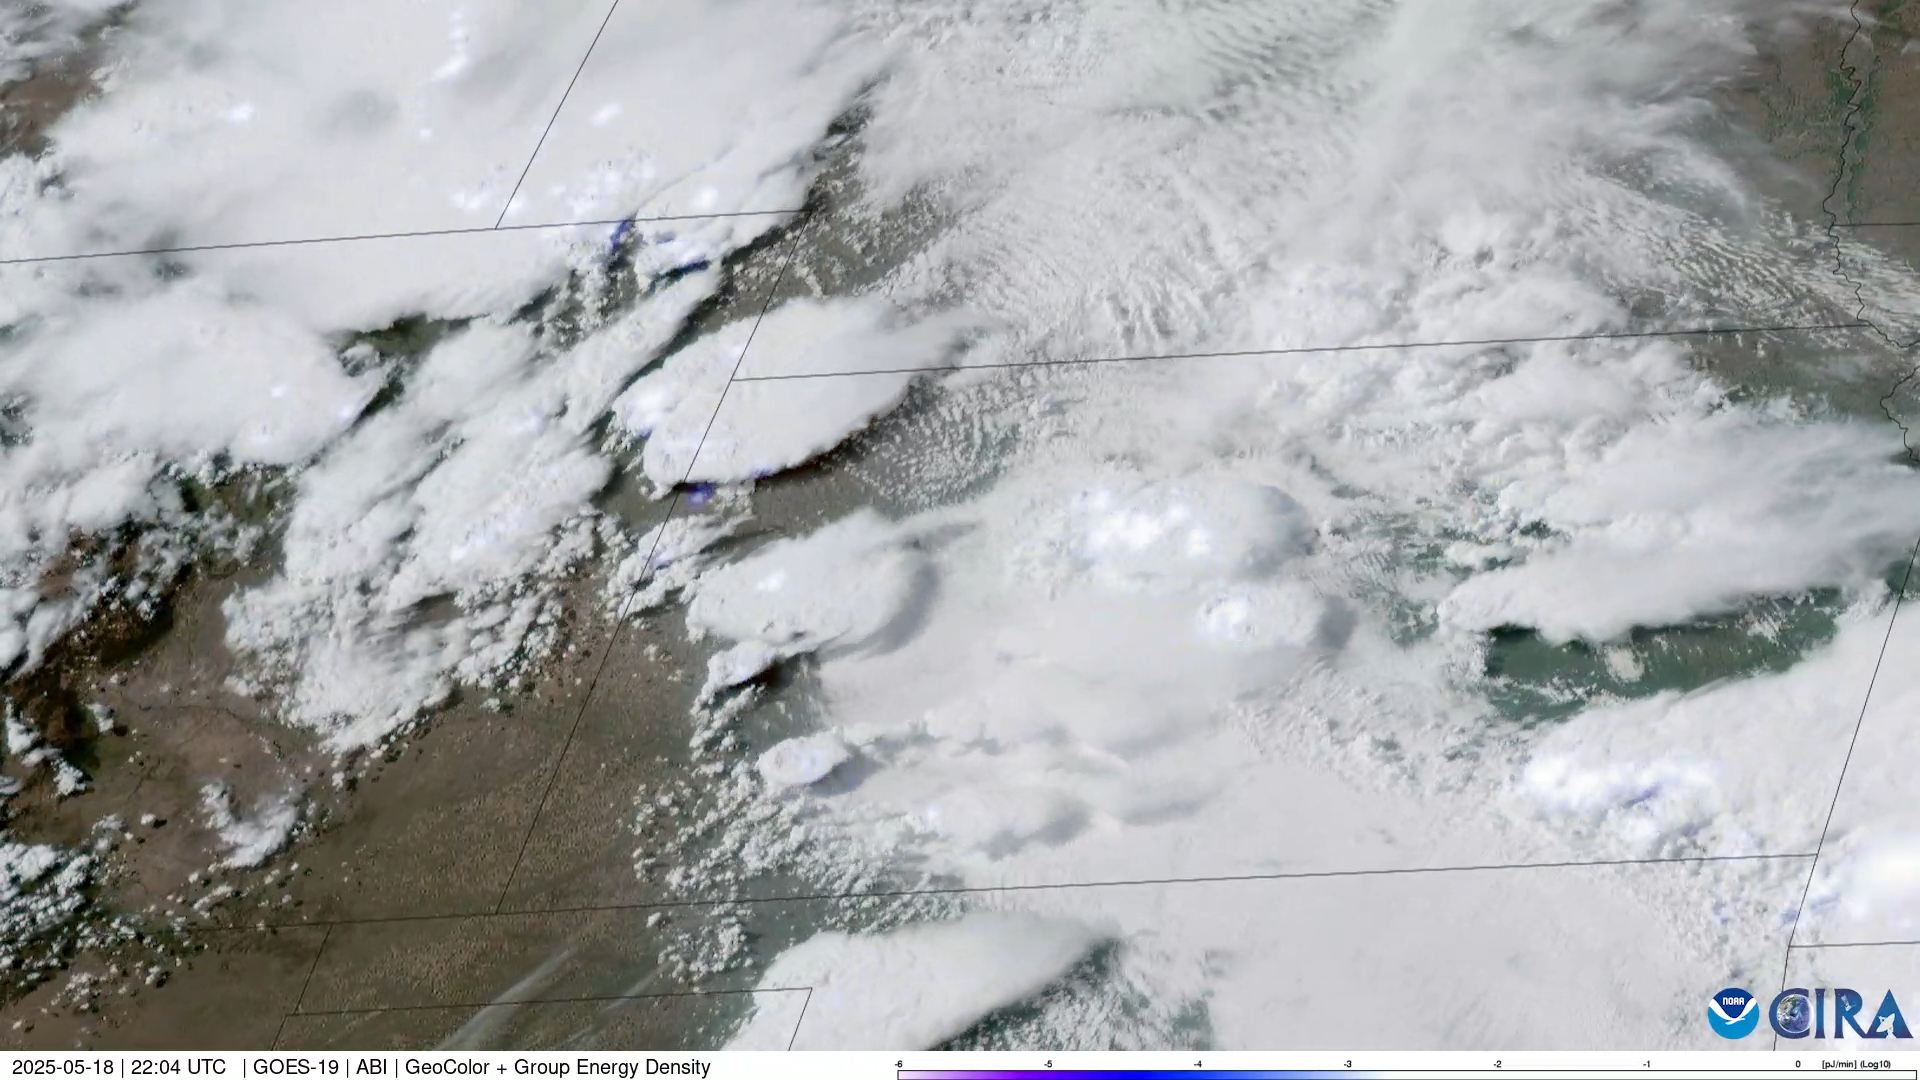
">

<figcaption align = "center"><b>Figure 1.</b> GOES-19 GeoColor imagery with GOES Lightning Mapper group extent density overlaid of thunderstorms initiating over Kansas on 18 May 2025 at 22:04 UTC. Image courtesy of the Cooperative Institute for Research in the Atmosphere at Colorado State University and the National Oceanic and Atmospheric Administration.</figcaption>
    
</figure>

## Software

This tutorial uses the Python programming language and packages. We will use:

- `netCDF4` to load our data;
- `numpy` for basic computations;
- `matplotlib` for plotting;
- `random` for operations that select random numbers;
- `datetime` to format the dates and times in our data.


To build and run our neural network, we will be using:

- `tensorflow`: `TensorFlow` is a Python-based machine learning library developed by google. `TensorFlow` uses a graphical structure to perform calculations, where layers and mathematical operations are represented as nodes, and the edges represent the data going from node to node.
- `keras`: `keras` is an application programming interface for tensorflow that we will use to build our neural network.

Finally, to save our trained neural network as a serialized binary file, we will use `pickle`. By saving our trained neural network, we can apply the neural network to data from a different sample.

<div class="alert alert-block alert-danger">
    <code>tensorflow</code> and <code>keras</code> are only compatible for Python versions 3.8&ndash;3.11.
</div>

## Install Packages

Let's first check if we have the necessary Python packages to run this notebook. If we don't, let's install them.

In [1]:
import subprocess, sys
packages = ["netCDF4", "numpy", "matplotlib",
            "tensorflow", "keras"]
for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

2025-07-23 16:45:54.337994: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now, let's load the modules in the packages (e.g., `Dataset`) or load the packages and assign a shorter object name for the packages (e.g., `import numpy as np`) for a cleaner use throughout the notebook.

In [2]:
from netCDF4 import Dataset
import random, requests, pickle, datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from tensorflow.keras.models import Model

## Data
In this notebook, we will use a toy dataset available on [Dryad](https://datadryad.org/dataset/doi:10.5061/dryad.m905qfv60). This dataset, called `conus1`, is a small dataset that we can use to train a convolutional neural network (CNN) relatively quickly. For those who are interested, the full dataset used in [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml) is available [here](https://mountainscholar.org/items/e25286ef-7e46-46e3-b318-3f8fcec82959). However, training the CNN using the full dataset will take longer compared to training the CNN using the dataset we will use here.

As we have discussed above, we will train a CNN to take satellite data as our input and produce simulated radar reflectivity as our output. Let's briefly look at both our input features and target variable.

### Input Features: Geostationary Satellite Data

#### GOES ABI
Our geostationary satellite inputs include three infrared channels from the GOES-16 Advanced Baseline Imager (ABI, [Schmit et al. 2017](https://journals.ametsoc.org/view/journals/bams/98/4/bams-d-15-00230.1.xml)):
- Channel 7 (3.9-&mu;m): shortwave infrared window
- Channel 9 (6.9-&mu;m): midlevel water vapor
- Channel 13 (10.3-&mu;m): clean longwave infrared window

These three channels are available during the daytime and the nighttime, and are compatible with older satellite systems. Therefore, the model we develop here can theoretically be applied to, for example, older GOES datasets. For more on the GOES ABI bands, you can check out the [quick start guide](https://www.goes-r.gov/mission/ABI-bands-quick-info.html) compiled by NOAA's GOES team.

#### GLM
We also use the GOES Lightning Mapper (GLM, Goodman et al. [2012](https://www.star.nesdis.noaa.gov/goesr/documents/ATBDs/Baseline/ATBD_GOES-R_GLM_v3.0_Jul2012.pdf), [2013](https://www.sciencedirect.com/science/article/pii/S0169809513000434)). GLM gives us satellite observations of lightning. Lightning is a useful variable in constructing synthetic radar because it is often co-located with strong updrafts in large convective systems. You can learn more about GLM [here](https://www.goes-r.gov/spacesegment/glm.html). The GLM data that we will use to construct our model is the group extent density (GED). GED is an estimate of the number of lightning flashes in a given area.

### Target Variable: Ground-Based Radar Data (MRMS)

Our target variable is the composite radar reflectivity provided by the Multi-Radar/Multi-Sensor System (MRMS, [Smith et al. 2016](https://journals.ametsoc.org/view/journals/bams/97/9/bams-d-14-00173.1.xml)). [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml) limited the development of the model to areas of the contiguous United States (CONUS) east of the Rocky Mountains (defined as east of 105° W). In this area, the quality of radar data&mdash;and therefore, MRMS data&mdash;is better, since the radar beams do not suffer from terrain blockages in and around the Rocky Mountains.

## Retrieving Data from Dryad

Let's first retrieve the data that we will use in this notebook. We will use the Python `netCDF4` and `requests` packages to read and retrieve the information directly from the file on Dryad, without downloading the file, and store the information in a netCDF instance called `ds`.

In [3]:
response = requests.get("https://datadryad.org/api/v2/files/2244527/download")
ds = Dataset("conus1.nc", memory=response.content)

Now that we've loaded our dataset, let's take a look at it by printing out the netCDF instance.

In [4]:
print(ds)

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    author: Kyle Hilburn
    title: GREMLIN CONUS1 Dataset
    funding: GOES-R Program Award NA19OAR4320073
    keywords: GOES-R, GOES-16, ABI, GLM, MRMS, infrared brightness temperature, lightning, radar reflectivity, machine learning, GREMLIN
    department: Cooperative Institute for Research in the Atmosphere
    institution: Colorado State University
    history: Created Fri Apr 14 15:37:15 2023
    dataset_name: conus1.nc
    spatial_coverage: Latitude 29.07 to 44.50 degrees_north, Longitude -109.02 to -79.09 degrees_east
    temporal_coverage: 2017-03-21T20:00:00Z to 2019-08-13T23:45:00Z
    description: The CONUS1 dataset provides:
        Inputs:
            Channel 0 = GOES-16 ABI C07 Brightness Temperature
            Channel 1 = GOES-16 ABI C09 Brightness Temperature
            Channel 2 = GOES-16 ABI C13 Brightness Temperature
            Channel 3 = GOES-16 GLM Lightning Group Extent Density
    

Among the available variables listed at the bottom of the printout, you can see the following:
- `Xdata_train`: our input features for training
- `Ydata_train`: our output variable for training
- `Xdata_test`: our input features for testing
- `Ydata_test`: our output variable for testing

As you can see, since we're using a toy dataset, the data is already divided into training and testing samples. And, as we will discuss later, the data is also already preprocessed for machine learning applications. However, data preparation and preprocessing are **really** important. Oftentimes, data preparation and preprocessing are the most important part of building a data-driven model. Therefore, while we do not discuss data preparation and preprocessing here, we encourage users to explore the importance of data preparation and preprocessing on their own. An example of data preprocessing can be found [here](https://www.geeksforgeeks.org/machine-learning/data-preprocessing-machine-learning-python/).

Before we move on, let's pre-define the name of our output files (a file for our trained model and a history file).

In [5]:
# This file will save our trained model for future use
modelfile = 'model.keras'

# This file logs our model training history
historyfile = 'history.bin'

## Data Structure
Before we proceed to building the neural network, let's take some time to understand the structure of our data. Let's print out the number of training and testing samples, the x- and y- dimensions of our input and output data, and the number of channels or input features (which we know should be four&mdash;three of the ABI channels and the GLM data).

But first, let's read in our training and testing data.

In [6]:
X_train = ds["Xdata_train"][:]  # training features
Y_train = ds["Ydata_train"][:]  # training labels
X_test = ds["Xdata_test"][:]  # testing features
Y_test = ds["Ydata_test"][:]  # testing labels

Now, let's print the data structure information.

In [7]:
# Number of samples for training
nsamp_train = X_train.shape[0]

# Number of samples for testing
nsamp_test = X_test.shape[0]

# Y and X dimensions for input data
ny = X_train.shape[1]
nx = X_train.shape[2]

# Y and X dimensions for output data
ny_out = Y_train.shape[1]
nx_out = Y_train.shape[2]

# Number of channels
nchan = X_train.shape[3]

# Print our dimensions
print('number of training samples: ', nsamp_train)
print('number of testing samples: ', nsamp_test)
print(' ')
print('y-dimension of input data: ', ny)
print('x-dimension of input data: ', nx)
print('y-dimension of output data: ', ny_out)
print('x-dimension of output data: ', nx_out)
print(' ')
print('number of channels: ', nchan)

number of training samples:  216
number of testing samples:  48
 
y-dimension of input data:  256
x-dimension of input data:  256
y-dimension of output data:  256
x-dimension of output data:  256
 
number of channels:  4


From the output above, we can see that we have 216 samples for training, and 48 samples for testing. In addition, we've confirmed that we have four channels or input features. More importantly, we see that the y- and x-dimensions of our input data match the y- and x-dimensions of our output data. Recall that we're simply taking satellite imagery as input and generating synthetic radar reflectivity for the same area. So, the spatial dimensions of the input and output data should be the same.

Since we're using a toy dataset, it contains data that is already normalized. Data normalization is another crucial step in data preparation and preprocessing, and it&mdash;among other things&mdash;ensures that data from each input is treated equally. To learn more about data normalization or standardization (which is a step equivalent to normalization), see [here](https://www.geeksforgeeks.org/what-is-data-normalization/) and [here](https://www.geeksforgeeks.org/machine-learning/what-is-standardization-in-machine-learning/).

We can confirm that our data has been normalized by printing the extreme values in the dataset&mdash;the minimum and maximum values. Normalized data should have a range of between zero and one.

In [8]:
print('min,max Xdata_train=', np.min(X_train), np.max(X_train))
print('min,max Xdata_test=', np.min(X_test), np.max(X_test))
print('min,max Ydata_train=', np.min(Y_train), np.max(Y_train))
print('min,max Ydata_test=', np.min(Y_test), np.max(Y_test))

min,max Xdata_train= 0.0 1.0
min,max Xdata_test= 0.0 1.0
min,max Ydata_train= 0.0 1.0
min,max Ydata_test= 0.0 1.0


Now that we've understood our data structure and confirmed that it has been normalized, let's proceed to setting up the convolutional neural network.

## Machine Learning Model Setup

Let's walk through the setup for the machine learning model. We're going to use a slightly modified version of the convolutional neural network (CNN) described in [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml). Recall that [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml) named their model the GOES Radar Estimation via Machine Learning to Inform NWP or GREMLIN. Figure 2 shows the simplified GREMLIN architecture we will develop in this notebook. We'll discuss the interpretation of this figure in the following sections.

<figure>
    <img src="data:image/jpg;base64, iVBORw0KGgoAAAANSUhEUgAACtIAAAWkCAYAAABSdQe9AAAKsGlDQ1BJQ0MgUHJvZmlsZQAASImVlwdUk9kSgO//p4eElhABKaE3QToBpITQQu/NRkgChBJjSFCxI4srsBZUREBZkEUBBRvVjgULi2AB+4IsIuq6WLCh8n7gEHb3nffeeZMzZ75M5s7M/c+9OfMDQKZyRKI0WBGAdKFEHObjQY+JjaPjRgAOKABF5OPE4WaImCEhAQCRGft3+dALoEl723wy17///l9FicfP4AIAhSCcwMvgpiN8EtFRrkgsAQBVhfj1VkhEk3wVYaoYaRDhR5OcNM2jk5wwxWj0VExEGAthVQDwJA5HnAQASR/x0zO5SUgekifClkKeQIgw8h24pqcv4yGM1AXGSIwI4cn8jIS/5En6W84EWU4OJ0nG03uZErynIEOUxln1fz6O/y3padKZGoaIkpLFvmGIRfqC7qUu85exMCEoeIYFvKn4KU6W+kbOMDeDFTfDPI6nv2xtWlDADCcKvNmyPBJ2xAzzM7zCZ1i8LExWK1HMYs4wRzxbV5oaKfMn89my/FnJEdEznCmICprhjNRw/9kYlswvlobJ+ucLfTxm63rL9p6e8Zf9CtiytZLkCF/Z3jmz/fOFzNmcGTGy3nh8T6/ZmEhZvEjiIaslSguRxfPTfGT+jMxw2VoJciBn14bInmEKxy9khkEA8AF0EAnSgASIAQd4AwEQAr6Ev3LyjALWMtEqsSApWUJnIreMT2cLuRbz6NaW1nYATN7Z6SPxjjZ1FyHa9VnfphoAXFonJiZOzfr8ugE4Fg8AsXHWZ7wYAMVhAK6e5krFmdO+yesEMICI/BtQgRrQAnrAGJgDa2APnIE78AJ+IBhEgFiwBHBBMkhHOl8B1oCNIBfkg+1gNygB5eAAOASOgOOgGZwGF8AVcAN0g7vgIegHQ+AlGAUfwDgEQTiIDFEgNUgbMoDMIGuIAblCXlAAFAbFQvFQEiSEpNAaaBOUDxVCJVAFVAMdg1qhC9A1qAe6Dw1AI9Bb6AuMgkkwFdaEDeH5MANmwv5wBLwYToKXw1lwDrwVLoYr4cNwE3wBvgHfhfvhl/AYCqDkUDSUDsocxUCxUMGoOFQiSoxah8pDFaEqUfWoNlQH6jaqH/UK9RmNRVPQdLQ52hnti45Ec9HL0evQBegS9CF0E/oS+jZ6AD2K/o4hYzQwZhgnDBsTg0nCrMDkYoow1ZhGzGXMXcwQ5gMWi6VhjbAOWF9sLDYFuxpbgN2HbcCex/ZgB7FjOBxODWeGc8EF4zg4CS4Xtxd3GHcOdws3hPuEl8Nr463x3vg4vBCfjS/C1+LP4m/hh/HjBEWCAcGJEEzgEVYRthGqCG2Em4QhwjhRiWhEdCFGEFOIG4nFxHriZeIj4js5OTldOUe5UDmB3Aa5YrmjclflBuQ+k5RJpiQWaRFJStpKOkg6T7pPekcmkw3J7uQ4soS8lVxDvkh+Qv4kT5G3kGfL8+TXy5fKN8nfkn+tQFAwUGAqLFHIUihSOKFwU+GVIkHRUJGlyFFcp1iq2KrYpzimRFGyUgpWSlcqUKpVuqb0XBmnbKjspcxTzlE+oHxReZCCouhRWBQuZROlinKZMkTFUo2obGoKNZ96hNpFHVVRVrFViVJZqVKqckaln4aiGdLYtDTaNtpxWi/tyxzNOcw5/Dlb5tTPuTXno+pcVXdVvmqeaoPqXdUvanQ1L7VUtR1qzWqP1dHqpuqh6ivU96tfVn81lzrXeS53bt7c43MfaMAaphphGqs1Dmh0aoxpamn6aIo092pe1HylRdNy10rR2qV1VmtEm6Ltqi3Q3qV9TvsFXYXOpKfRi+mX6KM6Gjq+OlKdCp0unXFdI91I3WzdBt3HekQ9hl6i3i69dr1RfW39QP01+nX6DwwIBgyDZIM9Bh0GHw2NDKMNNxs2Gz43UjViG2UZ1Rk9MiYbuxkvN640vmOCNWGYpJrsM+k2hU3tTJNNS01vmsFm9mYCs31mPfMw8xznCedVzuszJ5kzzTPN68wHLGgWARbZFs0Wr+frz4+bv2N+x/zvlnaWaZZVlg+tlK38rLKt2qzeWptac61Lre/YkG28bdbbtNi8sTWz5dvut71nR7ELtNts1273zd7BXmxfbz/ioO8Q71Dm0MegMkIYBYyrjhhHD8f1jqcdPzvZO0mcjjv96WzunOpc6/x8gdEC/oKqBYMuui4clwqXfle6a7zrz679bjpuHLdKt6fueu4892r3YaYJM4V5mPnaw9JD7NHo8ZHlxFrLOu+J8vTxzPPs8lL2ivQq8Xrireud5F3nPepj57Pa57wvxtffd4dvH1uTzWXXsEf9HPzW+l3yJ/mH+5f4Pw0wDRAHtAXCgX6BOwMfBRkECYOag0EwO3hn8OMQo5DlIadCsaEhoaWhz8KswtaEdYRTwpeG14Z/iPCI2BbxMNI4UhrZHqUQtSiqJupjtGd0YXR/zPyYtTE3YtVjBbEtcbi4qLjquLGFXgt3LxxaZLcod1HvYqPFKxdfW6K+JG3JmaUKSzlLT8Rj4qPja+O/coI5lZyxBHZCWcIol8Xdw33Jc+ft4o3wXfiF/OFEl8TCxOdJLkk7k0aS3ZKLkl8JWIISwZsU35TylI+pwakHUyfSotMa0vHp8emtQmVhqvDSMq1lK5f1iMxEuaL+5U7Ldy8fFfuLqzOgjMUZLRIqMhx1So2lP0gHMl0zSzM/rYhacWKl0krhys5Vpqu2rBrO8s76ZTV6NXd1+xqdNRvXDKxlrq1YB61LWNe+Xm99zvqhDT4bDm0kbkzd+Gu2ZXZh9vtN0ZvacjRzNuQM/uDzQ12ufK44t2+z8+byH9E/Cn7s2mKzZe+W73m8vOv5lvlF+V8LuAXXf7L6qfinia2JW7u22W/bvx27Xbi9d4fbjkOFSoVZhYM7A3c27aLvytv1fvfS3deKbIvK9xD3SPf0FwcUt+zV37t979eS5JK7pR6lDWUaZVvKPu7j7bu1331/fblmeX75l58FP9+r8KloqjSsLDqAPZB54FlVVFXHL4xfaqrVq/Orvx0UHuw/FHboUo1DTU2tRu22OrhOWjdyeNHh7iOeR1rqzesrGmgN+UfBUenRF8fij/Ue9z/efoJxov6kwcmyRkpjXhPUtKpptDm5ub8ltqWn1a+1vc25rfGUxamDp3VOl55RObPtLPFsztmJc1nnxs6Lzr+6kHRhsH1p+8OLMRfvXAq91HXZ//LVK95XLnYwO85ddbl6+prTtdbrjOvNN+xvNHXadTb+avdrY5d9V9NNh5st3Y7dbT0Les7ecrt14bbn7St32Hdu3A2629Mb2Xuvb1Ff/z3evef30+6/eZD5YPzhhkeYR3mPFR8XPdF4UvmbyW8N/fb9ZwY8Bzqfhj99OMgdfPl7xu9fh3KekZ8VDWsP1zy3fn56xHuk+8XCF0MvRS/HX+X+ofRH2Wvj1yf/dP+zczRmdOiN+M3E24J3au8Ovrd93z4WMvbkQ/qH8Y95n9Q+HfrM+NzxJfrL8PiKr7ivxd9MvrV99//+aCJ9YkLEEXOmRgEUonBiIgBvDwJAjgWAgswQxIXTM/WUQNPvAVME/hNPz91TYg9APWImRyPWeQCOImq4AQAFdwAmx6IIdwDb2Mh0Zv6dmtUnRQt5V1goAbjv2fdKrME/ZXqO/0vf/7RgMqst+Kf9F6RIC66pj92fAAAAlmVYSWZNTQAqAAAACAAFARIAAwAAAAEAAQAAARoABQAAAAEAAABKARsABQAAAAEAAABSASgAAwAAAAEAAgAAh2kABAAAAAEAAABaAAAAAAAAAJAAAAABAAAAkAAAAAEAA5KGAAcAAAASAAAAhKACAAQAAAABAAAK0qADAAQAAAABAAAFpAAAAABBU0NJSQAAAFNjcmVlbnNob3T2CSjIAAAACXBIWXMAABYlAAAWJQFJUiTwAAAC2WlUWHRYTUw6Y29tLmFkb2JlLnhtcAAAAAAAPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iWE1QIENvcmUgNi4wLjAiPgogICA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPgogICAgICA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIgogICAgICAgICAgICB4bWxuczpleGlmPSJodHRwOi8vbnMuYWRvYmUuY29tL2V4aWYvMS4wLyIKICAgICAgICAgICAgeG1sbnM6dGlmZj0iaHR0cDovL25zLmFkb2JlLmNvbS90aWZmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+NDA5NjwvZXhpZjpQaXhlbFhEaW1lbnNpb24+CiAgICAgICAgIDxleGlmOlVzZXJDb21tZW50PlNjcmVlbnNob3Q8L2V4aWY6VXNlckNvbW1lbnQ+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj4yMzA0PC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPHRpZmY6UmVzb2x1dGlvblVuaXQ+MjwvdGlmZjpSZXNvbHV0aW9uVW5pdD4KICAgICAgICAgPHRpZmY6WVJlc29sdXRpb24+MTQ0PC90aWZmOllSZXNvbHV0aW9uPgogICAgICAgICA8dGlmZjpYUmVzb2x1dGlvbj4xNDQ8L3RpZmY6WFJlc29sdXRpb24+CiAgICAgICAgIDx0aWZmOk9yaWVudGF0aW9uPjE8L3RpZmY6T3JpZW50YXRpb24+CiAgICAgIDwvcmRmOkRlc2NyaXB0aW9uPgogICA8L3JkZjpSREY+CjwveDp4bXBtZXRhPgpVqhyCAABAAElEQVR4AezdCbAV1Zk48I/HJiA7ISJBnIgK7suA/4yWI1IRdFxwrAKSMkFTZIUxjqiEaAgp4lIWrjGjSSyLoEhiRJPZRAa0GMQojqgYEEdFzKASA0gQA7L+53TmXt924T7e4/Fev19Xtff06dPd5/wOL6nq+93ztdr9v1vYCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECLQwgYoWNl7DJUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJAJCKT1D4EAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBFCgikbZHTbtAECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQICaf0bIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQaJECAmlb5LQbNAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAgEBa/wYIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRapIBA2hY57QZNgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAgkNa/AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgRYpIJC2RU67QRMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECAik9W+AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgRQoIpG2R027QBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECbepD0KpVq/pc7loCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC+yywe/fufb42XWhF2nrxuZgAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKC5Cgikba4zp98ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQL1EhBIWy8+FxMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECDRXAYG0zXXm9JsAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBeAm3qdXUtF+/evbuWWlUECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE9l2gVatW+35xiSutSFsCRjUBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEC+BQTS5nt+jY4AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCEgEDaEjCqCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE8i0gkDbf82t0BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECJQQE0paAUU2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJBvAYG0+Z5foyNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECghIJC2BIxqAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBfAsIpM33/BodAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBACQGBtCVgVBMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECORbQCBtvufX6AgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBEoICKQtAaOaAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAg3wICafM9v0ZHgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQQkAgbQkY1QQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvkWEEib7/k1OgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgRICAmlLwKgmQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDIt4BA2nzPr9ERIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAiUEBBIWwJGNQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQL4FBNLme36NjgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoISAQNoSMKoJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTyLSCQNt/za3QECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIlBATSloBRTYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkG8BgbT5nl+jI0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQKCEgkLYEjGoCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIF8Cwikzff8Gh0BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEAJAYG0JWBUEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI5FtAIG2+59foCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIESggIpC0Bo5oAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQCDfAgJp8z2/RkeAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIFBCQCBtCRjVBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC+RYQSJvv+TU6AgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBEgICaUvAqCZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEMi3gEDafM+v0REgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECJQQEEhbAkY1AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAvgUE0uZ7fo2OAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECghIBA2hIwqgkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPItIJA23/NrdAQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAiUEBNKWgFFNgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQbwGBtPmeX6MjQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAoISCQtgSMagIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgXwLCKTN9/waHQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQAkBgbQlYFQTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkW0Agbb7n1+gIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRKCAikLQGjmgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAIN8CAmnzPb9GR4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUEJAIG0JGNUECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQL5FhBIm+/5NToCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIESAgJpS8CoJkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQyLeAQNp8z6/RESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIlBAQSFsCRjUBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEC+BQTS5nt+jY4AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCEgEDaEjCqCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE8i3QJt/DMzoCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQqE3g//399NqqG6Tu2UevbpD7uAkBAgQIECBAgAABAgT2t4AVafe3sPsTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAg0SQEr0jbJadEpAgSag4BfaTeHWdJHAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIlBYQSFvaxhkCBAgQIECAAAECBAgQIECAAAECBAgQIECAAIF9FLAYwT7CuYwAAQIECBAgQIAAAQIECBBoVIGKRn2ahxEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBoIgJWpG0iE6EbBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQONACnz781Dp34Q+rX6jzNS4gQIAAAQIECBAgQIBAUxGwIm1TmQn9IECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQaFQBK9I2KreHESCQdwG/0s77DBtfuQL/7++nl9u0zu2effTqOl/jAgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQK1CQikrU1FHQECBAgQIECAAAECBAgQIECAAAECBAgQIECAQIMLWIygwUndkAABAgQIECBAgAABAgQIEKinQEU9r3c5AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgWYpIJC2WU6bThMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECNRXQCBtfQVdT4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0CwF2jTLXus0AQIECBAg0OwEPn34qXXu8x9Wv1Dna1xAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoFwBK9KWK6UdAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBArgQE0uZqOg2GAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgXAGBtOVKaUeAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJArAYG0uZpOgyFAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEChXQCBtuVLaESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI5EpAIG2uptNgCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEyhUQSFuulHYECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQK5EhBIm6vpNBgCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFyBQTSliulHQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQK4EBNLmajoNhgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoFwBgbTlSmlHgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQKwGBtLmaToMhQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAoV0AgbblS2hEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECORKQCBtrqbTYAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBMoVEEhbrpR2BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECuRIQSJur6TQYAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBcgUE0pYrpR0BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgECuBATS5mo6DYYAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBcAYG05UppR4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkCsBgbS5mk6DIUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQKFdAIG25UtoRIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkSkAgba6m02AIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTKFRBIW66UdgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABArkSEEibq+k0GAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgXIFBNKWK6UdAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBArgQE0uZqOg2GAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgXAGBtOVKaUeAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJArAYG0uZpOgyFAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEChXQCBtuVLaESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI5EpAIG2uptNgCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEyhUQSFuulHYECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQK5EhBIm6vpNBgCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFyBQTSliulHQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQK4EBNLmajoNhgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoFwBgbTlSmlHgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQKwGBtLmaToMhQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAoV0AgbblS2hEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECORKQCBtrqbTYAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBMoVEEhbrpR2BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECuRIQSJur6TQYAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBcgUE0pYrpR0BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgECuBATS5mo6DYYAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBcAYG05UppR4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkCsBgbS5mk6DIUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQKFdAIG25UtoRIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkSkAgba6m02AIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTKFRBIW66UdgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABArkSEEibq+k0GAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgXIFBNKWK6UdAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBArgQE0uZqOg2GAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgXAGBtOVKaUeAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJArAYG0uZpOgyFAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEChXQCBtuVLaESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI5EpAIG2uptNgCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEyhUQSFuulHYECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQK5EhBIm6vpNBgCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFyBQTSliulHQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQK4EBNLmajoNhgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoFwBgbTlSmlHgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQKwGBtLmaToMhQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAoV0AgbblS2hEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECORKQCBtrqbTYAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBMoVEEhbrpR2BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECuRIQSJur6TQYAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBcgUE0pYrpR0BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgECuBATS5mo6DYYAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBcAYG05UppR4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkCsBgbS5mk6DIUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQKFdAIG25UtoRIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkSkAgba6m02AIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTKFRBIW66UdgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABArkSaJOr0RgMAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAZCGzbti2WLVsWL7zwQravXr06Pvjgg9i4cWP2uX379mjTpk1069atuPfr1y9OPvnkbD/ppJOiS5cuzWCkukiAAAECBAgQIECAAAECBAgQaNoCAmmb9vzoHQECBAgQIECAAAECBAgQIECAAAECBAgQIJATgbfeeivmzJkTjz76aBY8m4Jp97Zt2LChSpOf//zn2XGrVq1i0KBBMXLkyLjkkkvilFNOqdLOAQECBAgQIECAAAECBAgQIECAQHkCAmnLc9KKAAECBAgQIECAAAECBAgQIECAAAECBAgQIFBngfXr18d9990XDz/8cCxdurTO15e6YPfu3bFixYpsv/HGG+Pwww+PUaNGxfjx4+Owww4rdZl6AgQIECBAgAABAgQIECBAgACBagICaauBOCRAgAABAo0hIHVfYyh7BgECBAgQIECAAAECBAgQIEDgwAmsXLky7rjjjpg5c2Zs2bKl7I60bt06unTpEh06dIg///nPsWnTpti1a9der1+9enXccsstcdttt8Xo0aPjmmuuiRNPPHGv12lAgAABAgQIECBAgAABAgQIEGjpAgJpW/q/AOMnQIAAgUYTkLqv0ag9iAABAgQIECBAgAABAgQIECBwQAXGjRsX999/f6RVY2vb2rZtG4MHD47jjjsujj322DjmmGNi4MCB0b179+jUqVONSzZv3hxpZdsUnJtWoV2+fHm88sor8cILL8TOnTurtN+xY0fMmjUr28eOHRszZsyoct4BAQIECBAgQIAAAQIECBAgQIBAVQGBtFU9HBEgQIAAgQYVkLqvQTndjAABAgQIECBAgAABAgQIECDQLAQeffTRGkG0/fv3jxEjRmT7sGHDonPnzmWP5eCDD460p3sMHz68eN3GjRtjwYIFMXfu3Gxfs2ZN8VwqPPLIIwJpq4g4IECAAAECBAgQIECAAAECBAjUFKioWaWGAAECBAgQqK9AWh3kG9/4RvTr1y++853vxNKlS8u6ZUrdl1YeOfTQQ6Nbt25RUVHe/1UXUvcdccQRcemll8bLL79c1vM0IkCAAAECBAgQIECAAAECBAgQaHiBwjuddu3axejRo+PJJ5+M9P7m3nvvjZEjR9YpiHZPvUvvjy655JL42c9+Fr///e9j/vz52fPSc20ECBAgQIAAAQIECBAgQIAAAQLlCViRtjwnrQgQIECAQNkCUveVTaUhAQIECBAgQIAAAQIECBAgQCCXApMnT45du3bF2LFjo3fv3o0yxlatWkVa6Tbt69atiwcffDA2bdrUKM/2EAIECBAgQIAAAQIECBAgQIBAcxYQSNucZ0/fCRAgQKBJCkjd1ySnRacIECBAgAABAgQIECBAgAABAo0mMHHixEZ7Vm0P6tWrV1x55ZW1nVJHgAABAgQIECBAgAABAgQIECBQTUAgbTUQhwQIECBAoL4ClVP3XXzxxfH1r389hg4dWt/b1ri+kLovpe/bvXt3liIwpfF77LHHYtu2bTXaqyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoKqAQNqqHo4IECBAgEC9BaTuqzehGxAgQIAAAQIECBAgQIAAAQIECPyvQPqx9MaNG6NVq1bxqU99igkBAgQIECBAgAABAgQIECBAgMB+EBBIux9Q3ZJASxRIL3SXLVsWL7zwQravXr06Pvjgg+wlb/rcvn17tGnTJtIKmoW9X79+cfLJJ2f7SSedFF26dGmJdMacQwGp+3I4qYZEgAABAgQIECBAgAABAgQIEGgkgRUrVsTUqVPjt7/9bbz77rtZJqKUjahHjx4xaNCg+PznPx9XX311dOrUqZF65DEECBAgQIAAAQIECBAgQIAAgXwLCKTN9/waHYH9KvDWW2/FnDlz4tFHH82CZ8tJJb9hw4Yqffr5z3+eHacVFdJL4JEjR0ZKU3/KKadUaeeAAAECBAgQIECAAAECBAgQIECAAAECzU1g69atMWLEiHjttdeiY8eOsXjx4jjkkENKDuOqq66Ku+66K3bu3FmjTXq3mq5P+09/+tO46aab4stf/nKNdioIECBAgAABAgQIECBAgAABAgTqJiCQtm5eWhNo8QLr16+P++67Lx5++OFYunRpg3mkFRXSSgtpv/HGG+Pwww+PUaNGxfjx4+Owww5rsOe4EYHmJCB1X3OaLX0lQIAAAQIECBAgQIAAAQIECNQUeOyxx2LhwoXZiYqKimjXrl3NRv9XM3v27Lj99ttLnq98Iq1UO3bs2Pjoo4/im9/8ZuVTygQIECBAgAABAgQIECBAgAABAnUUEEhbRzDNCbRUgZUrV8Ydd9wRM2fOjC1btpTN0Lp16+jSpUt06NAh/vznP8emTZti165de71+9erVccstt8Rtt90Wo0ePjmuuuSZOPPHEvV6nAYHmLiB1X3OfQf0nQIAAAQIECBAgQIAAAQIECHwi8NRTTxUPTj/99OjRo0fxuHJh3bp1MWHChMpVWblXr17Rr1+/7N3q+++/Hx988EGVNhMnToyhQ4fGwIEDq9Q7IECgYQTSYgfLli3LsvK98MILkb67SH+HGzduzD63b98ebdq0iW7duhX39Dd78sknZ/tJJ52UfUfSML1xFwIECBAgQIAAAQIECBDYXwICafeXrPsSyJHAuHHj4v7774+0amxtW9u2bWPw4MFx3HHHxbHHHhvHHHNM9uK2e/fu0alTpxqXbN68OdLKtik4NwUNLl++PF555ZXsRVT1lGU7duyIWbNmZXtaYWHGjBk17qeCQFMVkLqvqc6MfhEgQIAAAQIECBAgQIAAAQIEGkcgvQMtbGeddVahWOPzmWeeiQ0bNhTrjzjiiJg+fXpcdNFF0apVq2L9E088EVOmTIklS5ZkdWnRg8suuyyeffbZYhsFAgTqJ/DWW2/FnDlz4tFHH82+t0jBtHvbKv/9prY///nPs0vS3++gQYNi5MiRcckll8Qpp5yyt1s5T4AAAQIECBAgQIAAAQIHQEAg7QFA90gCzU0gvSyqHkTbv3//GDFiRLYPGzYsOnfuXPawDj744Eh7usfw4cOL16VfcC9YsCDmzp2b7WvWrCmeS4VHHnlEIG0VEQdNXUDqvqY+Q/pHgAABAgQIECBAgAABAgQIENi/ApWD6wYMGFDyYa+++mrxXPv27SO9Vzr++OOLdYVCep+aVqBN72SffvrprPq5557LVsdMK2LaCBDYN4G0+Md9990XDz/8cCxdunTfblLLVem7lbSgSNpvvPHGOPzww2PUqFExfvz4OOyww2q5QhUBAgQIECBAgAABAgQIHAiBigPxUM8kQKB5CVRU/OV/Ktq1axejR4+OJ598MktfdO+992a/oq5LEO2eRp5e9KZfZP/sZz+L3//+9zF//vzseem5NgLNUaAhUvelFGBHH310pBWeq28pdV/lVU2qn3dMgAABAgQIECBAgAABAgQIECDQdARS9q1SW+VA2gsuuKDWINrCtel9aVotM6WTL2wp9byNAIG6C6T3q9/4xjeiX79+8Z3vfKfsINrWrVtn72wPPfTQSN9tFL5H2VsPVq9eHbfcckukVacvvfTSePnll/d2ifMECBAgQIAAAQIECBAg0AgCn7xlaYSHeQQBAs1TYPLkybFr164YO3Zs9O7du1EGkdIdpVUV0r5u3bp48MEHY9OmTY3ybA8h0FAClYNcpe5rKFX3IUCAAAECBAgQIECAAAECBAg0H4Ejjzwyli9fnnX42Wefja985Su1dv6dd94p1h9zzDHFcqlCek+bVqx98cUXsyYvvfRSnHnmmaWaqydAoBaBcePGxf33318jI1+hadu2bWPw4MFx3HHHxbHHHhvpb3PgwIFZAG2nTp0KzYqfmzdvjrSybXovnFagTX/7r7zySrzwwguxc+fOYrtUSIH1s2bNyvb03cuMGTOqnHdAgAABAgQIECBAgAABAo0rIJC2cb09jUCzFEirXh7IrVevXnHllVceyC54NoF9EpC6b5/YXESAAAECBAgQIECAAAECBAgQyI1ACrorbIsWLSoUa3ymFS0LW9euXQvFPX6mFTQLgbSvvfbaHts6SYBATYFHH320RhBt//79Y8SIEdmeFvqoS0a+gw8+ONKe7jF8+PDiAzdu3BgLFiyIuXPnZvuaNWuK51LhkUceEUhbRcQBAQIECBAgQIAAAQIEGl/gL/naG/+5nkiAAAECBFqUgNR9LWq6DZYAAQIECBAgQIAAAQIECBAgkAkcffTRRYm0SmUKpqtt69u3b7F61apVxfKeCoWVblOb7t2776mpcwQI1CJQUfGXr0nbtWsXo0ePjieffDJWr14d9957b4wcObJOQbS13L5YlQLlL7nkkvjZz34Wv//972P+/PnZ89JzbQQIECBAgAABAgQIECDQNAQE0jaNedALAi1GIL0g+sEPfhDXXXddrFu3rsWM20BbpkBK3VfYUuq+Utu+pu4r3C+l7rMRIECAAAECBAgQIECAAAECBAg0PYG0omWHDh2KHUvBeUuWLCkeFwqf+9znCsV46qmniuVShSeeeCLefPPN4ukBAwYUywoECJQnMHny5Ljlllvif/7nf+IXv/hFDB06tLwL69GqVatWkf53IT0vvRe+/fbb49prr63HHV1KgAABAgQIECBAgAABAg0h0KYhbuIeBAgQKFdg0qRJsXTp0qx5nz59YsKECeVeqh2BZicgdV+zmzIdJkCAAAECBAgQIECAAAECBAg0qEC/fv3i6quvjmnTpmX33bx5c5x77rlx6623xpgxY+Kggw7K6s8555xo3759fPzxx7FixYos2HbIkCG19uXxxx/PVresfHLQoEGVD5UJEChDYOLEiWW02n9NevXqFVdeeeX+e4A7EyBAgAABAgQIECBAgEDZAlakLZtKQwIEGkJg9+7dxdvs2rWrWFYgkEcBqfvyOKvGRIAAAQIECBAgQIAAAQIECBCom0BaXKBv377FizZs2BCXX355pCDbtCLmvHnzYv369Vkq+UKjKVOmZMXt27fHmjVrYtGiRXH99ddHWnn2vPPOiy1bthSaRlrN9rTTTiseKxAgQIAAAQIECBAgQIAAAQIECNRNwIq0dfPSmgABAgQIlC1QSN1X+GIjpe5bsGBBVF9NJH3Zceedd2b3lbqvbF4NCRAgQIAAAQIECBAgQIAAAQLNQqBTp04xf/78uPDCC+P1118v9nndunVx8803Z3ux8v8KTzzxRLRp0yZ27txZ/VSV44qKilqvr9LIAQECBAgQIECAAAECBAgQIECAwB4FrEi7Rx4nCRCoLPDQQw9F69at67W/+OKLxVt++9vfrnGvtm3bxtKlS4ttFAg0Z4FC6r7CGAqp+2bMmBFbt24tVEchdV+qKKTuK56sVkip+y6++OIqtVL3VeFwQIAAAQIECBAgQIAAAQIECBBocgIDBw6M5557LkaMGFF23/YWRHvwwQfHb37zmzjzzDPLvqeGBAg0rkD6XiWtMP3DH/6wykrSjdsLTyNAgAABAgQIECBAgACBvQkIpN2bkPMECBQF0oveXbt21Wsv3uz/CtXvt2PHjnjjjTeqN3NMoNkKSN3XbKdOxwkQIECAAAECBAgQIECAAAECDSrQvXv3SD+Sfvrpp2PMmDGRFhXYly0F0I4bNy6ef/75OP/88/flFq4hQKCRBK644oqYNm1afO9734vKC4000uM9hgABAgQIECBAgAABAgTKFGhTZjvNCBAgEB9++GGjKKR0ZDYCeRGQui8vM2kcBAgQIECAAAECBAgQIECAAIGGETj99NMj7evXr48lS5ZkGbpSgN17770XmzZtyvZt27ZFx44dI71bSoGzffr0iSOPPDJOPfXUbFXbzp07N0xn3IUAgf0qsHv37uL9K5eLlQoECBAgQIAAAQIECBAg0CQEBNI2iWnQCQLNQ6B169Y1Ojps2LAadXuqWLRoUaSXwGk76qijol+/flWap2f89V//dZU6BwSau0Ahdd8Xv/jFmDt3blnDKSd13+zZs6XuK0tTIwIECBAgQIAAAQIECBAgQIBA0xPo2bNnnHvuudne9HqnRwQIECBAgAABAgQIECBAgACBliMgkLblzLWREqi3wKGHHlrjHl27do3bbrst+vfvX+NcbRWnnHJKMX3R+PHjI6U1shFoCQKF1H2LFy+Ou+++O+bMmRPbt2+v89DTCiQp9d/EiRMjBejaCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDYdwGBtPtu50oCLU7ga1/7WvzHf/xH/Pa3vy2O/dFHH43HH388Jk+eHNdcc00cdNBBxXMKBAjUFJC6r6aJGgIECBAgQIAAAQIECBAgQIAAAQIECBwogbfffjt+97vf7ZfHb9iwYb/c100JECBAgAABAgQIECBAoGEFBNI2rKe7Eci1QN++fSOtpjlz5syYNGlS/OEPf8jGu2XLlpgyZUrMmDEjbr/99rjwwgtz7WBwBBpCQOq+hlB0DwIECBAgQIAAAQIECBAgQIBAyxV46KGHYuXKldGuXbsse1GHDh1aLoaRE6iHwNSpU7PvN+pxC5cSIECAAAECBAgQIECAQDMXqGjm/dd9AgQaWaBVq1YxduzY+O///u/4x3/8x2jT5pN4/FWrVsVFF10U5513Xrz++uuN3DOPI0CAAAECBAgQIECAAAECBAgQIECAQMsRuOKKK2LatGnxve99L1588cWWM3AjJdDAAps2bWrgO7odAQIECBAgQIAAAQIECDQ3AYG0zW3G9JdAExHo0qVL3HbbbfHSSy/F2WefXaVXjz/+eBx33HHx3e9+Nz766KMq5xwQIECAAAECBAgQIECAAAECBAgQIECAQP0Fdu/eXbxJ5XKxUoEAgbIEOnbsWFY7jQgQIECAAAECBAgQIEAgvwKfLCWZ3zEaGQEC+1Hg2GOPjQULFsTDDz+cpQ9bs2ZN9rRt27bFTTfdFA888EBMnz49Ro8evR974dYEWp6A1H0tb86NmAABAgQIECBAgAABAgQIECBAgACBhhe47LLL4sEHHyzeOGXmmzRpUvG4PoU77rgjtm7dWp9buJYAAQIECBAgQIAAAQIEGkFAIG0jIHsEgZYgMGrUqPi7v/u7uPHGG7PA2RRIm7YUWDtmzJj4yU9+Ej/60Y9aAoUxEmgUgZS6b/369dmz0qrQf/M3f9Moz/UQAgQIECBAgAABAgQIECBAgAABAgQI5Elg2LBhkYJpZ8yYkQ2roqIi+17jxBNPrPcwf/rTnwqkrbeiGxAgQIAAAQIECBAgQGD/Cwik3f/GnkCgxQh06tQpbrjhhrj88svj29/+dvz7v/97cexPPfVUnHTSSbFjx45inQIBAvsuUDldX+Xyvt/RlQQIECBAgAABAgQIECBAgAABAg0t8Pbbb8fvfve7hr5tdr8NGzbsl/u6KYGWKHDrrbdm32m8//77sXPnzhg/fnwsWrQo0uq0NgIECBAgQIAAAQIECBDIv4BA2vzPsRESaHSBAQMGxL/927/Fv/zLv8SVV14Zq1atyvogiLbRp8IDCRAgQIAAAQIECBAgQIAAAQIECBA4gAJTp04trnJ5ALvh0QQI7EWgR48ecdddd2Ur0aamixcvjgcffDC+9KUv7eVKpwkQIECAAAECBAgQIEAgDwIVeRiEMRAg0DQFLrjgglixYkVMmzYtOnTo0DQ7qVcECBAgQIAAAQIECBAgQIAAAQIECBDYTwKbNm3aT3d2WwIEGlpg9OjRcf755xdve+2114a/4SKHAgECBAgQIECAAAECBHItYEXaXE+vwRE48ALt27eP66+/Pr785S/H5MmTY86cOfHxxx9n6ZD69+9/4DuoBwT2o4DUffsR160JECBAgAABAgQIECBAgAABAs1AoGPHjs2gl7pIgEBB4J577omFCxfGhx9+GGvXro2HHnoovvGNbxRO1/mzouKTNY1atWpV5+tdQIAAAQIECBAgQIAAAQKNIyCQtnGcPYVAixc47LDDYtasWTFz5szYvHlztkJtu3btWrwLgHwLSN2X7/k1OgIECBAgQIAAAQIECBAgQIDA3gQuu+yyLD18oV0KpJs0aVLhsF6fd9xxR2zdurVe93AxAQJVBT7zmc/Er3/963jkkUciBcEOGTKkaoM6Hj3wwAOxZMmS6NWrVwwePLiOV2tOgAABAgQIECBAgAABAo0lIJC2saQ9hwCBTKB169bRtWtXGgRahIC0Xy1img2SAAECBAgQIECAAAECBAgQIFBSYNiwYZGCaWfMmJG1SYF5Y8aMiRNPPLHkNeWe+OlPfyqQtlws7QjUQeDss8+OtDfENmLEiEi7jQABAgQIECBAgAABAgSatsAn+USadj/1jgABAgQINDsBqfua3ZTpMAECBAgQIECAAAECBAgQIECgwQVuvfXW6N27d3bfnTt3xvjx42P37t0N/hw3JECAAAECBAgQIECAAAECBAgQ2DcBK9Lum5urCBBoIIE33ngjpk6dGukFclqtNqU2uvTSS6Nnz54N9AS3IXDgBNJqIw8++GCxA1L3FSkUCBAgQIAAAQIECBAgQIAAAQItRqBHjx5x1113ZSvRpkEvXrw4e2f0pS99qcUYGCgBAgQIECBAgAABAgQIECBAoCkLCKRtyrOjbwRagMC9994bs2bNKo40lb///e/HDTfcEN/61rciBR7aCDRXAan7muvM6TcBAgQIECBAgAABAgQIECBAoGEFRo8enQXP/uu//mt242uvvTYuuuii6NKlS8M+yN0IECBAgAABAgQIECBAgAABAgTqLFBR5ytcQIAAgQYU+PDDD2vc7U9/+lNMmDAhhg4dGqtWrapxXgWB5iQgdV9zmi19JUCAAAECBAgQIECAAAECBAjsP4F77rknOnfunD1g7dq18dBDD9XrYRUVn3zFY0GCelG6mAABAgQIECBAgAABAgQIEGjhAlakbeH/AAyfwIEWOOSQQ0p2YeHChXHCCSfETTfdlAXWehlcksqJJiwgdV8TnhxdI0CAAAECBAgQIECAAAECBAg0osBnPvOZ+PWvfx2PPPJIpCDYIUOG1OvpDzzwQCxZsiR69eoVgwcPrte9XEyAQMMKvPHGGzF16tTYuXNntG7dOvsbvfTSS6Nnz54N+yB3I0CAAAECBAgQIECAAIEGERBI2yCMbkKAwL4KXHXVVVn6sk2bNmW3+OCDD2LmzJmRVqVN20cffRRXXHFFvPzyy3Hfffdldf5DoLkJSN3X3GZMfwkQIECAAAECBAgQIECAAAEC+0fg7LPPjrQ3xDZixIhIu40AgaYncO+998asWbOKHUvl73//+3HDDTfEt771rbBwSJFGgQABAgQIECBAgAABAk1C4JO8P02iOzpBgEBLE+jatWtMnDgxfvCDH2T7XXfdFW+//Xb88Ic/rPLL7Hnz5rU0GuPNmYDUfTmbUMMhQIAAAQIECBAgQIAAAQIECBAgQIBACYEPP/ywxpm0gMiECRNi6NChsWrVqhrnVRAgQIAAAQIECBAgQIDAgROwIu2Bs/dkAgRKCKTg2uuuuy6uvPLKSL/anj59erRp43+uSnCpbiYCUvc1k4nSTQIECBAgQIAAAQIECBAgQIAAAQIECNRT4JBDDil5h4ULF8YJJ5wQN910UxZYa3XaklROECBAgAABAgQIECBAoNEERKY1GrUHESBQV4FOnTplq9WmX2ivXbu2rpdrT6DJCUjd1+SmRIcIECBAgAABAgQIECBAgAABAgQIECDQ4AJXXXVVdOnSJTZt2pTd+4MPPoiZM2dGWpU2bR999FFcccUV8fLLL8d9992X1fkPAQIECBAgQIAAAQIECBw4AYG0B87ekwm0OIFt27bFxo0bI/26+lOf+lTZ42/fvn3079+/7PYaEiBAgAABAgQIECBAgAABAgQIECBAgAABAgQOlEDKvDdx4sQqj582bVrcfffdcfvtt8f69euzc/PmzavSxgEBAgQIECBAgAABAgQIHBiBigPzWE8lQKClCKxYsSJGjRoV/fr1iw4dOkRKZ9S7d+/o2bNnnHHGGfGDH/wg++V1S/EwTgIECBAgQIAAAQIECBAgQIAAAQIECNRH4I033ohLL700vvCFL2Sfd955ZzEorz73dW3zFli9enXzHkAL6H0Krr3uuuvi7bffjunTp2ffl7RpY82jFjD1hkiAAAECBAgQIECAQDMQEEjbDCZJFwk0FYGtW7fGWWedFX369Ikjjjgi1q5du8eupdRFJ5xwQvzqV7+KNWvWxK5du2L37t3ZNRs2bIjFixfH1KlT46ijjspSGu3xZk7mRsAL3dxMpYEQIECAAAECBAgQIECAAAECBAgcAIF77703Zs2aFb/4xS+yzyuvvDJ7X/vjH/+4+P71AHTLIw+wwIwZM7L37Qe4Gx5fhkCnTp2y1WrTu/KnnnqqjCs0IUCAAAECBAgQIECAAIH9LSCQdn8Luz+BHAk89thjsXDhwiyANr3gadeuXcnRzZ49O0tPtHPnzpJtCifefffdGDt2bNxzzz2FKp85FvBCN8eTa2gECBAgQIAAAQIECBAgQIAAAQL7XeDDDz+s8Yw//elPMWHChBg6dGisWrWqxnkVLUMgZYBLi1fYGldg27Zt8f7778cf//jHL0z5QwAAQABJREFUOj24ffv20b9//zpdozEBAgQIECBAgAABAgQI7B8BgbT7x9VdCeRSoPIvo08//fTo0aNHreNct25d9tK2+slevXrFySefHEcffXR07969+unsF9grV66sUa8ifwJe6O77nErdt+92riRAgAABAgQIECBAgAABAgQI5EHgkEMOKTmMtBBCyhL2ox/9yOq0JZXyfcK718aZ3xUrVsSoUaOiX79+0aFDh0h/l717946ePXvGGWecEWkePvroo8bpjKcQIECAAAECBAgQIECAQL0FBNLWm9ANCLQcgcpBrmeddVbJgT/zzDOxYcOG4vkjjjgi0mq26RfZS5cujXSfdH7u3LkxZMiQYrstW7bEZZddVjxWyLeAF7r7Nr9S9+2bm6sIECBAgAABAgQIECBAgAABAnkRuOqqq2L69OkxZcqUbP+Hf/iH6Nq1a3F4KXjviiuuiK9+9avFOoWWJeDda93me+vWrZG+8+jTp0+k7zPWrl27xxukv8EUsP6rX/0q1qxZE7t27SoGrqfvPhYvXpytDHzUUUfFzJkz93gvJwkQIECAAAECBAgQIECgaQi0aRrd0AsCBJqDQOXg2AEDBpTs8quvvlo8l1ITpSDa448/vlhXKAwfPjxLNTZs2LB4+umns+rnnnsuNm7cGN26dSs085ljgfRCN23SjZU/yXtK3Zde3N5///3x2c9+tvwbakmAAAECBAgQIECAAAECBAgQINCsBFLQ7MSJE6v0edq0aXH33XfH7bffHuvXr8/OzZs3r0obBy1LwLvX8uc7fYeRVnNOW0VFRbRr167kxbNnz87+zko2qHTi3XffjbFjx2Yr037zm9+sdEaRAAECBAgQIECAAAECBJqaQEVT65D+ECDQPAR27NhRsqOVA2kvuOCCWoNoCxenF1Jz5syJNm0+ietftmxZ4bTPFiBgdYS6TbLUfXXz0poAAQIECBAgQIAAAQIECBAg0BIEUnDtddddF2+//Xa2Wm16h1T5nWtLMGjpY1y9enUNAu9ea5DUWvHUU08V608//fTo0aNH8bhyYd26dTFhwoTKVVm5V69ecfLJJ8fRRx8d3bt3r3E+Bb5XzvhXo4EKAgQIECBAgAABAgQIEDjgAgJpD/gU6ACB5iNw5JFHFjv77LPPFsvVC++8806x6phjjimWSxV69+5dJdj2pZdeKtVUfQ4EvNCt3yRK3Vc/P1cTIECAAAECBAgQIECAAAECBPIs0KlTp2y12vQOrnJwYJ7HbGx7FhBMu2efdLZykOtZZ51V8oJnnnkmKmfuO+KII7KMfO+//34sXbo0u086P3fu3BgyZEjxPlu2bInLLruseKxAgAABAgQIECBAgAABAk1P4JMlIJte3/SIAIEmJjBw4MBijxYtWlQsVy9069atWJVWQihn69evX7z44otZ09dee62cS7TJmYBUY+VNqNR95TlpRYAAAQIECBAgQIAAAQIECBDIg8C2bdti48aN0apVq/jUpz5V9pDat28f/fv3L7u9hs1f4PDDDy85CO9eS9JkJyoHxw4YMKBk48rZ+NLf2GOPPVZlkZDChcOHD4+hQ4fGsGHD4umnn86qn3vuuexvufL3J4X2PgkQIECAAAECBAgQIEDgwAtYkfbAz4EeEGg2AiktUWFLv9BesGBB4bDKZ9++fYvHq1atKpb3VFi+fHnxdG2pj4onFZq9wN5e6E6dOrXZj7GxByB1X2OLex4BAgQIECBAgAABAgQIECBAYP8JrFixIkaNGhVp8YEOHTrEIYccEimrV8+ePeOMM86IFBT50Ucf7b8OuHMuBaxMW9607tixo2TDyoG0F1xwQa1BtIWL27VrF3PmzIk2bT5Z02jZsmWF0z4JECBAgAABAgQIECBAoIkJCKRtYhOiOwSaskD69XR6cVvYRo4cGUuWLCkcFj8/97nPFcvlpA974okn4s033yxes6dffBcbKeRWwAvdfZ9aqfv23c6VBAgQIECAAAECBAgQIECAAIH9IbB169ZIqeL79OkTKQ382rVr9/iYq666Kk444YT41a9+FWvWrIldu3bF7t27s2vSqpmLFy+O9EP0o446KmbOnLnHezlJoLqAd6/VRf5yfOSRRxZPPPvss8Vy9cI777xTrDrmmGOK5VKFFAB//PHHF0+/9NJLxbICAQIECBAgQIAAAQIECDQtAYG0TWs+9IZAkxZIKyBcffXVxT5u3rw5zj333JgxY0akF8KF7ZxzzomU1ihtafWE2oJtC20ff/zxuPjiiwuH2eegQYOqHDtoeQJe6P5lzlPqvvfffz/++Mc/1ukfgdR9deLSmAABAgQIECBAgAABAgQIECCw3wRS6veFCxdmAbSrV6+OtEplqW327Nlx++23x86dO0s1Kda/++67MXbs2LjnnnuKdQoEyhHw7rWm0sCBA4uVixYtKparF7p161asSlnCytnS9yqF7bXXXisUfRIgQIAAAQIECBAgQIBAExMQSNvEJkR3CDR1gUmTJkXfvn2L3UyrIFx++eVZmrHJkyfHvHnzYv369ZFWqy1sU6ZMyYrbt2/PVlFIL6Kuv/76SCvPnnfeebFly5ZC00ir2Z522mnFY4WWK9BSX+hK3ddy/80bOQECBAgQIECAAAECBAgQIJA/gcoZu04//fTo0aNHrYNct25dTJgwoca5Xr16xcknnxxHH310dO/evcb5iRMnxsqVK2vUqyCwJ4GW+u61lEn6+yps6e9pwYIFhcMqn5W/G1m1alWVc6UOli9fXjxV299w8aQCAQIECBAgQIAAAQIECBxQAYG0B5Tfwwk0P4GUOn7+/PlROdVRGkV60XvzzTfH8OHDs3O//OUvi4N74oknok2bNtlqC+nX12eeeWbccMMN8eabbxbbpEJFRUV2jyqVDlq0QHN/oSt1X4v+52vwBAgQIECAAAECBAgQIECAAIEqQa5nnXVWSZFnnnkm0qIFhe2II46ItJptyla0dOnS7D7p/Ny5c2PIkCGFZtkiBZdddlnxWIFAZYFLLrkk0l7b1tzfvdY2pn2tGzZsWHTo0KF4eVoopLZMe2khkMJWOUi+UFf9M303Uvl7kLS4iI0AAQIECBAgQIAAAQIEmqaAQNqmOS96RaBJC6Q0R88991yMGDGi7H7uLR3ZwQcfHL/5zW+yINuyb6phbgR6nfalSHttW3N+oSt1X20zqo4AAQIECBAgQIAAAQIECBAg0HIEKgfH7imI7tVXXy2itG/fPguiTcF8rVq1KtanQlrIIGX8OuOMM4r16V3txo0bi8cKBCoLCKatrFF7OS0AcvXVVxdPbt68Oc4999yYMWNGpMUSCts555wT6e8zbSmzWG3BtoW2jz/+eFx88cWFw+xz0KBBVY4dECBAgAABAgQIECBAgEDTERBI23TmQk8INCuBlIIovQh6+umnY8yYMdG2bdt96n8KoB03blw8//zzcf755+/TPVyUD4FDcxhMW3lVAqn78vHv1CgIECBAgAABAgQIECBAgAABAvsqsGPHjpKXVg6kveCCC+L4448v2bZdu3YxZ86cLAtYodGyZcsKRZ8EaggIpq1BUqNi0qRJ0bdv32J9CoK//PLLIwXZTp48OebNmxfr16+PFOBe2KZMmZIVt2/fHmvWrMmC3K+//vpIQfPnnXdetmJ0oW1azfa0004rHPokQIAAAQIECBAgQIAAgSYm0KaJ9Ud3CBBoZgIpODDt6QVS+vV1SjP24osvxnvvvRebNm3K9m3btkXHjh2jU6dOkQJn+/TpE0ceeWSceuqp2aq2nTt3bmaj1t39JZCCadO27rkHajwirUybtqlTp2afzeE/K1euLHazrqn7pk+fHhdddFGVVUdSKrD0craw0sGWLVsipe579tlni89RIECAAAECBAgQIECAAAECBAgQaDoC6T3o8uXLsw6ldzhf+cpXau3cO++8U6w/5phjiuVShd69e2fBtuldbNpeeukl2b5KYanPBFIwbdpSEHb1rTm+e60+hvoep+8v5s+fHxdeeGG8/vrrxdutW7cubr755mwvVv5fIb2vbdOmTewtI19FRUWt11e/n2MCBAgQIECAAAECBAgQOHACAmkPnL0nE8iVQM+ePbNURyndkY1AfQTyFExbn9R9ta06klL3DR06NIYNG5atBp2cC6n7unXrVh921xIgQIAAAQIECBAgQIAAAQIECOwHgYEDBxbvumjRomK5eqHyu52uXbtWP13rcVopsxBI+9prr9XaRiWBygKCaStr1Cynv9f0vvWLX/xizJ07t2aDWmr2FkSbFheZPXu2QPda7FQRIECAAAECBAgQIECgKQlUNKXO6AsBAgQIEEgCKZi21/+tTltdJK2O0JxWpS30X+q+goRPAgQIECBAgAABAgQIECBAgEDLETj66KOLg03ZixYsWFA8rlyonFJ+1apVlU+VLBdWuk0NunfvXrKdEwQqC6Rg2kJAbeX6VG6u716rj6M+x+lv6fHHH88WMhgzZky0bdt2n26XAmjHjRsXzz//fJx//vn7dA8XESBAgAABAgQIECBAgEDjCViRtvGsPYkAAQIE6iCQh5Vppe6rw4RrSoAAAQIECBAgQIAAAQIECBDIoUDKLNShQ4fYsmVLNrqRI0dmwbRDhgypMtrPfe5zceedd2Z1Tz31VJVztR2klPJvvvlm8dSAAQOKZQUCexMoBNLOmTOnRtMUTJu25riYQY3B1KPi9NNPj7SvX78+lixZEkuXLs1WgH7vvfdi06ZN2b5t27bo2LFjdOrUKVLgbJ8+fSK9Ez711FNjxIgR0blz53r0wKUECBAgQIAAAQIECBAg0JgCAmkbU9uzCLRgge3bt8err74aq1evjl27dsWJJ54Yf/VXf9WCRQy9HIHmHkwrdV85s6wNAQIECBAgQIAAAQIECBAgQCC/Av369Yurr746pk2blg1y8+bNce6558att94aabXLgw46KKs/55xzon379vHxxx/HihUrssC96sG2BaW0WmYhELJQN2jQoELRJ4GyBAr/hgTT7pmrZ8+e2d9s+ru1ESBAgAABAgQIECBAgEB+BSryOzQjI0CgKQisXbs2LrroouzX2Cl4NpUvvvji+OxnPxvdunWLz3/+8/HKK680ha7qQxMVSMG0vf53r21r6qnGpO6rbdbUESBAgAABAgQIECBAgAABAgRalsCkSZOib9++xUFv2LAhLr/88khBtpMnT4558+Zlq16m1WoL25QpU7JiWqBgzZo1sWjRorj++usjrTx73nnnFVe4TY3SarannXZa4VKfBMoWSMG0hYDa6hc19Xev1fvrmAABAgQIECBAgAABAgQI1EdAIG199FxLoIUJPPnkk5FWQUgBsd///vf3Ovq5c+fGCSecEP/8z/8cKcVR9e1Pf/pTzJ8/P7vnj3/84+qnHRMoCjTXYNpC6r7CQNKXISkNWPUtfdlR2KTuK0j4JECAAAECBAgQIECAAAECBAjkQyClfU/vQVPK98rbunXr4uabb47hw4dn5375y18WTz/xxBPRpk2baNeuXRZwe+aZZ8YNN9wQb775ZrFNKlRUVGT3qFLpgEAdBATT1gFLUwIECBAgQIAAAQIECBDIrYBA2txOrYERaHiBhQsXxvPPPx/Lli2L+++/f48PWL9+fZaa7I9//OMe26WTW7dujQkTJmQrKuy1sQYtVqA5BtMWUvcVJq2Qum/GjBnZv/tCfSF1XzoupO4rnKv+mVL3pVWdK29S91XWUCZAgAABAgQIECBAgAABAgQIND2BgQMHxnPPPRcjRowou3M7d+7cY9uDDz44fvOb30QKsrURqI+AYNp910urRqfvTNKCIr/+9a/jrbfe2vebuZIAAQIECBAgQIAAAQIEDphAmwP2ZA8mQCDXAj/84Q8jrThbeevYsWMce+yx0blz51i+fHn84Q9/qHw6pk+fHl/96lejf//+VeodECgIpGDatK177oFCVfEzpRpL29SpU7PPpvKflLovBZ6/8847WZcKqfuuueaaGDduXAwdOjQ++9nPRlqttrDqSErdl1Z0Ti9h099JevmaViH5xS9+UWPVEan7mspM6wcBAgQIECBAgAABAgQIECBAYM8C3bt3j/Qj6cWLF8fdd98dc+bMyd7/7PmqmmdTAO2YMWNi4sSJkQJ0bftf4Kyzztr/D6nnE9JCGPXZUjBt2tK/y+pbU333Wr2fjXm8du3a+PrXv569x62eka9r164xePDguO222+L4449vzG55FgECBAgQIECAAAECBAjso4BA2n2EcxkBAqUFUkqyf/qnf6rS4Gtf+1rceeedcdBBBxXrX3rppfjCF74QK1euzOo+/vjj+O53vxuzZs0qtlGou0BTf6lb3xe6zS2YtpC678ILL4zXX3+9OKGF1H0pfV/1rZC6b2+rjkjdV13OMQECBAgQIECAAAECBAgQIECg6QucfvrpkfaU1WvJkiWxdOnSePHFF+O9996LTZs2ZXsKzEsLE6R3Sylwtk+fPnHkkUfGqaeemq1qmxYrsDWeQH3faTZeT+v3pJYaTPvkk0/Gd77znUjfUaQFDwqBw6U00yIIX/7yl6NURr60yMj8+fNjyJAh2QIi48ePL3Ur9QQIECBAgAABAgQIECDQRAQE0jaRidANAnkSePXVV6PyL7DTKrM/+clPagzxpJNOiv/6r/+KtKLmK6+8kp2fPXt23HXXXdGzZ88a7VWUJ9ASXuo2t2DaQuq+L37xi9kKBeXM5N6CaNMXKOnvReq+cjS1IUCAAAECBAgQIECAAAECBAg0PYH0DvTcc8/N9qbXOz1qqQItMZg2vVN//vnnsylPGcX2FEibAuDTitDVM/LV9u9l69atMWHChCxIPmXxsxEgQIAAAQIECBAgQIBA0xWoaLpd0zMCBJqrwJtvvlnselox89prry0eVy+kFRWmTZtWrN69e3e89tprxWMFAqUEUjBtr//da9vSi86pU6fWduqA1RVS9z399NPZi9a2bdvuU19SAO24ceOyF7vnn3/+Pt3DRQQIECBAgAABAgQIECBAgAABAgQIECglkIJpCwG11ds0xXev1fu4P49TQGz1INq0evTgwYPj7LPPjk9/+tM1Hj99+vR4++23a9SrIECAAAECBAgQIECAAIGmI9AiVqT9z//8z2wFwHfeeSc++uijTD8F7x166KFZCqS//du/bTozoicEciBQOZA2pRobMGDAHkd10UUXRe/eveP999/P2v33/2fvTsCjqLKGjx8SICyGnSCbIIIgDgEGRQMMgsiiorjMMOADEkUYQfRR4JNFQNkEHJYBWWQZRxww8Cq4yzIgu6OArC+7LDrsS4QAkoQl35zyrbI76T2dTnX3/z5PT9+qulV161eJTKpPn7N/vzRp0sTjPmxEQAXCLTOtzpnSfapAQwABBBBAAAEEEEAAAQQQQAABBBBAAAE7C5iBtIsWLcoxTTNjq92SGeSYaJBXnD17VqZPn+501J49e8rkyZOlSJEi1vpt27ZJ586dZe/evca6jIwMGTx4sMyfP98aQwcBBBBAAAEEEEAAAQQQQMBeAhEfSPuf//xHPAXKjh07Vn766SepWrWqve4Ms0EgjAWOHz9uzb5KlSpW31OnRo0aViDtgQMHPA1lGwJOAuEYTKsXQOk+p9vIAgIIIIAAAggggAACCCCAAAIIIIBANoGrV6/Knj175MiRI3Ljxg2pX7++3HrrrdlGsZhfAkOGDMmvU3s8rwZ7litXzhhTvnx5j2O9bSSY1llIfx8zMzOtlT169JCZM2day2anQYMGsnnzZklKSpKdO3caq1NSUmTKlCnGc2FzHO8IhEIgPT1dzpw5I+fPnzcCvsuUKSNaQU8rStIQQAABBBBAAAEEEEDgN4GID6RNS0v77Wrd9C5evOhmC6sRQCC3Apr52Zfm+EDv3LlzvuzCGD8Ebn1yvB+jQzM0I+2kxJW42ThZXImc5a78mUW4BtP6c42MRQABBBBAAAEEEEAAAQQQQAABBBCIDoGTJ0/KX/7yF6PSnmPQnl59yZIljRLyEydOlHr16kUHiE2vsm7dujadWXCnRTDtb56O1fg0CPHVV1/9bWO2nlbGHDlypDz22GPGlqysLNm3bx/V+LI5sRhcAa3OunTpUlm2bJkRzK0BtJcuXcpxkgIFChj/ntSpU0eaN28uf/jDH6RZs2ZSqlSpHGNZgQACCCCAAAIIIIBAtAhEfCBttNzIaLhOLX2j5XH+/e9/y88//yz6DcpChQpJfHy83HnnndK3b1+pWLFiNFDY/hrj4uKsOcbGxlp9Tx39lrzZ9JuwtOAKxFdODO4Bg3C0YM+JYNog3BQOgQACCCCAAAIIIIAAAggggAACCCAQVIGvv/5aBg4cKPp8WwPqhg8f7vH4GgD19NNPG9kDXQ28cOGCrFixQho3bizjx4+XF154wdUw1iEQVAGCaX/ldAykbdSokdSsWdOjc4cOHSQhIcGqxrd//34CaT2KsTFQgU8//VRGjBghW7Zs8ekQGtitGWq//fZb4/XWW2+Jfrb37LPPGgHi1atX9+k4DEIAAQQQQAABBBBAIJIECKSNpLsZ4dfy1VdfyYABA1xe5ZIlS4wHkVoWhxYaAc0a27lzZ5cn++yzz6z1+mDXl6blyczmmJ3WXMc7Ar4IRFIwLaX7fLnjjEEAAQQQQAABBBBAAAEEEEAAAQTsLbBmzRrZtGmTMcnU1FSPgbT6zLVTp07iyzNVTTTRp08fOXHihIwaNcreCMwuIgQIphU5fvy4dS+rVKli9T11atSoYQXSHjhwwNNQtiHgt8D69euNwFdNQpTbpl/4mDFjhsyePdsIqP3b3/4mRYsWze1h2R8BBBBAAAEEEEAAgbARIJA2bG4VE9UHg56at+2e9mWb/wJXrlyRBQsWeN1RHw57azt37jQe+JrjEhPtlz3VnBvv9hcI92BaSvfZ/2eMGSKAAAIIIIAAAggggAACCCCAAAJ5IaABsdmDaIsVK2ZUZNPKbLt27ZJTp045nVqz0vbo0UOqVavmtJ4FBPJCgGDa31QrVar024KHnmPiEA2WpyEQLAGt4qnVOm/cuBGsQxrHuXbtmsyaNUu2bt0qn3zyifj6sx7USQR4MKqbBgjnYTdMPeCwCQEEEEAAAQQiToBA2oi7pVwQAnknEMg3Ty9duuR1QvPnz7fGFCxY0ChLZq2gg0AAAnYJpqV0XwA3j10QQAABBBBAAAEEEEAAAQQQQACBKBQ4e/asTJ8+3enKe/bsKRooVaRIEWv9tm3bjEphe/fuNdZpgMvgwYPF8RmrNZgOAnkgEM3BtHFxcZZobGys1ffU0d9ts5UuXdrs8o5AwAJZWVnSv39/mThxYsDH8GVHzabeuHFjWbt2rWhm5XBoVDcN/l3CNPimHBEBBBBAAAEE7CtAIK197w0zQ8B2AlpWTL+B6vjgx9Mk9aFS9+7dPQ0RDbTVUjFma9OmjZQoUcJc5B2BgAXsEExL6b6Abx87IoAAAggggAACCCCAAAIIIIAAAlElsGfPHsnMzLSuWbPMzpw501o2Ow0aNJDNmzdLUlKSaKUvbSkpKTJlyhQpW7asOYx3BPJUIJKDaTVrbOfOnV36ffbZZ9b67NmjrQ3ZOkeOHLHWOGantVbSQcBPgVdffTXPg2jNKR07dsz4fdiwYYNoIhy7N2/VS71tt/v15cf8vJl5254fc+acCCCAAAIIIIBAoAL2/3+8gV4Z+yGAQNAFqlevLgsXLgzqcU+fPi1aJkabBtBq9gQaAsESsEMwra/XQuk+X6UYhwACCCCAAAIIIIAAAggggAACCESewMGDB62LiomJEQ2UcteKFy8uI0eOlMcee8wYotkJ9+3bJ02aNHG3C+sRCLpApAbTXrlyRRYsWODVKzU11esYDXY/ceKENS4xMdHq00EgEIEVK1bIhAkT/NpVs5pXqlRJSpYsKT///LOcPHlS/Al+3LhxowwdOlTGjBnj13kZjAACCCCAAAIIIIBAuAkQSJtHd+z48ePyww8/yE8//SRXr14V/ZbpzTffLPpHcuHChfPorL8dVoMTDx06JP/5z39EvxWr569cubLUqlXL+EPpt5H0EMhfAS0Ho1lp9fckFL8b+Xu1nD0/BMIhmJbSffnxk8E5EUAAAQQQQAABBBBAAAEEEEAAAfsIOAbSNmrUSGrWrOlxch06dJCEhATRzwK07d+/n0Baj2JszAuBSAmmLVq0qN88+rmGtzZ//nxriGbzbNy4sbVMBwF/BTRbcrdu3US/POGtacXIp59+WpKTk3P823D9+nVZvXq1fPDBB/KPf/zDp+O99dZbxrFq167t7dRsRwABBBBAAAEEEEAgbAUIpPXh1mkpe/2m3YEDB+Ty5cui3wbXzJn33HOP/O1vf5P4+HjjKBoIOG/ePHn33Xdl/fr1Lo+s3/Z79NFHjW/taWCrL23Lli3G+TUwV88fGxsrpUqVkj/84Q8yfvx40W8SatM/fPRbsvpHz9dff+3yDx8NVHzkkUekd+/ecv/99/tyemPMypUrZdKkSaIP83QOei59sFCuXDnjOCNGjPBa0kP/sHv99dflX//6l5w5c0b0W716LfrteQ2mfOWVV+SBBx6w5qTlQl588UXjfLpSr99T+/DDD+XHH3/MMUQDmN955x1jvjk2ssIWAgUKFCCI1hZ3InInYfdgWkr3Re7PHleGAAIIIIAAAggggAACCCCAAAII+CKgyTnMVqVKFbPr8V2fq5uBtPr5BQ2B/BCIhGDaTp06iX4WqAkPfGkapNi9e3ePQzXQdsaMGdaYNm3aGJ8tWivoIOCnwLhx48Tx3wp3u+vn1p9++qm0bNnS5RD9bLZVq1bGSz+XTf5vsG1mZqbLsebKGzduyLRp02TKlCnmKt4RQAABBBBAAAEEEIg4AQJpfbilGoT55Zdf5hi5a9cu6dixo7Rt29b4A/vZZ5+Vbdu25RjnuEKzw/7zn/80gkkXLVqU41uAjmPN/syZM+Wrr74yF413zXS7Y8cO6dKli9x7772ye/du4w+dTZs2OY3LvqB/COl59aXBtFr+wwzEzT7WcXn06NGyatUqx1VGXwNrv/vuO/nzn/8s9evXz7HdccXhw4eNclOO68z+3r17JS0tzSmQVp0+/vhjc4jX9/Pnz8vy5ctdjtMHORrATEMAgegVsHMwrWPGEUr3Re/PKFeOAAIIIIAAAggggAACCCCAAAIIqICW4PalaSU6s2mmQhoC+SUQ7sG01atXl4ULFwaVT4Pcr127ZhxTk/MMHjw4qMfnYNEl8Msvv8icOXO8XnTZsmVl6dKlctddd3kdqwM6d+5sVDV94okn5OLFix73mTt3rujnxWaCKY+Do3QjFWOj9MZz2QgggAACCCAQMQIE0vpwK/Vbdu6aZmbVQFvNnGr+QexurOP6kydPGt8E1G/vPffcc46bcvS9nf+9996T559/XjIyMnLs62nF9OnTZd++fcYfVFpSxlPT6/TUvG3Xfb2Nyb5dg4WD1f7zn/8E61AcJ48ENJvzqVOnjMzBPXr0kEKFCuXRmThsNAvYNZjWMZCW0n3R/BPKtSOAAAIIIIAAAggggAACCCCAQLQKaIZLs2m2QF+aY/bM0qVL+7ILYxDIM4FwD6YNNoxmjNastFrNUqtF0hDIjcD8+fPl559/9niIMmXKyLp16+SOO+7wOC77Rs1KqwmdtBKqp6YJkf7nf/7HZTbm/KhsqnPNy+qmVIy9bPw4UDHW028F2xBAAAEEEEAg0gQ8R09G2tXmwfWMGTNG1q9fH9CRNTusBsDef//9on9QB9LGjx9vlOfIysoKZHfRP2xefvllmTp1akD75+VOV65cCdrh9ZuatOALaJC3/gGl2Zm1n5CQIFWrVhX99rY/TbMldO3a1dqlYcOGkpSUZC3TQSCYAnYMpnUsx0TpvmDebY6FAAIIIIAAAggggAACCCCAAAII2EdAn4Nq9j9X7bPPPrNWa2U7X9qRI0esYY7Zaa2VdBAIsQDBtM7gBQoUIIjWmYSlAAVmz57tdc/u3bv7HURrHrRZs2aiST6+//57c5XLdw3U1fNkb/lR2VTnkJfVTakYm/0uu16mYqxrF9YigAACCCCAQHgKEEiby/sWaBCteVrNwjpx4sSAA1k/+eQT81ABv2tm2ldeeUVuu+22gI+RFzsWKVIkaIcN5rGCNqkwPpB+g3rs2LEybtw4uXz5128kOl5O/fr1jQfCzz77rFESxnGbq372rMvZl13twzoEciNgx2Ba83oo3WdK8I4AAggggAACCCCAAAIIIIAAAghEloAmj1iwYIHXi0pNTfU6ZufOnXLixAlrXGJiotWng0B+ChBMm5/6nDsSBfRzOM2O6q1ptcfcNP1Mz1sg7XfffefyFNmrjmYf5G27jvc2xtX2vKxu6umzSp0LFWOz3+Wcy1SMzWnCGgQQQAABBBCwt0CMvacXHbP7xz/+IY4lmEJ91ZrNdtasWaE+rdfzVa5c2esYXwcE81i+njNSx+k3C++66y4ZNmyYyyBave7t27fLwIEDpU6dOjJ37txIpeC6wlxAg2nL/fflqg0fPlzeeOMNV5vyZB2l+/KElYMigAACCCCAAAIIIIAAAggggAAC+S5QtGhRv+eg5eC9NS3zbbaCBQtK48aNzUXeEch3AQ2mNQNqs08m1M9es58/1Mvz5s2TCRMmiCa10SQlNAT8Fdi4caPXINMWLVpIrVq1/D2003jNmO4tMdG+ffvE16zpTgfPo4X8qm6qFWM18DgjIyOgKzMrxga0cx7vlF+meXxZHB4BBBBAAAEEEPBJgIy0PjH5N6h48eKipenT0tKMkveuviHneMRffvlF3n//fenbt6/j6oD7pUuXlrZt2xpBjqtXr5aLFy96PZYG844cOdJWJWb0D5Cvv/5ajh49asz/5MmTHq8lNjZWatSokeNa9V60a9cux3pWBCagAbI7duzwaWfNnJCcnCwffPCBaNmZW265xaf9GIRAqARCmZmW0n2huqucBwEEEEAAAQQQQAABBBBAAAEEELCPQKdOnWTr1q0+J9PQL1y7KpvteEUaaDtjxgxrVZs2baREiRLWMh0E7CBgBtIuWrQox3Q0mFZbKJMZ5JiEhxWaifKHH34wPuPTfkJCglStWlWqV6/uYa+cm/SZcNeuvyVz0M+rkpKScg5kDQIeBL755hsPW3/dlNtstHoU/Xz5oYceksWLF7s9nyZn0mQ6zZs3dzsmlBu8Bf76Mxd/jkXFWN9k/TH17YiMQgABBBBAAAEE8laAQNog+/bq1Uv0AUD58uWNI2sQ6MMPP+w18FAfpAWjvfrqq/Laa69ZD830262TJk2SAQMGeDz8mTNnRB9m6LcN7dK0vLkG0potJSVFnnrqKXMxx7sG3toxs26OiYbxis2bN7s1jo+PFw0KdxU4vnz5ciOLrf7x3axZszAWYOqRKBCqYFpK90XiTw/XhAACCCCAAAIIIIAAAggggAACCHgW0MC7hQsXeh7k59bTp0/LtWvXjL00gHbw4MF+HoHhCIRGINyCafUztbFjx8q4ceNcVuSrX7++8Tmafh5lfg7oSTJ7afjsy572ZRsCpsC2bdvMrtt3rSQZjOYqYVH242qAuF1aMCuSBvNYvviYFWP1vzd2asF0COax7GTEXBBAAAEEEEAgcgUIpA3SvdXSSTNnzjTKODgeskqVKrJmzRojU+rPP//suMmpv2fPHqdlfxcKFSokc+fOzREIq+s1uPbgwYNuAyDNc2nWUDsF0prz4t0+AsuWLRP9w85smh3h//2//ycvvfSS8dBIg2j1D3oNmNWg5rNnz5pDRYO1W7VqJe+99x4/Z5YKHbsI5FUwLaX77HKHmQcCCCCAAAIIIIAAAggggAACCCAQOQIa6KRZaTXor3DhwpFzYVxJRAqESzDt+fPn5b777vOYGEczcerrrbfekokTJ0q3bt0i8p5xUfYS8CVw9eabbw7KpDX7srd24cIFb0NCtt1O1U2pGOt826kY6+zBEgIIIIAAAgiEhwCBtEG6T3PmzHH7B3OpUqXkueeek7/+9a9uz5aamup2my8btIyTpyDYt99+2/jWu6c/bg4fPuzLqRgTxQLZA76nTJkiPXv2tERiY2OlUaNGxqtfv34yaNAgmT17thV8m5mZKV26dBF9IKXZm2kI2EkgL4JpKd1npzvMXBBAAAEEEEAAAQQQQAABBBBAAIHIEShQoABBtJFzOyP+Snbv3u32GlevXu12Wyg3DBw40GMQreNc9DO95ORk0QQ1+hnILbfc4riZPgJBFfCUqElPVKxYMatSaW5PXKFCBa+H0M/47NLsUt2UirGz7PIjwTwQQAABBBBAAIFcCRBImyu+X3fWgEFv3zrVb9x6CqTVb48H2vr06SPdu3f3uLt+K/2hhx6SlJQUt+OOHTvmdhsbEFABx0DaWrVqOQXRZhcqU6aMkaVZHyb96U9/EvPnS0sX9e7dWzSoWx9M0RCwk0DaMfclkgJ5oEvpPjvdXeaCAAIIIIAAAggggAACCCCAAAIIIIAAAqEWGDlypNNnC47n1wywgTx3dTxGMPqbN292W9UxPj5efvnlF9GKfNnb8uXL5a677jKq9DVr1iz7ZpYRCIqAt0DaYGWj1cn6kpHWToG0QQHOxUGoGJsLPHZFAAEEEEAAAQRsKBBjwzmF3ZTq1avndc41a9b0OObKlSset3vaqH+k+9I6dOjgcZj+4aMPA2gIuBNIS0uzNtWvX9/qe+okJSXJxo0bjSy1juM0W+3QoUMdV9FHIF8F9i7uJ5lHd7qcg10e6OrkzNJ9GRkZRkB606ZNXc6ZlQgggAACCCCAAAIIIIAAAggggAACkS0wb948mTBhgkyfPl2uXr0a2RfL1YWlQDgE0SrssmXLrMp6uhwXFydDhgyR06dPi34uos9iNdh28ODBUq5cOR1itTNnzkirVq08JrKxBtNBIAABb4GrZcuWDeCoge+ilVhpvwr4UjG2ZMmSHrmoGOuRh40IIIAAAggggEBIBQikDRG3fmM1v1vdunW9TsHMGup1IAOiUqBixYrWdaenp1t9bx0trbJ27Vp54oknnIaOGjVKNKNzVlaW03oWEAi1QLgE0ZoulO4zJXhHAAEEEEAAAQQQQAABBBBAAAEEwktAK3bt379fPv74Y1m0aJGsW7dOjhw54vdFnDt3Trp27Sr9+/eXF154wQjy8/sg7IBAHgqESxCtEjhW49PlKVOmiM6/fPnyuiixsbFGspDRo0fLvn37jGp9+ozWbJmZmdKlSxfRoDoaAqEWCGaSJA0i99ZykxzK27HDabs/FWM9XRefzXvSYRsCCCCAAAIIIBBaAQJpQ+RduHDhEJ3J/Wmyf0vW1Uj+z7orFdaZAtWqVTO7smvXLqvvS6dYsWLy0UcfGQ91HcdPnDhRevXq5biKPgIhFQi3INqQ4nAyBBBAAAEEEEAAAQQQQAABBBBAAIGgCGjGWA3MK1GihNSuXdtIOvDHP/5RmjdvLrfeeqs0aNBAxo0bJ5rd0pemAbmOLfuy4zb6CIRaIJyCaNXGMZC2Vq1aRqCsO7MyZcrIzJkzZcOGDVK5cmVrmP4O9u7dW8aOHWuto4NAMAT03w1PTTMnB6udPHnS66FKly7tdUw0DKBibDTcZa4RAQQQQAABBKJNgEDaKLrj+se9t2aHzLne5sj2/BN44IEHrJNrqRF9UORP029oT506VQYNGuS02+LFi52WWUAgVALhHERL6b5Q/ZRwHgQQQAABBBBAAAEEEEAAAQQQQCB3AlqWWwNuhg0bJpcvX3Z5sO3bt8vAgQOlTp06MnfuXJdjWIlAOAiEWxCtmqalpVm09evXt/qeOklJSbJx40YjU63jOP38Y+jQoY6r6COQK4GSJUt63F8zlAfryxQE0nqkDmgjFWMDYmMnBBBAAAEEEEAgXwQIpM0X9vw56cWLF72euGDBgl7HMCB6BR5++GFxLOsS6Der33zzTRkzZkz0QnLlthDIjyBafZhF6T5b3H4mgQACCCCAAAIIIIAAAggggAACCIRMQANkd+zY4dP5UlNTJTk5Wdq2bSs//fSTT/swCAG7CIRjEK3aVaxY0SJMT0+3+t46lSpVkrVr1xoZph3Hjho1Svr16ydZWVmOq+kjEJCAt0Ba/dxBg2mD0XwJpC1VqlQwThU1x6BibNTcai4UAQQQQAABBCJAgEDaCLiJvl7CsWPHvA695ZZbvI5xNUDLUtEiX0D/2NOHuGb74osv5MsvvzQX/XrXh8fTpk0TzVJLQyDUAqEOoqV0X6jvMOdDAAEEEEAAAQQQQAABBBBAAAEE7CGwefNmmTVrlsvJaIW42NhYl9uWL19uZLFdv369y+2sRMBuAuEaRKuO1apVszh37dpl9X3pFCtWTD766CN54YUXnIZPnDhRevXq5bSOBQQCEfAWSKvHPH36dCCHzrHPkSNHcqzLvqJGjRrZV7HsQYCKsR5w2IQAAggggAACCNhMgEBam92QvJzOwYMHPR7+pptuktKlS3sc427jlStX3G1ifYQJjBgxQipUqGBdVUpKitX3t9O7d2+jTFn2h8UxMfynyV9LxvsuEOogWkr3+X5vGIkAAggggAACCCCAAAIIIIAAAghEmsCyZcucslJqxa8hQ4YYQU9aTj4jI0M02Hbw4MGSPWvdmTNnpFWrVpKbZ7CR5sn12FMgnINoVfSBBx6wYA8fPiwbNmywln3paMKQqVOnyqBBg5yGL1682GmZBQQCEahZs6bX3VauXOl1jLcBWtnUW/Ic/XeqVq1a3g7FdgcBKsY6YNBFAAEEEEAAAQRsLkC0ms1vkC/T++WXX3wZZnwj1tNAx2/cZh+nD/c8taNHj3rabGy7cOGC1zG5GXD9+vXc7M6+PgokJCTI9u3bRbPRLlmyRPRb1blpXbt2lRUrVkj79u2lSZMm0rFjR0lMTMzNIdkXAbcCoQ6i1YlQus/t7WADAggggAACCCCAAAIIIIAAAgggEPECe/bscbrGKVOmiAYdli9f3livSQYaNWoko0ePln379knPnj2dqnhlZmZKly5dZMaMGU7HYQEBuwiEexCtOj788MPi+DnY2LFjA+J98803ZcyYMQHty04IuBO4++673W2y1s+dO9fqB9pZsGCBXL582ePu9957r8ft7jZGc2VTKsa6+6lgPQIIIIAAAgggYD8BAmntd0/8ntHQoUPlwIEDHvfTP3w+/fRTj2NuueUWt9s1W62ntmbNGk+b5dy5c8bDPo+Dcrnx7NmzuTwCu/sqoBlp9cFSu3btRANrc9tatGghn3/+ufEt74ULF0rx4sVze0j2RyCHQH4E0VK6L8dtYAUCCCCAAAIIIIAAAggggAACCCAQVQKOgbSaxU8DZd01Lf88c+ZM4zlp5cqVrWE3btwQre4VaHCfdSA6CARZIBKCaJVEs2wmJydbOppIxFtmTmtwto4mVpg2bZpTQHy2ISwi4JfAXXfd5XX8li1bZOfOnV7HeRowZ84cT5uNbYEG0kZzZVMqxnr9sWIAAggggAACCCBgGwECaW1zKwKfiAapPvjgg/LTTz+5Pcjw4cPFW+ZaTxlp4+Pj3R5bN8yfP98IlnU1SMtPacClfps+N61o0aIed//hhx88bmcjAghEr0B+BNGqNqX7ovdnjitHAAEEEEAAAQQQQAABBBBAAAEEVCAtLc2CqF+/vtX31ElKSpKNGzcamWodx2nZeE2sQUPADgKREkRrWo4YMUI0iYjZUlJSzK7f7xr4rhlCNeO0Y4uJ4WNZRw/6vgnUrl1bSpQo4XXwe++953WMuwFbt241/t1xt91c/9hjj5ldp3fHjM5OG/5vwQ6VTXUqwaxu6u1zd9Pho48+Mrsu3z19Ph8OrsE0dQnESgQQQAABBBBAIIQC/MUWQuy8PJV+m61Jkyby/fff5zjNrFmz5K9//WuO9dlXtGnTJvsqa7lmzZpW31VHv0n4pz/9SS5cuOC0WbMx6rcT9T23zVPGXD327t275bvvvsvtadgfAQQiTCC/gmiV0THjiC5Tuk8VaAgggAACCCCAAAIIIIAAAggggED0CFSsWNG62PT0dKvvrVOpUiVZu3atPPHEE05DR40aJf369ZOsrCyn9SwgEEqBSAuiVTutvrd9+3bRbLRLliyRiRMn5oq0a9eusmLFCmnfvr3x+V3Hjh0lMTExV8dk5+gUKFCggLgLYHUU0Yyy+lmpv00/x3jkkUe87tayZUu58847XY4Lh8qmOvFgVjelYuyvPwrBNHX5w8VKBBBAAAEEEEAghAIE0oYQO69PdezYMWncuLE888wzot+UnTBhgtx///1GySdv5y5VqpQ89NBDbofVrVvX7TZzw6pVq6RBgwbSp08fGTNmjPGAT+dz6NAhc0iu3r0F0urB9RrefvttIwuklsDSTLj6Tc1gzSFXF8DOCCAQcoH8DKLVi3UMpKV0X8hvPydEAAEEEEAAAQQQQAABBBBAAAEE8l3AMdPcrl27/JpPsWLFRDPZvfDCC077aYBfr169nNaxgECoBCIxiNa004y0Dz/8sPHZkgbW5ra1aNFCPv/8c9mwYYMsXLhQihcvnttDsn+UCvjy33zNgK6B254qmGbn00RIzZs3F/2M2Vt78cUX3Q6xQ2VTnVwoq5tSMfbXHwcqxrr9tWADAggggAACCIShAIG0YXjTPE35xo0boqU7nnrqKenfv79ocKsvJRX0m7GeykO0bdtWSpcu7enUxrYjR47ItGnTZPDgwfLxxx8H9Vvx5cqVE31w6KmlpqbKSy+9ZDzkeP75542A2v3798u6des87ca2fBTQP7C6dOkinTt3Nt4nT54s+scnDYHcCuR3EK3On9J9ub2L7I8AAggggAACCCCAAAIIIIAAAgiEt8ADDzxgXcDhw4eNgDprhQ8dzUQ4depUGTRokNPoxYsXOy2zgEAoBCI5iDYUfpwDgUAFtPqnJjPy1vTfmXr16sns2bMlMzPT7XD97Fi/qKEJmXzJKKpJix599FG3x7NDZVOdnLekTMGubkrFWCrGuv2lYAMCCCCAAAIIhKVAwbCcNZMOqoAGyA4bNszjMbUkhwamaqbZ/Gy///3vZf369X5PwTGYze+d2SFPBd555x2ZP3++dQ7tv/766zJ69Ggjm7I+KKYh4K+AHYJodc5aus/8Nm4gpfv0Sw6OH4po6b5ffvlFBgwY4C8J4xFAAAEEEEAAAQQQQAABBBBAAAEE8kFAs1tqEouMjAzj7GPHjjUyVPo7lTfffFNKlCiRI6DW3+MwHoFABQiiDVSO/RAIjsDQoUPlySef9How/Uy0Z8+eRsKlRx55ROrXry+aYblgwYJy6tQp0eBP/dzh5MmTXo+lAwoVKiTz5s2T2NhYt+P9qWyq/y5WrlxZNm3aJJ988klQkzJ5C6TVC9Dqpm+88YbcfvvtogmiNDGUBiAvWbJEatSo4fYa3W0wK8Y+/fTT0qZNGzl+/Lh8+eWXsnbtWne7WOuDWTE2r1zzw9QCooMAAggggAACCIRYgEDaEIPb8XT64E6zvXprmulVS0aZD/y8jXe1XQNyL1265GqTT+s0wLJ169Y+jXUcpA8YafYUuHjxYo6JXbhwQfr06SMffvihvPvuuwH94ZrjoKyIGgG7BNEquJbuMzNiB1q6T8slaaZvs+l/h/XhDg0BBBBAAAEEEEAAAQQQQAABBBBAwP4C+uw9OTlZZs6caUz2iy++MAJsNODF3zZw4EAjmFafnWZlZfm7O+MRCFiAINqA6dgRgaAJPPHEE8a/J1qZ1JemAbWavMYxmY0v+2Ufo0Gnd911V/bVTstmZdOff/7ZaX32Bf1sw/Hzjuzbc7tsVjfVhCTumlndNPt2/SwnkEBaPY5ZMdbXe2Oe29eKsfnpml+mphHvCCCAAAIIIIBAKAUIpA2ltg3P9eqrrxrfSvRlajfffLPxDb3sJaR82VfH3H333aLZRxs1auTrLjnGaRksfa1YsSLHNlaEp4D+XLlra9askcTERCMTsj4cJjutOynWmwJ2CqLVOel/r/Sb2trM0n1NmzY1ln35H7N0n34ZwDEjuGOWWl+OwxgEEEAAAQQQQAABBBBAAAEEEEAAgfwTGDFihJF1TzMBaktJSZFAAml13969e0t8fLw888wzoqW5zRYTE2N2eQ+RgJYIt3srX7686Cs3jSDawPS0UpkGIOrvqWby1M/IunTpImXLlg3sgOyFwH8F3n77bSN5h2aVDUXTDLj6JQ5vzS6VTXWe4VLdlIqx3n6q2I4AAggggAACCIRegEDa0JsH/Yx///vfRTMdTpo0yedvoWsZjiFDhsiwYcP8mo/+saTfxtOHdJ6+zed4UH2Ap9lsR48eLWfOnHHcFFBfv6n45z//WbZt2+bz/rVq1fJ5LANDK9C3b18ji4J+M1abfqvy/fffF81Kq+3y5cvGz8/27dtlzpw5xjr+x3+Bi8d2+L9TCPeIK1FBCsdXyNUZ7RZEqxejH4hQui9Xt5WdEUAAAQQQQAABBBBAAAEEEEAAgbAX0JLa+nxz8+bNRkCdBvnkpmkGu6pVq8qECRNEM+tVqVLFSEiQm2Oyr/8Co0aN8n+nEO+hQXC+lIJ3Ny2CaN3JeF+viWUcM4FqX6su6mdlGhBP4hDvhozIKaABqytXrpRHHnlEdu7cmXNAENfoZ7v62bOvX9SwQ2VTvfxwqW5Kxdgg/rByKAQQQAABBBBAIEgCER9Ie9ttt0mrVq1k9erVTt/OVj/9BmiLFi1Ex3hq7dq1k48++kjOnz+fY9itt94qjRs3zrHe1Qp9WPHJJ5/kmEfBggVz9SBDr0MfmD3++OOiJcA9BZjquTRD4rhx4wJ+sNaxY0e5/fbb5amnnpI9e/a4ulRjnf5h1bp1ayNYt0mTJsa6ihUrSsOGDWXr1q1O++m82rRp47TO3YKee9OmTTJ+/HgZPny4pKenuxsqetzu3buLeX63A9mQbwIlS5aUfv36OZ1fH85NnTrV+AP93Llzxrbly5c7jWHBP4HDi/r7t0OIR5e7p6tU+u8r0GbHIFq9Fkr3BXpH2Q8BBBBAAAEEEEAAAQQQQAABBBCILIEKFSoEnIXWlYR+tqEvGgJ5JUAQbe5kL168mOMAmkBEq+99+OGH8u677wZcRj7HgVkRVQLVqlWTDRs2GJ/TfvHFF0G/9mLFihkB3y+//LJfx7ZDZVOdcDhUN6VirF8/WgxGAAEEEEAAAQRCJhDxgbRFihSRFStWGMGWp0+flkuXLhm4+o09LWdTtGhRr9gaAPvEE0/IiRMnjP0zMzNFj1uqVCkjSMrrAf5vgAbjXrlyRbR8k5nNVf8Y0T8s9Hi5bc2aNTMCVLds2SJLly6Vo0ePGhlgtSR4pUqVjD/I27dvn+syPjrPBg0aiJYt2rFjh2iA4/Hjx0V9tUSNfhNeA4z1XNp3bIULFxadn2am1cyjamka6LuvTQNkNTuuPnA4cOCA7N+/33g/efKkYamlce644w5p3ry5lClTxtfDMs4mAhpc+9prr4n+ka7f2tagab3nNARcCdg1iNacK6X7TAneEUAAAQQQQAABBBBAAAEEEEAAAQQQQCCUAoFWCSSINvd3ST/7c9fWrFljJLsZM2aM8TkX2WndSbHenUB8fLx8+umnRlD2m2++aXxe626sr+v1c7jnnnvOSJCkiZECaXaobKrzDkV1UyrGev8JoWKsdyNGIIAAAggggIC9BKImMk0DVW+55ZaA9fWPWA1GzW3TwN3q1avn9jAe99eyULktDeXxBA4bExMTA8psq0HM+spt04BozXCrL1rkCRQvXtzIVqsB0xokTYtcgYy0UwFdnN2DaPWiKN0X0K1lJwQQQAABBBBAAAEEEEAAAQQQQAABBBDIpdR82eIAAEAASURBVEAgn8MQRJtL9P/bvW/fvqKJbtLS0ow1mlzm/fffF81Kq+3y5cvy0ksvyfbt22XOnDnGOv4HAX8EtDLon//8Z9FKop9//rmkpKTI2rVrjeRHvh5Hq57ee++90rZtWyPDrbcqrr4cN78rm+ocQ1HdlIqxVIz15feBMQgggAACCCAQXgJRE0gbXreF2SIQmQKagfj8+fOigen+PMCLi4sTLVVDi1yBuBIV/L64cAiiNS+K0n2mBO8IIIAAAggggAACCCCAAAIIIIAAAgiEn8B9991nTFoziZp9u12Fzi23jSDa3Ar+tr9W3uvXr99vK/7bU9+pU6fKpEmT5Ny5c8Y2rfpIQyA3AvqZ26OPPmq89DgHDx6Uf//730aCmtTUVKNCqAZya+BtuXLljJd+RlelShWjsqf+rAa75XdlU72eUFU3pWLsAeNnTZOaUTE22L9JHA8BBBBAAAEEQi1AIG2oxTkfAlEmsHv3bnnjjTeMP9qPHz8uWVlZxqtMmTJyxx13SOvWraV///6i2WdpwREwH+Ta9aFuMB7ohlMQbXDuKkdBAAEEEEAAAQQQQAABBBBAAAEEEEDgV4EffvjBeOZ6/fp10Yx4d999t3Tp0sUIYMEobwRWr16dNwcO4lH1Ofzw4cMDPiJBtAHT+byjBiy+9tpr8vLLL8s777wj48ePN4L9fD4AAxHwQUCzygYjs6wPp/I6JL8rm+oEQ1XdlIqxXn8cGIAAAggggAACCNhegEBa298iJoiAfQTS09OlXbt2sm/fPilWrJhs2LBBbr75ZrcT1NJFU6ZMEX2gm73pt2B1f33NmjVLxowZI08//XT2YSwHIGD3h7q5faBLEG0APxTsggACCCCAAAIIIIAAAggggAACCCAQMQIagDd//nzrerT/+uuvy+jRo6V3795GRTBrIx0EfBAgiNYHpCAO0cQimq22T58+RibHIB6aQyGAAAIIIIAAAggggAACCAQoEBPgfuyGAAJRKPDxxx+LZhM9efKkHDlyRAoXLuxWISUlxShP5CqINvtOmqm2W7duMmPGjOybWEbASYAgWicOFhBAAAEEEEAAAQQQQAABBBBAAAEEolDg4sWLOa76woULRlBey5Yt5dChQzm2swIBdwIE0bqT8X19ZmamnD59Ws6cOeP7Tv8dGRcXJ9WqVfNrHwYjgAACCCCAAAIIIIAAAgjkjQCBtHnjylERiEiBVatWWdfVtGlTKVOmjLXs2Dl79qzx0NZxnfbLlSsnDRs2lNq1a0vp0qWzbza+gb13794c61mBgAoQRPvrz4GW7tNSfZ07dzbeJ0+eLOfOneOHBAEEEEAAAQQQQAABBBBAAAEEEEAgSgQ8VQnTRAhaSvvtt9+WrKysKBHhMgMVIIg2UDmR3bt3S8eOHaVq1apStGhRo3pfQkKClC1bVpo1aybDhw+Xy5cvB34C9kQAAQQQQAABBBBAAAEEEAipAIG0IeXmZAiEt4BjkGuLFi3cXsw333wjqamp1vbbbrtNNJutfiN7y5YtosfR7UuXLpXGjRtb465cuSLJycnWMh0ETAGCaE0JEbN034IFC4wSfi+//LLo79i0adP4cOQ3JnoIIIAAAggggAACCCCAAAIIIIBAxAr07dtXxo8fL8OGDTNeL774opQsWdK6Xg3ee+mll6RHjx7WOjoIZBcgiPY3kfT0dNHPPCpWrGg8a9WqfJ6a/g5qwPqHH34oR48elRs3bljPZvWzjw0bNsgbb7wht99+u7z//vueDsU2BBBAAAEEEEAAAQQQQAABmwgUtMk8mAYCCISBgGNwbM2aNd3OeM+ePdY2LU2kQbT16tWz1pmdtm3bipYaa9Wqlaxfv95Y/d1338n58+elVKlS5jDeo1yAIFrnHwBPpfv0we27774rNWrUcN6JJQQQQAABBBBAAAEEEEAAAQQQQACBiBHQoNl+/fo5XY8GRU6dOlUmTZpkVS9avny50xgWEDAFCKI1JX59188wNJuztpiYGClcuPCvG1z8b0pKivF75mJTjlXHjx+Xbt26GZlpe/XqlWM7KxBAAAEEEEAAAQQQQAABBOwjEGOfqTATdwJlypRxt8lY7227x53ZiECAAteuXXO7p2Mg7SOPPOIyiNbcWR9ILVq0SAoW/C2uf8eOHeZm3qNcgCDanD8AlO7LacIaBBBAAAEEEEAAAQQQQAABBBBAINoFNLj2tddekx9//NHIVqvPkByfuUa7D9f/mwBBtL9ZmL1Vq1aZXWnatKm4+9zt7Nmz0qdPH2us2SlXrpw0bNhQateuLaVLlzZXW+8a+O5Y8c/aQAcBBBBAAAEEEEAAAQQQQMA2Ar9FrtlmSkwku4A+1Pjd734n27dvlwsXLkhmZqYULVpUypYtK3/4wx+kXbt22XdhGYE8EahVq5bs2rXLOPa3334rzz77rMvzHDt2zFpft25dq++uk5CQYATbbt261Riybds2ad68ubvhrI8SAYJoXd9oLRtWokQJSUtLMwb8/PPPRnkw/fdBm1m6T//NmDNnjrGO/0EAAQQQQAABBBBAAAEEEEAAAQQQiA6B4sWLG9lqNdjPW3n66BDhKh0FCKJ11Pit7xjk2qJFi982ZOt988034li577bbbjMC1zt06CAFChSwRi9btkyGDRsmGzduNNZduXJFkpOTRT9XoSGAAAIIIIAAAggggAACCNhTgEBae94Xp1lpxs6uXbsaL6cNLCAQYoE6depYZ1y3bp3Vz94pVaqUtUozIfjSqlatKmYg7b59+3zZhTERLEAQrfubS+k+9zZsQQABBBBAAAEEEEAAAQQQQAABBCJNQBNrnD9/3gjSK1++vM+XFxcXJ9WqVfN5PAMjX4AgWvf32DE4tmbNmm4HOlbj09+xjz/+2GVFvrZt20rLli2lVatWsn79euN43333nfG77Pj5idsTsQEBBPJdwF1manNi3rab43hHAAEEEEAAAQQQCB8BAmnD514xUwTyXUDLEplNv6G9cuVK40GQuc58r1y5stmVQ4cOWX1PHTPTrY5xVfrI075siywBgmj9v59m6b6XX35Z3nnnHSMLAqX7/HdkDwQQQAABBBBAAAEEEEAAAQQQQMAOArt375Y33nhD/v3vf8vx48clKyvLeGnQzh133CGtW7eW/v37i2afpSHgiwBBtL4o/Trm2rVrbgc7BtI+8sgjLoNozZ01Sc6iRYtEPy8xj7ljxw6q8ZlAvCNgcwEqxtr8BjE9BBBAAAEEEEAgDwRi8uCYHBIBBCJUQL89XbRoUevqHnvsMas0kbXyv52kpCRrcdWqVVbfXUfLHB08eNDa7Okb39YgOhEpQBBt7m6rWbrvyJEj4svvXu7Oxt4IIIAAAggggAACCCCAAAIIIIAAAt4E0tPTRUvFV6xYUbQM/MmTJz3u0rdvX0lMTJQPP/xQjh49Kjdu3DCCaHUnzZq5YcMGI8j29ttvl/fff9/jsdiIgAoQROv956BWrVrWoG+//dbqZ+8cO3bMWlW3bl2r766TkJDgFGy7bds2d0NZjwACNhMwK8aOHz9eZs+eLXPnzjUSmYwePVratWtns9kyHQQQQAABBBBAAIFgCBBIGwxFjoFAlAhUrVrVyHRgXu6lS5fkwQcflPfee0/0gbDZ2rRpI1rWSJtmT9i4caO5Kcf7kiVL5PHHH3dar1kVaNEnQBBtznuupftOnz4tZ86cybnRwxpK93nAYRMCCCCAAAIIIIAAAggggAACCCAQQgEt/b5mzRojgFa//KyBOe5aSkqKTJo0Sa5fv+5uiLVeM9V269ZNZsyYYa2jg0B2Ac2I6phF1XH7fffdJ6tXr3ZcFbX9OnXqWNe+bt06q5+9U6pUKWuVVgnzpennKmbbt2+f2eUdAQQQQAABBBBAAAEEEEDAZgIE0trshjAdBOwuMGDAAKMUkTlPzYLwzDPPiD4MGjRokCxfvlzOnTsnmq3WbMOGDTO6V69eNbIo6IOoIUOGiGaefeihh+TKlSvmUCOb7T333GMt04kOgbPf/VMyj+50ebHR9kBXg887duxo/E5pBuibb75ZNHNB2bJlpVmzZjJ8+HC5fPmySytWIoAAAggggAACCCCAAAIIIIAAAgjYS8CxalDTpk2lTJkyLid49uxZ6dOnT45t5cqVk4YNG0rt2rWldOnSObb369dP9u7dm2M9KxDwJBBtz1w9Weg2/f0ym/4+rVy50lx0eq9cubK1fOjQIavvqbNr1y5rs6vfYWsjHQQQQAABBBBAAAEEEEAAgXwVIJA2X/k5OQLhJ6Cl41esWCGOpY70KvRB79ixY6Vt27bGtoULF1oXt2zZMilYsKCRbUEDbps3by5a+uTgwYPWGO3ExMQYx3BayUJUC4T7A11K90X1jy8XjwACCCCAAAIIIIAAAggggAACCDgFubZo0cKtyDfffCOatMBst912m2g2W61WtGXLFuM4un3p0qXSuHFjc5iRpCA5OdlapoOAN4Fwf+bq7foC2d6qVSvRpAZm00QhrirtJSUlmUPEMUjeWpmto5+NOH4OoslFaAgggAACCCCAAAIIIIAAAvYUIJDWnveFWSFgawEtc/Tdd99Ju3btfJ6nt3JkN910k3z66adGkK3PB2VgRAtEwgNdSvdF9I8oF4cAAggggAACCCCAAAIIIIAAAgh4FXAMjvUURLdnzx7rWHFxcUYQrQbzFShQwFqvHU1koBW/tHKR2fRZ7fnz581F3hFwKxAJz1zdXlwuNmgCkP79+1tHuHTpkjz44IPy3nvviSZLMFubNm1Efz+1aWUxV8G25tglS5bI448/bi4a73fccYfTMgsIIIAAAggggAACCCCAAAL2ESCQ1j73gpkgEFYCWoJIHwStX79eOnXqJIUKFQpo/hpA+9xzz8mmTZukffv2AR2DnSJPIFIe6DpmJaB0X+T9nHJFCCCAAAIIIIAAAggggAACCCCAgD8C165dczvcMZD2kUcekXr16rkdW7hwYVm0aJFRBcwctGPHDrPLOwIuBSLlmavLiwvCygEDBkjlypWtI2kQ/DPPPCMaZDto0CBZvny5nDt3TjTA3WzDhg0zulevXpWjR48aQe5DhgwRDZp/6KGHjIzR5ljNZnvPPfeYi7wjgAACCCCAAAIIIIAAAgjYTKCgzebDdBBAIMwENDhQX/oASb99rWXGtm7dKidOnJC0tDTjlZmZKcWKFZPixYuLBs5WrFhRatWqJY0aNTKy2sbHx4fZVTPdvBSIpAe6e/futaj8Ld03fvx46dChg1PWES0Fpg9nzUwHV65cES3d9+2331rnoYMAAggggAACCCCAAAIIIIAAAgggYB8BfQ66a9cuY0L6DOfZZ591Obljx45Z6+vWrWv13XUSEhKMYFt9Fqtt27ZtVPtyh8V6iaRnrnl1O/XzixUrVsijjz4qBw4csE5z9uxZGTt2rPGyVv5fR5/XFixYULxV5IuJiXG5f/bjsYwAAggggAACCCCAAAIIIJB/AgTS5p89Z0YgogTKli1rlDrSckc0BAIViLQHurkp3ecq64iW7mvZsqW0atXKyAatzmbpvlKlSgXKzn4IIIAAAggggAACCCCAAAIIIIAAAnkkUKdOHevI69ats/rZO47PdkqWLJl9s8tlzZRpBtLu27fP5RhWIhBpz1zz8o7q76s+b33qqadk6dKlPp3KWxCtJhdJSUkh0N0nTQYhgAACCCCAAAIIIIAAAvknEJN/p+bMCCCAAAII/CYQ6Q90Kd33272mhwACCCCAAAIIIIAAAggggAACCESLQO3ata1L1epFK1eutJYdO44l5Q8dOuS4yW3fzHSrA0qXLu12HBuiV6BatWqyevXq6AUI4Mr1d2nJkiVGIoNOnTpJoUKFAjiKGNX5nnvuOdm0aZO0b98+oGOwEwIIIIAAAggggAACCCCAQOgEyEgbOmvOhAACCCDgRiBSH+hSus/NDWc1AggggAACCCCAAAIIIIAAAgggECUCWlmoaNGicuXKFeOKH3vsMSOYtnHjxk4CSUlJMnnyZGPdqlWrnLa5WtCS8gcPHrQ21axZ0+rTQUAFIj1xQV7f5aZNm4q+zp07Jxs3bpQtW7YYGaBPnDghaWlpxiszM1OKFSsmxYsXNwJnK1asKPpMuFGjRtKuXTuJj4/P62lyfAQQQAABBBBAAAEEEEAAgSAJEEgbJEgOgwACngWuXr0qe/bskSNHjsiNGzekfv36cuutt3reia1RIRDJD3Qp3RcVP8JcJAIIIIAAAggggAACCCCAAAIIIOBWoGrVqtK/f38ZOXKkMebSpUvy4IMPyoQJE0SzXRYpUsRY36ZNG4mLi5OMjAzZvXu3EbiXPdjWPIlmy3zyySfNReP9jjvucFpmIboFIvmZa6jvbNmyZY3fWf29pSGAAAIIIIAAAggggAACCESuQEzkXhpXhgACdhA4efKkdOjQwfg2tgbPav/xxx+XGjVqSKlSpaR169ayc+dOO0yVOeSDQKQ/0KV0Xz78UHFKBBBAAAEEEEAAAQQQQAABBBBAwGYCAwYMkMqVK1uzSk1NlWeeeUY0yHbQoEGyfPlyI+ulZqs127Bhw4yuJig4evSorFu3ToYMGSKaefahhx6yMtzqIM1me88995i78h7lApH+zDXKby+XjwACCCCAAAIIIIAAAgggkEcCBNLmESyHRSASBb7++mvRLAgaEPv66697vcSlS5dKYmKifPbZZ6IljrK3CxcuyIoVK4xjTps2LftmliNcIBoe6Jql+8xbqR+GaBmw7E0/7DAbpftMCd4RQAABBBBAAAEEEEAAAQQQQACByBDQsu/6HFRLvju2s2fPytixY6Vt27bGtoULF1qbly1bJgULFpTChQsbAbfNmzeX0aNHy8GDB60x2omJiTGO4bSShagViIZnrlF7c7lwBBBAAAEEEEAAAQQQQACBPBUgkDZPeTk4ApElsGbNGtm0aZPs2LFD3n33XY8Xd+7cOaM02ZkzZzyO043p6enSp08fI6OC18EMiAiBaHmga5buM2+aWbrvvffeM37uzfVm6T5dNkv3mduyv2vpPs3q7Ngo3eeoQR8BBBBAAAEEEEAAAQQQQAABBBCwn0CdOnXku+++k3bt2vk8uevXr3sce9NNN8mnn34qGmRLQ6BFixayevVqIEIsoFmj9TMTTSjyySefyOHDh0M8A06HAAIIIIAAAggggAACCCAQDAECaYOhyDEQQCCHwKhRo0Qzzjq2YsWKyd133y3333+/VKhQwXGT0R8/frz8+OOPOdazIrIEou2BLqX7Iuvnl6tBAAEEEEAAAQQQQAABBBBAAAEEAhUoXbq06Jek169fbyQhKFSoUECH0gDa5557zkh60L59+4COwU6RJ6DPXWmhEzh58qR06NBB9PdRq/hpXxMg1KhRQ0qVKiWtW7eWnTt3hm5CnAkBBBBAAAEEEEAAAQQQQCBXAgVztTc7I4AAAi4EtCTZ9OnTnbb07NlTJk+eLEWKFLHWb9u2TTp37ix79+411mVkZMjgwYNl/vz51hg6kScQbQ90zdJ9jz76qBw4cMC6oWbpPi3fl72Zpfu8ZR2hdF92OZYRQAABBBBAAAEEEEAAAQQQQAAB+ws0bdpU9KVVvTZu3ChbtmyRrVu3yokTJyQtLc14ZWZmiiYm0GdLGqhXsWJFqVWrljRq1MjIahsfH2//C2WGCISJwNdffy0DBw4U/Yzisccek+HDh3uc+dKlS+Xpp58WdxX5NMnIihUrpHHjxqIJRF544QWPx2MjAggggAACCCCAAAIIIIBA/gsQSJv/94AZIBBxAnv27BF90Gu2Hj16yMyZM81F671BgwayefNmSUpKsr6ZnZKSIlOmTJGyZcta4+ggEO4CZum+p556SvQhqy/NWxCtfoCivy+U7vNFkzEIIIAAAggggAACCCCAAAIIIICA/QT0GeiDDz5ovOw3O2aEQPQIrFmzxsjwrFecmprqMZBWA+A7deqUoyKfK6309HTp06ePESSvVfxoCCCAAAIIIIAAAggggAAC9hWIse/UmBkCCISrwMGDB62pa8bMV1991VrO3tGMCiNHjrRWZ2Vlyb59+6xlOghEigCl+yLlTnIdCCCAAAIIIIAAAggggAACCCCAAAIIIBCtAhoQqxlnHZtmj7777rvl/vvvlwoVKjhuMvqalfbHH3/MsZ4VCCCAAAIIIIAAAggggAAC9hEgI6197gUzQSBiBBwDabXUWM2aNT1eW4cOHSQhIUFOnz5tjNu/f780adLE4z5sRCBcBSjdF653jnkjgAACCCCAAAIIIIAAAggggAACCCCAQDQLnD17VqZPn+5E0LNnT5k8ebIUKVLEWr9t2zbp3Lmz7N2711iXkZEhgwcPlvnz51tj6CCAAAIIIIAAAggggAACCNhLgEBae90PZoNARAgcP37cuo4qVapYfU+dGjVqWIG0Bw4c8DSUbQhEhACl+yLiNnIRCCCAAAIIIIAAAggggAACCCCAQJ4JXL16Vfbs2SNHjhyRGzduSP369eXWW2/Ns/NxYAQQ8Cygv4+ZmZnWoB49esjMmTOtZbPToEED2bx5syQlJcnOnTuN1SkpKTJlyhTR58I0BBBAAAEEEEAAAQQQQAAB+wnE2G9KzAgBBCJJoFKlSj5dTvny5a1x586ds/p0EEAAAQQQQAABBBBAAAEEEEAAAQQQQACBaBI4efKkaBWvm266yQie1f7jjz8umoygVKlS0rp1ays4L5pcuFYE8lvAsRpfTEyMvPrqq26nVLx4cRk5cqS1PSsrS/bt22ct00EAAQQQQAABBBBAAAEEELCXAIG09rofzAaBiBCIi4uzriM2Ntbqe+poSSSzlS5d2uzyjgACCCCAAAIIIIAAAggggAACCCCAAAIIhK3A119/LY0bNzYCYl9//XWv17F06VJJTEyUzz77zCnzpbnjhQsXZMWKFcYxp02bZq7mHQEEQiDgGEjbqFEjqVmzpsezahB8QkKCNWb//v1Wnw4CCCCAAAIIIIAAAggggIC9BAraazrMBgEEwkVAs8Z27tzZ5XT1Ia/Z9MGuL03Lk5nNMTutuY53BKJNgNJ90XbHuV4EEEAAAQQQQAABBBBAAAEEEIhEgTVr1simTZuMS0tNTZXhw4e7vUx95tqpUyfx5Zlqenq69OnTR06cOCGjRo1ye0w2IIBA8ASOHz9uHaxKlSpW31NHM0mfPn3aGHLgwAFPQ9mGAAIIIIAAAggggAACCCCQjwIE0uYjPqdGIJwFrly5IgsWLPB6Cfpw2FvbuXOn8cDXHKcZF2gIRKuAlu77y1/+Ipp9JDMz04mhZMmScvfdd8vEiROlXr16TttYQAABBBBAAAEEEEAAAQQQQAABBBAIbwENiM0eRFusWDG58847JT4+Xnbt2iWnTp1yusjx48dLjx49pFq1ak7rWUAAgbwVqFSpkk8ncEwcosHyNAQQQAABBBBAAAEEEEAAAXsKxNhzWswKAQTsKFC0aFG/p3Xp0iWv+8yfP98aU7BgQaMsmbWCDgJhLEDpvjC+eUwdAQQQQAABBBBAAAEEEEAAAQQQCKHA2bNnZfr06U5n7Nmzp2jg3caNG2XlypWiX8DeunWr1KlTxxqXkZEhgwcPtpbpIIBA3gnExcVZB4+NjbX6njr6u2220qVLm13eEUAAAQQQQAABBBBAAAEEbCZARlqb3RCmg4CdBbSsmD6odXzw42m++lCpe/funoaIBtrOmDHDGtOmTRspUaKEtUwHgXAWoHRfON895o4AAggggAACCCCAAAIIIIAAAgiETmDPnj1O1Yk0y+zMmTNzTKBBgwayefNmSUpKEq30pS0lJUWmTJkiZcuWzTGeFQgg4J+ABq937tzZ5U6fffaZtT579mhrQ7bOkSNHrDWO2WmtlXQQQAABBBBAAAEEEEAAAQRsIUAgrS1uA5NAIDwEqlevLgsXLgzqZE+fPi3Xrl0zjqkBtGRPCCovBwsjAUr3hdHNYqoIIIAAAggggAACCCCAAAIIIIBAkAUOHjxoHTEmJkZeffVVazl7p3jx4jJy5Eh57LHHjE1ZWVmyb98+adKkSfahLCOAgJ8CV65ckQULFnjdKzU11esYDXY/ceKENS4xMdHq00EAAQQQQAABBBBAAAEEELCXQIy9psNsEEAg2gRq1KhhZKXVEmT6De6mTZtGGwHXi4CR5ZnSffwgIIAAAggggAACCCCAAAIIIIAAAtEr4BhI26hRI6lZs6ZHjA4dOkhCQoI1Zv/+/VafDgII+CdQtGhR/3b472ittuetzZ8/3xpSsGBBady4sbVMBwEEEEAAAQQQQAABBBBAwF4CZKS11/1gNghEpUCBAgWkcOHCUXntXDQCKkDpPn4OEEAAAQQQQAABBBBAAAEEEEAAgegWOH78uAVQpUoVq++po0kKtOKXtgMHDngayjYEEPAg0KlTJ9m6dauR8MDDMGtTXFycdO/e3Vp21dFA2xkzZlib2rRpI1qVj4YAAggggAACCCCAAAIIIGBPAQJp7XlfmBUCCCCAQBQJOGYcoXRfFN14LhUBBBBAAAEEEEAAAQQQQAABBBBwIVCpUiUXa3OuKl++vLXy3LlzVp8OAgj4J1C9enVZuHChfzt5Ga1B7teuXTNGaQDt4MGDvezBZgQQQAABBBBAAAEEEEAAgfwUIJA2P/U5NwIIWALz5s2TU6dOiZZQ6tGjhxQqVMjaRgeBSBdwDKT1p3SfmXFES/c1adIk0pm4PgQQQAABBBBAAAEEEEAAAQQQQCBiBTTDpdliY2PNrsf3s2fPWttLly5t9ekggED+C2jGaM1Ke/XqVSry5f/tYAYIIIAAAggggAACCCCAgFcBAmm9EjEAAQTcCdy4cUN++OEH2bVrl2g/ISFBqlatKvrtbX+aZkvo2rWrtUvDhg0lKSnJWqaDQKQLULov0u8w14cAAggggAACCCCAAAIIIIAAAgiI6HPQzp07u6T47LPPrPUXLlyw+p46R44csTY7Zqe1VtJBAIF8FShQoABBtPl6Bzg5AggggAACCCCAAAIIIOC7AIG0vlsxEgEE/k9Av0E9duxYGTdunFy+fDmHS/369Y0Hws8++6z48gBXg3AdW/Zlx230EYh0AUr3Rfod5voQQAABBBBAAAEEEEAAAQQQQCBaBa5cuSILFizwevmpqalex+zcuVNOnDhhjUtMTLT6dBBAAAEEEEAAAQQQQAABBBBAAAEE/BMgkNY/L0YjEPUC58+fl/vuu0927Njh1mL79u2ir7feeksmTpwo3bp1czuWDQggIELpPn4KEEAAAQQQQAABBBBAAAEEEEAAgcgUKFq0qN8XpuXgvbX58+dbQwoWLCiNGze2lukggIB9BObNmyenTp0S/W9Bjx49pFChQvaZHDNBAAEEEEAAAQQQQAABBBCwBAiktSjoIICALwIDBw70GETreAzNnJCcnCwffPCBzJ49W2655RbHzfQRiCoBSvdF1e3mYhFAAAEEEEAAAQQQQAABBBBAAAFDoFOnTrJ161Y5e/asTyL6hevu3bt7HKuBtjNmzLDGtGnTRkqUKGEt00EAgdwJaNW8H374QXbt2iXaT0hIkKpVq0r16tX9OrA+E+7atau1T8OGDSUpKclapoMAAggggAACCCCAAAIIIGAfAQJp7XMvmAkCthfYvHmzzJo1y+U84+Pj5ZdffpHr16/n2L58+XK56667ZPHixdKsWbMc21mBQDQIULovGu4y14gAAggggAACCCCAAAIIIIAAAgg4C2jg3cKFC51X5nLp9OnTcu3aNeMoGkA7ePDgXB6R3RFAQAWuXr0qY8eOlXHjxsnly5dzoNSvX186d+4szz77rJQvXz7H9uwrNAjXsWVfdtxGHwEEEEAAAQQQQAABBBBAIH8FYvL39JwdAQTCSWDZsmWSlZVlTVmzIwwZMkT0wW1aWppkZGSIBtvqg9ty5cpZ47Rz5swZadWqlaSkpDitZwGBSBagdF8k312uDQEEEEAAAQQQQAABBBBAAAEEEMgfgRo1aohmpdXnsRcuXJCmTZvmz0Q4KwIRJHD+/HkjIciwYcNcBtHqpW7fvl20al+dOnVk7ty5EXT1XAoCCCCAAAIIIIAAAggggAAZafkZQAABnwX27NnjNHbKlCnSs2dPa11sbKw0atTIePXr108GDRoks2fPtoJvMzMzpUuXLqIPpHr16mXtRweBSBWgdF+k3lmuCwEEEEAAAQQQQAABBBBAAAEEEMhfgQIFCkjhwoXzdxKcHYEIEtAA2R07dvh0RampqZKcnCwffPCB8RnILbfc4tN+DEIAAQQQQAABBBBAAAEEELCvAIG09r03zAwB2wk4BtLWqlXLKYg2+2TLlCkjM2fONB4m/elPf5Jjx44ZQ7R0Ue/evY1MCfpgioZAJAtQui+S7y7XhgACCCCAAAIIIIAAAggggAACCCCAAAKRIKCV9mbNmuXyUuLj4+WXX36R69ev59i+fPlyI4vt4sWLpVmzZjm2swIBBBBAAAEEEEAAAQQQQCB8BGLCZ6rMFAEE8lsgLS3NmkL9+vWtvqdOUlKSbNy40chS6zhOs9UOHTrUcRV9BBDwQYDSfT4gMQQBBBBAAAEEEEAAAQQQQAABBBCIAoF58+bJhAkTZPr06XL16tUouGIuEYG8EVi2bJlVWU/PEBcXJ0OGDJHTp0+Lfi6SkZEhGmw7ePBgKVeunNMkzpw5I61atZKUlBSn9SwggAACCCCAAAIIIIAAAgiElwAZacPrfjFbBPJVoGLFivLDDz8Yc0hPT/d5LpUqVZK1a9dK165dRb+ZbbZRo0YZ3+QeMGCAuYp3BBDwQYDSfT4gMQQBBBBAAAEEEEAAAQQQQAABBBCwoYBW7NJnrLt27RLtJyQkSNWqVUUrG/nTzp07ZzxvNfdp2LChaFIDGgII+C/gWI1P954yZYpTRb7Y2FgjWUijRo2kX79+oolCZs+ebQXfZmZmSpcuXeT8+fPSq1cv/yfAHggggAACCCCAAAIIIIAAAvkuQEbafL8FTACB8BGoVq2aNVl90OtPK1asmHz00UfywgsvOO02ceJEHiw5ibCAAAIIIIAAAggggAACCCCAAAIIIIAAApEmoBljR44cKSVKlJDatWvLE088IX/84x+lefPmcuutt0qDBg1k3LhxotktfWkahOvYsi87bqOPAAKeBRwDaWvVquUURJt9zzJlysjMmTNlw4YNUrlyZWuz/g727t1bxo4da62jgwACCCCAAAIIIIAAAgggED4CBNKGz71ipgjku8ADDzxgzeHw4cPGgyJrhQ8dzaI5depU49vajsMds9Q6rqePAALuBSjd596GLQgggAACCCCAAAIIIIAAAggggICdBDRL5V133SXDhg2Ty5cvu5za9u3bZeDAgVKnTh2ZO3euyzGsRACBvBFIS0uzDly/fn2r76mjGaA3btxoZKp1HKfZaocOHeq4ij4CCCCAAAIIIIAAAggggEAYCBBIGwY3iSkiYBeBhx9+WOLi4qzpBPrN6jfffFPGjBljHYcOAtEioFkJ9u/fLx9//LEsWrRI1q1bJ0eOHPH78s3Sff379zeyPG/evNnvY7ADAggggAACCCCAAAIIIIAAAggggEBoBDRAdseOHT6dLDU1VZKTk6Vt27by008/+bQPgxBAIHcCFStWtA6Qnp5u9b11KlWqJGvXrjUyTDuOHTVqlPTr10+ysrIcV9NHAAEEEEAAAQQQQAABBBCwsQCBtDa+OUwNAbsJlCtXzniIa87riy++kC+//NJc9OtdHx5PmzZNNEstDYFIF6B0X6TfYa4PAQQQQAABBBBAAAEEEEAAAQQQcC2gX4CeNWuWy43x8fESGxvrctvy5cuNLLbr1693uZ2VCCAQPIFq1apZB9u1a5fV96VTrFgx+eijj4yEB47jJ06cKL169XJcRR8BBBBAAAEEEEAAAQQQQMDGAgTS2vjmMDUE7CgwYsQIqVChgjW1lJQUq+9vp3fv3kaZsuwPi2Ni+E+Tv5aMt68Apfvse2+YGQIIIIAAAggggAACCCCAAAIIIJDXAsuWLXPKSqkVv4YMGSKnT58WLSefkZEhGmw7ePBg0UQGju3MmTPSqlUryc0zWMfj0UcAAdcCDzzwgLXh8OHDsmHDBmvZl44mDJk6daoMGjTIafjixYudlllAAAEEEEAAAQQQQAABBBCwrwDRava9N8wMAVsKJCQkyPbt20Wz0S5ZskT0W9W5aV27dpUVK1ZI+/btpUmTJtKxY0dJTEzMzSHZFwFbCVC6z1a3g8kggAACCCCAAAIIIIAAAggggAACIRXYs2eP0/mmTJkiI0eOlPLlyxvrNclAo0aNZPTo0bJv3z7p2bOnUxWvzMxM6dKli8yYMcPpOCwggEDwBB5++GHRIHezjR071uz69f7mm2/KmDFj/NqHwQgggAACCCCAAAIIIIAAAvYQIJDWHveBWSAQVgKakVYfLLVr1040sDa3rUWLFvL5558b3/JeuHChFC9ePLeHZH8EbCFA6T5b3AYmgQACCCCAAAIIIIAAAggggAACCOSbgGMgba1atYxAWXeTKVOmjMycOdN4Tlq5cmVr2I0bN0SrewUa3GcdiA4CCLgU0GzQycnJ1jZNJPLll19ay/50NLHCtGnTnALi/dmfsQgggAACCCCAAAIIIIAAAvkjQCBt/rhzVgQQQACBKBCgdF8U3GQuEQEEEEAAAQQQQAABBBBAAAEEEPAgkJaWZm2tX7++1ffUSUpKko0bNxqZah3Hadn4oUOHOq6ijwACQRIYMWKEaBIRs6WkpJhdv9818H3u3LmiGacdW0wMH8s6etBHAAEEEEAAAQQQQAABBOwkwF9sdrobzAUBmwr8+OOPcu7cuXyd3fnz5+XgwYP5OgdOjoC/Ao4ZR3RfSvf5K8h4BBBAAAEEEEAAAQQQQAABBBBAILwFKlasaF1Aenq61ffWqVSpkqxdu1aeeOIJp6GjRo2Sfv36SVZWltN6FhBAIHcCWn1v+/btotlolyxZIhMnTszVAbt27SorVqyQ9u3bS5MmTaRjx46SmJiYq2OyMwIIIIAAAggggAACCCCAQN4JEEibd7YcGYGIEWjZsqXog9unnnrKeHgbqgvTh8Fff/21cd6bb77ZeNgUqnNzHgSCIeAYSEvpvmCIcgwEEEAAAQQQQAABBBBAAAEEEEAgvASqVatmTXjXrl1W35dOsWLF5KOPPpIXXnjBabgG+PXq1ctpHQsIIJB7Ac1I+/DDD0u7du1EA2tz21q0aCGff/65bNiwQRYuXCjFixfP7SHZHwEEEEAAAQQQQAABBBBAII8ECKTNI1gOi0AkCWg22szMTNFSRvfdd5/ceeed8tZbb8nOnTuDfpk3btwwypa98cYbUrNmTWnVqpVx3oyMDHEsgxb0E3NABPJAwPFnltJ9eQDMIRFAAAEEEEAAAQQQQAABBBBAAAGbCzzwwAPWDA8fPmwE1FkrfOgUKFBApk6dKoMGDXIavXjxYqdlFhBAAAEEEEAAAQQQQAABBBBAAAEEAhcgkDZwO/ZEIGoEypcv73Stu3fvlgEDBhhliKpUqSLdu3eX+fPnG2WP/ClPpge9dOmSETg7Z84c6dy5s/Et73vuuUeGDx8uhw4dcjqvZqWlIRBOApTuC6e7xVwRQAABBBBAAAEEEEAAAQQQQACB4Atodsu4uDjrwGPHjrX6/nTefPNNGTNmjD+7MBYBBLwI/Pjjj6KJRPKznT9/Xg4ePJifU+DcCCCAAAIIIIAAAggggAAC/xUoiAICCCDgTWDFihUyefJk+fvf/y4XL150Gn7s2DF59913jZduiI2NlRo1asjtt98uZcqUkRIlShivokWLyuXLl42sspqlUx9Oadn7n376SbKyspyOmX2hSJEikpycLP3798++iWUEbC2gpfvWrVtnzDHQ0n0vvviiTJs2zbpOLd135MgRa5kOAggggAACCCCAAAIIIIAAAggggIB9BcqVK2c825w5c6YxyS+++EK+/PJLo3y8v7MeOHCg8ay1T58+Xp+p+ntsxiMQjQItW7YU/YzjySeflOeff16aN28eEgb9TGTVqlWiCUY0u3TJkiXl1KlTITk3J0EAAQQQQAABBBBAAAEEEHAtQCCtaxfWIoCAg0D16tVl0qRJRpZYfbCjpcS0DJmrdv36dTlw4IDxcrXdn3UaiNu7d2/RQMKEhAR/dmUsArYQ0NJ98+bNM+Zilu5r2rSpz3MzS/dpQLpjxhFK9/lMyEAEEEAAAQQQQAABBBBAAAEEEEAg3wVGjBghn3zyiRUol5KSElAgrV6IPi+Nj4+XZ555RvRZrNliYihAaFrwjoCvAprwIzMzU/R3Ul9169aVbt26yYMPPij16tXz9TA+jbtx44Zs3rxZvvrqK/nnP//pVJFPk4/QEEAAAQQQQAABBBBAAAEE8leAQNr89efsCISVgAbz9e3bV1555RXZtGmTLFq0yHgFs+yQBs926NDB+AZ469atpXDhwmFlxGQRcBQwS/dlZGQYq7V03+eff+44xKe+lu7T379Bgwb5NJ5BCCCAAAIIIIAAAggggAACCCCAAAL2EdAkAdu3bzeC6LSi1+9///tcTa5r165StWpVmTBhgqSmpkqVKlUkMTExV8dkZwSiUaB8+fJGFT3z2nfv3i0DBgwwXpUrV5a2bdvK/fffL7/73e+kdu3aotXzfG2XLl0SPd6OHTtk5cqV8q9//cuo1Odq/5tvvtnVatYhgAACCCCAAAIIIIAAAgiEUIBA2hBicyoEIkVAs2Q2btzYeI0bN854EPTNN98YD4K///57+d///V+5du2a18vV49SoUUMaNmxovO69916jdFLBgvynySseA8JCgNJ9YXGbmCQCCCCAAAIIIIAAAggggAACCCCQ5wIVKlQIOAutq8m1aNFC9EVDAIHABVasWCGTJ0+Wv//973Lx4kWnAx07dkzeffdd46UbNAheP8+4/fbbRROCaOIDfRUtWlQuX75sBORqZlnNcrtnzx756aefJCsry+mY2Rc0MDc5OVn69++ffRPLCCCAAAIIIIAAAggggAACIRYgWi3E4JwOgUgU0GwHjhkP0tPTRR8yaTYE86Xfvi5evLiUKlXKemmmBH3QREMgkgUo3RfJd5drQwABBBBAAAEEEEAAAQQQQAABBBBAAIFwFahevbpMmjRJhg8fLnPmzJGpU6fK4cOHXV7O9evX5cCBA8bL5QA/Vmogbu/eveXFF18UzVhNQwABBBBAAAEEEEAAAQQQyH8BAmnz/x4wAwQiTkC/RX3bbbcZr4i7OC4IAT8FKN3nJxjDEUAAAQQQQAABBBBAAAEEEEAAgQgQ+PHHH+Wmm26SsmXL5tvVnD9/3siOqc9qaQgg4F5AE3707dtXXnnlFdm0aZMsWrTIeB08eND9Tn5u0eDZDh06yJNPPimtW7eWwoUL+3kEhiOAAAIIIIAAAggggAACCOSlAIG0eanLsRFAAAEEEPivAKX7+DFAAAEEEEAAAQQQQAABBBBAAAEEokugZcuWRtUuDZp7/vnnpXnz5iEB0FLyq1atMrJrLl68WEqWLCmnTp0Kybk5CQLhLlCgQAFp3Lix8Ro3bpzs2LFDvvnmG9m8ebN8//338r//+79y7do1r5epx6lRo4Y0bNjQeN17773GfwMKFuRjWa94DEAAAQQQQAABBBBAAAEE8kmAv9jyCZ7TIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAQGQKnDt3TjIzMyUlJcV41a1bV7p16yYPPvig1KtXL6gXfePGDSPQ76uvvpJ//vOfcujQIev4aWlpVp8OAgj4J5CYmCj6Mlt6eroRIJ+amirm69KlS1K8eHEpVaqU9apS5f+zdydQUlV3/sB/vbI0IAKiURwZGZcYk4hxS/6jGbcxZsZo/iZRjMZ9Q1EEwuaCQByXaNSEEaOEuJB4JIrJX03MqFkdl7hkRo1oUDZBARHZZe3+96sZCF3VKAXV3VWvPjenTte799377v3c4sTT/e3bvSI55VYhQIAAAQIECBAgQIAAgdIREKQtnb0yUwIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAEBHbYYYfYNMT62muvxbBhwzKvXXbZJY455pg44ogjYt9994299tor2rdvv8WrSoJ7yXjJaZlPPvlkPP7445EEd5srO+20U3PV6ggQ2AqB5N9pnz59Mq+t6K4LAQIECBAgQIAAAQIECBSxgCBtEW+OqREgQIBAaQrMmjUrOnXqFN27d2+zBSxevDjzA5TkG7sKAQIECBAgQIAAAQIECBAgQIBA6wo88cQTceutt8aPfvSjWLZsWZOHz507NyZOnJh5JQ1VVVWZPwO/5557Rrdu3TInWSanWXbo0CFWrFiRCeQmodwkLDt16tSYPXt2NDQ0NBkz+yIJ/J1xxhkxZMiQ7CbXBAgQIECAAAECBAgQIECAAAECWQKCtFkgLgkQIECAwLYKHH744Zk/8XXiiSfGBRdcEIcddti2DrlF/ZMfoPz2t7+NCRMmxJQpU2K77baL+fPnb1FfNxEgQIAAAQIECBAgQIAAAQIECBROoHfv3nHzzTfH6NGjM9+rGTduXMyYMaPZB6xfvz6mTZuWeTV7Qx6VSRC3f//+MWDAgOjZs2cePd1KgAABAgQIECBAgAABAgQIEChfAUHa8t17KydAgACBFhJITgdZs2ZN3HfffZnXPvvsE6effnoce+yx8elPf7qgT62vr48XXnghfvnLX8a9994b06dP3zj+pn8+cGOlNwQIECBAgAABAgQIECBAgAABAq0mkJwsO2jQoLjsssvi+eefjwcffDDzeuuttwo2hyQ8e/zxx0fyS91HH3101NbWFmxsAxEgQIAAAQIECBAgQIAAAQIEykFAkLYcdtkaCRAgQKBVBXbYYYfMn9zb8NDXXnsthg0blnntsssuccwxx8QRRxwR++67b+y1116R/Km9LS3Lly+PZLyXX345nnzyyXj88cczf9avuf477bRTc9XqCBAgQIAAAQIECBAgQIAAAQIEWlmgoqIiDjrooMzr+uuvz3xv5+mnn878gvSLL74Yr776aqxbt+5jZ5WMs/vuu0ffvn0zr0MOOSTz15Cqq/2452Px3ECAAAECBAgQIECAAAECBAgQ2IyA76xsBkY1AQIECBDYWoEnnngibr311vjRj34Uy5YtazLM3LlzY+LEiZlX0lBVVZX54ceee+4ZyekhySklyatDhw6xYsWKTCA3OVk2OeV26tSpMXv27GhoaGgyZvZFEsw944wzYsiQIdlNrgkQIECAAAECBAgQIECAAAECBIpA4DOf+Uwkrw1l1apVkXzfaNGiRRtfyS9U19XVRdeuXTe+evXqlfne0YZ+vhIgQIAAAQIECBAgQIAAAQIECGy7gCDtthsagQABAgQINBHo3bt33HzzzTF69OiYMGFCjBs3LmbMmNHkng0X69evj2nTpmVeG+q29msSxO3fv38MGDAgevbsubXD6EeAAAECBAgQIECAAAECBAgQINDKAskvRvfp0yfzauVHexwBAgQIECBAgAABAgQIECBAoOwFKsteAAABAgQIEGghgeRk2UGDBsVbb70Vzz33XAwdOrTgPwxJwrNnnnlmPPLII/Huu+/G2LFjhWhbaD8NS4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkD4BJ9Kmb0+tiAABAgSKTKCioiIOOuigzOv666+Pl19+OZ5++ul44YUX4sUXX4xXX3011q1b97GzTsbZfffdo2/fvpnXIYccEocddlhUV/u/84/FcwMBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBZgQkb5pBUUWAAAECBFpS4DOf+Uwkrw1l1apVMXfu3Fi0aNHG1/Lly6Ouri66du268dWrV69ITrlVCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAojIAgbWEcjUKAAAECBLZaoH379tGnT5/Ma6sH0ZEAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgbwFKvPuoQMBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAFhcjOBAABAAElEQVQCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXEKTN30wPAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBFAgI0qZgEy2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgfwFB2vzN9CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiBgCBtCjbREggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIXqM6/ix4ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkEaB+TNfTOOyrIkAAQIECBAgQIAAAQKbFXAi7WZpNBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECKRZwIm0ad5dayNAoNUF/JZ2q5N7IAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBLZaQJB2q+l0JECAAAECBAgQIECAAAECBAgQIECAAAECBAgQyEfAYQT5aLmXAAECBAgQIECAAAECBAgQaA2BytZ4iGcQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQKDYBJ9IW246YDwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBFpB4NkpQ1rhKR5BgAABAgQIECBAgACB4hZwIm1x74/ZESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQItJCAE2lbCNawBAikX8Bvaad/j62wsALzZ75Y2AGNRoAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGAbBQRptxFQdwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVwBhxHkmqghQIAAAQIECBAgQIAAAQIEik+gsvimZEYECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEWl5AkLbljT2BAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgCAUEaYtwU0yJAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECg5QUqGhrL1j6moqIip+s2DJczlgoCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECiUBL5FadSOuzRYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUJYCgrRlue0WTYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgIEjrM0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIFCWAoK0ZbntFk2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQICBI6zNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQlgKCtGW57RZNgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAgSOszQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUJYCgrRlue0WTYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgIEjrM0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIFCWAoK0ZbntFk2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQICBI6zNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQlgKCtGW57RZNgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAgSOszQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUJYCgrRlue0WTYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgIEjrM0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIFCWAoK0ZbntFk2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQICBI6zNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQlgKCtGW57RZNgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAgSOszQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUJYCgrRlue0WTYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgIEjrM0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIFCWAoK0ZbntFk2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQICBI6zNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQlgKCtGW57RZNgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAgSOszQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUJYCgrRlue0WTYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgIEjrM0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIFCWAoK0ZbntFk2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQICBI6zNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQlgKCtGW57RZNgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAgSOszQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUFICU6dOjbFjx8aCBQtKat4mS4AAAQIECBAgQIAAAQIECBSfQEVDY9naaVVUVOR03YbhcsZSQYAAAQIECBSPwNy5c+PQQw+NOXPmFM+ktmAmvXr1ij/+8Y+xyy67bMHdbiFAgAABAgQIECBAgAABAgQIECh2gZdffjn69+8ff/rTn+Kggw6K++67L3bddddin7b5ESBAgAABAgQIECBAgAABAgUQaIncqhNpC7AxhiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEGh5gRdeeCFOOOGETIg2eVoSpj3qqKPijTfeaPmHewIBAgQIECBAgAABAgQIECCQSgFB2lRuq0URIECAAAECBAgQIECAAAECBAgQIECAAAECBNIlkJxEe8kll8S7777bZGEzZsyIfv36xX//9383qXdBgAABAgQIECBAgAABAgQIENgSAUHaLVFyDwECBAgQIECAAAECBAgQIECAAAECBAgQIECAQJsJzJs3L44//vhITqRdv359zjxeffXVOPDAA+O//uu/ctpUECBAgAABAgQIECBAgAABAgQ+SkCQ9qN0tBEgQIAAAQIfKVDR2Frd+Kopklcyl2ROCgECBAgQIECAAAECBAgQIECAQHoEnnvuufjyl78cc+fO/dhFJSfTvv766x97nxsIECBAgAABAgQIECBAgAABAhsEkryJQoAAAQIECBDYKoGdKyrilt16xCc7tt+q/oXuNHXlqhg4a2HMbWgo9NDGI0CAAAECBAgQIECAAAECBAgQaAOBVatWxUknnRTvvPPOFj19+vTp8c1vfjOeeeaZqK2t3aI+biJAgAABAgQIECBAgAABAgTKW0CQtrz33+oJECBAgMA2CXRoPP51t/a1sX1N1TaNU6jOyVySOYUcbaFIjUOAAAECBAgQIECAAAECBAgQaDOBP//5z5lQbHMh2t12q4kzz9wt7r//7Zg6dfXGOTY0/oL1K6+8Evvtt1/85Cc/ib59+25s84YAAQIECBAgQIAAAQIECBAg0JxAZXOV6ggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAi0lcBzzz0XJ598crz55ps5U+jZszIeeeTQGDly38aTZ4+O5Dq7JP2S/sk4CgECBAgQIECAAAECBAgQIEDgowRyv7PwUXdrI0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQINCCAtOmTYvzzz8/ZsyYkfOUT32qffz2t4fHXnt1ybR17FgdP/3pIdGrV+4fYUz69+vXL5599tmccVQQIECAAAECBAgQIECAAAECBDYICNJukPCVAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgTQWeeuqpOPbYY+O1117LmUfXrhUxYcJBsccenZu0HXZYz7jvvkMiac8uc+bMieOOOy6ScRUCBAgQIECAAAECBAgQIECAQHMCgrTNqagjQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBoVYH//M//jLPPPjtmz56d89zevWviT386Mj73uW45bUnFwQf3yLQn92WXJUuWxODBg+Ovf/1rdpNrAgQIECBAgAABAgQIECBAgEAI0voQECBAgAABAgQIECBAgAABAgQIECBAgAABAgQItKnAM888kwm7zpgxI2cen/50+3j44UOjd+9OOW2bViTtjz32xTjooLpNqzPv//znP8dJJ50U06ZNy2lTQYAAAQIECBAgQIAAAQIECJS3gCBtee+/1RMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE2lTg8ccfj9NOOy1eeumlnHl84hNVMX78gbHXXl1y2pqr2H33TvGLXxzWGLrNPZn2L3/5S+y3337x/PPPN9dVHQECBAgQIECAAAECBAgQIFCmAoK0Zbrxlk2AAAECBAgQIECAAAECBAgQIECAAAECBAgQaGuBZ599NnMS7ezZs3OmcvDBdfH448kJs91z2j6qonv3dvGHPxwRu+xSnXPb2rVro1+/fvEf//EfOW0qCBAgQIAAAQIECBAgQIAAgfIUEKQtz323agIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAmwrMmjUrvva1r8Xrr7+eM4+9924XkyZ9Ifbcc8tOos0eYKedOsSvfnVY9OqVG6ZNQrv/+q//Gk899VR2N9cECBAgQIAAAQIECBAgQIBAGQoI0pbhplsyAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAtBR599NE49NBDY8GCBTnT2H//jnHnnQfGbrvV5bTlU7H33l3igQe+EH361DTb7dRTT42XXnqp2TaVBAgQIECAAAECBAgQIECAQPkICNKWz15bKQECBAgQIECAAAECBAgQIECAAAECBAgQIECgzQX++te/xsCBA2PevHk5c/niF7vEQw8dGgcf3COnbWsq9t+/W0yd+i+xzz7tc7q/88470a9fv0jmoxAgQIAAAQIECBAgQIAAAQLlKyBIW757b+UECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVYV+P3vfx/HHntszJo1K+e5n/50+7jhhv3iE5/okNO2rRWPPfbFOPzw7XKGmTFjRmY+ybwUAgQIECBAgAABAgQIECBAoDwFBGnLc9+tmgABAgQIECBAgAABAgQIECBAgAABAgQIECDQqgIPPvhgnHTSSfH222/nPHeXXarj5z8/LPr27ZbTVoiKnXbqEHfffUizQyXzSeb1wAMPNNuukgABAgQIECBAgAABAgQIEEi3gCBtuvfX6ggQIECAAAECBAgQIECAAAECBAgQIECAAAECbS7w9NNPx5gxY2LRokU5cznggLp45ZUvxa67dsxpK2RFEqadOvXI2HPP2pxhk3ldcsklkYR9FQIECBAgQIAAAQIECBAgQKC8BARpy2u/rZYAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0KoCDz/8cJx88smNIdapOc/dZ5/2mZNiO3WqzmlriYo+fTrHQw8dGslzs8vChQvj3HPPjTfffDO7yTUBAgQIECBAgAABAgQIECCQYgFB2hRvrqURIECAAAEC/yPQrl07FAQIECBAgAABAgQIECBAgAABAm0g8Itf/CLOOeecmDdvXs7T9967Xfz61/8Ue+zROaetJSuS5yXPTZ6fXZYvXx5HHHFEJKFahQABAgQIECBAgAABAgQIECgPAUHa8thnqyRAgAABAmUr0KNHj1i9enXZrt/CCRAgQIAAAQIECBAgQIAAAQJtJZCcRDtq1KhYsmRJzhQOOKAufv/7I2PHHXNPhs25uQUqkuc+9dRR8ZWvdM8ZPQn9fv7zn29sfyqnTQUBAgQIECBAgAABAgQIECCQPgFB2vTtqRURIECAAAECmwg4PWQTDG8JECBAgAABAgQIECBAgAABAq0kMHny5Ojfv3+89tprUV9f3+Sp++3XMX7yk8/H9tvXNqlv7YsuXWri3nu/EF/4Qu6JuLNmzcqcTPvkk0+29rQ8jwABAgQIECBAgAABAgQIEGhlAUHaVgb3OAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAmgUeeeSRGDlyZMyfPz9nmUcd1TWmTPnH+Pu/75TT1hYVHTpUxR13HBi7717T7OP79esX99xzT7NtKgkQIECAAAECBAgQIECAAIF0CAjSpmMfrYIAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0OYCzz//fJx11lkxe/bsJnOpqIj4/Oc7xW23HRC9enVs0tbWF3vu2SV+97sj4pOfbJczlcWLF8c555wTzz33XE6bCgIECBAgQIAAAQIECBAgQCAdAoK06dhHqyBAgAABAgT+V+CDBhQECBAgQIAAAQIECBAgQIAAAQJtIfDTn/40jj322EjCp9nl6KO7xu23Hxi9exfHSbTZ89tppw7xi18cmgn7Zrcl16ecckr85je/aa5JHQECBAgQIECAAAECBAgQIFDiAoK0Jb6Bpk+AAAECBAj8TaC+MUS7fePpJgoBAgQIECBAgAABAgQIECBAgEDrCjzxxBMxePDgWLp0ac6Djz++e9xzzxcaT3zdLqetmCqSkO/vf39UHHBAXc603n777Tj11FMjWadCgAABAgQIECBAgAABAgQIpEtAkDZd+2k1BAgQIECgrAUqhWjLev8tngABAgQIECBAgAABAgQIEGgbgZ///Odx5plnxvvvv99kApWNP4U67LAuceutB0S3brVN2or54g9/OCq+8pXukcx/07Jw4cLMOpP1KgQIECBAgAABAgQIECBAgEB6BLK+BZCehVkJAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAywpMmjQpvvWtb8X8+fNzHvS5z9XF5Mn/GDvv3CGnrZgrqqsr4qab9o8dd6zKmWayzmS9t9xyS06bCgIECBAgQIAAAQIECBAgQKA0BQRpS3PfzJoAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0KYCDz30UFxxxRWxatWqnHkceeR28bvfHVlSJ9FuuojddquL5547Kvr27bhpdeZ9st6xY8fGj3/845w2FQQIECBAgAABAgQIECBAgEDpCQjSlt6emTEBAgQIECBAgAABAgQIECBAgAABAgQIECBAoE0F7r777ujfv3+88847OfM4+uiuce+9X4iamtL+MdROO3WIRx/9YiTryS7Lli2LkSNHxssvv5zd5JoAAQIECBAgQIAAAQIECBAoMYHS/g5GiWGbLgECBAgQIECAAAECBAgQIECAAAECBAgQIECglAXq6+vjZz/7WZx77rnx/vvv5yzl0EM7x333/Z/o0aNdTlspViTrSNaTrCu7JOs/4IAD4te//nV2k2sCBAgQIECAAAECBAgQIECghAQEaUtos0yVAAECBAgQIECAAAECBAgQIECAAAECBAgQINCWAnfddVfmJNbm5nDUUV0bQ6VHRJcuNc01l2xdsp5kXeedt0uzazjrrLNi8uTJzbapJECAAAECBAgQIECAAAECBIpfQJC2+PfIDAkQIECAAAECBAgQIECAAAECBAgQIECAAAECbS4wfvz4TIh21qxZTeZSURFxzDHbx/33/5+orm68SGFJ1vW9730ujjuuW87q3nvvvTj11FNjypQpOW0qCBAgQIAAAQIECBAgQIAAgeIXEKQt/j0yQwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAmwpMmjQpRo0aFYsWLcqZx9e+tkPcfffno3PndJ1Em73Q2trK+O5394/PfrZDdlPm+pRTTokbbrgh1q5d22y7SgIECBAgQIAAAQIECBAgQKA4BQRpi3NfzIoAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUBQCP/vZz2LAgAGxePHiJvOpbPwp07/8S7e47baDolu32iZtab3YffdO8fzzx8SBB9ZFchLvpqW+vj6uvfbaeOaZZzat9p4AAQIECBAgQIAAAQIECBAocgFB2iLfINMjQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECLSVwMSJE+O8886LFStWNJlCEiLt12/H+Pd/PzC22y7dJ9E2Wfj/XvzqV/8Uxx/fI6cpcfrmN78ZDz74YE6bCgIECBAgQIAAAQIECBAgQKA4BQRpi3NfzIoAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0KYCEyZMiIEDB+aEaJNJffGLXWLcuANj5507tOkc2+rhXbrUxOTJ/xiHH75dzhTmz58fZ555ZiR+CgECBAgQIECAAAECBAgQIFD8AoK0xb9HZkiAAAECBAgQIECAAAECBAgQIECAAAECBAgQaFWB8ePHx8iRI2PVqlVNnltdHXHCCT3i0Uf/KerqGi/KvPz614fHySf3zFFI3BK/xFEhQIAAAQIECBAgQIAAAQIEilvAdziKe3/MjgABAgQI5CUwffr0vO7P5+aZM2fGmjVr8ulSFPcmc37jjTdi9erV2zSfDz74ILbffvucMerq6mLHHXfMqVdBgAABAgQIECBAgAABAgQIEChVgUmTJsXQoUOb/X7KCSfsEBMnHhI1Nc5q2bC/3/ve52L69D/En/60YkNV5uvixYszjm+++WbcdNNNTdpcECBAgAABAgQIECBAgAABAsUjIEhbPHthJgQIECBAYJsFnn766Rg+fPg2j9PcAGvXro0lS5Y011TUdQsXLox+/fo1/nCnZpvmmQRya2trm4zRqVOnuOaaa+LEE09sUu+CAAECBAgQIECAAAECBAgQIFCKAvX19XHnnXdmvr+0uV9KfvjhhfEP//DoNi3vxz8+MI4++hPbNEYhO99//6wYPPi/Y+XKhli+vCF69sw/JLxkSUOzU0ocb7vttki+jzR69Ohm71FJgAABAgQIECBAgAABAgQItK2AIG3b+ns6AQIECBAoqEASGJ07d26MHTu2JE+P3VaM9Q0NsT5rkOQHQMlpsoUuXbt2jdNOOy2OO+64Qg9tPAIECBAgQIAAAQIECBAgQIBAmwgkp6Zed911sWJF05NVN53M6tUNsWBB86HRTe/7qPeLFhXfXz1asKB+45Q3fb+xchverF+/PhNQPvjgg+PLX/7yNoykKwECBAgQIECAAAECBAgQINASAvn/Sm1LzMKYBAgQIECAQEEEqqqqYsiQIXH77bcXZLxSG6Qikv+1fOnWrVtceeWVGevsU2pb/umeQIAAAQIECBAgQIAAAQIECBAorEDyl3h++MMfxs033xzLli0r7ODNjLZmTfavQjdzU8qqkr+adMIJJ8T9998fyS9+KwQIECBAgAABAgQIECBAgEDxCAjSFs9emAkBAgQIECiIQBKmPfXUU2PSpEmx/fbbF2TMUhmksjFF29L/cVNXVxcXXnhhDBgwINq1a1cqNOZJgAABAgQIECBAgAABAgQIEGhWYN26dXHLLbfE6NGjIwl7tkYp5xzp+eefH9///vejofEvKykECBAgQIAAAQIECBAgQIBAcQhUF8c0zIIAAQIECBAotMA3vvGN+OMf/5g5TWRzY3dobOhYkd8ZruuiIZY0fp+/W2O/LlX59d3cPApV364xSdujqjI+aNj6Uz1WNv4Q48PNTKiysjJzEm0SolUIECBAgAABAgQIECBAgAABAmkQ+OUvfxl33XVXJN/36Nmz58YlrV69ept/iTg5eTU54TYZa9PSvn3VppdF+T75BerOnTtnXAo9wRtvvDF23nnnSL5/pxAgQIAAAQIECBAgQIAAAQJtLyBI2/Z7YAYECBAgQKDFBH7wgx/EihUrYvLkyZH8ib7sckzH2hi3x85RXHHY7Flu+XWPmup4cJ9dt7xDM3f+2+wFcfsHKyP7DwzW1tbGTTfdFMmpIQoBAgQIECBAgAABAgQIECBAIC0CBx98cDzyyCM5y0lOp+3Ro0dOfT4VH374YVx11VXx8MMP59OtKO7953/+5xgzZkx06JD8KrpCgAABAgQIECBAgAABAgQIpFlAkDbNu2ttBAgQIECgUWDixImxxx57xA033JAJ1W6K8vOVa2LnWQvi8t3+dtrIpu3l9n7Y9Hlx/7JVOSHaurq6GDp0qBBtuX0grJcAAQIECBAgQIAAAQIECJSBwI477tjsKnffffdm6/OpXLdu3TaHcfN5XiHvTULEe+21V1RX+1FaIV2NRYAAAQIECBAgQIAAAQIEilGgshgnZU4ECBAgQIBAYQVGjBgRgwcPjqqq3D+bd9vilXHlzHmFfWCJjVbfEJGEaCc1hmjXZs09MUvsEkOFAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgXQKCtOnaT6shQIAAAQKbFbjiiiti3Lhx0a1bt5x7Ji1ZFVfPnJ9TXw4V6xoa4rq3F8SU5atylpv86b7vfOc7kdgpBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC6RMQpE3fnloRAQIECBDYrMDZZ58d1113XdTW1ja5Z03j1YQlH8Y335jTpD7tF2saj6K9fMb8GP/ByljZeCrtpiUxGjVqVOY02k3rvSdAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEiPgCBtevbSSggQIECAwBYJfP3rX4/zzjsv594kR/q7VevigmlzY+X6+pz2tFU0Zmjj5rkLY9KyVZG92rq6uhgzZkxceumlaVu29RAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECGwiIEi7CYa3BAgQIECgHASSkOiNN96YeTW33kdXro3x77zfXFOq6kbNmhfjF63IWVPnzp3jsssui0GDBkVVVVVOuwoCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIH0CAjSpmcvrYQAAQIECGyxQGVlZVx88cVx7bXXRvv27Zv0S05n/V5jwPTOdxc1qU/TxeDp78bEJatibdaiunXrFkOGDIkRI0ZktbgkQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBIo4AgbRp31ZoIECBAgMAWCCRh2uTk1dtvv73Zu0cvWBpjZy1otq2UK5M13b9sdbNLuPLKK2Pw4MFRU1PTbLtKAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBdAkI0qZrP62GAAECBAjkJZCEaU855ZSYNGlSdOrUqUnfhsar2xevjH+bnZ4wbbKWZE3J2jYtydqvuuqquOiii6K2tnbTJu8JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRSLCBIm+LNtTQCBAgQILClAl/96lfjnHPOiSRYm13+/YOVcd60ubG6Pjt+mn1ncV9fPmNeJGvJLlVVVTFq1KgYNmxYdpNrAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBlAvkpmVSvmDLI0CAAAECBHIFampq4oYbbohvfetbzZ7I+ujKtXHZW+/kdiyRmu/MWhD3Ll2VM9vk9Nnhw4fHpZdeGomBQoAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUF4CgrTltd9WS4AAAQIEPlLgjjvuiKuuuio6deqUc98vG8O0N895L6e+mCuSM3SHTH83JixeGeuzJpqsMVlrchqtQoAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUJ4CgrTlue9WTYAAAQIENiswdOjQSF5VVVVN7lnbeHXj+yti5Ix5TeqL9WJ9Q0N89+334r5lqyOZ+6alsrIys8ZknQoBAgQIECBAgAABAgQIECBAgEDrCvTs2a51H+hpBAgQIECAAAECBAgQIECAAIGPEBCk/QgcTQQIECBAoFwFhg8fHuPHj4/u3bvnEPx06aq4aub8nPpiqlhT3xDXzX4v7li0ImdaHTp0iBEjRkSyRoUAAQIECBAgQIAAAQIECBAgQKD1BRYsWN36D/VEAgQIECBAgAABAgQIECBAgMBmBARpNwOjmgABAgQIlLvAGWecEQMGDMhhSE53nbjkw+j3+pyctmKoSEK0I2fOi/GLV8aHWRNq165djBkzJkaNGpXV4pIAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAcBQRpy3HXrZkAAQIECGyhwMCBAyN5ZZeGxoo/rl4XF06bG6sbg6vFUtY1NMSNc96L+5atjuxZ1dXVxeWXXx4XX3xxsUzXPAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBNpYQJC2jTfA4wkQIECAQDELdOzYMa6//vq45ZZbcqaZBFUfXbk2fjL/g5y2tqoYNXN+/PCDlTmP79KlSwwZMiSGDRsWVVVVOe0qCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEylOgujyXbdUECBAgQIDAlgpUVFTEhRdeGKtXr47hw4dHQ+OprxvK+sY3Vy5YGmsa6y7YufuG6jb5eumb78QDK9bkPLt79+5x2WWXxaBBgyJZi0KAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgg4ATaTdI+EqAAAECBAhsViAJoJ577rlx8cUXN3vPd95bFslpsG1Vkmc/2EyINplP//79M0Ha6mq/P9RW++O5BAgQIECAAAECBAgQIECAQHkKrF+f/Bq2QoAAAQIECBAgQIAAAQIECBAobgFB2uLeH7MjQIAAAQJFI9CpU6e46aabYtKkSVFbW9tkXskZtROWfBjfmbWgSX1rXCTPTJ79t3Ny/+epyXxHjx4dV155ZdTU1LTGVDyDAAECBAgQIECAAAECBAgQIEBgE4GqqqpNrrwlQIAAAQIECBAgQIAAAQIECBSngCBtce6LWREgQIAAgaIV+MpXvpI5nba5H4SMX7wyzv7r3FhVX98q8x82fV4kz8wuSXA2CdF++9vfzm5yTYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGCjgCDtRgpvCBAgQIAAgS0RaN++fdx8881x5pln5pxMm/R/7MO1ceXMlj+Z9uqZ8+Ony1blTDk5Lff000+PAQMGRHV1dU67CgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIbBARpN0j4SoAAAQIECOQlcNttt8WYMWOic+fOOf1+vnxV3PT2ezn1hahoaBzksrfejbuWfBjZ594mc0nmlMxNIUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIPBxAoK0HyeknQABAgQIENiswKBBg2LEiBFRVVXV5J6VjWnX7y1aEUOnz2tSv60X6xoa4rrZC2Ly8tWxNmuwysrKGD58eCRzUggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhsiYAg7ZYouYcAAQIECBDYrMCQIUPijjvuiI4dO+bcM3nZqrh8RmHCtKvq6+PfZr8XP/pgZc5zkmdfccUVMXDgwJw2FQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQ2JyBIuzkZ9QQIECBAgMAWC5x22mlx/vnn59yfnBp799JVcdLUt3Pa8q0YOWN+3LF4ZXyY1bFdu3ZxzTXXZIK0NTU1Wa0uCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECGxeQJB28zZaCBAgQIAAgTwErr766hg0aFBOj4bGmqfWrI9L3nwnp21LKtY1NMTYWQvi/uWrIxlr09KpU6cYPHhwXHjhhZtWe0+AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgiwQEabeIyU0ECBAgQIDAxwl06NAhrr322hg3blyzt/6/FWtiwruLmm37qMorZs6PCY0n0WaXLl26xNChQzMn0VZW+k+abB/XBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECHy8gdfLxRu4gQIAAAQIEtlCgoqIizjvvvLjpppuiY8eOTXqtbbwatWBpjJv7fpP6j7q4ujFEe+/SVbEu66bkJNoRI0ZkgrTV1dVZrS4JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIbJmAIO2WObmLAAECBAgQyEPgoosuijvvvLPZHtcuXBaXz5jXbNumlck9dy75cNOqje8vueSSSF5Oot1I4g0BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMBWCAjSbgWaLgQIECBAgMBHCyQB169//esxZsyYaNeuXc7NdzWeMjuq8bTZzZWkLbknu3Tu3DmuueaauPrqq6Ompia72TUBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBvAQEafPicjMBAgQIECCQj8Bll10WF1xwQVRVVeV0m9B42uzpb8yND9fXN2m7Yua8SNqySxKcHTZsWAwaNCi7yTUBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBrRIQpN0qNp0IECBAgACBLRFITqP97ne/G+eee26zJ9P+ZtXa+ME7728cKgnR3r0k9yTaZJyzzz47hg4d2mwod+MA3hAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDIQ6A6j3vdSoAAAQIECBDYKoHvf//70adPnxgzZkwsW7Zs4xjJWbR3frAilqxbH9UVFTGpMUTb9HzaiM6dO8dVV10Vl1566cZ+3hAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAohIAgbSEUjUGAAAECBAh8rEAShG1oaIiRI0fGunXrNt6/siHirqW5p9AmN1RWVsYFF1wgRLtRyxsCBAgQIECAAAECBAgQIECAQOkLTJ++PN5/f3XRLCSZj0KAAAECBAgQIECAAAECBAiUr4AgbfnuvZUTIECAAIFWFxg4cGDU1tZG8vXjSseOHWPYsGExZMiQj7tVOwECBAgQIECAAAECBAgQIECAQAkJjBkzLa655s2imfH69Y2/6a0QIECAAAECBAgQIECAAAECZSsgSFu2W2/hBAgQIECgbQT69+8fc+bMiRtvvHGzE2jfvn3ccMMNcd555232Hg0ECBAgQIAAAQIECBAgQIAAAQKlKbB+fYTwamnunVkTIECAAAECBAgQIECAAIE0CgjSpnFXrYkAAQIECBS5wJVXXhmVlZWZsGz2VDt16hQDBgyI0047LbvJNQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIGCClQWdDSDESBAgAABAgS2QKBDhw4xduzYuP3223PuHjp0aCRB2+QehQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBLCjiRtiV1jU2AAAECBAhsVqCioiLOOuusWL16dVx++eXR0NAQI0eOjCFDhkTSphAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBoaYGKxtBKw9Y+pLmQyzYMt7XT0I8AAQIECBAoYYHkvx2mTJkSr776agwfPjzatWtXwqsxdQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgZYSaIncqiBtS+2WcQkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAom0BJB2sqCzc5ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBEpIQJC2hDbLVAkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAonIEhbOEsjESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIlJCAIG0JbZapEiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIFE5AkLZwlkYiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAoIQFB2hLaLFMlQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAonIAgbeEsjUSAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIFBCAoK0JbRZpkqAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIFA4AUHawlkaiQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoIQEBGlLaLNMlQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoHACgrSFszQSAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBACQkI0pbQZpkqAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBA4QQEaQtnaSQCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIESEhCkLaHNMlUCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIHCCQjSFs7SSAQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAiUkIEhbQptlqgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAoUTEKQtnKWRCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIESkhAkLaENstUCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECicgSFs4SyMRIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAiUkIAgbQltlqkSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgUTkCQtnCWRiJAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECghAUHaEtosUyVAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECicgCBt4SyNRIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUEICgrQltFmmSoAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUDgBQdrCWRqJAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECghAQEaUtos0yVAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgcAKCtIWzNBIBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEAJCQjSltBmmSoBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEDhBARpC2dpJAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgRISEKQtoc0yVQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEo2nEFAAAQABJREFUCBAgQIAAgcIJCNIWztJIBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECJSQgSFtCm2WqBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEChRMQpC2cpZEIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRKSECQtoQ2y1QJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQKJ1BduKGMRIAAAQIECGxOYM2aNfHyyy/Hiy++mHnNnDkzPvjgg1i8eHHm69q1a6O6ujq6du268bXrrrtG3759M6/99tsvunTpsrnh1RMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsBUCFQ2NZSv6ZbpUVFTkdN2G4XLGUkGAAAECBEpZYMaMGfHggw/GlClTMuHZJEy7tSX5/9xPfvKTccIJJ8SJJ54Y+++//9YOpR8BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBkhRoidyqIG1JfhRMmgABAgSKVeD999+PCRMmxOTJk+Oll15qsWn27t07vvGNb8RFF10Uf/d3f9dizzEwAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgWIREKQtlp0wDwIECBAgkCXw+uuvxy233BL33HNPfPjhh1mtm7+sqqqKLl26RIcOHWLlypWxdOnSqK+v33yHrJbq6uo46aST4tvf/nZ89rOfzWp1SYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQCA9AoK06dlLKyFAgACBFAmcc845MXHixGhoaGh2VTU1NXHggQfGvvvuG5/61Kdin332ib333ju23377qKury+mzfPnySE62TcK5r732WvzlL3+JV155JV588cVYv359zv0bKk4//fS46667NlwWxddD/u+NLTaPZ6cMabGxDUyglAX8uyvl3TN3AgQIECBAgACBQgn47+JCSRqHQOsL+Pfb+uaeSIAAAQIECBAgQIAAAQIESkmgJYK01aUEYK4ECBAgQKAYBaZMmZITot1tt93iS1/6UuZ15JFHRufOnbd46p06dYrklYxxzDHHbOy3ePHiePLJJ+Oxxx7LvObMmbOxLXnzwAMPFF2QtskEXRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAoMgFB2iLbENMhQIAAgdITqKyszEy6trY2vvrVr8b5558fhx9+eMEX0rVr1zjxxBMzr+T029/85jdx5513xkMPPRRr1qwp+PMMSIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQCDtAoK0ad9h6yNAgACBFhcYMWJE1NfXx+mnnx49e/Zs8eclD0iOqU9Ouk1eCxcujEmTJsXSpUtb5dkeQoAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQCAtAoK0adlJ6yBAgACBNhMYPHhwmz07eXCPHj1i4MCBbToHDydAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQigKCtKW4a+ZMgAABAgRKWGDH3p/Le/bzZ76Ydx8dCBD4m4B/d3+z8I4AAQIECBAgQKB8Bfx3cfnuvZWXvoB/v6W/h1ZAgAABAgQIECBAgAABAgSKWUCQtph3x9wIECBAoKwE1qxZE4sXL46Kior4/+zdD3RUxd34/0/+kBwIAUJCRAhChRBa/okQMOpB/mgBjbRYFekDj7QWvgqRgyAEimIiRLACUlAJ0PMckAD6FKJHpRbEBwOmP0kVJfw/JghFLAqBEEgIYJKfc+ledrObsJvd7N69933PWXfu3Jm5M6/ZOd41H2fbtGljqbEzWAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEAiEQGoibck8EEEAAAQQQuCZw8OBBefTRR6VDhw7StGlTadu2rcTHx0tsbKzcfffdkpmZKeXl5XAhgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAIwiwI20joNIkAggggIA1BSorK2X48OFy5MgRadasmeTn52uBsXVpTJs2TZYtWyZVVVVORc6ePavVV22sWrVKFixYIP/93//tVI4MBBC4sYDa7bmwsFC++OIL7XXs2DE5d+6ctgO0er969aqEh4dLq1at9JcKbu/Tp4/2uu2226RFixY3vhElEEAAAQQQQAABBBAwqADPxAadGLqFgJsCrGE3oSiGAAIIIIAAAggggAACCCCAAAIINFCAQNoGwlENAQQQQACB2gLvvPOO5OXladmhoaESERFRu4h+vnHjRnn11Vf18/oS3333nTz++OPazrRPPfVUfUW5hgAC/xH45ptvZPPmzZKbm6sFz6o/Ot7oUAHs9sfatWu105CQEPn5z38uv/71r+U3v/mN3H777fbFSCOAAAIIIIAAAgggYEgBnokNOS10CgG3BVjDblNREAEEEEAAAQQQQAABBBBAAAEEEPBagEBarwlpAAEEEEAAgWsCO3bs0Cnuuusuad26tX5unzhz5oykpaXZZ2npuLg4UbtgVlRUyA8//KDtmGlfaPr06TJ48GDp1q2bfTZpBBD4j0BJSYn85S9/kf/93/+VPXv2+MylpqZGDh48qL1eeukl6dSpkzz66KMyefJkueWWW3x2HxpCAAEEEEAAAQQQQMBbAZ6JvRWkPgKBFWANB9afuyOAAAIIIIAAAggggAACCCCAgHUFQq07dEaOAAIIIICAbwUOHz6sNzho0CA9XTvxj3/8Q+x3vuzcubOo3WxV8KwK/lPtqOt///vfpX///nr1S5cuyfjx4/VzEgggcE1ArZknn3xSC0SfNWuW20G0YWFhEhMTI+3atZNWrVqJ2knanePYsWPypz/9SdTaHTt2rOzdu9edapRBAAEEEEAAAQQQQKDRBHgmbjRaGkbALwKsYb8wcxMEEEAAAQQQQAABBBBAAAEEEECgTgF2pK2ThgsIIIAAAgh4JmAfHNulS5c6Kx86dEi/FhkZqQXR9uzZU8+zJYYNG6btQDt06FD59NNPtezdu3dLaWmpFvRnK8c7AlYW+MMf/iD/8z//I2rXWFdHkyZNJDk5WXr06CHdu3eXX/ziF9quziqANioqyqnKxYsXRe0ApP6IqXahPXDggOzbt0+++OILqaqqcij/448/yvr167XX448/LmvWrHG4zgkCCCCAAAIIIIAAAv4Q4JnYH8rcA4HGE2ANN54tLSOAAAIIIIAAAggggAACCCCAAALuChBI664U5RBAAAEEEPBAQAXY1XXYB9I++OCD4iqI1lY3IiJCNm/eLO3btxdbm4WFhTJw4EBbEd4RsLRAbm6uUxBtx44dZfjw4dpLBaJHR0e7bdS8eXNRL9WGCma3HSqA/eOPP9Z2ila7RX/77be2S9r7pk2bCKR1EOEEAQQQQAABBBBAwF8CPBP7S5r7INA4AqzhxnGlVQQQQAABBBBAAAEEEEAAAQQQQMATAQJpPdGiLAIIIIAAAvUIJCYmartXqiKfffaZ/P73v3dZ+uTJk3q+2h3zRkd8fLwWbPvll19qRb/66isCaW+ExnXLCISGhmpjVUHno0aNkv/3//6ftpOzrwFatWolv/nNb7SX2v32//7v/2T16tXajtJXrlzx9e1oDwEEEEAAAQQQQAABtwV4JnabioIIGFKANWzIaaFTCCCAAAIIIIAAAggggAACCCBgMQECaS024QwXAQQQQKDxBLp166Y3vmvXLj1dO6EC8mxHy5Ytbcl63zt06CC2QNojR47UW5aLCFhJYPbs2VJdXS2PP/64qKBzfxwhISGidrpVrzNnzkhOTo6UlZX549bcAwEEEEAAAQQQQAABJwGeiZ1IyEAgqARYw0E1XXQWAQQQQAABBBBAAAEEEEAAAQRMKkAgrUknlmEhgAACCPhfICkpSb/p4cOHtZ+BV4F2tY/27dvrWUePHtXT9SUOHDigX46JidHTJBCwusD06dMDShAXFydTp04NaB+4OQIIIIAAAggggIC1BXgmtvb8M/rgF2ANB/8cMgIEEEAAAQQQQAABBBBAAAEEEAh+gWu/hRv842AECCCAAAIIBFxABc02bdpU78evf/1rKSgo0M9tiZSUFFtSduzYoafrSmzdulWKi4v1y126dNHTJBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKDhAgTSNtyOmggggAACCDgIdOjQQZ599lk97+LFizJixAhZs2aNVFZW6vm//OUvJTIyUjs/ePCgy2BbW+EPP/xQRo0aZTvV3n/+8587nHOCAALeC1y5ckV++OEHOX36tPeN0QICCCCAAAIIIIAAAkEowDNxEE4aXUbAToA1bIdBEgEEEEAAAQQQQAABBBBAAAEEEPBQgEBaD8EojgACCCCAQH0C6enp0r59e73I2bNn5Xe/+52oINvZs2fLtm3bpKSkRNRutbZj7ty5WvLq1avy7bffyq5du+S5554TtfPs/fffL5cuXbIVFbWb7YABA/RzEggg0HABFcj+6KOPautT7Sbdtm1biY+Pl9jYWLn77rslMzNTysvLG34DaiKAAAIIIIAAAgggYHABnokNPkF0D4EbCLCGbwDEZQQQQAABBBBAAAEEEEAAAQQQQMBNAQJp3YSiGAIIIIAAAu4IREVFyfbt2yUxMdGh+JkzZ2ThwoUybNgw7drbb7+tX9+6dauEh4dLRESEFtA3cOBAycrKkuLiYr2MSoSGhmptOGRyggACmoDa9XnQoEFy8803S+fOneXUqVP1ykybNk169eolf/3rX7UA9urqaqmpqdHqqAD4/Px8ycjIkK5du8qbb75Zb1tcRAABBBBAAAEEEEDACAI8ExthFugDAg0XYA033I6aCCCAAAIIIIAAAggggAACCCCAgLcC4d42QH0EEEAAAQQQcBTo1q2b7N69W37729/K3//+d8eLdZxVVVXVceVadvPmzWXjxo2igmw5EEDAWeCdd96RvLw87YIKOleB6XUdai29+uqrdV12yP/uu+/k8ccf13amfeqppxyucYIAAggggAACCCCAgJEEeCY20mzQFwQ8F2ANe25GDQQQQAABBBBAAAEEEEAAAQQQQMBXAuxI6ytJ2kEAAQQQQMBOICYmRj788EP59NNP5bHHHpMmTZrYXXU/qQJo//CHP8g///lPSU1Ndb8iJRGwmMCOHTv0Ed91113SunVr/dw+oXaHTktLs8/S0nFxcdKnTx9JSkoStX5rH9OnT5fDhw/XzuYcAQQQQAABBBBAAAHDCPBMbJipoCMINEiANdwgNiohgAACCCCAAAIIIIAAAggggAACPhFgR1qfMNIIAggggAACrgVUQJ96lZSUSEFBgezZs0e+/PJL+fe//y1lZWXa68qVK9KsWTOJiooSFTirfpo+MTFR+vbtK8OHD5fo6GjXjZOLAAK6gH2Q66BBg/T82ol//OMfcvbsWT27c+fOsmjRIvnVr34lISEhev7WrVtl7ty52rpVmZcuXZLx48fLZ599ppchgQACCCCAAAIIIICAkQR4JjbSbNAXBDwXYA17bkYNBBBAAAEEEEAAAQQQQAABBBBAwFcCBNL6SpJ2EEAAAQQQqEcgNjZWRowYob3qKcYlBBBooIB9cGyXLl3qbOXQoUP6tcjISFE/ndmzZ089z5YYNmyYDB48WIYOHartLK3yd+/eLaWlpdKqVStbMd4RQAABBBBAAAEEEDCMAM/EhpkKOoJAgwRYww1ioxICCCCAAAIIIIAAAggggAACCCDgE4FQn7RCIwgggAACCCCAAAIIGETgxx9/rLMn9oG0Dz74oMsgWlvliIgI2bx5s4SHX/9/zwoLC22XeUcAAQQQQAABBBBAwLACPBMbdmroGAJuCbCG3WKiEAIIIIAAAggggAACCCCAAAIIIOAzAQJpfUZJQwgggAACCCCAAAKBEkhMTNRv/dlnn+np2omTJ0/qWb/4xS/0dF2J+Ph4h2Dbr776qq6i5COAAAIIIIAAAgggEFABnokDys/NEfBagDXsNSENIIAAAggggAACCCCAAAIIIIAAAg0WIJC2wXRURAABBBBAwH8CGzZskLlz58r8+fPl0qVL/rsxd0IgSAS6deum93TXrl16unaiVatWelbLli31dH2JDh066JePHDmip0kggAACCCCAAAIIIGAkAZ6JjTQb9AUBzwVYw56bUQMBBBBAAAEEEEAAAQQQQAABBBDwlQCBtL6SpB0EEEAAAQQaUWDKlCkyb948ef755+XLL79sxDvRNALBKZCUlKR3/PDhw/Lxxx/r5/aJ9u3b66dHjx7V0/UlDhw4oF+OiYnR0yQQQAABBBBAAAEEEDCSAM/ERpoN+oKA5wKsYc/NqIEAAggggAACCCCAAAIIIIAAAgj4SoBAWl9J0g4CCCCAAAKNKFBTU6O3bp/WM0kgYHGBoUOHStOmTXWFX//611JQUKCf2xIpKSm2pOzYsUNP15XYunWrFBcX65e7dOmip0kggAACCCCAAAIIIGAkAZ6JjTQb9AUBzwVYw56bUQMBBBBAAAEEEEAAAQQQQAABBBDwlQCBtL6SpB0EEEAAAQQQQACBgAl06NBBnn32Wf3+Fy9elBEjRsiaNWuksrJSz//lL38pkZGR2vnBgwddBtvaCn/44YcyatQo26n2/vOf/9zhnBMEEEAAAQQQQAABBIwiwDOxUWaCfiDQMAHWcMPcqIUAAggggAACCCCAAAIIIIAAAgj4QoBAWl8o0gYCCCCAAAIIIIBAwAXS09Olffv2ej/Onj0rv/vd70T9MXL27Nmybds2KSkpEbVbre2YO3eulrx69ap8++23smvXLnnuuedE7Tx7//33y6VLl2xFRe1mO2DAAP2cBAIIIIAAAggggAACRhPgmdhoM0J/EPBMgDXsmRelEUAAAQQQQAABBBBAAAEEEEAAAV8JhPuqIdpBAAEEEEDA6gLHjx+X/fv3NwqDCgjkQACB+gWioqJk+/btMnLkSPn666/1wmfOnJGFCxdqLz3zP4mtW7dKeHi4VFVV1b7kcB4aGuqyvkMhThBAAAEEEEAAAQQQCLAAz8QBngBuj4CXAqxhLwGpjgACCCCAAAIIIIAAAggggAACCDRQgEDaBsJRDQEEEEAAgdoCGRkZ2s/I187nHAEE/CfQrVs32b17t/z2t7+Vv//9727d+EZBtM2bN5eNGzfKwIED3WqPQggggAACCCCAAAIIBFKAZ+JA6nNvBLwXYA17b0gLCCCAAAIIIIAAAggggAACCCCAgKcCoZ5WoDwCCCCAAAIIuBYoKytzfYFcBBDwq0BMTIx8+OGH8umnn8pjjz0mTZo0adD9VQDtH/7wB/nnP/8pqampDWqDSggggAACCCCAAAIIBEKAZ+JAqHNPBHwnwBr2nSUtIYAAAggggAACCCCAAAIIIIAAAu4IsCOtO0qUQQABBBBAwA2BZs2auVGKIggg4C+Bu+66S9SrpKRECgoKZM+ePfLll1/Kv//9b1GB7+p15coVUWtX/XymCpy9+eabJTExUfr27SvDhw+X6Ohof3WX+yCAAAIIIIAAAggg4HMBnol9TkqDCPhVgDXsV25uhgACCCCAAAIIIIAAAggggAACFhYgkNbCk8/QEUAAAQR8KzB+/HjJycnRGw0JCZH09HT93JvE0qVLpbKy0psmqIuAZQViY2NlxIgR2suyCAwcAQQQQAABBBBAwNICPBNbevoZvAkEWMMmmESGgAACCCCAAAIIIIAAAggggAAChhYgkNbQ00PnEEAAAQSCSWDo0KGigmnXrFmjdTs0NFT7WfnevXt7PYxVq1YRSOu1Ig0ggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIOAoEOp4yhkCCCCAAAIIeCOwePFiiY+P15qoqqqSyZMnS01NjTdNUhcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQaSYAdaRsJlmYRQAABBKwp0Lp1a1m2bJm2E60SyM/Pl5ycHBk3bpw1QRg1AiYQ2LBhgxw+fFgiIiJk+vTp0rRpUxOMiiEggAACCCCAAAIIIOC+AM/E7ltREgEjCrCGjTgr9AkBBBBAAAEEEEAAAQQQQAABBIwkQCCtkWaDviCAAAIImEJg9OjRWvDsBx98oI1n5syZ8qtf/UpatGhhivExCASsJjBlyhQpKSnRhj1kyBC58847rUbAeBFAAAEEEEAAAQQsLsAzscU/AAw/6AVYw0E/hQwAAQQQQAABBBBAAAEEEEAAAQQaWSC0kduneQQQQAABBCwpsGLFComOjtbGfurUKVE7f3hzhIZe/1d2SEiIN01RFwEEPBSoqanRa9in9UwSCCCAAAIIIIAAAgiYXMD+Odg+bfJhMzwETCNgv27t06YZIANBAAEEEEAAAQQQQAABBBBAAAEEvBRgR1ovAamOAAIIIICAK4GEhAR59913ZdOmTaKCYPv37++qmNt569atk4KCAomLi5Pk5GS361EQAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE6hYgkLZuG64ggAACCCDglYD6CXj18sUxfPhwUS8OBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ8J0AgbS+s6QlBBBAAAEEEEAAgQAJHD9+XPbv398odz979myjtEujCCCAAAIIIIAAAgj4UoBnYl9q0hYC/hdgDfvfnDsigAACCCCAAAIIIIAAAggggAACNgECaW0SvCOAAAIIIIAAAggErUBGRoasWbMmaPtPxxFAAAEEEEAAAQQQ8FaAZ2JvBamPQGAFWMOB9efuCCCAAAIIIIAAAggggAACCCBgbYFQaw+f0SOAAAIIIIAAAsYQOHbsmDE6EqS9KCsrC9Ke020EEEAAAQQQQAABBHwjwDOxbxxppfEF+P7r2pg17NqFXAQQQAABBBBAAAEEEEAAAQQQQMAfAgTS+kOZeyCAAAIIIIAAAjcQULupqt1nOBom0KxZs4ZVpBYCCCCAAAIIIIAAAiYR4JnYJBNpgWHw/df1JLOGXbuQiwACCCCAAAIIIIAAAggggAACCPhDINwfN+EeCCCAAAIIINAwgaKiIi24sqqqSsLCwiQ5OVnGjh0rsbGxDWuQWoYWyMzM1PpHQK3n0zR+/HjJycnRK4aEhEh6erp+7k1i6dKlUllZ6U0T1EUAAQQQQAABBBBAoNEFeCZudGJu4EMBvv86Y7KGnU3IQQABBBBAAAEEEEAAAQQQQAABBPwlQCCtv6S5DwIIIIAAAg0QyM7OlvXr1+s1VfqFF16QrKwsmTRpkqhgQQ5zCfDHxIbN59ChQ0X90VHtbKSO0NBQeeyxx6R3797auTf/WLVqFYG03gBSFwEEEEAAAQQQQMAvAjwT+4WZm/hQgO+/jpisYUcPzhBAAAEEEEAAAQQQQAABBBBAAAF/CoT682bcCwEEEEAAAQQ8E7hw4YJThfPnz0taWpoMHjxYjh496nSdjOAXUH9MZFdaz+dx8eLFEh8fr1VUuzhPnjxZampqPG+IGggggAACCCCAAAIIBKkAz8RBOnEW7jbffx0nnzXs6MEZAggggAACCCCAAAIIIIAAAggg4C8BAmn9Jc19EEAAAQQQaIBA27Zt66yVl5cnvXr1kuXLlxMsWKdS8F7gj4mez13r1q1l2bJlesX8/HzJycnRz0kggAACCCCAAAIIIGB2AZ6JzT7D5hwf33+vzytr+LoFKQQQQAABBBBAAAEEEEAAAQQQQMCfAgTS+lObeyGAAAIIIOChwLRp02TRokUyd+5c7fX0009Ly5Yt9VbKy8tlypQpMmHCBD2PRHAKHDt2zKnj/DHRieSGGaNHj5bU1FS93MyZM6WsrEw/J4EAAggggAACCCCAgNkFeCY2+wwH//j4/lv/HLKG6/fhKgIIIIAAAggggAACCCCAAAIIINAYAgTSNoYqbSKAAAIIIOAjARU0O336dFEBleqldts8fvy4zJ8/X2JjY/W7bNu2TU+TMJcAwbSez+eKFSskOjpaq3jq1CnZsGGD543Y1QgNvf7IHBISYneFJAIIIIAAAggggAACxhTgmdiY80Kv6hfg++91H9bwdQtSCCCAAAIIIIAAAggggAACCCCAgD8Ewv1xE+6BAAIIIIAAAr4TUMG1c+bMkalTp0p2dra2Y214OP9K951wYFrq1KlTnTdWf0xUR0ZGhvbOP+oXSEhIkHfffVc2bdokKgi2f//+9Ve4wdV169ZJQUGBxMXFSXJy8g1KcxkBBBBAAAEEEEAAgcAL8Ewc+DmgB3UL8P23bhvbFdawTYJ3BBBAAAEEEEAAAQQQQAABBBBAwD8CRN34x5m7IIAAAggg4HOBqKgobbfatLQ0UbtucphbgGBaz+Z3yJAhol6+OIYPHy7qxYEAAggggAACCCCAQDAJ8EwcTLNFX+0F+P57TYM1bP+pII0AAggggAACCCCAAAIIIIAAAgg0rsD136lt3PvQOgIIIIAAAgi4KVBTUyMXL14U9e7OERkZKR07dnSnKGWCXICfuQzyCaT7CCCAAAIIIIAAAggggAACbgnw/dctJgohgAACCCCAAAIIIIAAAggggAACCPhIgEBaH0HSDAIIIIAAAq4EvvvuO9m/f79UVla6uuyQl5eXJ4MGDZKWLVtKTEyM9lK7jzz//PNSUVHhUJYT6wrwx0Trzj0jRwABBBBAAAEEEEAAAQSsJMD3XyvNNmNFAAEEEEAAAQQQQAABBBBAAAEEAitAIG1g/bk7AggggIAJBdRushMnTpQ2bdpI+/btpWfPnhIVFSV33HGHbN++3eWIn332WRk8eLCoYNoLFy7Ijz/+KOfPn5cdO3bI/PnzJSUlRYqLi13WJdN6Avwx0XpzzogRQAABBBBAAAEEEEAAASsK8P3XirPOmBFAAAEEEEAAAQQQQAABBBBAAAH/CxBI639z7ogAAgggYGKBo0ePym233SarV6+WM2fO6COtrq6W3bt3y3333SczZszQ81XilVdekcWLF0tNTY1Dvv1JYWGhFkyrgmw5rCMQN2CcqJergz8mulIhDwEEEEAAAQQQQAABBBBAIBgFuozuKerl6uD7rysV8hBAAAEEEEAAAQQQQAABBBBAAAEEfCkQ7svGaAsBBBBAAAGrC8ycOfOGO8cuWrRIIiIiJCsrS/Lz8yU9Pd2JrXnz5hIWFqbtSmu7ePr0aXn99ddl1qxZtizeLSDQ/j+BtGd2r3MarfpjojoyMjK0d/7hW4GioiLNtqqqSluPycnJMnbsWImNjfXtjWgNAQQQQAABBBBAAAGDCvBMbNCJMWm3fvFoL21kRW/vcxoh33+dSNzKYA27xUQhBBBAAAEEEEAAAQQQQAABBBBAQNiRlg8BAggggAACPhIoKCiQzZs3O7TWtWtXGTJkiPTs6biryoIFC2TXrl0ydepUh51o+/fvL0eOHBG182xpaam89957EhMTo7e5ZMkSqaio0M9JWENABdOyM63/5zo7O1vWr18vb731lvau1mvnzp21gPb6dpD2f0+5IwIIIIAAAggggAACjSPAM3HjuNJq3QIqmJadaev28fQKa9hTMcojgAACCCCAAAIIIIAAAggggIBVBQikterMM24EEEAAAZ8LbNmyxaHNhQsXyuHDh+Xjjz+WwsJCyc3N1YNiVRDewIED5fPPP9frqN0uVXCtCr61HQ8++KC8+eabtlNRu9Lu3btXPydhHQGCaf0/1yqgvfZx/vx5SUtLk8GDB8vRo0drX+YcAQQQQAABBBBAAAFTCfBMbKrpDJrBEEzru6liDfvOkpYQQAABBBBAAAEEEEAAAQQQQMDcAgTSmnt+GR0CCCCAgB8FiouL9bupXWjT09MlJCREzxs1apSoYNtmzZrpebZEdHS0tutlRESELUt/T01NlR49eujnx48f19MkrCVAMK1/57tt27Z13jAvL0969eoly5cvd9hVus4KXEAAAQQQQAABBBBAIAgFeCYOwkkzSZcJpvXNRLKGfeNIKwgggAACCCCAAAIIIIAAAgggYH6BcPMPkREigAACCCDgH4GioiL9RmPGjNHT9omUlBTJysqSZ555xj5bZsyYIbfeeqtDnv1Jnz59ZP/+/VoWgbT2MtZLq2BadZzZvc5p8JmZmVpeRkaG0zUyPBeYNm2atGjRQsrKyrTK586d03aIVrvSqqO8vFymTJmi7RL9l7/8RcvjHwgggAACCCCAAAIImEmAZ2IzzWbwjUUF06qj6O19Tp3n+68TicsM1rBLFjIRQAABBBBAAAEEEEAAAQQQQAABJwECaZ1IyEAAAQQQQKBhAqdPn9YrdujQQU/XTkyYMMEhkFbtRls7sLZ2HfsdRE6cOFH7MucWEyCY1j8T3rJlS5k+fbrDzebNmyevvfaavPrqq1JSUqJd27Ztm0MZThBAAAEEEEAAAQQQMIsAz8RmmcngHQfBtN7NHWvYOz9qI4AAAggggAACCCCAAAIIIICAdQRCrTNURooAAggggEDjCiQkJOg3KC0t1dO1E+qn4O2PyspKsQ/Ctb9mS6udMG1HZGSkLcm7hQVUMG3cf3anrc2gduZhV9raKr45V3+EnDNnjqidoRctWiQqyD08nP83zTe6tIIAAggggAACCCAQDAI8EwfDLJmrjyqYtsvoni4Hxfdflyz1ZrKG6+XhIgIIIIAAAggggAACCCCAAAIIWFSAQFqLTjzDRgABBBDwvUBiYqLeaH5+vp62Txw6dEiysrLss+Tq1asyc+ZMh7zaJ19//bWedcstt+hpEtYWIJg2cPMfFRWl7VZ77Ngx2bFjR+A6wp0RQAABBBBAAAEEEAiQAM/EAYK36G0JpvX9xLOGfW9KiwgggAACCCCAAAIIIIAAAgggELwCBNIG79zRcwQQQAABgwl06dJF79GqVatk3759+rlKnDhxQkaOHCkXL150yFcnmzZtkuzsbKd8lXHw4EHZuXOnfo1AWp2CxE8CBNP69mNQU1OjrVH17s6hdoju2LGjO0UpgwACCCCAAAIIIIBAUAjwTBwU02TJThJM6960s4bdc6IUAggggAACCCCAAAIIIIAAAgggYC9AIK29BmkEEEAAAQS8ELj//vslNPTav1ovX74sAwYM0HaaXbp0qfZT8D169JCioiL9Dn369JExY8bo51OmTJHVq1fr5ypx6tQpeeKJJ8Q+qK9r164OZThBgGBa15+B7777Tvbv3y+VlZWuC9jl5uXlyaBBg0T9xGVMTIz2GjJkiDz//PNSUVFhV5IkAggggAACCCCAAALBI8AzcfDMFT11T8BqwbSsYfc+F5RCAAEEEEAAAQQQQAABBBBAAAEEvBUI97YB6iOAAAIIIIDANYFevXrJuHHjZO3atVrGpUuX5JVXXnHJ06RJE1m5cqW0b99e3nvvPSkvL5erV6/KxIkTtZ1p77jjDiktLZWPPvpITp8+rbdx9913S/fu3fVzEu4LqCBJIx8qkNObQwXTquPM7nVOzWRmZmp5GRkZTtfMlqF2fJ42bZq88847cubMGW14KsA9OTlZ5s+fL/fee6/TkJ999llZsmSJQ8D6+fPnZceOHdpLrdHc3Fzp3LmzU10yEEAAAQQQQAABBBAwmgDPxEabEf/2x+jffZWGt99/VTCtOoredvwlIJVnhu+/rGE1kxwIIIAAAggggAACCCCAAAIIIICAfwUIpPWvN3dDAAEEEDC5gArU2759u5w8ebLOkYaFhcn69eu1wD5VKDs7WwvAtVXYs2ePqJerY+bMma6yyXNDwNs/1Llxi4AXsXow7dGjR+WXv/ylFBcXO8xFdXW17N69W+677z5RQbP2Ae4qvXjxYofytU8KCwslJSVFazc6Orr2Zc4RQAABBBBAAAEEEDCMAM/EhpmKgHXECt99Fa5Zg2lZwwFbOtwYAQQQQAABBBBAAAEEEEAAAQQsLnDt96ctjsDwEUAAAQQQ8JVAQkKC7N27V0aNGuWyyaSkJNmyZYs88sgj+vWxY8dqO2XqGXUknnzySUlNTa3jKtkIXBNQwbRx/9mdtraJ2pnHzLvSqkDz2kG0tQ0WLVokc+bM0bLz8/MlPT29dhFp3ry5tGzZ0iFf7Qz9+uuvO+RxggACCCCAAAIIIICA0QR4JjbajNCfxhRQwbRdRvd0eYtg/f7LGnY5nWQigAACCCCAAAIIIIAAAggggAACjS5AIG2jE3MDBBBAAAGrCcTGxmo/A19UVCR//etftcDFP//5z9pOtfv375dhw4Y5kajAvr/97W8ufzq+VatWsnz5clmxYoWEhIQ41SUDgdoCVgymLSgokM2bNztQdO3aVYYMGSI9ezr+YXXBggWya9cumTp1qtTU1Oh1+vfvL0eOHJELFy5IaWmpvPfeexITE6NfX7JkiVRUVOjnJBBAAAEEEEAAAQQQMJIAz8RGmg364i8BMwXTsob99anhPggggAACCCCAAAIIIIAAAggggICzQLhzFjkIIIAAAggg4AuBzp07a4GxDz/8sFvNjRgxQgviUwG4+/btkytXrki/fv0kMTGRAFq3BClkL6CCadVxZvc6+2wtrXbmUYeZdqdVOz3bHwsXLhS1k48t+Pydd96RJ554Qs6dO6cFzw4cONC+uCQnJ2vBtREREXr+gw8+KG+++aaod3WoXWnVjtMpKSl6GRIIIIAAAggggAACCBhFgGdio8wE/fC3gAqmVUfR2/ucbh1M339Zw07TRwYCCCCAAAIIIIAAAggggAACCCDgNwECaf1GzY0QQAABBBC4sUBYWJgkJSVprxuXpoS3Aj/7zSveNuHz+pfLvpfIFjdp7Ua2aOtV+1YKpi0uLtat1C606enp+rlKjBo1Stq2bSv33nuv066y0dHR8tZbb4l9EK2tcmpqqvTo0UPUbtLqOH78OIG0NhzeEUAAAQQQQAABBAwlwDOxoabDUJ1JefFeQ/XH1pnyH8olKj5KO7W92655+m6GYFrWsKezTnkEEEAAAQQQQAABBBBAAAEEEEDAdwIE0vrOkpYQQAABBBBAIMgEWrTvbbwet/dtl6wSTKt2crYdY8aMsSUd3tVOsllZWfLMM8845M+YMUNuvfVWhzz7kz59+jgE0tpfI40AAggggAACCCCAgFEEeCY2ykwYrx9tul/7nzWN1rM23X3bo2APpmUN+/bzQGsIIIAAAggggAACCCCAAAIIIICAJwKhnhSmLAIIIIAAAggERiAnJ0cWL14sb7zxhly9ejUwneCuQSuggmnjfnq5OtTPXGZkZLi6FFR5p0+f1vvboUMHPV07MWHCBIcstRtt7cBahwI/naidbG3HiRMnbEneEUAAAQQQQAABBBAwlADPxIaaDjoTIAEVTNtldE+Xdzf691/WsMtpIxMBBBBAAAEEEEAAAQQQQAABBBDwiwA70vqFmZsggAACCFhRoLq6WtRuIgcOHBCVjo+PFxXg16lTJ484SkpKZNy460GQandMtbMmBwKeCJh9Z9qEhAQ5evSoRlJaWlonzfLlyx2uVVZWivpjZfPmzR3y7U/OnTunn0ZGRuppEggggAACCCCAAAIIGEmAZ2IjzQZ9CaRAsO5MyxoO5KeGeyOAAAIIIIAAAggggAACCCCAgNUF2JHW6p8Axo8AAggg4HMBtWPsvHnzpEWLFpKUlCQPPfSQPPzwwzJw4ED52c9+Jrfddpu8/PLLWvCeOzdXQbj2R+1z+2ukEahPwMw70yYmJupDz8/P19P2iUOHDklWVpZ9lrbD88yZMx3yap98/fXXetYtt9yip0kggAACCCCAAAIIIGAkAZ6JjTQb9CXQAsG4My1rONCfGu6PAAIIIIAAAggggAACCCCAAAJWFiCQ1sqzz9gRQAABBHwuoHbC7Nevn8ydO1fKy8tdtr93716ZNWuWdOvWTdauXeuyDJkINJaAWYNpu3TpopOtWrVK9u3bp5+rxIkTJ2TkyJFy8eJFh3x1smnTJsnOznbKVxkHDx6UnTt36tcIpNUpSCCAAAIIIIAAAggYTIBnYoNNCN0JuECwBdOyhgP+kaEDCCCAAAIIIIAAAggggAACCCBgYQECaS08+QwdAQQQQMD3AipAtrCw0K2Gz549K+PHj5dhw4bJv/71L7fqUAgBXwiYMZj2/vvvl9DQa4+2ly9flgEDBojaaXbp0qUyZ84c6dGjhxQVFel8ffr0kTFjxujnU6ZMkdWrV+vnKnHq1Cl54oknpKamRs/v2rWrniaBAAIIIIAAAggggICRBHgmNtJs0BejCARTMC1r2CifGvqBAAIIIIAAAggggAACCCCAAAJWFAj5KTDgemSAhwIhISFONbxozqktMhBAAAEEEAgmgc8//1z69+/vEHRn6390dLRUVFRIVVWVLcvhvU2bNpKbmyt33323Q746OX36tMTHx+v5n376qdx11136uZETdzy0yKl7N3Xq65R3o4zvj33hVOSz3Ged8urLcPXc0nvKtvqqmP7ayd3r5MxPL1fHCy+8IBkZGa4uGTZPBaa7s8tzkyZNJD8/X9q3by8qMNZ+9+jbb79d7rjjDlG7S3/00Ufa+rMNWK3PXbt22U4N+26kdWdYJDqGAAIIIIAAAgiYVIBn4usTa9XnYlfffUdu/q/rMBZNHfzfQil62/GXS2wURvr+yxq+NitWXb+2zyTvCCCAAAIIIIAAAggggAACCCBQv4Cr/wbmbdwqO9LWb85VBBBAAAEE3BbYunWrQxBtZGSkPPfcc/LDDz9IWVmZqF0yVbDtH//4R4mLi3NoVwXLDh06VDZu3OiQzwkCjSlgtp1p58+frwXH1mcWFhYm69evl+TkZGnXrp1kZ2c7FN+zZ4+88cYbsmHDBocgWlVI7XDLgQACCCCAAAIIIICAkQV4Jjby7NC3QAoEy860rOFAfkq4NwIIIIAAAggggAACCCCAAAIIWFmAQForzz5jRwABBBDwqcChQ4cc2lu2bJnMmzdP1G6z6lABfH379pWsrCw5cuSITJw4Uez/L5krV67I2LFjZcWKFQ7tcIJAYwqYKZg2ISFB9u7dK6NGjXJJlpSUJFu2bJFHHnlEv67WnPpD5Y2OJ598UlJTU29UjOsIIIAAAggggAACCARUgGfigPJzc4MLBEMwLWvY4B8iuocAAggggAACCCCAAAIIIIAAAqYVCDftyBgYAggggAACfhawD6RNTEzUAmXr6kLr1q1l5cqVon6yTwX1nTx5UitaXV0tkyZNkvPnz8usWbPqqk4+Aj4VUMG06jize51Tu5mZmVpeRkaG0zUjZsTGxkpubq4UFxfLl19+KQcOHJCYmBjp3r273HPPPRIe7vz4O2fOHLn99tvl6aef1urZj6tVq1ZaQHxaWpp9NmkEEEAAAQQQQAABBAwrwDOxYaeGjhlAQAXTqqPo7X1OvTHK91/WsNPUkIEAAggggAACCCCAAAIIIIAAAgg0uoBzJEGj35IbIIAAAgggYE6BsrIyfWC9e/fW0/UlUlJSpKCgQEaOHClffPGFXnT27NlSXl6uBfDpmSQQaEQBMwXTKqbOnTtrr4cfftgttREjRmg7RRcVFcm+fftE7RDdr18/UUHx9jtHu9UYhRBAAAEEEEAAAQQQMIAAz8QGmAS6YEiBYAimVXCsYUN+fOgUAggggAACCCCAAAIIIIAAAgiYVIBAWpNOLMNCAAEEEPC/wM033ywqCE8dlZWVbnegXbt2snPnThk3bpy2k6atovq5+YqKCklPT7dl8Y5AowqYLZjWU6ywsDBJSkrSXp7WpTwCCCCAAAIIIIAAAmYQ4JnYDLPIGNwRCJZgWnfGYl+GNWyvQRoBBBBAAAEEEEAAAQQQQAABBBBwXyDU/aKURAABBBBAAIH6BDp27KhfVj8n78nRrFkz2bRpk0yePNmh2pIlS+Spp55yyOMEgcYUUMG0cT+9XB3qZy4zMjJcXSIPAQQQQAABBBBAAAEEEEAAgaASUMG0XUb3dNlnvv+6ZCETAQQQQAABBBBAAAEEEEAAAQQQMK0AO9KadmoZGAIIIICAvwXuvfdeycnJ0W77zTffSH5+vtx1111ud0P9fPxrr70mLVq0kAULFuj1cnNz9TQJBPwhYPWdaWsbq3X9/fffS9OmTWXChAnSpEmT2kU4RwABBBBAAAEEEEDA1AI8E5t6ei09OLPuTFt7UlnDtUU4RwABBBBAAAEEEEAAAQQQQAABBBwFCKR19OAMAQQQQACBBgs88MADEhkZKZcvX9baWLhwobz//vset/fSSy9pwbSzZ8/2uC4VEPCVQLAH01ZXV0tRUZGo3aFVOj4+Xjp06CCdOnXyiKikpETGjbu+Q2+fPn0kJSXFozYojAACCCCAAAIIIIBAIAR4Jg6EOvcMRgGjBtOyhoPx00SfEUAAAQQQQAABBBBAAAEEEEAgWAUIpA3WmaPfCCCAAAKGE4iLi5Px48fLypUrtb598MEHsmXLFlEBtp4es2bN0oJp09LSpKamxtPqlEfAJwLBGEx79epVUUHsL7/8spSXlzs59O7dW8aMGSO///3vpU2bNk7Xa2eoP1zaH7XP7a+RRgABBBBAAAEEEEDACAI8ExthFuhDsAkYKZiWNRxsnx76iwACCCCAAAIIIIAAAggggAACZhAINcMgGAMCCCCAAAJGEXjxxRflpptu0ruzceNGPe1pYtKkSbJ27VoJCwtzqBoayr++HUA4aVQBFUwb99PL1ZGZmSkZGRmuLgUkr7S0VPr16ydz5851GUSrOrV3715RgerdunXT1ldAOspNEUAAAQQQQAABBBBoJAGeiRsJlmYtIaCCabuM7ulyrP76/ssadslPJgIIIIAAAggggAACCCCAAAIIINDoAkTiNDoxN0AAAQQQsJKA+vl4FaindqP98MMPZcmSJV4NX/2k/Pbt2yU1NVXuvPNOefTRR6VXr15etUllBDwVuPDtV3VW+eSTT+q85u8LKkC2sLDQrduePXtW20F62LBh8q9//cutOhRCAAEEEEAAAQQQQMDoAjwTG32G6J/RBX7Y932dXfTH91/WcJ38XEAAAQQQQAABBBBAAAEEEEAAAQQaVYBA2kblpXEEEEAAASsKqB1pH3jgARk+fLiowFpvj0GDBsn7778v+fn58vbbb0tUVJS3TVIfAbcFDm+eLpdP7nNZ/p577hF//CHR5c1rZX7++eeyatWqWrnXTqOjo512drYV3LZtm7aL7aeffmrL4h0BBBBAAAEEEEAAgaAU4Jk4KKeNThtI4JPnP5Kygz+47JE/vv+yhl3Sk4kAAggggAACCCCAAAIIIIAAAgj4RSDcL3fhJggggAACCCCAAAJBJxAsQbQKduvWrVJTU6MbR0ZGyowZM2TKlCnSpk0bqaqqkq+++kpyc3O1gNszZ87oZU+fPi1Dhw6VNWvWyJgxY/R8EggggAACCCCAAAIIBJMAz8TBNFv01WgCgQ6iVR6sYaN9KuhPsAio/8nbKP+jd7CY0U8EEEAAAQQQQAABBBBAQH2PysjIELWxG8c1AQJp+SQggAACCCCAAAIIOAkEUxCt6vyhQ4ccxrBs2TKZOHGinhcWFiZ9+/bVXtOnT5fZs2fL6tWr9eDbK1euyNixY6W0tFSeeuopvR4JBBBAAAEEEEAAAQSCRYBn4mCZKfppNAEjBNEqE9aw0T4Z9CdYBNT/GL127dpg6S79RAABBBBAAAEEEEAAAQQMI6CCaQmkvT4dBNJetyCFAAIIIICAYQU2bNgghw8floiICFFBgE2bNjVsX+lY8AsEWxCtErf/g2NiYqJDEG3tGWndurWsXLlSxo8fL4888oicPHlSK1JdXS2TJk2S8+fPy6xZs2pX4xwBBBBAAAEEEEAAAUML8Exs6OmhcwYVMEoQreJhDRv0Q0K3DC/QqVMnvY8vvPCCniaBAAIIIIAAAggggAACCCDgWiAzM9P1BYvnEkhr8Q8Aw0cAAQQQCA4B9fP0JSUlWmeHDBkid955Z3B0nF4GnUAwBtEq5LKyMt26d+/eerq+REpKihQUFMjIkSPliy++0Iuq3WrLy8tl3rx5eh4JBBBAAAEEEEAAAQSMLsAzsdFniP4ZTcBIQbTKhjVstE8I/Qk2ARVEq36WlAMBBBBAAAEEEEAAAQQQQODGAgTTOhuFOmeRgwACCCCAAAJGE6ipqdG7ZJ/WM0kg4AOBYA2iVUO/+eabdYHKyko9faNEu3btZOfOnfLQQw85FJ0/f762+zPrzYGFEwQQQAABBBBAAAEDC/BMbODJoWuGEzBaEK0CYg0b7mNChxBAAAEEEEAAAQQQQAABBBBAwEICBNJaaLIZKgIIIIAAAgggUJdAMAfRqjF17NhRH9qBAwf0tDuJZs2ayaZNm2Ty5MkOxZcsWSJPPfWUQx4nCCCAAAIIIIAAAggYVYBnYqPODP0ymoARg2iVEWvYaJ8U+oMAAggggAACCCCAAAIIIIAAAlYSIJDWSrPNWBFAAAEEEEAAARcCwR5Eq4Z077336iP75ptvJD8/Xz93JxESEiKvvfaazJ4926F4bm6uwzknCCCAAAIIIIAAAggYVYBnYqPODP0ykoBRg2iVEWvYSJ8U+oIAAggggAACCCCAAAIIIIAAAlYTCLfagBkvAggggAACjSVw/Phx2b9/f6M0f/bs2UZpl0YRMEMQrZrFBx54QCIjI+Xy5cvapC5cuFDef/99jyf4pZdekhYtWjgF1HrcEBUQQAABBBBAAAEEEPCzAM/EfgbndkEnYOQgWoXJGg66jxQdRgABBBBAAAEEEEAAAQQQQAABEwkQSGuiyWQoCCCAAAKBFcjIyJA1a9YEthPcHQEPBMwSRKuGHBcXJ+PHj5eVK1dqAh988IFs2bJF+0OkByRa0VmzZmnBtGlpaVJTU+NpdcojgAACCCCAAAIIIBAQAZ6JA8LOTYNEwOhBtIqRNRwkHya6iQACCCCAAAIIIIAAAggggAACphQINeWoGBQCCCCAAAIBECgrKwvAXbklAg0TMFMQrU3gxRdflJtuusl2Khs3btTTniYmTZoka9eulbCwMIeqoaE8PjuAcIIAAggggAACCCBgKAGeiQ01HXTGIALBEERro2IN2yR4RwABBBBAAAEEEEAAAQQQQAABBPwrwI60/vXmbggggAACJhZo1qyZiUfH0MwkYMYgWjU/8fHxsnfvXvn888+1ANjbb7/dq2kbN26cdOjQQRYvXixnz56VhIQE6dWrl1dtUhkBBBBAAAEEEEAAgcYU4Jm4MXVpOxgFgimIVvmyhoPxU0afEUAAAQQQQAABBBBAAAEEEEDADAIE0pphFhkDAggggIAhBNTPyufk5Oh9CQkJkfT0dP3cm8TSpUulsrLSmyaoi4AmYNYgWtv0qh1pH3jgAdup1++DBg0S9eJAAAEEEEAAAQQQQCBYBHgmDpaZop+NLRBsQbQ2D9awTYJ3BBBAAAEEEEAAAQQQQAABBBBAwH8CBNL6z5o7IYAAAgiYXGDo0KGigmnXrFmjjVT9BPxjjz0mvXv39nrkq1atIpDWa0UaMHsQLTOMAAIIIIAAAggggAACCCCAgBII1iBaZg8BBBBAAAEEEEAAAQQQQAABBBBAIDACoYG5LXdFAAEEEEDAnALqJ+DVz/Cpo6qqSiZPniw1NTXmHC1udOgAAEAASURBVCyjCioBgmiDarroLAIIIIAAAggggAACCCCAQAMFCKJtIBzVEEAAAQQQQAABBBBAAAEEEEAAAQsLsCOthSefoSOAAAII+F6gdevWsmzZMm0nWtV6fn6+5OTkyLhx43x/M1pEwE0BgmjdhKqj2IYNG+Tw4cMSEREh06dPl6ZNm9ZRkmwEEEAAAQQQQAABBMwpwDOxOefVjKMiiNb1rLKGXbuQiwACCCCAAAIIIIAAAggggAACCNgECKS1SfCOAAIIIICAjwRGjx6tBc9+8MEHWoszZ86UX/3qV9KiRQsf3YFmfCVQdnKvr5pqlHYiW7SVyOibvGqbIFqv+LTKU6ZMkZKSEi09ZMgQufPOO71vlBYQQAABBBBAAAEEEAgiAZ6Jg2iyXHT19IHvXeQaKysqPkqatWnuVacIoq2bjzVctw1XEEAAAQQQQAABBBBAAAEEEEAAASVAIC2fAwQQQAABBBpBYMWKFZKXlycXLlyQU6dOidr548knn2zwnUJDQ/W6ISEhepqEdwLfbJ7hXQONXDtuwDhp/9OroQdBtA2Vc6xXU1OjZ9in9UwSCCCAAAIIIIAAAgiYXMD+Odg+bfJhm2Z4/9/c7YYfS5fRPeUXj/ZqcD8Joq2fzn7d2qfrr8VVBBBAAAEEEEAAAQQQQAABBBBAwDoCBNJaZ64ZKQIIIICAHwUSEhLk3XfflU2bNokKgu3fv79Xd1+3bp0UFBRIXFycJCcne9UWla0hQBCtNeaZUSKAAAIIIIAAAggggAACVhcgiNbqnwDGjwACCCCAAAIIIIAAAggggAACCHgvQCCt94a0gAACCCCAgEsB9RPw6uWLY/jw4aJeHNYSuFzWsJ/fJIjWWp8TRosAAggggAACCCCAAAIIBLtA+Q/lDRoCQbQNYqMSAggggAACCCCAAAIIIIAAAggggEAtAQJpa4FwigACCCCAAAIIGEUgssVNHnfFqkG0x48fl/3793vs5U6Fs2fPulOMMggggAACCCCAAAIIBFSAZ+KA8nNzLwWi4qM8bsFsQbSsYY8/AlRAAAEEEEAAAQQQQAABBBBAAAEEfCZAIK3PKGkIAQQQQAABBIwscM8992jdy8vLE1vaSP1V/fL2sGoQrXLLyMiQNWvWeEtIfQQQQAABBBBAAAEEglaAZ+KgnTqfdtz2fdeo333VYH3x/ddsQbTKhTWsFDgQQAABBBBAAAEEEEAAAQQQQACBwAgQSBsYd+6KAAIIIIAAAn4W+OSTT/x8R89up/5glpmZ6Vklu9JWDqJVDGVlZXYaJBFAAAEEEEAAAQQQsJ4Az8TWm3NXIzb6d1/VZ2+//5oxiFa5sIaVAgcCCCCAAAIIIIAAAggggAACCCAQGIHQwNyWuyKAAAIIIIAAAgj4SsDqQbTKsVmzZr7ipB0EEEAAAQQQQAABBIJSgGfioJw2Ou2hgFmDaBUDa9jDDwPFEUAAAQQQQAABBBBAAAEEEEAAAR8KsCOtDzFpCgEEEEAAAV8LFBUVaTu1VFVVSVhYmCQnJ8vYsWMlNjbW17eivSAVIIj22sSNHz9ecnJy9FkMCQmR9PR0/dybxNKlS6WystKbJqiLAAIIIIAAAggggECjC/BM3OjE3CDAAmYOolW0rOEAf8C4PQIIIIAAAggggAACCCCAAAIIWFqAQFpLTz+DRwABBBAwukB2drasX79e76ZKv/DCC5KVlSWTJk0SFSzIYV0Bgmivz/3QoUO1PzquWbNGywwNDZXHHntMevfufb1QA1OrVq0ikLaBdlRDAAEEEEAAAQQQ8J8Az8T+s+ZO/hcwexCtEmUN+/9zxR0RQAABBBBAAAEEEEAAAQQQQAABm0CoLcE7AggggAACCBhP4MKFC06dOn/+vKSlpcngwYPl6NGjTtfJsIYAQbTO87x48WKJj4/XLqhdnCdPniw1NTXOBclBAAEEEEAAAQQQQMCkAjwTm3RiLT4sKwTR2qaYNWyT4B0BBBBAAAEEEEAAAQQQQAABBBDwrwCBtP715m4IIIAAAgh4JNC2bds6y+fl5UmvXr1k+fLlBAvWqWTOCwTRup7X1q1by7Jly/SL+fn5kpOTo5+TQAABBBBAAAEEEEDA7AI8E5t9hq03PisF0arZZQ1b7zPOiBFAAAEEEEAAAQQQQAABBBBAwBgCBNIaYx7oBQIIIIAAAi4Fpk2bJosWLZK5c+dqr6efflpatmyply0vL5cpU6bIhAkT9DwS5hYgiLb++R09erSkpqbqhWbOnCllZWX6OQkEEEAAAQQQQAABBMwuwDOx2WfYOuOzWhCtbWZZwzYJ3hFAAAEEEEAAAQQQQAABBBBAAAH/CRBI6z9r7oQAAggggIDHAipodvr06ZKZmam91G6bx48fl/nz50tsbKze3rZt2/Q0CfMKEETr3tyuWLFCoqOjtcKnTp2SDRs2uFexjlKhodcfmUNCQuooRTYCCCCAAAIIIIAAAsYR4JnYOHNBTxomYNUgWpsWa9gmwTsCCCCAAAIIIIAAAggggAACCCDgH4Fw/9yGuyCAAAIIIICArwRUcO2cOXNk6tSpkp2dre1YGx7Ov9J95WvUdgiidX9mEhIS5N1335VNmzaJCoLt37+/+5VdlFy3bp0UFBRIXFycJCcnuyhBFgIIIIAAAggggAACxhLgmdhY80FvPBOwehCt0mINe/aZoTQCCCCAAAIIIIAAAggggAACCCDgrQBRN94KUh8BBBBAAIEACURFRWm71aalpYnadZPDvAIE0Xo+t0OGDBH18sUxfPhwUS8OBBBAAAEEEEAAAQSCSYBn4mCaLfpqEyCI1iYh2ndavtde9yCFAAIIIIAAAggggAACCCCAAAIINKbA9d+pbcy70DYCCCCAAAIIuC1QU1MjFy9eFPXuzhEZGSkdO3Z0pyhlglCAINognDS6jAACCCCAAAIIIIAAAggg4LEAQbQek1EBAQQQQAABBBBAAAEEEEAAAQQQQMBHAgTS+giSZhBAAAEEEHAl8N1338n+/fulsrLS1WWHvLy8PBk0aJC0bNlSYmJitJfaeeT555+XiooKh7KcWEPgzO51cvnkPpeDveeee+STTz5xeY1MBBBAAAEEEEAAAQQQQAABBIJJoOjtfVJ28AeXXeb7r0sWMhFAAAEEEEAAAQQQQAABBBBAAAEEfChAIK0PMWkKAQQQQAABJaB2k504caK0adNG2rdvLz179pSoqCi54447ZPv27S6Rnn32WRk8eLCoYNoLFy7Ijz/+KOfPn5cdO3bI/PnzJSUlRYqLi13WJdN6AvwR0XpzzogRQAABBBBAAAEEEEAAASsK8P3XirPOmBFAAAEEEEAAAQQQQAABBBBAAAH/CxBI639z7ogAAgggYGKBo0ePym233SarV6+WM2fO6COtrq6W3bt3y3333SczZszQ81XilVdekcWLF0tNTY1Dvv1JYWGhFkyrgmw5rC3AHxGtPf+MHgEEEEAAAQQQQAABBBCwigDff60y04wTAQQQQAABBBBAAAEEEEAAAQQQCLxAeOC7QA8QQAABBBAwj8DMmTNvuHPsokWLJCIiQrKysiQ/P1/S09OdAJo3by5hYWHarrS2i6dPn5bXX39dZs2aZcvi3WIC/BHRvxNeVFQkGRkZUlVVpa3H5ORkGTt2rMTGxvq3I9wNAQQQQAABBBBAAIEACfBMHCB4bit8//XNh4A17BtHWkEAAQQQQAABBBBAAAEEEEAAAfMLsCOt+eeYESKAAAII+EmgoKBANm/e7HC3rl27ypAhQ6Rnz54O+QsWLJBdu3bJ1KlTHXai7d+/vxw5ckTUzrOlpaXy3nvvSUxMjF53yZIlUlFRoZ+TsI4Af0T0/1xnZ2fL+vXr5a233tLe1Xrt3LmzFtBe3w7S/u8pd0QAAQQQQAABBBBAoHEEeCZuHFdarV+A77/1+3hylTXsiRZlEUAAAQQQQAABBBBAAAEEEEDAygIE0lp59hk7AggggIBPBbZs2eLQ3sKFC+Xw4cPy8ccfS2FhoeTm5upBsSoIb+DAgfL555/rddRulyq4VgXf2o4HH3xQ3nzzTdupqF1p9+7dq5+TsIYAf0QMzDyrgPbax/nz5yUtLU0GDx4sR48erX2ZcwQQQAABBBBAAAEETCXAM7GppjMoBsP3X99OE2vYt560hgACCCCAAAIIIIAAAggggAAC5hUgkNa8c8vIEEAAAQT8LFBcXKzfUe1Cm56eLiEhIXreqFGjRAXbNmvWTM+zJaKjo7VdLyMiImxZ+ntqaqr06NFDPz9+/LieJmF+Af6IGLg5btu2bZ03z8vLk169esny5csddpWuswIXEEAAAQQQQAABBBAIQgGeiYNw0oK4y3z/9f3ksYZ9b0qLCCCAAAIIIIAAAggggAACCCBgToFwcw6LUSGAAAIIIOB/gaKiIv2mY8aM0dP2iZSUFMnKypJnnnnGPltmzJght956q0Oe/UmfPn1k//79WhaBtPYy5k537NhRPvnkE3MP0sCjmzZtmrRo0ULKysq0Xp47d07bIVrtSquO8vJymTJlirZL9F/+8hctj38ggAACCCCAAAIIIGAmAZ6JzTSbxh4L338bZ35Yw43jSqsIIIAAAggggAACCCCAAAIIIGA+AQJpzTenjAgBBBBAIEACp0+f1u/coUMHPV07MWHCBIdAWrUbbe3A2tp17HcQOXHiRO3LnJtQgJ14Aj+pLVu2lOnTpzt0ZN68efLaa6/Jq6++KiUlJdq1bdu2OZThBAEEEEAAAQQQQAABswjwTGyWmTT2OPj+23jzwxpuPFtaRiAYBI4dOyadOnUKhq7SRwQQQAABBBBAAAEEEEAg4AKhAe8BHUAAAQQQQMAkAgkJCfpISktL9XTthPopePujsrJS7INw7a/Z0monTNsRGRlpS/JuUgH+iGjciVV/hJwzZ46onaEXLVokKsg9PJz/N824M0bPEEAAAQQQQAABBHwtwDOxr0Wt3R7ff/0//6xh/5tzRwQCJbBmzRrJyMgI1O25LwIIIIAAAggggAACCCAQVAIE0gbVdNFZBBBAAAEjCyQmJurdy8/P19P2iUOHDklWVpZ9lly9elVmzpzpkFf75Ouvv9azbrnlFj1NwnwC/BExOOY0KipK261W7eyxY8eO4Og0vUQAAQQQQAABBBBAwIcCPBP7ENOiTfH9N7ATzxoOrD93R8BfApmZmQTT+gub+yCAAAIIIIAAAggggEBQCxBIG9TTR+cRQAABBIwk0KVLF707q1atkn379unnKnHixAkZOXKkXLx40SFfnWzatEmys7Od8lXGwYMHZefOnfo1Aml1CtMl+CNi4Ke0pqZGW6Pq3Z1D7RDdsWNHd4pSBgEEEEAAAQQQQACBoBDgmTgopinoO8n338abQtZw49nSMgLBKkAwbbDOHP1GAAEEEEAAAQQQQAABfwoQSOtPbe6FAAIIIGBqgfvvv19CQ6/9q/Xy5csyYMAAbafZpUuXaj8F36NHDykqKtIN+vTpI2PGjNHPp0yZIqtXr9bPVeLUqVPyxBNPiH1QX9euXR3KcGIOgUGDBsknn3xijsEYZBTfffed7N+/XyorK2/Yo7y8PFFzoH7iMiYmRnsNGTJEnn/+eamoqLhhfQoggAACCCCAAAIIIGBEAZ6JjTgr9Invv+5/BljD7ltREgEE6hcgmLZ+H64igAACCCCAAAIIIIAAAgTS8hlAAAEEEEDARwK9evWScePG6a1dunRJXnnlFXnmmWfkpZdekrKyMv1akyZNZOXKlbJo0SJRP6WnjqtXr8rEiROlb9++MnnyZPmv//ovUW1+9tlner27775bunfvrp+TMI+A+kMih/cCasdntY7atGkj7du3l549e2pr7I477pDt27e7vMGzzz4rgwcPFhVMe+HCBfnxxx/l/PnzsmPHDpk/f76kpKRIcXGxy7pkIoAAAggggAACCCBgNAGeiY02I/SntgDff2uLOJ6zhh09OEMAAd8JEEzrO0taQgABBBBAAAEEEEAAAfMJEEhrvjllRAgggAACARRQQXcqeK++IywsTNavXy/JycnSrl07yc7Odii+Z88eeeONN2TDhg1y+vRph2szZ850OOcEAQSuCxw9elRuu+02bWfnM2fO6Beqq6tl9+7dct9998mMGTP0fJVQwe6LFy922PXZocBPJ4WFhVowrQqy5UAAAQQQQAABBBBAwMgCPBMbeXboGwI3FmAN39iIEggg4L7AsWPHnAoTTOtEQgYCCCCAAAIIIIAAAgggoAkQSMsHAQEEEEAAAR8KJCQkyN69e2XUqFEuW01KSpItW7bII488ol8fO3astuulnlFH4sknn5TU1NQ6rpKNAAIq0PxGO8eqXaDnzJmjYeXn50t6eroTXPPmzaVly5YO+Sqo/fXXX3fI4wQBBBBAAAEEEEAAAaMJ8ExstBmhPwh4JsAa9syL0ggg0DABgmkb5kYtBBBAAAEEEEAAAQQQMLcAgbTmnl9GhwACCCAQAIHY2FjJzc2VoqIi+etf/yoZGRny5z//WftZ+f3798uwYcOceqUC+/72t79J586dna61atVKli9fLitWrJCQkBCn62QggIBIQUGBbN682YGia9euMmTIEOnZs6dD/oIFC2TXrl0ydepUh51o+/fvL0eOHBG182xpaam89957EhMTo9ddsmSJVFRU6OckEEAAAQQQQAABBBAwkgDPxEaaDfqCgOcCrGHPzaiBAAL1C3Tq1KnOAgTT1knDBQQQQAABBBBAAAEEELCoQLhFx82wEUAAAQQQaHQBFRSrXg8//LBb9xoxYoQWxKcCcPft2ydXrlyRfv36SWJiIgG0bglSyMoCaqdn+2PhwoWidvKxBZ+/88478sQTT8i5c+e04NmBAwfaF5fk5GQtuDYiIkLPf/DBB+XNN98U9a4OtSut2nE6JSVFL0MCAQQQQAABBBBAAAGjCPBMbJSZoB8INEyANdwwN2ohgEDDBVQwrTrURhAcCCCAAAIIIIAAAggggIDVBdiR1uqfAMaPAAIIIGAogbCwMElKStKCb3/729+K2lHTFghoqI7SGQQMJlBcXKz3SO1Cm56e7rB2Ro0aJeqPks2aNdPL2RLR0dHy1ltviX0Qre1aamqq9OjRw3Yqx48f19MkEEAAAQQQQAABBBAwkgDPxEaaDfqCgOcCrGHPzaiBAALeC7AzrfeGtIAAAggggAACCCCAAALmECCQ1hzzyCgQQAABBBBAAAFLC6idnG3HmDFjbEmHd7WTbFZWlkOeOpkxY4bceuutTvm2jD59+tiSBNLqEiQQQAABBBBAAAEEjCbAM7HRZoT+IOCZAGvYMy9KI4CA7wQIpvWdJS0hgAACCCCAAAIIIIBA8AoQSBu8c0fPEUAAAQQsJJCTkyOLFy+WN954Q65evWqhkTNUBNwTOH36tF6wQ4cOerp2YsKECQ5ZajfaZ555xiGv9knbtm31rBMnTuhpEggggAACCCCAAAIIGEmAZ2IjzQZ9QcBzAdaw52bUQAAB3wkQTOs7S1pCAAEEEEAAAQQQQACB4BQID85u02sEEEAAAQSML1BdXS1qN5EDBw6ISsfHx4sK8OvUqZNHnS8pKZFx48bpddTumGpnTQ4EELgukJCQIEePHtUySktLr1+olVq+fLlDTmVlpag/VjZv3twh3/7k3Llz+mlkZKSeJoEAAggggAACCCCAgJEEeCY20mzQFwQ8F2ANe25GDQQQ8FwgbsC1/858Zvc6p8oqmFYdGRkZ2jv/QAABBBBAAAEEEEAAAQSsJMCOtFaabcaKAAIIIOAXAbVj7Lx586RFixaSlJQkDz30kDz88MMycOBA+dnPfia33XabvPzyy1rwnjsdUkG49kftc/trpBGwqkBiYqI+9Pz8fD1tnzh06JBkZWXZZ2k7PM+cOdMhr/bJ119/rWfdcsstepoEAggggAACCCCAAAJGEuCZ2EizQV8Q8FyANey5GTUQQKBhAu1+Cqa1BdTWboGdaWuLcI4AAggggAACCCCAAAJWESCQ1iozzTgRQAABBPwioHbC7Nevn8ydO1fKy8td3nPv3r0ya9Ys6datm6xdu9ZlGTIRQMAzgS5duugVVq1aJfv27dPPVeLEiRMycuRIuXjxokO+Otm0aZNkZ2c75auMgwcPys6dO/VrBNLqFCQQQAABBBBAAAEEDCbAM7HBJoTuIOChAGvYQzCKI4CAVwIE03rFR2UEEEAAAQQQQAABBBAwoQCBtCacVIaEAAIIIBA4ARUgW1hY6FYHzp49K+PHj5dhw4bJv/71L7fqUAgBBFwL3H///RIaeu3R9vLlyzJgwABRO80uXbpU5syZIz169JCioiK9cp8+fWTMmDH6+ZQpU2T16tX6uUqcOnVKnnjiCampqdHzu3btqqdJIIAAAggggAACCCBgJAGeiY00G/QFAc8FWMOem1EDAQS8EyCY1js/aiOAAAIIIIAAAggggIC5BMLNNRxGgwACCCCAQOAEPv/8c1E7Ybo6oqOjpaKiQqqqqpwub9u2TdvFNjc3V+6++26n62QggMCNBXr16iXjxo3Td3m+dOmSvPLKKy4rNmnSRFauXCnt27eX9957T9s9+urVqzJx4kRtZ9o77rhD1O7SH330kZw+fVpvQ63P7t276+ckEEAAAQQQQAABBBAwkgDPxEaaDfqCgOcCrGHPzaiBAALeC6hgWnWc2b3OqbHMzEwtLyMjw+kaGQgggAACCCCAAAIIIICA2QTYkdZsM8p4EEAAAQQCJrB161aHnSsjIyPlueeekx9++EHKyspE7ZKpgm3/+Mc/SlxcnEM/VbDe0KFDZePGjQ75nCCAgPsC8+fP14Jj66sRFhYm69evl+TkZGnXrp0WOGtffs+ePfLGG2/Ihg0bHIJoVRm1wy0HAggggAACCCCAAAJGFuCZ2MizQ98QuLEAa/jGRpRAAAHfC7Azre9NaREBBBBAAAEEEEAAAQSCT4BA2uCbM3qMAAIIIGBQgUOHDjn0bNmyZTJv3jxp06aNlq8C+Pr27StZWVly5MgRbffLkJAQvc6VK1dk7NixsmLFCj2PBAIIuC+QkJAge/fulVGjRrmslJSUJFu2bJFHHnlEv67WnPpD5Y2OJ598UlJTU29UjOsIIIAAAggggAACCARUgGfigPJzcwS8FmANe01IAwgg0EABgmkbCEc1BBBAAAEEEEAAAQQQMI1AuGlGwkAQQAABBBAIsIB9IG1iYqIWKFtXl1q3bq39tPz48eO1oL6TJ09qRaurq2XSpEly/vx5mTVrVl3VyUcAgToEYmNjJTc3V4qLi+XLL7+UAwcOSExMjHTv3l3uueceCQ93fvydM2eO3H777fL0009r9eybbtWqlRYQn5aWZp9NGgEEEEAAAQQQQAABwwrwTGzYqaFjCLglwBp2i4lCCCDQCAIqmFYdZ3avc2o9MzNTy8vIyHC6RgYCCCCAAAIIIIAAAgggYAYB50gCM4yKMSCAAAIIIBAAgbKyMv2uvXv31tP1JVJSUqSgoEBGjhwpX3zxhV509uzZUl5ergXw6ZkkEEDAbYHOnTuLej388MNu1RkxYoS2U3RRUZHs27dP1A7R/fr1ExUUb79ztFuNUQgBBBBAAAEEEEAAAQMI8ExsgEmgCwh4IcAa9gKPqggg0GABgmkbTEdFBBBAAAEEEEAAAQQQCHIBAmmDfALpPgIIIICAcQRuvvlmUUF46qisrHS7Y+3atZOdO3fKuHHjtJ00bRXVz81XVFRIenq6LYt3BBBoRIGwsDBJSkrSXo14G5pGAAEEEEAAAQQQQMCwAjwTG3Zq6BgCbgmwht1iohACCNxAgGDaGwBxGQEEEEAAAQQQQAABBEwpEGrKUTEoBBBAAAEEAiDQsWNH/a7q5+Q9OZo1ayabNm2SyZMnO1RbsmSJPPXUUw55nCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0FgCKpg27qeXqyMzM1MyMjJcXSIPAQQQQAABBBBAAAEEEAhaAXakDdqpo+MIIIAAAkYTuPfeeyUnJ0fr1jfffCP5+fly1113ud1N9fPxr732mrRo0UIWLFig18vNzdXTJBBAwP8Cal1///330rRpU5kwYYI0adLE/53gjggggAACCCCAAAIIBFCAZ+IA4nNrBHwgwBr2ASJNIOBCYNCgQS5yjZOVl5fnVWfYmdYrPiojgAACCCCAAAIIIIBAkAkQSBtkE0Z3EUAAAQSMK/DAAw9IZGSkXL58WevkwoUL5f333/e4wy+99JIWTDt79myP61IBAQSuCVRXV0tRUZGo3aFVOj4+Xjp06CCdOnXyiKikpETGjbu++0afPn0kJSXFozYojAACCCCAAAIIIIBAIAR4Jg6EOvdEwHcCrGHfWdISAo0l4G2gamP1y5ftEkzrS03aQgABBBBAAAEEEEAAASMLEEhr5NmhbwgggAACQSUQFxcn48ePl5UrV2r9/uCDD2TLli2iAmw9PWbNmqUF06alpUlNTY2n1SmPgGUFrl69KiqI/eWXX5by8nInh969e8uYMWPk97//vbRp08bpeu0M9YdL+6P2uf010ggggAACCCCAAAIIGEGAZ2IjzAJ9QKDhAqzhhttREwEEGkeAYNrGcaVVBMwm8OOPP2r/Tb5ly5ZmG5rhx1NVVSUXL14UM9tbYYyG/6DRQQQQQMACAgTSWmCSGSICCCCAgP8EXnzxRXn33Xe1n4FXd924cWODAmlV3UmTJkl0dLT87ne/E/UF0XaEhobakrwjgICdQGlpqdxzzz1SWFhol+uY3Lt3r6jXn/70J1myZIk8/vjjjgU4QwABBBBAAAEEEEAgiAV4Jg7iyaPrCPwkwBrmY4AAAkYVIJjWqDMTPP26cuX/Z+8+4Jyo1oePP9uBRakiHUSwoCgK1ivFihUVbAgCFhCQJiCCSO+9iDRFEFCvBXu9NpQLYsFyVSwIghTpbWFhK+8+8/6zJpmT3WTTk9/xE3fmzMyZc76TLNnMk+dky6effmrN4qczif3999+yY8cO69++8uXLS9WqVaVatWqiiRCuvvpqueyyy6RUqVLRM8A462lGRob85z//EU0oo7PCbdu2zbqemohCr+eZZ55Z+Lj44out6+kP0ZYtW+SVV16R/fv3F9tM2bJlpWLFioWPmjVrSv369Ys9Llp22LVrl5XE57333rNm5dPXktapvY69QYMGhY9mzZpJq1atomVohf2M9TF6+3zW+8E6E2rp0qWtxDCnnnqqXHjhhRJt94mPHTsm06dPl3Xr1lnB9jqeevXqSb9+/aRChQqF172kCxpErvf7fvvtN8nMzJT09HQ5/fTTpX///lKmTJmSNlt43H//+195/vnnZffu3Vbyq0qVKsltt91m/VtVuBMLCCAQMwIE0sbMpWQgCCCAAAKRIKDTx2uQ3jfffCNJSUly/vnn+9UtnVJep6OfOnWq7Nu3T/QP/nPOOcevNjkYgVgV0EzORQXROo9bX0+aQVr/+H3qqaekdu3azptZRgABBBBAAAEEEEAgKgV4TxyVl41OI1AowGu4kIIFBBCIQAGCaSPwokRBlzZt2iTDhw+3EpAcOnTI2GMNmtOHfrb7wQcfWEkQNNCqffv2MmDAACsgyngglSEX+PHHH2X8+PGyfPly0eBoU9EvBn3xxRfWw7G9bdu2MnPmTKlRo4ajyuufOmtjy5YtZePGjV4f475j9erVrTYuv/xyad26tei9vGgrGsw3evRo+eijj6ygWVP/NaDwu+++sx6O7VdddZUVxHj22Wc7qiL2ZzyM0d/ns860eOONN8rNN99sBUlHwxcO1qxZI4899pjteadB3x07drTV+1rx8ccfW//OuB93wQUXyLXXXute7fP6kCFD5PPPP3c5Tp+r+iUCCgIIxJ4AgbSxd00ZEQIIIIBAmAVOPvnkEmehNXVdPyDQBwUBBDwLaPD6ggULjDtoZmf9FqpzZmfHjvqt+aZNm8qrr77q97fiHW3yEwEEEEAAAQQQQACBcAjwnjgc6pwTgcAJ8BoOnCUtIRBOgVPaTgnn6Y3nzjq0Q9JOrGptSzvxZOM+3lYSTOutFPvp57EacDllyhTRbIS+lqNHj8rTTz8tzzzzjNx3330yY8YMK8ugr+2wf2AENDi2d+/esmzZMisjo6+tauCtfhY/ZswYqx1fjl+7dq1fQbR6ru3bt1tJNTSxRp8+faR79+7yyCOPiN7Pi/SiWTAfeOABefPNN0vUVQ28bdy4sZWdc+LEiSVqI9gHxcMYHYb+Pp/VatGiRdZDs67++9//tq6vo/1I/KnZkk3FU71p36LqPLXjqb6otkzbTO2Y7jeajqUOAQSiT4BA2ui7ZvQYAQQQQAABBBBAwE1AMxXoN3kdRae70Q/C9MM9/Yau/lH7/fffWwGzGnC7Z88ex67WdCxXXnmlLF68WNq1a1dYzwICCCCAAAIIIIAAAtEkwHviaLpa9BUBuwCvYbsJNQhEo8AJNSJvNrFA94lg2mh8Zoa2zzrV/NVXXx2QbH0awKQBtZrRcPXq1aJJEyihFcjJybGSUPibfTEjI8MKYtWp3HU2Rm+Lp0zG3h7vvp8GeesskHPmzJERI0bIwIED3XeJmHW9r6FZdP2113YmTZokTZo0kTvuuCNixqcdiYcxOoMH8vn822+/ycUXX2x9YaFnz57Op2EZAQQQQKCEAoklPI7DEEAAAQQQQAABBBCIGIFffvnFpS+zZs2ypjnSIFotSUlJ1odEY8eOFf1woWvXrpKQkFB4jE5D1aFDB5k7d25hHQsIIIAAAggggAACCESTAO+Jo+lq0VcE7AK8hu0m1CCAQOQKaDBt5YKHqYwcOdIKTjNtoy72Bf7888+ABF26S/30009WkgT3etaDL/DDDz/4Hcjp3Mu+ffvKrl27nKvCsqxZjx999FG5++67RZcjsaxbt65Y+xo1alj3PipVqlTsEHr06CE7d+4sdr9Q7hAPYwymZ1ZWlvTq1ctKFBPM89A2AgggEC8CZKSNlyvNOBFAAAEEolpAp5v59ddfJTU11Zp+pXTp0lE9HjqPQKAFnG84NmjQwAqU9XSOihUryvz586Vz585y++23y7Zt26xdNbuBfpB08OBBGTRokKfDqUcAAQQQQAABBBBAICIFeE8ckZeFTiHgtQCvYa+p2BEBBCJEgMy0EXIhIqgbe/fulebNm8vWrVs99urkk0+2MmLedNNNUqdOHTnxxBOt/devXy/6+PTTT2XFihXG47ds2WKspzK4AppJ1lT0Wupn7JrlVKeY13W9ht99952VIfOvv/4yHSb79u2zAv9efPFF43ZvKx988EG59dZbXXY/fPiw6PNQZ6Tbvn27fPzxx9a9NZed3FZeeOEF+eOPP6znXZkyZdy2hndVx+NeEhMT5eabb5bu3bvLhRdeKOXKlSvcRYNkJ06cKJpoRDO9uhe1eeyxx2ThwoXum8K2Hg9j9AZXM8q2bdu2cNfc3FwrwFvvV2mw8XvvvWfNuli4g9uC3tPS14Pz88FtF1YRQAABBLwQIJDWCyR2QQABBBBAINwCOj29/oGr5YorrpBLL7003F3i/AhElIDzdDjnnnuuV3275JJL5KuvvpLWrVvL2rVrC48ZPHiwHDlyxMpoW1jJAgIIIIAAAggggAACES7Ae+IIv0B0D4FiBHgNFwPEZgQQiEgBgmkj8rKErVMa2OcpiDYtLU2GDh1qZQBNTnYNUahatao0bdrU6vewYcOsQMxp06aJBjg6BwM6L4dtkHF44lKlSrmMul69eqLX6a677hK9rs5Fg2kvu+wy6dixozz00EPy3HPPOW8uXH7ppZesZBfly5cvrPN1Qae0b9WqVbGHaZZkfS5pgKnz+y3nA7/++mvRwNylS5c6V4d9WZPrOBedVW/06NFSt25d5+rCZfXX185tt90ml19+uehMfO5l9erV7lVhXY+HMXoDrAHpLVu29LjruHHjrGBvDbj9+eefbftpEPWIESNk+vTptm1UIIAAAgh4L5Do/a7siQACCCCAAALhEjh+/HjhqZ2XCytZQCDOBapVq1YocOzYscLl4haqV68un3/+ubRp08Zl1zFjxljZn3m9ubCwggACCCCAAAIIIBDBArwnjuCLQ9cQ8EKA17AXSOyCAAIRKaDBtJULHqYycuRIK7DHtI262BLQWfVefvll46BOOukk0UDFIUOGiHsQremA8847zwpoXLVqlZx55pmFu1SpUqVwmYXQCZx22mlWwOwJJ5wgw4cPt4L4OnXqZAuide6RZsVcsmSJla3Wud55+ccff3ReDdryKaecYmVh/f333+Wee8y/q/Tky5Yts4J7g9aREjSss+/Vr19fWrRoIStXrrReF56CaJ2b12Q8AwcOdK4qXNaswVlZWYXr4V6IhzEGylgDbTVr91lnnWVs0tPvYOPOVCKAAAIIGAUIpDWyUIkAAggggAACCCAQTQI6DZijmL6N69hm+qnTNb3yyivWN+Sdt+s3tzWLAgUBBBBAAAEEEEAAgWgQ4D1xNFwl+oiAZwFew55t2IIAApEvQDBt5F+jYPZQg/Iefvhh4yk0oPKDDz6QRo0aGbcXVXnRRRdZ2Wl1mvp27drZkiEUdSzbAidQqVIl2bRpk2zbts0KjHfPUOvpTImJifLkk0962iyhCqR1dECztWpwr2bT9VT69esne/bs8bQ55PUnnniiaODrihUrrEy/vnRAZ94zBa5rZudffvnFl6aCum88jDGQgPrFBL13ZSr6Gs3IyDBtog4BBBBAwEsBAmm9hGI3BBBAAAEEEEAAgcgVuOqqqwo7p1M1abYCX0pCQoLMnj1b9MMl5/Lqq686r7KMAAIIIIAAAggggEDECvCeOGIvDR1DwCsBXsNeMbETAghEsADBtBF8cYLctRdffFF27dplPIsGwWqG2ZKWtLQ06dWrl2jGWw2E9LfoDGT5+fn+NuP38ZHQB18GUbVqVdGMtL4WDYbWY03lp59+MlUHvU4zZT/++OPG82RmZsoTTzxh3BZtlZpARLPZmooGRsdCiYcxmq7TNddcI/Xq1TNtkl9//dVY72ulBlxTEEAAgXgUSI7HQTNmBBBAAAEEgiGwefNmCdYf/vv27QtGl2kTgZgRuOGGG6yppBxTEk2YMEHeeustn8c3btw40W9AuwfU+twQByCAAAIIIIAAAgggEGIB3hOHGJzTIRBgAV7DAQalOQQQCIuABtNq2fPlUtv5NXhNy4gRI6yf/C92BDRY1lT+9a9/yT33/P/nhGl7sOu2bNkib7/9trz//vuiyRc02FezjWoQa/ny5UUzO9asWVOuuOIKadWqlTRp0kQ04YKvRbOFvv7666JBmJoBVKdd79Gjh0tbu3fvtrKhvvHGG7Jhwwb5+++/JSUlxQoOrlu3rrRu3Vruuusuqz+ezn/48GGZMWOGlRk2NzfX+jxcM9rrrGply5b1dFiR9ToVvCal0L7r2CtXrix9+/a1bIo80IeNDRs2lB07dtiOOHr0qK0uVBXDhw+X9957T9auXWs7pSbcGDhwoKSnp9u2RVuFp+zBVapUMQ7l999/t56nek8yJyfHeo7VqlVLunbtKhUqVDAeY6p855135KOPPpIjR46IZibW11v79u1LlJna1L5zna9jdD42mpf1dbVx40bbEP744w+54IILbPWeKvTLBd988428+eab8sknn8j27dtl586doq9PDZ7X54r+ntTg3VtuuUX0vBQEEEAglgUIpI3lq8vYEEAAAQRCKqAfAC5evDik5+RkCCDw/wX0A77OnTvL/PnzrQr9gFQ/rNEbkb6WQYMGWcG0PXv2FP0QgYIAAggggAACCCCAQDQI8J44Gq4SfUTAswCvYc82bEEAgegSIJg2uq6Xv73VACxTMKK2O2bMGJdgUn/P5e3xOm39gAED5N133/V4yP79+0UfGjiowWOaoVQz52qCBg0Y86X069dPvvvuO5dDrrvuOitjpCZ+0KBNnYpdAxOdS3Z2tmiwrz5Wrlwpo0aNkmXLlllBtc77OZY/++wzGTp0qGO18KcGPY4fP75w3duFn3/+We644w7b7ppFVgN7A1VKly5tbEoDmcNVNOB54cKF0rhxY1sX1HP58uXSsWNH27ZoqtBga0/ZST1lqp06daosWLDANswvvvjCCha3bTBUfP7553LTTTfZ7q2oq6ltQxNeV5VkjF43HuE76u8vU/ElqF6/BGD6/eVoNyMjQ/Shwf/6+2fIkCHSqVMnmTNnjmg2YAoCCCAQiwKJsTgoxoQAAggggEA4BA4dOhSO03JOBBD4PwH9oNF5eq8XXnihxDaaMeDZZ5+VpKQklzb029MUBBBAAAEEEEAAAQQiVYD3xJF6ZegXAt4J8Br2zom9EEAg8gU0mLby/2Wnde+tZqbVpBSU2BD4+OOPjQPRLKstWrQwbgtWpSZF0ECvc845p8ggWk/n12BYzUzboUMH0SBXb4tpCnSt0xkMzz//fJk4caItiNbUtgasacZHnTXNVGrXrm2qFv0cvCQJITx9fl6Stowd+79KUzZa3eT8WX5Rxwdr27nnnivNmzc3Nq8BhtFefvzxRzl27JhtGDojn6eMtNdff71tf63QTMrezACoweKaIdn0HLr99tuNbftTWZIx+nO+SDr2wIEDxu6cdtppxnrnSg1A7tKli1x++eW2LwE472da1vtmTZs2FQ3EpyCAAAKxKEBG2li8qowJAQQQQCAsAnz7LizsnBSBQgH98OeHH36wpqHRAFj9kNKfotOO6bRF+i1s/ba0Tl+jH8JSEEAAAQQQQAABBBCIVAHeE0fqlaFfCHgnwGvYOyf2QgCB6BAgM210XCd/e7lq1SpjE/rZakJCgnFbMCo1MOyBBx6wkiP42/5zzz0nGvypU52X9L6PZurVGc/0c2VfiiMYWANx3bPPNmrUSBo0aCDr1693aXLz5s2yZs0aueSSS1zqi1t56aWXbLvoeK+44gpbfUkrNLBSp5o3FU/BnKZ9g1WnwYSaQdW9aPbNaC75+flWVmbTGK688kpTtVV38803i2ZTfu+992z79O7dW/TYol4TkydPlnXr1tmO1SDaq6++2lbvT0VJx+jPOSPl2D179shvv/1m645mWq5Xr56t3rlCg6s1E7U3gdHOxzkva9bvCy64wJql1ZTV2nlflhFAAIFoEyCQNtquGP1FAAEEEIhYAZ1WXqfdcRT9kOjRRx91rPr1c8aMGcZvjvrVKAcjEIMC+i32G264IWAja9mypeiDggACCCCAAAIIIIBAtAjwnjharhT9RMAswGvY7EItAghEpwDBtNF53bzttQZ9rl692ri7ZjoMZdHpyTVTYlFFAwA1C6lm5Ny2bZuVUdGUOVPb0Ey7/fv3l7lz5xbVpMdtd999t3Gb3jeqWrWqFWCblZVl3Ecr9Z6Qjik9Pd1ln/bt2xszOv/73//2KZBWs++6B+TqiVq3bi0nnHCCyzn9Wfnwww/l4MGDxiZ8Dfw1NuJnpaeg4Y0bN8rWrVut5Bp+niIsh48fP14++eQT27n1+Td8+HBbvXPFnDlz5KyzzpLMzEznatm0aZOMGTPGY8ZkNdPt7qVcuXIyc+ZM92q/1/0Zo98nD3MDDz74oOiXB9yLJoJJSUlxr3ZZ198rnoJoU1NTpXHjxnLRRRdJpUqVrGBdzfqr2bXdy9GjR6Vbt25yzTXXSPny5d03s44AAghErQCBtFF76eg4AggggECkCeg3MTWYdvHixVbXdAr4u+66y/pgxt++LliwgEBafxE5HgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCCkAgTThpQ7pCfTwLm9e/fazqnBev7OFmZrtIgKDXqdPXu2cQ8NKhs9erSVZVODA3UmM0fRwEANWPUU5Ddv3jy55ZZbpFWrVo5DSvxTg3cHDBggvXr1soLOsrOzrdnVNKjtv//9r61dzWT7zDPPWPs7b9QA3REjRjhXWcsvv/yyTJ8+XfS+lDfFlI1Wj+vQoYM3h3u9jwb4mopODV+/fn3TppDWVatWTUqVKmW8//bnn39GXSDt9u3bZdiwYbJo0SKjY5s2bYq9Z1m3bl3rOTZw4EBbG1OmTBHNNn3mmWfatvXo0UM0uNK9TJgwQdQ5UCUQYwxUX0Ldjmbh1RkUX331VeOpR40aZax3VGqmYU9fDrjppptk6dKlooHP7kXPd//998uBAwdcNu3fv180C/HYsWNd6llBAAEEolnAu3dS0TxC+o4AAggggEAIBfQPGMd0NDr1zkMPPSSevtEcwm5xKgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEwiKgwbSVCx6mMnLkSGNgoGlf6iJLYNeuXcYOnXrqqcZgLOPOflZqYJlmZzTdh6lQoYK8//771syBmqnROYhWT6sBg45AWg3+NRVT0Kppv6LqzjvvPGu6+6FDhxZmbtTMjzo1+kcffSRt27Y1Hq6Bse7jatCggZUt0v2Av//+Wz7//HP3ao/rpkDak046KSBBw46TapDd66+/7lh1+ekpY6/LTiFY0et+yimnGM9kChI37hjCSn0+aCZSx2P37t3yxRdfyJIlS+Thhx8WfX4sXLhQ9HXhXlq0aGFtc683rWtb+ppxLzk5OaIBs+7lxRdflA8++MC9Wi699FLr9WnbUERFqMZYRBcibpOa6BcGmjRpIqYAZ+2wZlcuarZGbUOzbJuK/p574403PP7e1gBszWKtvzPdi34RwdO/Be77so4AAghEg0ByNHSSPiKAAAIIIBAtAhUrVpRZs2ZZmWi1z6tWrZJly5ZZ39CMljHQTwQQcBV4/vnn5ddffxX9cFM/aChdurTrDqwhgAACCCCAAAIIIBDjArwnjvELzPBiXoDXcMxfYgaIQFQIkJk2Ki6TT53UQElTqVGjhqk6KHWaYXHDhg22tjWrogYYnn766bZt7hW9e/e2Alw7derkvknWrFkj33//vTXduW2jFxXXXXedaLbY9PR0495paWmiMxLqODIzM1320Yyof/31l9SpU8elXrPGfvnlly51uqLZX1u2bGmrd6/45ptvRLMJu5c777xTkpMDFz7y2GOPSUZGhvtprKy5eq5IKfXq1ZNffvnF1p1IC6T9448/5MILLxRPrzvbAJwqNFj7ueeeE32+eVP0eaDPSw2EdQ/KXbFihXXf05G9+ODBg9K3b19bs5oNWtvwFKRuO6CgIpRjNJ0/nHWaAXvt2rWFXVD3bdu2WSb6ejVl+3XsrL/nNIC6qKJB+6bn+bXXXivDhw8v6lBrmwbRanZvzUjsXI4cOWJlyZ04caJzNcsIIIBA1AqQkTZqLx0dRwABBBCIVAH9AODGG28s7J5+O/DQoUOF6ywggEB0CegHqfoBgWYM0G/dUhBAAAEEEEAAAQQQiDcB3hPH2xVnvLEmwGs41q4o40EgegXITBu9187U83379pmqPWY1NO7sZ6Wnaco1S603QbSO03fs2NHKEOtYd/6pyVJKUjQIcfny5R6DaB1taoIWR1Cio87x8+eff3YsFv684447jAGvei7NVFpc0eyhptK+fXtTdYnqvv76ayuI0nTwfffdJ9WrVzdtCkudBtKaSkkCVk3tBKpOM5L62qfWrVuLXotXXnnF6yBaR38vuugi6d69u2PV5eeAAQPkwIEDVp0GTO/YscNlu6488sgjctZZZ9nqi6oI9RiL6kuot2lw/OzZswsfc+bMsbLE6u+AooJomzdvLqtXrzZmi3Uew/z5851XreXExESZMGGCrd5ThWaSbtiwoW2zPscoCCCAQKwIBO4rRbEiwjgQQAABBBAIgIB+ePPZZ59Z37bVPyA180e3bt1K3LL+MeMovnx703FMJP3cuemfb1RGUr/oCwKeBHTKG0dxXnbURcNPXnfRcJXoIwIIIIAAAgggELkCzu+DnZcjt8fmnvG+2OxCbewLOL9unZejaeS8fqPpatFXBIoWIDNt0T7RtNVTUN+JJ54YkmHoNPMaeOdeNBOmfonE13L//fdbQYfux2lWWl9L/fr15a233vJ6drN27doZA0+3b99uO3WVKlXkmmuukXfffddl2549eyyPVq1audQ7r+j7AM2Q6160vxdffLF7dYnWNZOmBmC6ZzLVxvS5MXbs2BK1G6yDkpKSjE1rVuNIKllZWT53580337QymmrW0cGDB0vlypV9amPcuHHy2muvifvzcOfOnTJkyBDRLM6aSdW96PNJE5P4WsIxRl/7GCn716pVSzSgWe8962yKRRV93WsmYfeiSaHOPfdc92qP63qvWoOz161b57KPKSu4yw6sIIAAAlEk8E9UThR1mq4igAACCCAQ6QI1a9aU119/3fqw4KGHHrKmW/Gnz0uXLpWRI0fKk08+6fFb0f60z7EIIIAAAggggAACCCCAAAIIIIAAAggggAACCIRC4NC27z2exhTs43FnNoRVIDs723j+UH1p44cffpBjx47Z+qAZW2vUqGGrL65Cg1nLlClj2+3bb78VDdr1pWiWSM00623xlLlTp003FU/ZYz1lm3W0oVkvN2/e7Fgt/OmpvcIdfFiYNm2ayxT1zodOmjRJNBA4kkqFChWM3fH0/DbuHILKunXrlugsGvSo1+Tss8+Wd955x6c2NPB51qxZxmM0Y6pmrTUFTGtwbalSpYzHFVUZjjEW1Z9I3vbBBx9YXxgoLohWx/D777/L3r17bcO58MILbXXFVZgyOG/dulUi7fVS3DjYjgACCHgSICOtJxnqEUAAAQQQ8FPgiiuuEH0Eoui3RfVBQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgWgV+fbW/ZG/90dj9Fi1aGLPmGXemMuwCnjLPHjp0KCR9++qrr4zn+de//mWsL65Sx6OBZe7B3DqtugaKnXLKKcU1UeLtlSpVMh7rKZD25ptvlrJly8rhw4ddjtPsoRrE6Cm4zlOgbYcOHVzaKenK559/bmU+NR1/0003yYMPPmjaFNa6gwcPGs/vKcDWuHMIKq+//nrRDLE6C6ajaAbXLVu2yKZNm6wAaU/PF91fs8hqBtJBgwbJ+PHjHU0U+7Nt27bWcW+//Xax++oO99xzj1x55ZVe7eu+U7jG6N6PaFjX31UffvihV5mk1641zxSqQe3Ozydvxm36va/B1PocPO2007xpgn0QQACBiBYgkDaiLw+dQwABBBBAAAEEEPBGQL9F/9NPP3mzq8/77Nu3z+djOAABBBBAAAEEEEAAgVAL8J441OKcD4HACvAaDqwnrSGAQGQKEEQbmdelpL3yFGjoKTCxpOfxdNzff/9t3FS7dm1jvTeV1apVM+62f//+oAbS6pTppUuXFg3adS6mbJ+6PT09XW699VbR2Qydy4EDB+T999+3pl93rtdlzRT8yiuvuFdbWUXr169vq/e1QoONNRtwbm6u7VDNELxw4UJbfSRU6LU1FV8yCpuOD3RdcnKyxyBlx7nWr18vU6ZMkcWLF3vMEDphwgRp2bKltGrVynFYsT91tsxPP/1UigrU1UY0IFyz35a0hHOMJe1zoI6bOHGidOzY0WpOX8d6v0sfGvz+66+/2k6jQfQaeLxmzZpiA1j37NljO14runbtaqwvSeVff/1VbD9K0i7HIIAAAqEWIJA21OKcDwEEEEAAAQQQQCDgAiNGjLA+HAp4wzSIAAIIIIAAAggggECUCPCeOEouFN1EwIMAr2EPMFQjgEDMCBBEGzOXsnAg5cuXL1x2XtCAqlAUTwGQwQik1cC2YBcNIvSltG/f3hZIq8dr4F3r1q1tTa1atcrKrOu+IRDZaNXnuuuus7KeurevAcKvv/66nHTSSe6bImJ93bp1xn54ChQ37hwhlQ0aNJD58+fLsGHDpE+fPrJ8+XJjzx544AErSLNcuXLG7e6V+poMTNBRAABAAElEQVQaNWqU9O/f332Ty7oG8VauXNmlLtArwRpjoPvpa3uaHbZq1arWYfrzjDPOkNtuu83KIDx06FArQNk9sF5/B3br1k0++eSTIk8XimQxpgD6IjvFRgQQQCBCBXx7Nxahg6BbCCCAAAIIIBCZAmteHRCZHaNXMScQqunCogGO1100XCX6iAACCCCAAAIIBF6A98SuprwvdvVgLfIFeA3/c414/f5jwRICsSJAEG2sXEnXcXgKNNQpvjVwK9gZPT0F0nrKKuvae9/WypYt69sBIdj7qquukpNPPtkWvPrmm29amW01gNW5vPTSS86r1rIG79555522el8qjh07ZgXuepoxbtGiRdK0aVNfmgzZvjk5OfLDDz8Yz3fqqaca66OhUjMAP//883LFFVeIBlC7F80ePG/ePHn00UfdN3lc79WrlzzyyCPiHszpfEC7du2cV4O6HIwxBrXDJWy8VKlSMnnyZKlVq5YVHO3ejGYKfuGFF6Qo+2B/EUAzajdu3Ni9a2Ffz8jICEgfsrOzA9IOjSCAQHQIJEZHN+klAggggAACkSugU+/t3bs3rB3UP4I2bNgQ1j5wcgTCKVCmTJlwnp5zI4AAAggggAACCCAQdgHeE4f9EtABBPwS4DXsFx8HI4BABAsQRBvBF8fPrp1++umSlJRkbOW7774z1gey0lMGVw3sLGlJT083HlrclPbGg4JcqfZ33XWX7Sw65fvbb7/tUq/Bj6+88opLna60atXKr0yxmoVS+7By5Upb21oxevRovwN1jQ0HqFKDf03PF80GGuzMqgEagsdmUlNT5dVXXxVPgeVff/21x2NNGzQguqggWj1m4sSJpkODVhfoMQatowFoWAOZNeuzqYwbN85UXVinga7BKhqw37dv38JsusE6T1Htevp3KFD3zf/880/b6fnbzUZCBQIxI0BG2pi5lAwEAQQQQCBcApdffrls27ZN2rZta02h0bx585B05fjx46LfNHz66aetP4Z1CpadO3eG5NycBIFIE+jcubMsW7assFsJCQk+fZu68EDDwowZM4wfphl2pQoBBBBAAAEEEEAAgbAJ8J44bPScGIGACPAaDggjjSCAQIQJEEQbYRckwN3RLK1nn322MaPn+++/L1deeWWAz+jaXN26dV0r/m/t77//lpo1axq3FVep93pMJdjZdU3n9KauQ4cOMnPmTNuuL774otx+++2F9Rroqi7upX379u5VXq/rPap7771X3njjDeMxDz/8sDz++OPGbZFS+e9//9vYlcsuu8xYH22VVapUkeuvv14WLlxo6/q3335rq/NUoc+dgQMHetpcWK8BnRpYfdpppxXWBXshUGMMdj/9bV/veen94Hr16klWVpZLcxoQrr9zr732Wpd6x0r58uUdiy4/33nnHWnWrJlLna8raWlpogHN4Syefj//8ccffnfr4MGDsnv3bls70R5obxsQFQggUChAIG0hBQsIIIAAAgiUTECz0eq0Djp1hj4aNmwonTp1sr4Z2KhRo5I16uEo/bbnN998I++++64sXbpUNm7cWLgnUwAWUrAQhwL6oazedFy8eLE1ev2GrX5gc+655/qtsWDBAgJp/VakAQQQQAABBBBAAIFgC/CeONjCtI9AcAV4DQfXl9YRQCD0AgTRht48HGe85JJLjIG0mvRgwoQJHjPWBqKvGlBmKqaAUdN+protW7aYqqVChQrG+nBXNm3aVDQz8G+//ebSFQ2Q02nNTzjhBKteA2vdi267+eab3au9Xn/ooYdckls4H6if1U+dOtW5KuKW9b6eZlk1FX+DC01thqvu4osvNgbSanCgZhT2lNnZub89e/YUDSgsrmiAZ7du3eSTTz4pbteAbg/EGAPaoSA1Vr16ddHg92eeecZ2Bk0I42sgrV5Tx+8IW4NRVOEpqDUQgbSe2vB0zihio6sIIOBBIHg5vD2ckGoEEEAAAQRiTeCkk05yGdK6deusTJjnnHOO9a3n+++/X5577jnrwyTTFDEuB7ut6BQ8X331lfUtw3bt2ol+s/Kiiy6SkSNHugTR6mFVq1Z1O5pVBOJLQD+Y09eIlry8PNEP8vRb8RQEEEAAAQQQQAABBOJFgPfE8XKlGWesCvAajtUry7gQiD8Bgmjj55p7yty5Y8cOefvtt4MKccoppxjb9xT4ZNzZrXLTpk1uNSInnnhiiTPc2hoLQoUpq6zei3rzzTets+ln5cuXL7ed+dZbb5WSTk8+aNAgmTt3rq1NrWjTpo11T0szaEZyefbZZ42ZJtVEs7jGSqlVq5ZxKHr/MScnx7jNufL111+3ZsV0rtPlGjVqSEpKinu1NZOm2oay+DvGUPbV33P1799fTK+t//znP7b7xo5zeQr69PTFAcdx0fLTcV/Qvb/r16/3+x6htmEqnjKim/alDgEEokuAQNroul70FgEEEEAgAgU++ugj6du3r/FbezoNkH4zUKfXady4sehURzqlyY033igdO3YU/RbnY489JqNHjxb94KFHjx7Wvtddd53om3D9gEYDZ7t06SI6xYxmv3UvpUqVsr7hqf2gIBDPAjp9y6xZswoJVq1a5fEb8YU7sYAAAggggAACCCCAQAwJ8J44hi4mQ4lLAV7DcXnZGTQCMSdAEG3MXdIiB3TLLbdIuXLljPsMGDDANgW5cccSVnrKSKuz+ZWkrFmzRkxBU3qPRmdAi9Ry9913G7um95S0rFixQnbt2mXbR+9blaSMGzdOJk6caDxU723pzI1JSUnG7ZFSuXnzZtHnp6nce++94inw0LR/pNd5CixPT0+X0qVLF9l9nQlT72O6Fw2g1XuSngy13nQ/072dQK37M8ZA9SFU7eisqDqThXvRpDLz5893r7bWzz//fGP9jz/+aKyPtkr9G6pBgwa2busXOp5//nlbvS8VnkyvuOIKX5phXwQQiCKByH3HF0WIdBUBBBBAIL4FNOB1+vTpsnXrVmuqGk/fglYl/eavfhCj0+rohzlPPvmkjB8/XoYNG2Z98KDf4NXste+//77oH/JFZdPUPwwef/xxaz897tRTT43vC8HoESgQuPPOO61AdQfGwIEDRT/soSCAAAIIIIAAAgggEC8CvCeOlyvNOGNVgNdwrF5ZxoVAfAgQRBsf19l5lBqMp4GHpqLBbTq7XiCKzgToPuOfZsRMS0uzNf/999/LN998Y6svrmLatGnGXf71r38Z6yOlUu8NXXLJJbbuaIbK/fv3y4svvmjbVq1aNSlJINjs2bNlyJAhtva04vLLL7cyl6amphq3R0qlZmLV4GPTfQMNANaMn7FU1q5daxyOvn6KK5oASBMGuZd+/frJGWecYd2jrF27tvtm2bNnj8cgW9vOAajwZ4wBOH3Im3jggQeM51y0aJFkZ2fbtp1++ulSoUIFW73+boiVrLSm4GId8ODBg+Xo0aO2sXtT8dprr1lfRHDfV//difR/F9z7zDoCCHgvQCCt91bsiQACCCCAQJECmj1W/3jcsGGDfPnll6IBfIEObtXgWf1QSqdE+vvvv61Mtp6mrCiys2xEIIYFNLD8hBNOsEYYiG+cOmcbME2ZE8OUDA0BBBBAAAEEEEAgSgV4TxylF45uI/B/AryGeSoggEA0ChBEG41XLTB91pn2PH1uqolEZs6cWeITffLJJ3LuuefKWWedJWPHjnVpR8/pKdPinDlzXPYtbmXTpk3G6ev1HPfcc09xh4d9uym7rAbUvfTSS8ZxtWvXzuessUuWLJHevXsbx6qBvG+++aboDIqRXLZv3y7NmjWT1atXG7up99+KSpbjOCgjI0M0UPz333+Xffv2OaoD/lPvA2rgb0nLt99+63HWPk+Bh45z/fe//5V58+Y5Vgt/1qpVS4YOHWqtlylTRmbMmFG4zXlh8eLFxiBE5310OZxjdPQlVNfTcT5/f2om8EqVKtma2b17tyxfvtxWr7/HmjdvbqvPycnxmF3atnOEV2g2bFPRQOHJkyebNhVZp78/H3nkEeM+rVu3Ljabs/FAKhFAICoECKSNistEJxFAAAEEoklA/yC58MILrT8+9A/pH374QfQGyP333y+NGzeW5ORkr4aj7Wgg7m233WZ9QPTxxx/Lzp075ZlnnpEbbrhBIv1bvV4Nkp0QCIJAzZo15fXXX5fu3bvLQw89ZL0e/TmNZo/WzAmaQfqCCy7wpymORQABBBBAAAEEEEAgJAK8Jw4JMydBIGgCvIaDRkvDCCAQJAGCaIMEGyXN6pTaffr08djbvn37Wtkpjxw54nEf9w06Y999991nTWH+v//9z9r8119/ue8mXbp0sdVphWZmHDVqlHGbe6WeSwOjdEZB96LBWfXq1XOvjrj1O+64Q1JSUmz96tatm+zdu9dWbwq8te3kVPHqq69a18M0i6IGM7/33ntStmxZpyMia1GzGWvA53nnnSeasdhUGjVq5FXQt2bkdUwlr5k+K1euLJ06dTI16VedBpjWLZgR0xG4qtmFfSmZmZlWELgGS5qKBmN6KhpE2LVrV+OsmZq5WTNRO8qtt94qnoIY9fmXlZXl2NX2M5xjdHQmVNfTcb5A/NSMqJ5ew6bgZz3ngw8+aDz1woUL5fPPPzdui6bKG2+8URo2bGjs8pgxY2TEiBHi6bXgfpD+m3D99ddbibPct+m9e50tloIAArErkFDwZud4SYenvyTcix/NuTfFOgIIIIAAAjEpoH+w61Qo+i1Vx0O/Uap/eJYvX77woTdNNMstBQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQMAuoIER+gXo4cOHW0ES9j2CV2O6T3pO7/8E74QR2jJBtBF6YULcLb3voQGVv/zyi8cz6z0PzfDXpk0b0WX3otNv62x/s2fPthIluAe2akDu9OnTXQ7TYzTQ0BQsqjtqttwnnnhCnGcdc27giy++EA0o3LVrl3O1tazHaFZOzbZaVNGMuY5gX8d+GgSsAWq+FL0fpJkxncvo0aO9Dtq66aabrNkMnY83LWuw2c8//2zaZKxbu3atNY25KSDy7LPPtrKOmrJjGhsrQaVmJTZlT9Vg6c6dOxtb1JgVna1u5cqV8tlnn4lO0a5Bm55KuXLl5JtvvpH69et72qWwXrOwmqaK12ygGlQbqKL9btmyZWFz2kd9XrVv316aNGlSWG9aeOWVV6zXmmZaNhUNOnzrrbdMm6w6x7+t7jtcffXV8p//2P+d05k69bmgvwfcS1H/PodzjI5+hup6Os5Xkuez41jnnz/99JNo8Lep6OvbPahUXxMa+L1+/XrbIfq7TgOK9VolJSXZtrtXaPv6+01fV9rur7/+WmQ26kCN2b0f7usvvPCC3H333e7Vheua7OrZZ5+Vc845p7DOfWH+/PnWa8f9d7FjP01+9fLLLztW+YlAVAs4ftcX9Xs60gdo+nvM37hV71LiRboM/UMAAQQQQCCKBHRqG800qw8KAggggAACCCCAAAIIIIAAAggggAACCCCAAALRKEAQbTReteD0We97LFu2TFq0aOFxKvqtW7damWs1e+1ZZ51lBdNqchGdiU+Du7Zv327MgOnosSmjbenSpa1AWU/BU3PmzBEN4tLsjRdddJFUqFBBNm7cKF9//bX1WL16tWj2TVMZMGBAsUG0puPCVacBlm+//Xaxp9f9fCmDBw/2mFVUr1txQZ1FnUszrr7zzjsuGU6L2t95W79+/WyB1ZqFVTO3HjhwwJhh2Pl4x3LVqlVFA0+9CaLV4DpTEK3OROke+O1ov6Q/3Z+XBw8etMarweRnnHGGNGvWTE455RTrodmANWhWr4cGh+vz21OpXr26lbHZ0/Z169bJ+PHjbZt1lkwNcjcVvd/56KOPWl9scd8+YcIEadeunRXE6b4tXGN09COU19NxzkD91MBl/Z2mXz5wL5qVdtasWS7VGmymsy62atXK9ns2Pz9fNGhfM0trdmH9/awPva76WtLf0Zql9dNPP5UPP/xQ9DniXDRb+GmnneZc5dXyvffea80s6dXOTjvp80lnb3Uvd911l/Va1gzapqLZqDWYtnbt2lbgt45Rs0vrvwk6Jn1oAixPRV9vGmhLQQCB2BYgkDa2ry+jQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBAIqQBBtQDljojHNSKtBqzol9p49e4ock2Y09CUrqjamGVdNRYOqNLumZiM0Fc2W6OtU3JoJVAPLoqm0bt1aTjjhBFtWW+cxaDCdr4G0mpHWU9EstRpgV9LiCM7TDKm+Fg2Y1Yc/5dJLL7WyS2pwqTfFU5a73Nxc0SDeQBYN8PNU9DmtD1+LZh5dunSpx8y5Or4uXboYg8v79+9fZLDkoEGDrLY1KNG56HOkW7duVhCmc70uh2OMzn0I5fV0Pm+glh944AFjIO2SJUtk0qRJtiyxmlFYs4LrNlPRrMz68LXo87+kxZTFuLi2NCOsKZBWf7/p2P/44w9blnBHm3rN9feOPjSI39uiv1s1A29Rz1lv22I/BBCIbIHEyO4evUMAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDwJKA3gDxNZevpmEDXa5Yanc6TggACvgvwGvbdjCMQQCD8AgTRhv8aRGoPLrjgAlm1alWRAXe+9l2ntNcgWU+BtNqeTtfta4Cop37cfPPNVmZGzcAZTUWnqL/11luL7PJll10mderUKXIf940lCXRzb6Oo9ZSUlKI2B2VbtWrVrGDCFStWiLdBtMV1JNABdjr9vGbADFTRQMAnnnhCrrjiCo9Nzp07VzRLs3vRDJ7FBaNrVmpt31TUedGiRbZN4RijrRMeKgJ9PT2cxq9qzcCq2Yjdi2Yv1i8XmIpmG9ag6ECWk046KZDNFduWacyOg9LT060vdGhm3UAVzQD91VdfybnnnhuoJmkHAQQiWIBA2gi+OHQNAQQQQAABBBBAoGgBbjgW7cNWBBBAAAEEEEAAgdgXuPzyy62bvzqd7eeffx6yAWsmF804pufV6VA1mxMFAQR8F+A17LsZRyAQyQIZ2/4nkfzIztjpNx9BtH4TxnwDOsX3Tz/9JDNnzpRKlSqVeLwaEKXTxWt2QQ0YK6poMKZm2tRp5E888cSidvW4rUKFCjJ9+nRZvny5LZOjx4MibEOHDh2K7FFx200Hq0swy9GjR4tsXoPXAhHUrNkqdVr3p59+WjZt2mRl5gxUEG/dunVFA74DWbRva9askfvvv1/S0tJK3HRycrL06NHDeh3pT08lOztbhg4datw8Y8YM0UDt4opmo77llluMuw0bNsxWH+ox2jrgoSIY19PDqfyq1oDSO++809jGd999Z6zXrMRTpkyxvnygf8f7UzQ4e+rUqVJcIG2gXsOOvh4+fNixaPyp/+5otlnNvOtPQHTp0qWld+/eVhCtBtNSEEAgPgSS42OYjBIBBBBAAAEEEEAgFgX0huO2bdukbdu21vRAzZs3D8kwNWjg008/tT50e/XVV60PyXbu9P9GREg6z0kQQAABBBBAAAEEYkpAs9HqTU/N0qWPhg0bSqdOnUQzsDRq1CigY83Pz7emenz33Xdt03YeOnQooOeiMQTiRYDXcLxcacYZLwJ/Lh8Q0UOtfNE9Ur3gUdJCEG1J5eLvOA2Q0wAkfV/60ksvWUFNH330kRw5cqRIDA3MatWqlZV9VjPQ+hLEqYGSGnirgYcaKKbTcP/+++9Fnk83alZMDf7r06dPiYKuTj31VNs04vXr1y/2vO47NGjQQL799tvCah2Ptu1LufLKK+WGG24wTll+9tlnW1+C86U93bdXr14ycuRIKS7g1dd2dX/NBqtZcosqGhQ3ZMgQ0WDO/fv3F7WraNCoPmccDw2i0yA+PYd+8c+X55PpRB9//LGpWtq0aWOs97eySpUq1j2IiRMnWoGP77//vpXxOTMzs9imNbD32muvlVGjRnmVITonJ0f0OedeNNNzcZmOnY/RAPqvv/7aum/jXK8Za00llGN0P3+or6eev0aNGlawv/Pfz2rj62vdMZZ+/fpZv+v27dvnqLJ+Fvdc79ixo9x+++0yb948ee6550QDb/Xv/eKKvmYvueQS6zmv2bv1Cw/FFV9ew8W1pds9BWs7H6vP5UceecQKIn/qqaesz0rWrl0reXl5zrvZlvU4/Z2hv0f13zB9flIQQCC+BBIKggCOl3TIpn9I/WiupN3gOAQQQAABBBBAAIE4FdAPg5w/cAhX0IB+0BGMDxLj9LIybAQQQAABBBBAAAEfBPQm/YYNG4xH6E06DUTQ6Tv1xvnpp5/uU3YtzfSybt06KzBAbzJ++OGHokF/plK3IAvTn3/+adpEHQIIFCHAa7gIHDYh4IXAiBEjrACv4cOHiy6Hspjuk4by/CU5lz+BtATRlkScY5wFsrKyrPeWmpBg165dsnv3bklKSpJq1apZAZUaoKVTyAcqS6ieWzOP6pTceq49e/ZYnyVrxloNjjr55JOlSZMmUqdOHedulmhZkz3odOqa7VGzM5YkE6/GWWzZskUyMjKsgFDNFlnSLKfaFzVWcw0uLV++vDWLRIkGx0GFAk2bNhUNxnMuem/g119/DcjzyLldT8sa8KpBj/pc0Wusryd9zmh2Ug2e1OeeZt4966yzrOejp3ZM9dr21q1brYB3fd5UrlzZepj2LapOAzK1f47Aee1brVq1jIG6pnaCOUbn84Xreubm5lo+x44dswJr9TnkT9ZlDQ7V2Rs1wFrb0evmayZWDVJfvXq1FQCtf/PrumZk1SBq/UxAfxfplw70OkZr0deJjlGfm/rvgXppFuUvv/zSev3o71wNEvbVLlo96DcC+reTflEmHH9HBUrf9PeYv3GrBNIG6urQDgIIIIAAAggggEDIBbjhGHJyTogAAggggAACCCAQYQIaHKBZfxYuXGjdQC2qexqoUK9ePSsjkd4c0iACfegNMr3JqV9S04feOPvll1/kr7/+kuI+gNabfp07d5YBAwaUOItOUX1mGwKxLsBrONavMOMLtkA4bwCbbtwGe7z+tn/CmdfIKVf7njWXIFp/5TkeAQSiXUCzweqsH+5FM74OHTrUvZr1CBfgekb4BaJ7CCAQdIFw/h0VqMGZ/h4r7nPM4s6dXNwObEcAAQQQQAABBBBAIFIFdDowT0EDmgXgmWeesR7a/2AHDUSqEf1CAAEEEEAAAQQQiG0BzQQ7ffp0K4vE008/LbNnz/aYGVYz1axfv956+Kuigbg9evSwpnplukN/NTk+ngV4Dcfz1WfsCIReIO3Ek30+KUG0PpNxAAIIxKDAmDFjbKPSDJ2DBg2y1VMR+QKhup7HPvxAUi+6RBILvsDqXvILMqRmjBshJwwezvYY9cn+YpWUuuZa90vPOgIIRLAAgbQRfHHoGgIIIIAAAggggEDRAtxwLNqHrQgggAACCCCAAALxI6CZZfv16ycPP/ywfP3117J8+XLrsWHDhoAhaPDszTffLG3btpWrr77ar+knA9YpGkIgRgR4DcfIhWQYcSXQokULa7yfffaZOJYjCUD75W8hiNZfQY5HAIFYEFixYoWsWrXKZSjJycmyePFiSUlJcalnJfIFQnk98//8XQ4uelLKzVvmEiyrQbQHu3WQ3N9+loOb17M9Rn1Sm19Z8IIgkDbyfyvQQwT+EUgoSGl7/J9V35aCkSLXtx6wNwIIIIAAAggggAAC/wjoW1uCBv7xYAkBBBBAAAEEEEAAgf/973+yevVq+eabb2Tt2rXy008/SW5ubrEw+tlvvXr15LzzzrMeF198sTRv3lz0hjEFAQRCJ8BrOHTWnCk6BWJhStJgyTtsnNuvfNE9Ur3g4U0hiNYbJfZBAIF4ELjqqqvk448/dhnq0KFDZdSoUS51rESHQCivZ+66H+VA93skqUbtwmBZRxBt3pbNkt7rETkyezLbY9Sn/LwlktzwnOh4YdDLuBNw/K0wfPhw0eVoLMGIW+VTz2h8JtBnBBBAAAEEEEAAAaOAvmG+8MILrcfEiROFG45GJioRQAABBBBAAAEE4khApxvVh6McO3ZMtm3bJvv27St8HD58WNLT06V8+fKFj5o1a4pmyKQggEB4BXgNh9efsyMQrwIE0cbrlWfcCCDgLrBmzRpbEG2jRo3k8ccfd9+V9SgQCPX1TG7YSMrNXiwHe3a2MtCWnTxHDg98SDSIttzsRZJyznmSfMZZbI9RH4Joo+CXAl1EwE2AjLRuIKwigAACCCCAAAIIxK4AQQOxe20ZGQIIIIAAAggggAACCCCAAAIIxJ9ALGRSCtZVc9g4t+9NRlqCaJ3FWEYAgXgXuOmmm+Ttt98uZNAZOr788ks5//zzC+tYiB6BcF3PnB+/t4JlJTtbJCW1MIjWIcf22PZxXGd+IhBJAo6/FchI63pVEl1XWUMAAQQQQAABBBBAIHYFSpUqJaeeeqpccMEF0qpVK2nXrp106dJF7r77brn++uvl0ksvlYYNG5J5K3afAowMAQQQQAABBBBAAAEEEEAAAQQQQMCDAEG0HmCoRgCBuBTIzMyUd955x2XsmomWIFoXkqhZCef1TGnU2MpMm1Choi2IVgHZHts+UfMioaMIICDJGCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIxK8AQbTxe+0ZOQIImAVKly4t8+fPlx07dohmom3cuLFcd9115p2pjXiBcF9PDZat+PonkpCaarRie2z7GC86lQggEHECBNJG3CWhQwgggAACCCCAAAIIIIAAAggggAACCCCAAAKRIJCVlSUTJkyQs88+W9q0aSMJCQmR0C36gAACCCCAQEAFCKINKCeNIYBAjAjoe3+d0Y4SGwKRcD09BdE6hNluDjKOFR/HOPiJAAKRK0AgbeReG3qGAAIIIIAAAggggAACCCCAAAIIIIAAAgggECaB48ePy6xZs2TGjBlWAO2uXbuke/fuYeoNp0UAAQQQQCA4AgTRBseVVhFAAAEEEEAAAQQQQCC6BAikja7rRW8RQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEgiyQm5srU6ZMkWHDhhWeqU+fPpKWlib33nsvmWkLVVhAAAEEEIhmAYJoo/nq0XcEEEAAAQQQQAABBBAIpEBiIBujLQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEolng6NGjMnr0aJk0aZJtGN26dZOhQ4eK7kNBAAEEEEAgmgUIoo3mq0ffEUAAAQQQQAABBBBAINACZKQNtCjtIYAAAggggAACCCCAAAIIIIAAAggggAACCEStwNKlS2X69Oly7Ngx4xg0wDY/P1/GjRtn3E4lAggggAACkS5AEG2kXyH6hwACCCCAAAIIIIAAAqEWICNtqMU5HwIIIIAAAggggAACCCCAAAIIIIAAAggggEDECeTk5Mj48eNl4MCBHoNoHZ2eMmWKzJkzx7HKTwQQQAABBKJGgCDaqLlUdBQBBBBAAAEEEEAAAQRCKEBG2hBicyoEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACByBQYMWKETJ061co2600PBwwYINnZ2dK3b19vdmcfBBBAAAEEwi6w58ulHvvQokULWbFihcftbEAAAQQQQAABBBBAAAEEYlmAQNpYvrqMDQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKBYgZkzZ8q8efNsQbSpqQnSrVstyc09LkuWbJXDh48XtpWbmyujR4+WhIQE6dOnT2E9CwgggAACCESbAEG00XbF6C8CCCCAAAIIIIAAAggEWoBA2kCL0h4CCCCAAAIIIIAAAggggAACCCCAAAIIIIBA1Aj07t1bFi1aJFlZWS59TkoS6dKlpkyZcr5VX758ikycuFHy8v7ZLSMjQx5//HHZsGGDzJo1658NLCGAAAIIIBAlAgTRRsmFopsIIIAAAggggAACCCAQVIHEoLZO4wgggAACCCCAAAIIIIAAAggggAACCCCAAAIIRKBAXkFE7KRJk2ThwoW2IFrtrmainT69SWHPBw5sKNdeW7Fw3bGgAbhPPfWUPPLII8Z2HPvxEwEEEEAAgUgTIIg20q4I/UEAAQQQQAABBBBAAIFwCRBIGy55zosAAggggAACCCCAAAIIIIAAAggggAACCCAQNoFp06YVZJidKDk5ObY+9O5d2yWIVncoUyZZXnutueg296JBufPmzSs4Zrr7JtYRQAABBBCISAGCaCPystApBBBAAAEEEEAAAQQQCJMAgbRhgue0CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAqEX0MDZESNGyJAhQyQjI8PWgR49asmUKefb6h0Vuk33cS+amXbYsGHy8ssvS35+vvtm1hFAAAEEEIgYAYJoI+ZS0BEEEEAAAQQQQAABBBCIEAECaSPkQtANBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgeAKaIDrrFmzrIfpTH361JYZM5qYNrnU6T5jx57mUudY6dKlizz55JOOVX4igAACCCAQUQIE0UbU5aAzCCCAAAIIIIAAAgggECECBNJGyIWgGwgggAACCCCAAAIIIIAAAggggAACCCCAAALBE8jNzZVJkybJ+PHj5fDhwy4nSklJkK5da8jkyZ4z0bocULDyyCMNZerUMyU1NcFlU2ZmpvTv318WLFggx48fd9nGCgIIIIAAAuEUqFOnjqxYsSKcXeDcCCCAAAIIIIAAAggggEBEChBIG5GXhU4hgAACCCCAAAIIIIAAAggggAACCCCAAAIIBEpAM9GOGTPGCqQ9dOiQrdlevWrL9OnFZ6J1P7BXr9Pl9turuFdb6z179pTBgwfL0aNHjdupRAABBBBAIJQCmol206ZNoTwl50IAAQQQQAABBBBAAAEEokYgOWp6SkcRQAABBBBAAAEEEIhjgW3btkmzZs1k69atUaVQs2ZNWblypdSoUSOq+k1nEUAAAQQQQAABBGJLYO7cuQXZY6dKVlaWy8ASC1JNdOxYTSZMOM+l3peVRYsukR07PpVPPjlYkIHW9chp06ZZWWknTpzouoE1BBBAAAEEQiigQbRkog0hOKdCAAEEEEAAAQQQQACBqBMgI23UXTI6jAACCCCAAAIIIIAAAggggAACCCCAAAIIIOCNQE5OjpWJdsiQIbYg2jJlEqRPnzoyc2ZTb5oqcp/33rtcunevJampCbb95s+fL0uXLrXVU4EAAggggEAoBAiiDYUy50AAAQQQQAABBBBAAIFoFyCQNtqvIP1HAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQMArMmDHDCqTNzMy0be/Vq66MHdtYSpdOsm0rScWMGU2s7Lbux+q5u3btKlOmTHHfxDoCCCCAAAJBFSCINqi8NI4AAggggAACCCCAAAIxJEAgbQxdTIaCAAIIIIAAAggggAACCCCAAAIIIIAAAggg8P8Fpk2bJhMmTJD8/HwXEs0a26lTNRk16lxJTrZnkHXZ2ceVOXMulKFDT5WyZV3bzcvLk/Hjx4v2iYIAAggggEAoBFq2bCkrVqwIxak4BwIIIIAAAggggAACCCAQ9QLJUT8CBoAAAggggAACCCCAQJwK6K15zZ3leos+fBjHC06dV/DQnxQEEEAAAQQQQAABBMIp0KNHD1myZIlkZ2e7dCOp4A109+61ZPLk813qA7kydGgj2b79qCxcuN2l2YyMDBk2bJj88ccfMmfOHJdtrCCAAAIIIBBoAQ2kpSCAAAIIIIAAAggggAACCHgnQCCtd07shQACCCCAAAIIIIBAxAlUT0iQGXUqy5llSkVE337JPCZ9N++RbccJpY2IC0InEEAAAQQQQACBOBTIzc2VuXPnyrPPPis5OTk2gfvuqxHUIFrHCadNayJ79mTJG2/sdVRZPzWwd9GiRZKWlmZlqC1VKjLey7t0khUEEEAAAQQQQAABBBBAAAEEEEAAAQTiTIBA2ji74AwXAQQQQAABBBBAIHYEShekoq1TKlUqpGhe2vAX7Yv2iZS04b8W9AABBBBAAAEEEIhXgcmTJxcEyk42BtH271+nIHj1vJDQlC6dJC+/3EwGD/5Opk7d7HLOvLw8eeqpp+SSSy6RO+64w2UbKwgggAACCCCAAAIIIIAAAggggAACCCAQeoHE0J+SMyKAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEDgBzT47evRoGT58uBw+fNil4YKJHKR379ohC6J1PrkG7uq5tQ/ORTPTdujQQdasWSP5+fnOm1hGAAEEEEAAAQQQQAABBBBAAAEEEEAAgRALEEgbYnBOhwACCCCAAAIIIIAAAggggAACCCCAAAIIIBA4gdzcXJk+fbrMmTPH2GiHDlVlypTzjdtCUannnjDhdOOpWrVqJTNnzpTjx48bt1OJAAIIIIAAAggggAACCCCAAAIIIIAAAsEXIJA2+MacAQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCAIAhqAOnHiRJk0aZLs3bvX5QwpKQnSvXtNWbjwYpf6cKw8/PCZBcG+Z0pysuvZjx49Ko8++qjMnTuXYFpXGtYQQAABBBBAAAEEEEAAAQQQQAABBBAImQCBtCGj5kQIIIAAAggggAACCCCAAAIIIIAAAggggAACgRLIy8uzgminTJkihw4dsjXbt28dmTq1ia0+XBX3319f2rSpYjx93759rYDazMxM43YqEUAAAQQQQAABBBBAAAEEEEAAAQQQQCB4AgTSBs+WlhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSCJDB79mwZO3asHDlyxOUMiQWfet93X3UZNqxRQQbYBJdt4VwpVSpJZs1qKldfXV4SDN2aMWOG6IOCAAIIIIAAAggggAACCCCAAAIIIIAAAqEVIJA2tN6cDQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQMBPgZEjRxYEyg6TrKwsl5bS0xOkX7+6MnNmE0lLS3LZFgkrFSumyjvvtJSePWsV9M8eTfvEE0/I4sWLI6Gr9AEBBBBAAAEEEEAAAQQQQAABBBBAAIG4ESCQNm4uNQNFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSiX2DChAkyfvx4OXr0qG0wffqcIqNHnxuRQbTOnZ06tYnce28N5ypree/evdK9e3fRMVIQQAABBBBAAAEEEEAAAQQQQAABBBBAIDQCBNKGxpmzIIAAAggggAACCCCAAAIIIIAAAggggAACCPgpMGnSJNFHfn6+S0upqQly333VZfjwcyQpyZ7p1WXnCFmZNatpQX/ri/bdueTl5Vlj1HFSEEAAAQQQQAABBBBAAAEEEEAAAQQQQCD4AgTSBt+YMyCAAAIIIIAAAggggAACCCCAAAIIIIAAAgj4KTBy5EgZNWqUHD582KWl5GSRXr1qy7x5F0qCa0yqy36RuDJkyNly660n2bqmY9Sxdu3a1baNCgQQQAABBBBAAAEEEEAAAQQQQAABBBAIrACBtIH1pDUEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBAArk5OTIzJkzZcKECZKdnW1ruUuXmjJ+/Hm2+mipeOqpi6Rt28q27upYlyxZIgMHDhQ1oCCAAAIIIIAAAggggAACCCCAAAIIIIBAcAQIpA2OK60igAACCCCAAAIIIIAAAggggAACCCCAAAIIBEBg4sSJotlo8/LybK0NHHhKQZBtU1t9NFWUKpUkL7xwWUHA7Cm2bufn58vTTz8tr732mm0bFQgggAACCCCAAAIIIIAAAggggAACCCAQGIGCSa8oCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghEloBmZH3qqadk1KhRto4lFqSI6Nu3jowZc65tW7RW6Fhyc/NlxozNUhA/W1gOHz4sHTp0KNiWK3fddZck6uApCCCAAAIIIIAAAggggAACCCCAAAIIIBAwAT5xCxglDSGAAAIIIIAAAggggAACCCCAAAIIIIAAAggEQiAnJ0emTp0qo0ePNjbXqVM1mTDhPOO2aK7UMU2adIZxCN26dZPp06cXBNk6Rdka96QSAQQQQAABBBBAAAEEEEAAAQQQQAABBHwRIJDWFy32RQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEAi6wPjx42XKlCmyb98+l3OlpiZIz561ZP78i1zqY2mld+8zZOjQUyUpyXVUx44dk8GDB8vs2bMJpnWlYQ0BBBBAAAEEEEAAAQQQQAABBBBAAAG/BAik9YuPgxFAAAEEEEAAAQQQQKA4gbS0tOJ2YTsCCCCAAAIIIIAAApZAXl6eTJs2zcq8mpGRYVPp3/+UggDb8231sVbRr9+Z0qbNScZhDRgwQPRx5MgR43YqEUAAAQQQQAABBBBAAAEEEEAAAQQQQMA3AQJpffNibwQQQAABBBBAAAEEEPBBoHLlypKVleXDEeyKAAIIIIAAAgggEM8CM2fOlGHDhtmCRDU7a5cuNeSxx86SxMSEmCdKT0+W5577l7RqVaFgvPbhLliwQF5++WX7BmoQQAABBBBAAAEEEEAAAQQQQAABBBBAwGcBw0dwPrfBAQgggAACCCCAAAIIIICAUWDPnj3GeioRQAABBBBAAAEEEHAXmDp1qowcOVKys7NdNpUtmyCaiXbGjCaSllYQURtH5a23WkivXrWlVCnX4GE1GjRokCxcuDCONBgqAggggAACCCCAAAIIIIAAAggggAACwREgkDY4rrSKAAIIIIAAAggggAACCCCAAAIIIIAAAggg4KXAmDFj5PHHH5ejR4/ajmjXrrqMGnWOpKTE58fZkyefLw88UNPmsm/fPunZs6eoHQUBBBBAAAEEEEAAAQQQQAABBBBAAAEESi4Qn588ltyLIxFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQCKDB+/HjRbLR5eXkuraalJUiXLjXkyScvkMRE14ysLjvGwcq0aU1kwIC6tpGqmdqpIQUBBBBAAAEEEEAAAQQQQAABBBBAAAEESiZAIG3J3DgKAQQQQAABBBBAAAEEDAL7jxsqqUIAAQQQQAABBBBAwIPA/PnzZezYsXLkyBGXPZKTRfr0qWsF0bpsiOOVsWMby113VbEJqJ0a3nfffbZtVCCAAAIIIIAAAggggAACCCCAAAIIIIBA8QIFH0dSEEAAAQQQQAABBBBAAAH/BfILgmgrFCQK20swrf+YtIAAAggggAACCMS4QE5OjjzxxBPy2GOPSX5+vm20ublSEES7SRYv3mzb5m3FGWeUleefv1SqVCnl7SFB3W/Llkxp3361bNiQKbt350uFgjfPKSm+Zdo9csT8Zjs7O1uWLVsm6enplmtQB0LjCCCAAAIIIIAAAggggAACCCCAAAIIxJgAgbQxdkEZDgIIIIAAAggggAAC4RKI89l2w8XOeRFAAAEEEEAAgagUGDdunMyYMcMYROsYkAaNegocdexT1M+KFbMkK8sepFvUMcHeduBAjhVEq+fZb03nYA6MLWk/XnrpJWnWrJnccccdJW2C4xBAAAEEEEAAAQQQQAABBBBAAAEEEIg7AQJp4+6SM2AEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCA8AllZWbJgwQKZO3duQZDskaB2Ir9gyoS8vMgKpA3qgAsa379/v3To0EE0Q227du0kKSkp2KekfQQQQAABBBBAAAEEEEAAAQQQQAABBKJeIDHqR8AAEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBCJeQIM7p0yZIqNHj5Z9+/YFvb/HC5K96iMeS7du3SzrvLy8eBw+Y0YAAQQQQAABBBBAAAEEEEAAAQQQQMAnATLS+sTFzggggAACCCCAAAIIIIAAAggggAACCCCAAAIlEXjrrbdk6dKlkpqaKlWqVClsQgNstc6fkpOTIwcPHpT8/H8y0CYlJUhycmTnkkhMTJRy5cpJSkqKP8M3HvvEE09IjRo1rAy1xh2oRAABBBBAAAEEEEAAAQQQQAABBBBAAAFLgEBanggIIIAAAggggAACCCCAAAIIIIAAAggggAACQRe47LLL5N1337WdZ//+/VKhQgVbvS8VmzZtko4dO8quXbt8OSzs+1auXFmWLFkidevWDXtf6AACCCCAAAIIIIAAAggggAACCCCAAALxKkAgbbxeecaNAAIIIIAAAggggAACCCCAAAIIIIAAAgiEUODkk08O2tnS0tL8zmobtM4V0bBm4j399NOtzLFF7MYmBBBAAAEEEEAAAQQQQAABBBBAAAEEEAiiQGTPaxXEgdM0AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEB8CxBIG9/Xn9EjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACcStAIG3cXnoGjgACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCMS3AIG08X39GT0CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQtwIE0sbtpWfgCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQHwLEEgb39ef0SOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJxK5ActyNn4AgggAACCCCAAAIIBFhg48aNAW7xn+Y2bdok2dnZ/1REyZL2+bfffpOsrCy/erx//36pUKGCrY309HQ5+eSTbfVUIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg4I0AgbTeKLEPAggggAACCCCAAAJeCKxevVoGDRrkxZ6+75KTkyMHDx70/cAwH7Fnzx5p166dpKSk+NUTDchNTU11aaNs2bIyduxYadu2rUs9KwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCHgrQCCtt1LshwACCCCAAAIIIIBAMQIaMLpt2zYZPXp0VGaPLWZ4xW7OO35c8tz2ys/PF80mG+hSvnx5ueeee+Smm24KdNO0hwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQRwKJcTRWhooAAggggAACCCCAQFAFkpKSZMCAATJv3rygnidSG08Q/S/4pWLFijJ06FDL2j1LbfDPzhkQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBGJJgEDaWLqajAUBBBBAAAEEEEAg7AIaTNuhQwdZtmyZVKhQIez9CWUHEguiaIP9B0Z6erp0795devXqJWlpaaEcHudCAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIhBgeQYHBNDQgABBBBAAAEEEEAg7AJ33HGHrFy5UubPn++xL6ULtpRJ8C2Ha64cl4PHRSoWHHdikm/HeuxIgDakFUTSVk5KlP3H80vcYubx43LUw9GJiYlWJloNoqUggAACCCCAAAIIIOCNQF5eyd+betM++yCAAAIIIIAAAggggAACCCCAAAIIIIBA9AsQSBv915ARIIAAAggggAACCESowBNPPCFHjhyRl156SbKzs229bFUmVWY3qC6RFQ5r66bXFZVTkmV5w1pe72/acdxfu2Te/kzJc9uYmpoqU6dOlQcffNBtC6sIIIAAAggggAACCJgF9DtrSQVf9KIggAACCCCAAAIIIIAAAggggAACCCCAAAJFCfApYlE6bEMAAQQQQAABBBBAwE+BZ555RoYMGSLp6em2ll7PzJZxm3fZ6uO14tGNO2SBIYhW7dSQINp4fWYwbgQQQAABBBBAoGQCBZMdUBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgWIFCKQtlogdEEAAAQQQQAABBBDwT2Dw4MHSv3//gmxYSbaG5hzIlKGbdtjq46kivyDAQYNol2Uckxy3gauZ2qkhBQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgUALJAe6QdpDAAEEEEAAAQQQQAABu8Djjz8u1apVszKr7tu3z2WHZQePSdKmnTKi7sku9fGwkluQJmzSlt3y6uFjtuGWLl1ahg0bZgXS2jZSgQACCCCAAAIIIICAm4D7+2y3zawigAACCCAQsQLbtm2TZs2aydatWyO2j6aO1axZU1auXCk1atQwbaYOAQQQQAABBBBAAAEEEIgaATLSRs2loqMIIIAAAggggAAC0S5w//33y4QJEyQ1NdVlKNkFa08fPCrtf4uumyUugyjBSnZBKtohf+6UufszJdNt2l01Gj58OEG0JXDlEAQQQAABBBBAIB4FsrOzpUKFCvE4dMaMAAIIIIAAAggggAACCCCAAAIIIIAAAn4KEEjrJyCHI4AAAggggAACCCDgi8Dtt98uXbt2tR2icaQrjuVKt/XbJDMv37Y91ioKYmhl+rY9sizjmLiPNj09XUaNGiV9+vSJtWEzHgQQQAABBBBAAIEgCegXsRISEoLUOs0igAACCCCAAAIIIIAAAggggAACCCCAQCwLEEgby1eXsSGAAAIIIIAAAghEnIAGiU6ZMsV6mDr3TmaOzN2+17QppuqGb94hc/cdsY3phBNOkIcfflj69esnSUlJtu1UIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEEiB5EA2RlsIIIAAAggggAACCCBQvEBiYqL07NlTcnJyZOTIkXLs2LHCgzQ767SCANMTk5OkS7WKhfWxtNB/49/y74ws25AqVqxoZaEdMGCAbRsVCCCAAAIIIIAAAggggAACCCCAQDwJaJ51/YpxpORb19mU8goe+pOCAAIIIIAAAggggAACCMSaAIG0sXZFGQ8CCCCAAAIIIIBAVAhoMK1mXq1WrZp07tzZ1ueRuw7JjuxcGVqnim1bNFeM3rxLXjQE0eqYhg4dKl26dJGUlJRoHiJ9RwABBBBAAAEEEEAAAQQQQAABBPwWqJ6QIDPqVJYzy5Tyu61ANPBL5jHpu3mPbDtOKG0gPGkDAQQQQAABBBBAAAEEIkuAQNrIuh70BgEEEEAAAQQQQCCOBDSY9u6775bk5GTp1q2bHD58uHD0ekti3oFMSUrYJY/Vjo1g2nF/7bLGVDjI/1soW7as9OvXTx566CH3TawjgAACCCCAAAIIIIAAAggggAACcSlQuiAVbZ1SqVIhRfPShr9oX7RPpKQN/7WgBwgggAACCCCAAAIIIBB4gcTAN0mLCCCAAAIIIIAAAggg4IvArbfeKg888IBoYK17eXJ/pnRdv02y8qM728eQP3eIjsW9JCUlyfDhw+XRRx9138Q6AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACQRew36kP+ik5AQIIIIAAAggggAACCDgLpKSkyKRJk6Rjx46SmprqvMlaficzRx7esN1WHy0VYzbvkqWHjtm6q2MdNGiQ9OnTR9SAggACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQKgFCKQNtTjnQwABBBBAAAEEEEDAg8CCBQtk2LBhUrZsWdse7xYE007futtWH8kVmkN3wMa/5ekDmZLn1lEdo45Vs9FSEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQCJcAgbThkue8CCCAAAIIIIAAAggYBAYOHCj6SEpKctmaU7A2Ze8ReezPHS71kbqSd/y4TN6yW17IyBLtu3NJTEy0xqjjpCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBBOAQJpw6nPuRFAAAEEEEAAAQQQMAgMGjRI5s6dK5UqOHQRBgAAQABJREFUVbJtff7QMRm2aaetPpIqsvOPy4S/dsuCfUds3SpdurQMHjxYdIwUBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEwi1AIG24rwDnRwABBBBAAAEEEEDAINC5c2fp1auXbYtmd33m4FFp9+tW27ZIqNAg2sc27ZC5BzLlqFuH0tLSZNSoUTJ8+HC3LawigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQHgECacPjzlkRQAABBBBAAAEEEChWoG/fvqIP93K8oGJlVq50X79NsgoCVyOl5B4/LlO27pYXMrLEvVfp6ekyZMgQ6dmzZ6R0l34ggAACCCCAAAIIIIAAAggggAACCCCAAAIIIPD/2LsP+Ciq9eHjT0Ig9C5FQJAiTbEgoMLrRbDhRwFFBQsCFor0IhFpAQS8SlFEQOEqIogoYPnrBQsCIiKogAVEQQgCEiI9JiSQhDfPeHfd3ZlNdjebrb9zP7k7c2bmzDnf2cXZ3WefgwACCCCAAAIIICAE0vIkQAABBBBAAAEEEEAgRAVKliwp//73v+X555839VADVT9KPydLjpwwbQtWxfikI/LyiXTT6cuWLSsjRoyQhIQEKVKkiGk7FQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCARLIC5YJ+a8CCCAAAIIIIAAAgggkL9ATEyM9OvXTzIzM+XJJ5+U87lZX20lO3dhbMppOZtb1/fCSrbqoDwO3vOHLE87azp3pUqVZOjQoTJs2DDRsVAQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAIJQEy0obS1aAvCCCAAAIIIIAAAghYCGgA6mOPPSYDBgyw2Cry9J+potlgg1X03Cssgmi1P48//rgRSBsXx2/4gnV9OC8CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAgHsBAmnd27AFAQQQQAABBBBAAIGQEShdurRMnz5dFi9eLMWKFXPql+aoXXDqjDy9P8WpPhArek499z95cv8+q/Z3woQJMnbsWClatGggusI5EEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ8FqAtFBek3EAAggggAACCCCAAALBE+jYsaORnXbevHmSnZ3t1JG5J9NlX+Yheal+dSkeW/i/mUvYmyyLUzOc+qArGjirQbT9+vUzbaMCAQQQQAABBBBAAIFACaSn58jevalSsmSRQJ0yz/NoX7RPFAQQQAABBBBAAAEEEEAAAQQQQAABBBAILQECaUPretAbBBBAAAEEEEAAAQTyFChevLjMnDlTMjMzZdGiRXL27Fmn/VefOSdjk1LkubrVnOr9vZKYdETetAii1Wy5Dz30kAwcONDfp6Q9BBBAAAEEEEAAAQS8Ejhw4JzcdtvXEhPj1WGFtvP53GkcsrJc53IotNPRMAIIIIAAAggggAACCCCAAAIIIIAAAgh4KEAgrYdQ7IYAAggggAACCCCAQCgJzJkzR+rXry+TJ0+W1NRUp66991eGVDvwpwyvdYFTvT9W9Gv/Yb8dlnf/yhTXXFplypSR0aNHy7Bhw/xxKtpAAAEEEEAAAQQQQKBAAhq4eu4cgasFQuRgBBBAAAEEEEAAAQQQQAABBBBAAAEEokCAQNoouMgMEQEEEEAAAQQQQCAyBTRgNScnR8aOHSvZ2dn2QabnxgrMOJ4mR85ly7N+zEyblRuJ8FxugO7buUG0riU2NlaefPJJgmhdYVhHAAEEEEAAAQQQQAABBBBAAAEEIlggPj4+gkfH0BBAAIGCCRw5ckTWrVsnp06dyp0pI0aqVKkiN910k5QsWbJgDXM0AggggAACCPhdgEBav5PSIAIIIIAAAggggAACgRMYMWKEVK1aVQYOHCjp6elOJ347NUOK7kuWyRdXc6r3ZSUjN2D32QNHZdFJ53NoW/qhn/ZjyJAhvjTNMQgggAACCCCAAAIIIIAAAggggAACYShQuXJlycw0/+A6DIdClxFAAIFCEbjzzjtl06ZNTm3rZ/mzZs1yqmMFAQQQQAABBIIvEBv8LtADBBBAAAEEEEAAAQQQKIhA9+7dpU+fPqYmzuXWvH46Q7r+fMC0zduKp/YdkVdyg2jPuByoWUcmT54sY8aMkaJFi7psZRUBBBBAAAEEEEAAAQQQQAABBBBAIFIFjh49GqlDY1wIIICAXwTS0tJM7VjVmXYKwYqsrCwjs24Ids1vXYqGMfoNi4YQQACBCBQgI20EXlSGhAACCCCAAAIIIBB9AomJicbUUDNmzHAa/PnctS/PZsugPX/IrPoXOm3zZCXr/HmZ+vufsuwvc3aR0qVLy6BBg6Rfv36eNMU+CCCAAAIIIIAAAggUmkCNGjVk7969hdY+DSOAAAIIIIAAAgi4F9Bp65cvXy779++37xQXFyfVqlWT//f//p80btzYXl9YC5od+d1335U9e/bI2bNn7afRRADt27eXa665xl4XrQt//vmncZ0OHz6cJ0FsbKwxC1mpUqWkTp060rRpU6ldu7bx+XOeB7IxYgRSU1Plk08+kQ8//FB27Nghhw4dkuTkZMnJnbmufPnyxmtaX9f6p6+tNm3ahN3Yo2GMYXdR6DACCCAQZAECaYN8ATg9AggggAACCCCAAAL+EChRooRMnTpV6tatKwMGDDA1+UHaWWl2+Lg8Wr2iaVteFWOSjsjS3Ky2rqVs2bIyYsQI408/WKUggAACCCCAAAIIIIAAAggggAACCCCAQHQK3HjjjfLtt99aDj4mJkYGDx4sM2fOtNzuj0rNjty6dWv59ddfLZsbO3asfPXVV1EfTNu2bVvZuXOnpVF+lZUqVZKHHnrImBmtYcOG+e3O9jAV+PHHH43vGVasWOEUkO44nJMnT8qmTZuMP1t9ly5d5IUXXhD9gWOol2gYY6hfA/qHAAIIhKoA33iH6pWhXwgggAACCCCAAAIIeCmgH0r37t1bpk+fbmQMcDz8XO7K+JTTMvvQMcfqPJcTc4No38gNos1y2Usz0Y4aNUpGjhwpmlmCggACCCCAAAIIIIAAAggggAACCCAQ+QIndOojCgIuAhq86i6IVnc9nzvj1fPPPy9vvfWWy5H+W+3fv7/bIFpbH/773//674Rh2NIPP/zgcxCtDvfYsWNGMHSjRo2kQ4cOotltKZEjoMGxGih9+eWXy9KlS90G0bobsQbeanbaWbNmudsl6PXRMMagI9MBBBBAIMwFCKQN8wtI9xFAAAEEEEAAAQQQcBXQD47nz5/vWm2sTz2aKqP3JVtuc6zUfeafOuNYZV8eNGiQ6B+ZaO0kLCCAAAIIIIAAAggggAACCCCAAAIRLZCTG0RbISaih8jgfBQ4ePCgR0dOmzbNo/283Wn37t2yfPnyfA/TadyjuWjWXn+V1atXS8uWLeWnn37yV5O0E0SBc+fOSZs2beSNN94wAt997Yq+xjT7tLYTaiUaxhhq5vQHAQQQCEcBAmnD8arRZwQQQAABBBBAAAEE8hDQANd77rlHJk6cKPHx8aY9F+ZmmR2fm23WXdFtuo9rKVOmjEyePFkSExOlaNGirptZRwABBBBAAAEEEEAAAQQQQAABBBCIUIFYgmgj9MoGbljfffddnplrfe3JSy+9JDk5Ob4eznE+CiQlJcl1110nGzdu9LEFDgsVge+//1527Njht+4MGTJEUlJS/NaePxqKhjH6w4k2EEAAgWgXYB7WaH8GMH4EEEAAAQQQQACBiBUYOnSoMeXW7NmzJTs722mcC3KzzSb9ckjm1a8uJYr88/u6MUnJ8topcxCtBs4mJCTIsGHDnNphBQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ8ETg5ZdflquvvtqTXT3aJy0tTRYuXOjRvuxkLTBgwADp0qWLfaN+jnz8+HHjc2UNfn7nnXfk1KlT9u2OC5qBtF+/frJ9+3ZmL3OECbNld9maq1atKj179pTmzZtLw4YNRdc1A/S2bdtEM0z//vvvliPV58/AgQNl2bJlltuDURkNYwyGK+dEAAEEIk2AQNpIu6KMBwEEEEAAAQQQQACB/wloNtrnnntOMjMz5bXXXjMeHXE+zzgnL/5xTEbWusCo1iDa1y2CaLWdXr16yciRIx0PZxkBBBBAAAEEEEAAAQQQQAABBBBAAAEEEPBY4K233pIZM2aIznzlj7JkyRJTkGdcXJxkZWX5o/moaEODJNu2bet2rC+++KIRTNunTx85c+aMab8ff/xRXn/9dePzY9NGKsJCoHjx4k79rFu3rowbN066detmmvFOg2nbtGkjDz30kPTv31/0NWhV3n77bdHA+fLly1ttDnhdNIwx4KicEAEEEIhAgX9ST0Xg4BgSAggggAACCCCAAAIIiMyaNUuefvpp0wfUOuHZ/BNpMnpfsoxPOiKLc4NoXSdB0w+19Vhtg4IAAggggAACCCCAAAIIIIAAAggggAACCHgicOedd5p2++uvv9wG3pl29qBizpw5pr3uuOMOqVChgqmeCt8ENACxe/fuooGRGqRsVcaOHUvwshVMmNRdcsklRsCsfhcwfvx42bFjh/To0cMUROs4nHLlysmiRYuMbLWO9Y7LGmQdKiUaxhgq1vQDAQQQCGcBAmnD+erRdwQQQAABBBBAAAEEPBQYPHiw6Aearh92pp8XWXg6QxacOiPnXNqKjY2Vvn37ih5LQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEPBXQ4MtixYqZdn/llVdMdb5UfPnll/L999+bDu3Xr5+pjoqCC9x+++0yf/58y4YOHTokv/32m+U2KkNfoFKlSpKUlCR6HRMTE8U1e6u7Eej3By+99JK7zRJKgbTRMEa3F4INCCCAAAIeCxBI6zEVOyKAAAIIIIAAAgggEN4CQ4YMkWnTpnk0iJIlSxq/PtcPzigIIIAAAggggAACCCCAAAIIIIAAAggggIA3AlWqVJGOHTuaDtm2bZt8++23pnpvK6yy0darV09uvPFGb5vyav+cnBw5fz43O0EUlp49e4pm9rQqu3btsqr2qk5d1TdYJdjnD9a49bzVqlUzzWjnSX9atWplHGu1708//WRVHbS6aBhj0HA5MQIIIBAhAta59yNkcAwDAQQQQAABBBBAAAEEnAUef/xxOXjwYJ4BtfqL82effVZ69+7tfDBrCCCAAAIIIIAAAggggAACCCCAAAIIIICAhwKPPvqoLF++3LT3yy+/LFdffbWp3tOKI0eOWLbbp08fiYmJ8bSZPPfTgM7t27fL2rVrZf369UbGTj3v0aNHjUDaMmXKSIUKFaRRo0ZyzTXXyP333+82yNT1RL/++qssWrRIjh8/LufOnZP4+HipVauW8Xmstulp+eijj+Szzz6TtLQ00eyg5cuXlwceeEAuu+wyT5vwer977rlHJk+ebDrul19+MdXlVXHgwAH58MMPZfXq1bJv3z5JSUkxbNVdx3HBBRdIzZo1pV27dnLLLbdI8+bN/XZttV/BPn9eNuG2rUmTJpKcnGzq9pkzZ0x1topwew34MkbbWHlEAAEEEAgfAQJpw+da0VMEEEAAAQQQQAABBPwiMHbsWOODVQ2WdS2lS5eWgQMHik69RkEAAQQQQAABBBBAAAEEEEAAAQQQQAABBHwVuOmmm+Siiy6S33//3amJpUuXyowZM3zKgKkNzZ8/3whAdWxUg1F79erlWOXT8okTJ2TBggUyd+5cI8DTXSOnT58W/du/f798/PHHMmXKFNEZwfSzVw2yzatMnz5dXnnlFdMumzZtkvfee89Ub1XxxRdfyB133GHKjqvBuVZtW7XhS13dunUtD9PzelJ+/vlnGTFihPz3v/91u7teA/3TYMvPP/9cxowZI1deeaU888wzcvPNN7s9zpMNwT6/J30Mt31KlChh2WUNhnZXwu014MsY3Y2degQQQACB0BWIDd2u0TMEEEAAAQQQQAABBBAoDAH90GfSpEkyb948U/MjR440Pux198GQ6QAqEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABCwHNkmoV3KoZVJcsWWJxRP5VWVlZohltXcvdd98tlStXdq32an3FihVGVln9jFSzpHpTNLPsc889Jw0bNpQNGzbkeehtt91muf3999+X//u//7Pc5lip5+rXr58piFb30YyxhVk0I69VSU1Ntaq2150/f15Gjx4tzZo1yzOI1n6Ay8K2bduMzLQPPvignD171mVr/qvBPn/+PQzfPayy0epoqlat6nZQ4fYa8GWMbgfPBgQQQACBkBUgkDZkLw0dQwABBBBAAAEEEECg8AR0irOHH35YXnjhBdEstKVKlTKm5EpISJC4OCauKDx5WkYAAQQQQAABBBBAAAEEEEAAAQQQQCB6BDSQVgNqXYuvWVM/+OADOXjwoGtz0rdvX1OdNxUaOHvfffeJu0BRT9s6fPiwPProo6aMuY7Hd+rUSTp06OBYZV8eNGiQpKen29etFjRgd+fOnaZNGkSrWYALs5w8edKy+QoVKljWa6UGP+vzQLP26nJBigZgaxBmfkaO5wj2+R37EmnLGtS9Z88ey2FVqVLFsl4rw+k14OsY3Q6eDQgggAACIStgvmMN2a7SMQQQQAABBBBAAAEEEPC3gH7ArFOh6bRj+iGtBthSEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABfwjUrl1bbrzxRlNTmmH0m2++MdXnV/HSSy+Zdrn00kulTZs2pnpvKn7++We3wa+ahODyyy+XO++8U/r06WMEATZt2tQyQFjP+euvv8qLL76Y5+nnzJkjJUuWNO2TlJQkTz/9tKneVrF3717L7eXKlTOSJtj2K6xHqwBePVde2UeHDRsmr7/+ep5dUotrr73WyDqr1zOvz6nXrFkjw4cPz7M9x43BPr9jXyJt+dNPP5VTp05ZDkuvZ14lXF4DBRljXuNnGwIIIIBA6AkQSBt614QeIYAAAggggAACCCAQMAH9QLJLly4yfvx4iY+PD9h5ORECCCCAAAK+COj0jd9++60xjWfv3r3l5ptvlhYtWkiDBg2MKTz1i8NKlSpJvXr1pHnz5tK+fXvp2bOn8WXiF198IadPn/bltByDAAIIIIAAAggggAACCCBQAAHN0GpVvM1Kq8Gun3/+uakpDW4taMnOznZqQj831fecS5cuNbLUbt++XVauXCnz5s2T9957T3766Sf56quvpFmzZk7H2VYmTpwoqamptlXTY506dSQxMdFUrxXTpk0THatVefzxx+XMmTOmTc8884xUr17dVO/PipSUFFm/fr1lk/re3Kpo0Ovs2bOtNknRokVF+/39998b79fVc/Xq1fLjjz+KBgwPHjzY8jit1Ovw8ccfu91u2xDs89v6EamPb731luXQrr76aqlfv77lNltluLwGCjJG21h5RAABBBAID4G48OgmvUQAAQQQQAABBBBAAAEEEEAAAQQQiEYBnV5zxYoVxheW3333nWgwbX7l+PHjTrvYMt/oF6GNGzeWzp07Gz8kueqqq5z2YwUBBBBAAAEEEEAAAXcCGtRVWEUzUHpyn1tY5/e1Xe3zL7/8IpmZmb42YRx34sQJsZoWXrOA5pXlskAn5eCACug07pUrVzYCUh1PrEGqM2bMkDJlyjhWu13WDJauRZ8n3bt3d632el3fK8bGxsr58+elQ4cORtbXK6+8Ms92WrVqJVu2bDHeZ+p7V8eiWTr19aEBhe7K0KFDZfHixfLDDz847aJTyWvA7Nq1a53qly1bZhk8et111xmZcp12LoQVzQJ78uRJU8t6bVu2bGmqz8nJMfqlpq5FX/PLly+Xdu3auW4y1jXI8vnnn5e6desas6lZtaGByLfccovl8VoZ7PO77ViEbNB/uzWo3Krcf//9VtWmulB/DfhjjKZBU4EAAgggELICBNKG7KWhYwgggAACCCCAAAIIIIAAAggggEB0Chw7dkwWLFggb7/9tmzdutVvCPrFm05DqX9TpkwR/WLu3nvvlf79+8tFF13kt/PQEAIIIIAAAggggEDkCWimxCeffLJQBqZBc+6mxi6UE/qp0aNHj8p9991nZJUsSJMakFusWDGnJkqXLi2TJ082fgDntIGVsBTQ66vBrjNnznTqf1pamixZskT69u3rVG+18tdff8miRYtMm/Q5qLOTFLRo9swdO3ZI8eLFjfeKnrans3xp9lmrYF4Nrs0rkDYuLk40K68GwmrQp2NZt26dEWT74IMPGtX6b8SQIUMcdzGWNaurtqE/HC3Moj9w1aBfq6LvqzUI2bWsWrVKfvvtN9dq43pt2rRJGjZsaNrmWjFo0CApX7689OjRw3WTfP3116KZgq+44grTNq0I9vktOxVBlU899ZRl1mV9LnTt2tWjkYb6a8AfY/QIgp0QQAABBEJCgEDakLgMdAIBBBBAAAEEEEDAXwL6wbv+gl8z1umfZvTQXw3rL+X1Ub+Y0A9n9MM321+tWrVEswvon37oVrZsWX91h3YQQAABBBBAwAuBXbt2GRln9MtRq6kq3TVVpEgR47/fJUqUkPT0dGNKSNcvIa2O1fuEZ5991siApF/yPPHEE3L55Zdb7UodAgg4CHDP7YDBIgIIIIBA1AhosN6hQ4dk0qRJYZk9tqAXKjv3R2nOE9//ne1RP2/zd9HP7DQo8Y477vB307QXRIFHHnnEFEir3dEgUE8CaTWI8/Tp06YReHKs6SA3FY0aNXKzJe/qe+65Rx566CEjm63jnq5Zah232ZY1q22/fv3kpZdeslXZH0eMGCG333678Tm2BvQlJyfbt9kW9H1s06ZNbat+f9QZXzQT7cKFCy3bLlmypIwZM8Zy29y5cy3r+/Tp41EQre1gtZ09e7Z88803tir7oz4v3AXSBvv89k5G4IJeC33tWpWHH35YLrzwQqtNlnWh+hrw5xgtB04lAggggEDICRBIG3KXhA4hgAACCCCAAAIIeCvAlM/eirE/AggggAACoSfw6KOPyquvvmr64tHWU82y06JFC7n00kuNLwmbNGki+iWnTgepU3m6Fs1WpJltNThXM9BqZqEff/zR+KFNdrZzCEBWVpaRBUkzIWmWG3dfELqeg3UEokmAe+5outqMFQEEEEDASkB/vKVBbTVq1BANEoq2EiP6v8IvFStWlNGjR0vv3r1NWWoL/+ycoTAFNNjz2muvFc1E6li2bdtmBEjq+728ilWgqWZ7bd68eV6HBWSbZqWtWrWqKdDVk0Ba7aDOmPLuu+/KH3/84dTfI0eOGK8HfZ86b948p226oll0x44da6r3pkJ/YLp79277IfqjVl3X99K//PKLfPzxx5KSkmLf7rowbtw4qV69umu1kdBizZo1pnp9b69ZZr0tGohtFUirWWmtiibUCOb5rfoUKXX6w2UN/rb6AbMmKdFs4t6WYL4GrPpaGGO0Og91CCCAAAKhJUAgbWhdD3qDAAIIIIAAAggg4KEAUz57CMVuCCCAAAIIhInAypUrTUG0tWvXlltvvdX4a9++vZQpU8bj0ehUsPqnbdxyyy324zRLvX6Ztnr1auPv4MGD9m26sHz5cgJpnURYiWYB7rmj+eozdgQQQAABKwENptVp1nWa+oEDBxqzH1ntF4l1sblRtOaJ2/07Uv2BnAZnqS0lMgU0GNI1kFZHqpkt8wqk/eKLL+Snn34yoejzJVSKznrmmjHWKoOuVX81+HDWrFly9913mzbPmTNH9M+qaHBt8eLFrTZ5XDdhwgTRP1+KZopNSEiwPPT777+XjIwM07Z7773X+EGCaUM+FZoVfNiwYcYsNI67bt261Qja1QBdxxLs8zv2JdKWZ8yYYfxI2WpcOutPlSpVrDblWRfM14BVxwpjjFbnoQ4BBBBAILQECvv9TmiNlt4ggAACCCCAAAIIhL2A/hJep+vSDyaffPJJ0Q/KPCn6RYdmrNMphXR6uNhYz26FbVM+16tXz/iiRD+AoyCAAAIIIICA/wVs/23WoISuXbvK559/LvrfYf1isHPnzl4F0ebVO70P6NKli8yfP19+//13+eyzz4zz6XkpCCDwtwD33DwTEEAAAQQQyFtAA8H0L69SIndjpZgYr/7K/S/la8Xc48oWCUT+17xG4LwtPjeStnKRWK/G4zp+NXFX9P2AZtbU6espkSug7/X0B4+uZenSpZKamupabV+3ykZbrlw56datm32fYC8UNKBV36fefvvtHg+je/fuoj84DUbRsY4ZM0YWLFjg9vRbtmyx3Na6dWvL+vwqNdCyZcuWpt00g67rD2R1p2Cf39TRCKnQoPZRo0ZZjuaOO+6QPn36WG7zpDJUXgOFOUZPHNgHAQQQQCB4AmSkDZ49Z0YAAQQQQAABBBDwUoApn70EY3cEEEAAAQTCSEC/iNGp83TKSl+yl/gy1JjcAAX94lH/jh49KosXLxZPMwb5cj6OQSAcBLjnDoerRB8RQAABBEJB4MUXX5S0tDR5++235ezZs6Yu3VKymMxucKGEVjisqZseV1QuGicrmtTyeH+rHaf8niLzTqRLtstG/VHb9OnTCxSA5dIkqyEqoEG0GvzqGoCpr6UlS5YYCRRcu3748GF59913XatFs6GWLFnSVO/vipSUFNHAOu2H49+RI0eMTKi28+3YscO26POjBgyvXbvW+Lclr0YqVaokmjEzGOWuu+6SadOmycUXX5zn6dXKqlx00UVW1R7VVa9e3XK/EydOmPoT7PNbdjTMKzVgWX9EkpWVZRpJjRo15D//+Y+p3tuKYL8GAjFGb03YHwEEEEAgcAIE0gbOmjMhgAACCCCAAAIIFFCAKZ8LCMjhCCCAAAIIhLDA8OHDg9q7ypUry5AhQ4LaB06OQCgIcM8dCleBPiCAAAIIhIvAq6++Kg0aNBCdyloDAR3Le+ln5cL9KTK6tvdTXDu2EynLCXuTZVlqhimItlSpUjJy5EiCaCPlQnswDv3hlmsgrR72yiuvWAbSav25c+dMLeusZYVV9Eeen3zyidHPDz74wPL8hXFuDTKdOHGi5Pf+WANZ9T1soEp8fLxcc801RtZoT7PganCrVSmMQNqTJ0+aThXs85s6FOYVatyhQwfRAHLXUqJECXnvvffkggsucN3k9XowXwOBGqPXKByAAAIIIBAwAQJpA0bNiRBAAAEEEEAAAQQKKuA45fOdd95pfMB+ww03FLRZ0/G2KZ91KqHz588bU0vr9M+a+cAqw4ipASoQQAABBBBAAAEEEAhTAe65w/TC0W0EEEAAgaAJ6MwK2dnZMnnyZOPRsSNzTqZLxvlkmVSnmmN1VC3nnBcZtS9ZFucG0bqWIkWKGAGD7qYJd92f9cgQaNWqlTRt2lRcM7hu27ZNvvnmG2nRooV9oJr5UgNpXcv1118vTZo0ca32y/qnn34qjzzyiBw4cMAv7XnbyMCBA+WJJ54wZmxxd+x9993nbpPX9S1btpSrr77a6bgyZcpIxYoVpUKFCtK4cWPjmmgwrTfFXSCru6yy3rTtuq9mOnYtwT6/a3/CeT0jI0M6duwoP/30k+UwXnvtNdNzyHJHDysD/RrQbgV6jB5SsBsCCCCAQIAFCKQNMDinQwABBBBAAAEEEPBdgCmffbfjSAQQQAABBKJFQH/0ollEYmJi/JINJVrcGCcCNgHuuW0SPCKAAAIIIOC5wJgxY0SDw0aPHi3Hjx93OnDxqQwpknREEutUdaqPhpWs3B+oP3vgT1n5lzmIVjMYjhs3Lt/Mm9HgFI1j1Ky0Q4cONQ1dg2YdA2k1y+Uff/xh2q+wstF+8cUX0rlzZ0lPTzedM1AVGpSoGXHzKv/+97+N109e+3i6rV+/ftKzZ09Pd/d4v7g461AUDVj0tWgGa6vimhFc9wn2+a36GY51GszerVs32bBhg2X3J02aJF27drXc5mtloF8DwRijrzYchwACCCBQuALWdy+Fe05aRwABBBBAAAEEEEDAJ4H8prTyqVEvDmLKZy+w2BUBBBBAAIEACuzcuVMSExNl06ZNxpesmlFe/zSDjmbPuemmm2TEiBHi7ku3AHaVUyEQ8gLcc4f8JaKDCCCAAAIhKqAZLDXD6oABA5xmNDqb298Fp87I7l8OypKGNUO09/7v1tncVLRjcwOI38zNROsaElisWDEZP368DBs2zP8npsWwEHjwwQclISHB6bWiHV+6dKnMmDFDNCOqlpdeesl4dPw/nT5eZxLzd9myZYvcfvvtboNoa9asKZ06dRJ91MD5atWqiT6XbUWDg/fu3Wtb9enx8OHDMnLkyHyPnTJlihHceMkll+S7b7B2qFOnjuWpdYxq6Es5dOiQ5WH63t+1BPv8rv0Jx3X9XKVXr17y/vvvW3Zfg+H1hyT+LIF+DQRjjP70oi0EEEAAAf8KxPq3OVpDAAEEEEAAAQQQQAABBBBAAAEEEEDAdwHNTtO2bVvji8l69epJcnJyno3pl+/NmjWTd955Rw4ePGhk7tEvQrRoNrCNGzcaQbb6BeOiRYvybIuNCCCAAAIIIIAAAggUROCee+6R3r17m5rQu9N1GVnSd/chSc92DSs17R72FbkxtDLz0FFZbBFEqz9umzhxogwePDjsx8kAfBfQhAWa+dW1aGbRJUuWGNU7duyQdevWue5iBPY5BrCadvChQt9DPvDAA5Kammo6umHDhqKZcZOSkmT27Nny5JNPSo8ePeSWW26RG264wf5Xo0YN07HeVmgg/qlTp/I9LDMzUworK2++J/dwh7p161ruqYGSvpYDBw5YHlqhQgVTfbDPb+pQGFb0799fFi9ebNlzzWI8ffp0y20FqQz0ayAYYyyID8cigAACCBSuABlpC9eX1hFAAAEEEEAAAQRCUIApn0PwotCliBTQ19oPP/wg3333nfGnXzicOHHCmHJdH8+dO2dMs1a+fHmx/dWqVUuuvPJK4++KK66QsmXLRqQNg0IAAfcC7777rqxfv97YITY21inDj+tRmq1o5syZrtWW6zodqH7ZqV/M6tSVFAQQKFwB7rkL15fWEUAAAQRCU0CDRKdNmyaaCVFnRHAtH6WfkwZ/HJPhtS5w3RRR6+P3J8sbp8zTt2uWUQ2gJRNtRF1unwejGVzffvtt0/Evv/yyESQ6Z84c07aYmBjp06ePqb6gFV9++aXs2bPH1IxmTv30009FP68q7KLBuitXrjSdRgN0U1JSjM/RHDeuXbtWXn/9deN9rmN9qCxffPHFll2xcrbc0aJSP1t0LfrZoVWG22Cf37Wf4bauAeNz58617PZdd90lCxYsEH09+rME+jUQjDH604u2EEAAAQT8L0BGWv+b0iICCCCAAAIIIIBACArolM/33nuv8aFniRIljKm3qlSpIpUqVZI2bdrIhAkTjMCaEOw6XUIgrAT27dtnfGl43XXXGdPwtWjRwvjyY/78+cYXD99++63xxcSxY8fk9OnTRrZInfZu69at8vnnnxtfAAwZMkT+9a9/GcG1TZs2ldGjRxvbwwqCziKAgM8C+mWgrbRu3VqspmjU7UePHjWmzbXta3vUzEYakK9Zg6yy0ui09bt27bLtziMCCPhRgHtuP2LSFAIIIIBA2Aroj8E0o97UqVOlePHiTuPQXLQzjqfJ/MPHneojaWX43sPyam4Q7TmXQel9vQYXjxo1ymULq9Eq0L59eyPo3HX827dvlzVr1sgbb7zhukluvvlmcZdp1LSzFxXffPON5d4aGB+IIFr9jEz/3XAtRYsWlc8++8wyMF/31deUfsYWisXddbK6rp70/+uvv5bdu3ebdm3VqpXov7uuJdjnd+1POK1PmTJF/v3vf1t2uUOHDqI/ai5SpIjldl8rA/0aCMYYfbXhOAQQQACBwAmY7ygCd27OhAACCCCAAAIIIICATwJM+ewTGwchUGgC+oG9frjavHlz48uMJ554QjZt2iSaia4gRafV04Ac/WBT29ZMEgkJCfL7778XpFmORQCBEBdwDHJt27at295+9dVXRjC+bYd69eqJZrPVTD0anK/tHD9+XFavXi0tW7a07SZnzpwRnYKQggACeQtwz523D1sRQAABBBDIS0CDuoYOHSrz5s2z3G1CymmZtD/Fcls4V+qYlqVmWg5h7Nixoj9q08BACgIqoK+TXr16WWLceOONkpqaatrWt29fU50/Kg4ePGjZjP5QPBBFM2MeOnTIdCrN3tyoUSMZM2aMXHTRRabt+gNTq+zXph2DUKGZdOPj401n1kBp/aG9t2XGjBmWh+gPcK1KsM9v1adwqJs9e7aR1MCqrzfccIORNblYsWJWmwtUF8jXQLDGWCAgDkYAAQQQCIgAgbQBYeYkCCCAAAIIIIAAAv4UsE35nJycLDqdU14f3NimfM7Ozs63C7Ypn91NWZRvA+yAQJQJaJCafoGhmTn0w04NXPOkaMYCzRJ54YUXGllnrbJGWLWjr/dnn31WNFjuwQcflO+//95qN+oQQCDMBTT41Vbq169vWzQ9/vzzz/Y6/XJO7w86d+5smlrwlltukQ0bNhgZ6G0HbN68WU6ePGlb5REBBCwEuOe2QKEKAQQQQAABLwT0ve79998vixcvltKlSzsdeT53bd7JdJnye+QE0+pYdEw6NseiYx83bpz0798/z8/wHI9hOXoENJDW08+FNDDyjjvuKBSczEzrAHCrQFCrDugMTb/88ovVpnzrvvzyS8uge/28TQPQtZQsWVKef/55y7YWLlwo69ats9wWzMqYmBi56qqrLLswZ84cy3p3lfqZ4MqVK02b9Rzdu3c31WtFsM9v2SkvKzWYfM+ePfLrr786/ZDYy2Y83n3RokUyaNAgy/2vvfZa+eCDD0yZ1i139rIykK+BYI3RSxJ2RwABBBAIkgCBtEGC57QIIIAAAggggAACvgsw5bPvdhyJgL8EHn30UWnSpIm8/PLLRnZH13Y1w4xm7ejdu7e88MIL8umnn8qBAwfkr7/+kqysLOPDX820ceLECdFAd/1gWD8U18yRmmHikUceMTJIWk0TpscvWbJErrjiCrJKusKzjkCECejr3V1xDKTVL1Mvu+wyd7saX9ivWLFC4uLi7Pv88MMP9mUWEEDALMA9t9mEGgQQQAABBHwRuPPOO0XfQ1sFC750Il167z4kmTmu4ae+nCl4x4zelyw6Ftei7+nHjx9vzC7juo11BFRAg0X1x4+elMcee8zv08nbztu0aVPbotOjBvjlV/bu3Sttc2dT0dlRvC06m5N+dqazMrkW/XysVKlS9mr9t6RDhw72dccF/aG7u2Bgx/0CvazXzKq89tprMnHiRKtNprr9+/dLx44djc8PXTeqR926dV2r7evBPr+9Iz4sjB49WipWrCgNGjSQhg0bSuXKlaVHjx4+tOTZIRqo/PDDD1s+FzUgetWqVaYfhXjWct57BfI1EKwx5i3AVgQQQACBUBIgkDaUrgZ9QQABBBBAAAEEEPBIgCmfPWJiJwQKVUA/eHT9kL927drSp08fIyvksWPHZOPGjUagrWYy0Cn5atas6fQFgGMHNUONHq9fnuj0lwsWLBDNGKlT1C1fvtz40lGPdy26jYIAApEloF8S2crXX39tWzQ9Ok57qYH9+ZUqVao4BdvqdJIUBBBwL8A9t3sbtiCAAAIIIOCNgP7QVGdXeeihhywzsn6Ufk6G/vaHN02G1L5P70+RN05nmPqkM0jp7DWDBw8WNaAg4E5Af0ydX9GgbA1IL6xy5ZVXWjY9bNgwOX36tOU2rdTgwmuuuUZ+//13t/vktWHKlCni+CNR27433XST3H333bZV++OLL75omRFUs+FOnTrVvl+oLHTr1k0qVapk2R0NstdM1Tk5OZbbtXLTpk3GD+1//PFH0z7644QxY8aY6h0rgn1+x754uzxz5kwjGYHtOP0cVrOp6mel/i7fffedkUHdala/Sy+9VD755BMpV66cv09rtBeo10Awx1gocDSKAAIIIFAoAv+k4SiU5mkUAQQQQAABBBBAAAH/CxRkymerbHUauHfDDTdI+/btxZZlwDblc/ny5f0/AFpEIAIEbJl09IsxzYihAbT6OvJ30ddgly5djD/9wPjzzz+X+fPnG8G6mrGAggACkSfQqFEj+6A2bNhgX3ZdcPxvtKdf6Gi2o23bthlN+Trtpms/WEcgUgW4547UK8u4EEAAAQSCJfDKK69I/fr15ZlnnjFma3Hsx39zg2lnHvxThta8wLE6pJc1f+YTew/L8tRMyXbpqf5YVoNoR44c6bKFVQTMApptVH/4mFdGV52FpEaNGuaD/VRz+eWXG9luXQMJNRuqBtlOmzbNyAZbvHhxI/BTPzueNWuWLFu2zPRDc0+7tHPnTsvgV/2sbfbs2ZbN1KtXz8jwPGHCBNN2/bflvvvuM7KXmjYGqaJEiRKiwb/333+/ZQ/mzJljfNb34IMPSqtWraRChQqiGX6/+eYb4++rr74Sd5//jRgxQq699lrLdm2VwT6/rR/ePurMXWfOnDEdprPsuD5HTTv5UDFq1Ci3GY13794tzZs396HVvw+pU6eOfPTRR5bJFQL5GgjWGH2G40AEEEAAgaAIEEgbFHZOigACCCCAAAIIIOAvAX9P+awfyNra1Cmfr7/+en91lXYQiCgB/fBRM0bolGL6ZUcgSkxMjBHwrkHvmn1h8eLFeWYFCUSfOAcCCPhfQKcstBXNiLlmzRrjtW+rsz06fomqX7R5Unbs2GHfTb+goyCAgGcCtvtjq70dM2hpgIPVD9dsx2lQwIoVK4wgCFub3HPbdHhEAAEEEIgGAQ0s1ffSGgTnGAx1Lnfw046lyZ/nsmXKxdVCniI794eu0w8elaW5QbSuRX94q+MkiNZVhnV3ApqxWDM2a7Cqu9K3b193m/xSX7JkSeM5a5XVVd9v3nXXXaKfS1WuXFlOnTrlNrjT087oj8Ufe+wxy3aGDx8ul1xyidumNEj9jTfeMAJOHXfKzMwUdVq7dq1jddCXNbj3//7v/2Tp0qWWfdH3/flllnU9sG3btjJp0iTXasv1YJ/fslP5VLrOAmbbXd9Dpaen21b99qjZWt0VfV5pQLmvRY/V5+Ttt9/u1ESgXwPBGKPTgFlBAAEEEAgLgdiw6CWdRAABBBBAAAEEEEDAQYApnx0wWEQgSAL6of4TTzwRsCBa12HqFxdDhgyRcePGuW5iHQEEwlxAg+U1a4ytdO7cWbZs2WJbtT86Zp7x5IvCjz/+WH777Tf78ZoNjIIAAu4FuOd2b8MWBBBAAAEECiKgQXBz5861nO78zdMZMi7pSEGaL/Rjz+acl2d+/1NeOZ5mOpfex+sPb3WMFAS8EXj44Yfd7l63bl25+eab3W7314aJEyfmmeFUA//+/PNPy+BX7UPXrl097or+G6DZVl3LRRddlG9QqWbF1SyvVmXdunXy2muvWW0Kat3rr78uDzzwgF/60KlTJ1m1apXoj/Q8LcE+v6f99GS/ihUrerKbV/tkZGR4tb+3O2uwvGsJ9GsgGGN0HTPrCCCAAAKhL0AgbehfI3qIAAIIIIAAAggg4CJQ2FM+207HlM82CR4RQAABBBAInECtWrVEp2i0lb/++suYQnPhwoXi+MWHfpEaHx9v7KbTAVoF29ra0C/Z7rzzTtuq8di4cWOndVYQQMBZgHtuZw/WEEAAAQQQ8KdAz549ZeDAgaYmNTPtq6fOyH27Dpq2hUKFBtE+lZQsc0+mi+uk43pvroGI48ePD4Wu0ocwE9D3Z61bt7bsdZ8+fYxssJYb/VgZFxdnZE297rrrvGpVAxtfffVVee655zw67uzZszJ27FjLfZ9//nnR7Lj5ldtuu030R6dWJRR/dK6BlJpF95lnnpGyZctadTvfOp1VZubMmcYMFxpM7E0J9vm96Wte+9apU0fKlSuX1y4+bSvsGXvOnHH+L0YwXgOBHqNPF4KDEEAAAQSCLkAgbdAvAR1AAAEEEEAAAQQQ8FbAaspnqzaY8tlKhToEQktAPzhNSUkxMnqEVs/oDQIIBFMgISHBmPrd1ofjx49Lr169RINsNcPVJ598IseOHXP64tD2ZeG5c+fk4MGDsmHDBiOTj2ae1S8ZHb+40Wy2rVq1sjXPIwIIWAhwz22BQhUCCCCAAAJ+FNBZVvTPtZzPrdiQmSX9dh+SzNzA1VApWbnZOKcd/FOWpmaKa69KlSolo0ePlgEDBoRKd+lHAAUuvPBC0eeAYylfvrxovTdF3we6BkhqhtZHHnnEm2aMfV1/OBkbGyuOPxRz12Dt2rVl48aNRrDmJZdc4m43o/6CCy4wXsOajEHfr+qY9c+xWM2Eou9ZY2JiHHczljVjq+sPQE07OVS88MILTu+bbZtcDW31+lm5axCr7luvXj3bLoX6qGPWa6wzxehjfr62zjRr1syYkWrPnj2Gd5EiRWybvHoM1vmtfK2eF46DWbNmjeOqffmuu+6yL/tzQX/Y4TgzkD/b1n8H2rRp49RkMF4DgR6j04BZQQABBBAIG4GY3CkIXN/reNx5qxu8AjTn8XnZEQEEEEAAAQQQQCC6BQ4cOCD6xb4tIKZ06dKiHy61bNnSCWbZsmXSrVs3o65JkyayY8cOp+2uKzrl86233mqv1mmwNEMIBQEE/CugmSMTExNl06ZN8scff4i+j9Q/zeChX3TcdNNNRjZK1y9h/NsLWkMAgVAX2LVrl3Ts2FF2797tcVf1C7Xs7Ow899cvUNeuXSvXX399nvuxEYFoF+CeO9qfAYwfAQQQCA8BfW85YcIEIwuqLodb0ffCOr21VUCthoolVikrD1f3/zTevjiN3pcsi09nSJbLwRqYN3ToUHnqqacsgwNddmc1QgX0h9L6g8b09HSpXLmyaJCpLwGPOguJ/mjy1KlTRmCfBrbqezhfin7mdPLkSdFMs9WrV5cyZcp41Yy+PvWeWN+T6t++ffukWLFixo8y9XmvmWu1bcei/dcfgmr/NahWz2tVsrKyjLbT0tKMNtRM/7wtOTk59nb0WP2cXIOP3RU979GjR40+ahbpmjVr2md6cXdMYdYnJSUZs8v8+eefRr9Onz4tl19+uWRmZkqlSpWkefPmos+BwiqBOv+hQ4eM54Q+lzWw1DWg2XV8V199tXz33XdO1Rr0rJ+TFKaH0wkLecX2I+jCeA3oj7CtYpkKeUg0jwACCISVQLi/j1Jsq3/r9f6tIIVA2oLocSwCCCCAAAIIIIBA0AQ069ykSZPs59cAvOnTpxuBs7Zf3Z84ccL4sFI/eNOyefNmU7CtrQGd8rlLly724Fyt//rrr8lWZwPiEQE3AvoFgQaga/YNnXpOs3ZUq1bNzd4iw4YNk1mzZuUb6KYfKk+dOlUeeught22xAQEEIl9A/1t+//33y+rVq/0yWP1ScenSpXL77bf7pT0aQSDSBbjnjvQrzPgQQACB8BeIhC+A9ctenc79ySefNH5k6npVxl5QRvpeWMm1OqDrg/f8IcvTzprOqYFuGkSr7/VdAwpNO1OBAAIIIJCvgH7+0aFDB9N+EydOlLFjx5rqqUAAAQQQQMAXgUh4H1UYgbS+/XzLlyvAMQgggAACCCCAAAII+FGAKZ/9iElTCBRA4N1335X169dLcnKyaBYHzczhrmjw2syZM/MNotXjNWtIjx49jMw87tqjHgEEIl+gQoUKoj92+fLLL40fyxQtWtSnQWsA7aOPPirffPMNQbQ+CXJQtApwzx2tV55xI4AAAggEUkC/AH7sscdkwIABlqd9+s9UGZ90xHJbICr13Cssgmj13I8//rgRSEsQbSCuROicIys3u2bOmTNuO5T+xTq248Pzw41Afq+PSWPGmI5s1qyZ8WML0wYqEEAAAQQQQMCvAs5zDfi1aRpDAAEEEEAAAQQQQKDwBHTK988++8w05bNOTfXMM88Yf65n//jjj43sGJ5M+axtUBBAIH8BnR7dVlq3bi2aHdqq6GvT6ktBnbZOp9vSqf9SUlJEs086luHDh8sNN9wgjRo1cqxmGQEEokxA/33RP53ic8uWLbJ161bZtm2bHD58WHTqR/3TqUQ1M7beI2jgrE6h2aBBA2MqSM2c7e00nsEmvuauaYXWha9Xjii0tmk4sgS4546s68loEEAAAQRCV0DvX3WmpVatWsnDDz9s3NvaequTky44dUaK7k+RMbWr2KoD8vh07jn13K5F+/vEE0/IqFGjXDexHgUCOQeTJHXMUCk353WJLVHCacRp762U9KlPSWaTZmzHh+eHl6+PVU9Pkq+++87pNaU/VFi4cKH4+sNip8ZYQQABBBBAAIE8BchImycPGxFAAAEEEEAAAQRCWUAD6zZv3mxMK+9pP/MLotUvAt5//325/vrrPW2S/RCIaoFdu3bZx9+2bVv7suvCV199JcePH7dX16tXTzSbrQbPakCctqPbdfqyli1b2vc7k5vBo2fPnvZ1FhBAILoFdOpYneJw9OjRsnz5ctm4caP8+OOPsn//fiOo9rfffpMffvhB9N+cFStWGD+sueeee8IuiDa6r3LgR68Z1SnuBbjndm/DFgQQQAABBPwt0LFjRyM7bZEiRUxNzz2ZLo/8ekgycnJM2wqjImFvsug5XYsGc02YMMEIpHXdxnp0CBSpUk2yf90ppx7v4ZR51hZEW/TKq9mOD88PH14fUydPMv0joj9YuPLKK031VCCAAAIIIICA/wUIpPW/KS0igAACCCCAAAIIBFCAKZ8DiM2pELAQcAyOrV+/vsUef1f9/PPP9m3x8fFGEG3nzp1Fp7B0LLfccots2LBB2rRpY6/WgPmTJ0/a11lAAAEEEEDAnwKa3ScxMdGfTUZcW9xzR9wlZUAIIIAAAiEqULx4cZk5c6b06tVLihUrZurl6jPnZGxSiqne3xWJSUfkzdQMU7Papx49esjAgQONWZ9MO1ARFQJFLq4nZWe+7BQsawuijW97k5R/6XW248PzwyGY2pPXx4ZRQ2RDxjmnf0Muu+wyGTNmjFMdKwgggAACCCBQeAIx53OLr827fuGp7RSgOV+7wXEIIIAAAggggAACCNgFomnKZ/ugWUAgiAKXXnqp7Nixw+jBf/7zH2MKSqvuaFbZ119/3dh09913yzvvvGO1m71OM9XWqFFDsrKyjLr169eTKdquwwICCESDwDV3TSu0YX69ckShtR2ODWsQrWZVGz9+PAG1Hl7AaLrn5rXo4ZOC3RBAAIEgCUTyf8dnzJghkydPltTUVCfdkrm/R+1boZQMr3WBU70/VvRL42G/HZZ3/8oU53AuMWZ50Jkhhg0b5o9T0UYECJzdslFOD+0jsTUukuz9e0WDaMtOeV7kfxmV2Y4Pzw/PXx/dk9Pk498P2v9liIuLM2bju+qqq+x1LCCAAAIIIOAvgUh4H1UYcatkpPXXM4x2EEAAAQQQQAABBEJCgCmfQ+Iy0IkoEmjQoIF9tF9//bV92XXh0KFD9qomTZrYl90tVKlSRTTrgq1s377dtsgjAggg4LPAm2++KePGjZOnn35azpw543M7HBiZAhpMqx8iU/IX4J47fyP2QAABBBBAoKACGrCqU3oX+V9Qoq299Nxo1xnH02Tk3mRblV8es3JzLz3ze4q8bRFEGxsbK08++SRBtH6RjpxGirVsbWSezTn0uymIVkfJdnw0czHPj/xfHzmt28onB/757FRfP5qJliBalaAggAACCCAQOIG4wJ2KMyGAAAIIIIAAAggggAACCESaQKNGjexD2rBhg33ZdaF8+fL2qnLlytmX81qoVauWbNu2zdjll19+yWtXtiGAAAIeCQwaNEg0k6aWdu3ayXXXXefRcaGyU9U6zb3uypGk77w+JpoP0GBaLQTURvOzgLEjgAACCCAQOgIjRoyQqlWrysCBAyU9Pd2pY9IhfbIAAEAASURBVG+nZkjRfcky+eJqTvW+rGTk5MizB47KopPO59C2SpYsKdqPIUOG+NI0x0S4gAbLln/1bYmr39CeidZxyGzHh+dH/q+PIvUvkZcbN5fk5GTRTLRXXHGFdOjQwfGlxDICCCCAAAIIBECAQNoAIHMKBBBAAAEEEEAAAQQQQCBSBRo2zP2i5H9l165dsmbNGmnfvr2tyv5Yo0YN+/LevXvty3kt7Nixw765QoUK9mUWEEAAAV8Fzudm2bIVx2VbHY8IqADBtDwPEEAAAQQQQCCUBLp37y4//fSTzJw506lb53LXXj+dIXt+PiDLGtdy2ubtylP7jhiZaP+5W/67hfj4eJk8ebL079/f2ybZP4oE4hrmPfMQ2/HJ6+XA8+Pv58djjz2WFxPbEEAAAQQQQCAAArEBOAenQAABBBBAAAEEEEAgbASY8jlsLhUdDREBDZotUaKEvTedO3eWLVu22NdtC9dee61tUdauXWtfdrfw8ccfy2+//WbfXL9+ffsyCwgggAACCPhTICkpydScBtOSldbE4rcK7rn9RklDCCCAAAJRIqD3JcOGDTONVgNfvzybLYP2/GHa5klFVu4PzSbtT5Flf2WKaxBt6dKlZfjw4dKvXz9PmmIfBBBAAAEEEEAAAQQQQCCsBchIG9aXj84jgAACCCCAAAII+Fsg3Kd89rcH7SGQn0CtWrWMKR4nTZpk7PrXX38ZU49Nnz5dunXrJsWLFzfqb775ZtFMNpmZmbJz504j2LZly5aWza9atUq6dOnitK1x48ZO66wggAACCCBQ2AJkpi084XC/565ap7nXOEeSvvP6GA5AAAEEEEDAJqA/YJ06darUrVtXBgwYYKu2P36QdlaaHT4uj1avaK/zZGFM0hFZmpvV1rWULVvWeK8/YsQIiY0lL5OrD+sIIIAAAggggAACCCAQeQIE0kbeNWVECCCAAAIIIIAAAgUQcJzm2XG5AE1yKAIRL5CQkCCvvvqqHDp0yBjr8ePHpVevXvLEE0/Io48+KjfccIPxZZ9mq122bJmxz7hx42T16tVy7tw5OXLkiOzbt080C+1bb73llIlWd9Zstq1atTKO4/8QQCDyBfbv329MXVsYI9V/nygIuArUqVPHtcq+TjCtncKvC4732Y7Lfj0JjSGAAAIIIBBhAjExMdK7d2/jB6pjx46V9PR0+wjP5S6NTzktGTnnZUCNSvb6vBYSc4No37AIotVMtKNGjZKhQ4cSRJsXINsQQAABBBBAAAEEEEAgogQIpI2oy8lgEEAAAQQQQAABBBBAAIHAC5QqVUo+++wz6dixo+zevdvegaNHj8ozzzxj/Nkr/7egQbNxcXGSnZ3tuslpXTPfaBsUBBCIHgGdtnbhwoXRM2BGGvICBNOG/CWigwgggAACCESVQP/+/aVatWrywAMPmMY99WiqHD57TiZfXM20zbFi9L5kWWgRRKv7aOZ4/SMTraMYywgggAACCCCAAAIIIBDpAszFEelXmPEhgAACCCCAAAIIIIAAAgEQaNSokWzevFluvfVWj8+WXxCtZsF5//335frrr/e4TXZEAIHwFzh9+nT4D4IRRJyABtNqkDcFAQQQQAABBBAItoAGuN5zzz0yceJEiY+PN3VHA2TH52abdVd0m1UQbZkyZWTy5MnGPU/RokXdHU49AggggAACCCCAAAIIIBCRAmSkjcjLyqAQQAABBBBAAIHIFmDK58i+vowufAUqVKggq1atko0bN8rs2bNlxYoVcu6cTjDpXdEA2m7dusnw4cNFA3QpCCAQXQIlS5aMrgEz2rARiLbMtNxzh81Tk44igAACCESpwNChQ+XYsWPG+2/XH6ouOHVGkn45JPPqV5cSRf7JqzQmKVleO5VhEtPA2YSEBBk2bJhpGxUIIIAAAggggAACCCCAQDQIEEgbDVeZMSKAAAIIIIAAAhEmwJTPzhf0mrumOVf4ce3rlSP82BpNRYtA69atRf/0C70tW7bI1q1bZdu2bXL48GHRTJP6d/bsWdFguVKlSokGzlavXl0aNGggzZs3N7LaaiaccCm8BsPlStHPcBHo2bOnLF682N7dmJgY40t9e0UBFp5//nnJyDAHDhSgSQ6NMoFoCqblnjvKntwMFwEEEEAg7AQ0G+1zzz0nmZmZ8tprrxmPjoP4POOcvPjHMRlZ6wKjWoNoX7cIotV2evXqJSNHjnQ8nGUEEEAAAQQQQAABBBBAIKoECKSNqsvNYBFAAAEEEEAAgcgQYMrnyLiO4TKKpKQkqVOnTrh0N6T6WalSJenQoYPxF1IdozMIIBDSAu3btxcNpl24cKHRT526VrNUX3755QXu9yuvvEIgbYEVo6OB+l0vMwa6Z9mPpgFHSzAt99ymS08FAggggAACISkwa9YsqVevnkycOFFSU1PtfczJXZp/Ik1OZWVLXO6P0xbnBtFqnWPRH7GOGzdOBg8e7FjNMgIIIIAAAggggAACCCAQdQL/zOURdUNnwAgggAACCCCAAALhKsCUz+F65cKz3xrIpRnZKAgggAACgROYPn26VKlSxTihTlPbv39/OX/+fOA6wJkQyBVocm8zsQXUuoJoMG2k3x9wz+161VlHAAEEEEAgdAU0EHbs2LESF+ecQyk99xZ64ekMWXDqjJxz6b7+YK1v374E0bq4sIoAAggggAACCCCAAALRKeD8bio6DRg1AggggAACCCCAQJgJMOVzmF2wCOhutGSei4BLxRAQQCBCBCpWrCiaWUsz0WrZuHGjLF68WLp37x4hI2QY4SKgwbRaojEzLffc4fIspZ8IIIAAAgj8LTBkyBApVqyY6GN+RX8wk5CQICNGjMhvV7YjgAACCCCAAAIIIIAAAlEhQCBtVFxmBokAAggggAACCESWAFM+R9b1DJfREEwb+Cv15ptvyq5du4wvAocPHy4lSpQIfCc4IwIIBE2ga9euRvDshx9+aPRh5MiR0qlTJylbtmzQ+sSJo1MgWoNpueeOzuc7o0YAAQQQCG+Bxx9/XA4ePCjTpk1zO5DixYvLs88+K71793a7DxsQQAABBBBAAAEEEEAAgWgTIJA22q4440UAAQQQQAABBCJEQKd8/u9//yspKSlim/J5w4YNEhMTEyEjLNgwqtZp7nUDR5K+8/qYaDuAYNrAXvFBgwbJsWPHjJO2a9dOrrvuusB2oABn4zVYADwORcBBYO7cubJ+/XpJTU2V5ORk0QB7nX7W16LT19oK9ww2CR49EYjWYFruuT15drAPAggggAACoSUwduxY0fteDZZ1LaVLl5aBAwcy04MrDOsIIIAAAggggAACCCAQ9QL/fHsQ9RQAIIAAAggggAACCISTgG3KZ1ufbVM+29Z5RKCwBDSYNjExsbCap10HgfPnz9vXHJftlSwggEDEC9SsWVPee+896devn/Tv319atmxZoDG/8cYbov+Ov/TSS9KiRYsCtcXB0SegwbT1u15mOfBIvT/gntvyclOJAAIIIIBASAvobC6TJk2SefPmmfqpszxooC0zvphoqEAAAQQQQAABBBBAAIEoFyAjbZQ/ARg+AggggAACCCAQzgJM+RzOVy98+p6UlGTqLJlpTSRUIIAAAoUmoBmp9c8f5dZbbxX9oyDgq0A0ZqblntvXZwvHIYAAAgggEDwBnX3h4YcflszMTBk9erToj1OfeuopGTFiBLM5Be+ycGYEEEAAAQQQQAABBBAIYQEy0obwxaFrCCCAAAIIIIAAAvkL6JTPZcqUMXa0Tfmc/1Hu92DKZ/c2bHEWiNTMc86jZA0BBBBAAAEEXAWiMTMt99yuzwLWEUAAAQQQCA+Bvn37yvz582XIkCEyaNAggmjD47LRSwQQQAABBBBAAAEEEAiCABlpg4DOKRFAAAEEEEAAAQT8J2Cb8nn58uWiQbD+mPJ5y5YtUrlyZaZ89t9lCuuW6tSp47b/ZKYV2b9/v/z0009ujQqy4fjx4wU5nGMRQAABBBAoNIFoy0zLPXehPZVoGAEEEEAAgUIV0My0Xbp0Mf4K9UQ0jgACCCCAAAIIIIAAAgiEuQCBtGF+Aek+AggggAACCCCAgBjTPTPlM8+EYAlEezBtYmKiLFy4MFj8nBcBBBBAAIGgCURbMK3eb3PPHbSnGydGAAEEEEAAAQQQQAABBBBAAAEEEEAAgUIUiC3EtmkaAQQQQAABBBBAAAEEEIgKAQ2m1YDSaCynT5+OxmEzZgQQQAABBAwBDaat3/UyS41ovj+wBKESAQQQQAABBBBAAAEEEEAAAQQQQAABBBAIUQEy0obohaFbCCCAAAIIIIAAAgggEF4C0ZqZtmTJkuF1oegtAghEpcCePXuMHzxkZ2dLkSJFpEWLFvLggw9KpUqVotIj0INu27ZtoE/p1fnWr1/v1f6uO0dbZlrX8bOOAAIIIIAAAggggAACCCCAAAIIIIAAAgiEuwCBtOF+Bek/AggggAACCCCAAAIIhIxANAbT9uzZUxYvXmy/BjExMZKQkGBfL8jC888/LxkZGQVpgmMRQAABQ2DevHmyZMkSu4Yujx8/XiZPniyPP/646L9dlMITKGigauH1zH8tE0zrP0taQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEAi1AIG2gxTkfAggggAACCCCAAAIIhL1A5VbdjTEc3fyGaSzRFkzbvn170WDahQsXGhaxsbHSrVs3ufzyy0023la88sorBNJ6i8b+CCBgKZCammqqP3XqlAwYMEDeeecdefXVV6Vu3bqmfahAwBsBgmm90WJfBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgdARiQ6cr9AQBBBBAAAEEEEAAgeAJ6JTPOsXzfffdZzy+8MILcuzYseB1iDOHvECN3GBaW0Cta2c1mDYxMdG1OmLXp0+fLlWqVDHGp9Om9+/fX86fPx+x42VgCCAQfgLVqlVz22nNltqsWTN58cUX+bfLrRIbPBXQYNr6XS+z3D3a7g+sELjntlKhDgEEEEAAAQQQQAABBBBAAAEEEEAAAQSCLUBG2mBfAc6PAAIIIIAAAgggEBICTPkcEpch7DqhwbRaoj0zbcWKFWXWrFlGJlr12LhxoyxevFi6d//bR+soCCCAQDAFhg0bJmXLlpXTp08b3Thx4oQsWrRINCutlrS0NBk0aJB8//33smDBAqOO/0PAVwEy07qX457bvQ1bEEAAAQQQQAABBBBAAAEEEEAAAQQQQCB4AgTSBs+eMyOAAAIIIIAAAgiEkABTPofQxQizrhBM+/cF69q1qxE8++GHHxoVI0eOlE6dOhmBa2F2SekuAghEoEC5cuVk+PDhTiObNGmSzJ49W2bOnGnPQv/JJ5847cNK4QlcO/HGwmvcx5bTUtKkVJVSxtG2Rx+bEoJpreW457Z2oRYBBBBAAAEEEEAAAQQQQAABBBBAAAEEgitAIG1w/Tk7AggggAACCCCAQIgIeDLl89SpU2XAgAESExMTIr2mG6EiQDDt31di7ty5olOka5BMcnKyvPnmm9K3b1+fL1NsbKz9WF53dgoWEEDATwIaXDt69GgZMmSIaJbMadOmSVwcH5X5iTffZi5oWjXffQK9wwVN/XtGgmnNntxzm02oQQABBBBAAAEEEEAAAQQQQAABBBBAAIHgC/DtQPCvAT1AAAEEEEAAAQQQCAEBpnwOgYsQ5l0gmFakZs2a8t5778ny5ctFg2BbtmxZoKv6xhtvyJYtW6Ry5crSokWLArXFwQgggIA7gVKlShnZavXHMvojAAoC/hQgmNZZk3tuZw/WEEAAAQQQQAABBBBAAAEEEEAAAQQQQCA0BAikDY3rQC8QQAABBBBAAAEEgizAlM9BvgARcnqCaUXatWtn/Pnjkt56662ifxQEEEDAW4HPPvtMNm7cKGfPnpWhQ4caAfn5tREfHy+1a9fObze2I+C1AMG0/5Bxz/2PBUsIIIAAAggggAACCCCAAAIIIIAAAgggEDoC/8yTGTp9oicIIIAAAggggAACCISEgG3K5/379xvTPetUtEz5HBKXJqQ7ocG0lXP/rMqECRMkMTHRahN1CCCAAAJ+FEhISDD+vZ0yZYq89dZbfmyZphDwTUCDaet3vczy4Gi/P+Ce2/JpQSUCCCCAAAIIIIAAAggggAACCCCAAAIIBFCAQNoAYnMqBBBAAAEEEEAAgfAUsE35nJSUJGvXrg3PQdDrgAoQTBtQbk6GAAIImATOnz9vr8vJybEvs4BAMAUIps1bn3vuvH3YigACCCCAAAIIIIAAAggggAACCCCAAAKFJxBXeE3TMgIIIIAAAggggAACoSvAlM+he20ipWcaTKvl6OY3TEPSzHNayE5roqECAQQQQACBiBbQYFote5b9aBpnJN4fcM9tusxUIIAAAggggAACCCCAAAIIIIAAAggggEAIChBIG4IXhS4hgAACCCCAAAIIFL6ATvm8detW40TVq1eXAQMGFP5JOUPUCRBMG3WXnAEjgIAfBN58803p3v3vHyP42pxjFtrBgwfL0KFDnZqKjY2VzZs3y1VXXeVUzwoCgRCIpmBa7rkD8YziHAgggAACCCCAAAIIIIAAAggggAACCCBQUAECaQsqyPEIIIAAAggggAACYSnAlM+hcdnatm0bGh3Joxfr16/PY2v+mwimzd/IdY89e/YY2Xqzs7OlSJEi0qJFC3nwwQelUqVKrruyjgACESigAa6OgbD+GKJre7qu/9YQSOsPXdrwRSBagmm55/bl2cExCCCAAAIIIIAAAggggAACCCCAAAIIIBBoAQJpAy3O+RBAAAEEEEAAAQQQQMAuUNAgVXtDIb5AMK13F2jevHmyZMkS+0G6PH78eJk8ebI8/vjjEhMTY9/GAgIIRJ5AampqQAalWWkpCARTIFqCaYNpzLkRQAABBBBAAAEEEEAAAQQQQAABBBBAAAFPBAik9USJfRBAAAEEEEAAAQRCSoApn0PqctAZDwUIpvUQKnc3qyC6U6dOyYABA+Sdd96RV199VerWret5g+yJAAJhJaCZqF1L+/btXavyXN+wYYOcPXvW2OeSSy6RWrVqOe2v57j66qud6lhBIBgCoRxMyz13MJ4RnBMBBBBAAAEEEEAAAQQQQAABBBBAAAEEgiFAIG0w1DknAggggAACCCCAQIEEmPK5QHwcHEQBgmk9w69WrZrbHTWLcbNmzWTq1KlGYC3Zad1SsQGBsBW48MILTX0vV66czJgxQ2rXrm3aZlVx1VVXybZt24xN/fv3l0GDBlntRh0CISEQqsG03HOHxNODTiCAAAIIIIAAAggggAACCCCAAAIIIIBAAAQIpA0AMqdAAAEEEEAAAQQQ8K+AVbZK/57h79aY8rkwVGmTYNr8nwPDhg2TsmXLyunTp42dT5w4IYsWLRLNSqslLS3NCIr7/vvvZcGCBUYd/4cAApEj0Lt3b/n0009l06ZN9kGtXLlSVq1aJaNGjZInnnhCihcvbt/GAgKRIBCKwbTcc0fCM4sxIIAAAggggAACCCCAAAIIIIAAAggggIAnAgTSeqLEPggggAACCCCAAAIhJcCUzyF1OfzemYu7POf3Nv3RYObpIxJftqrRVHxZ9xlTPTkXwbR5K2nmyeHDhzvtNGnSJJk9e7bMnDlTjh07Zmz75JNPnPZhBQEEIkOgRo0asnHjRiOAPiEhQY4cOWIM7MyZMzJu3DhZuHCh8W9Bx44dI2PAjAKB/wmEWjAt99w8NRFAAAEEEEAAAQQQQAABBBBAAAEEEEAgWgQIpI2WK804EUAAAQQQQACBCBJgyucIupgWQylb43KL2hCoquHfPhBM652nBteOHj1ahgwZIvPmzZNp06ZJXBxvab1TZG8EwkcgJiZGevToIXfeeackJibKiy++KFlZWcYA9u7dK506dZIOHTrICy+8IA0aNAifgdFTBPIRCKVgWu6587lYbEYAAQQQQAABBBBAAAEEEEAAAQQQQACBiBGIjZiRMBAEEEAAAQQQQACBqBHQKZ+vvfZap/HqlM+NGzcWzVqZkZHhtI0VBEJVQINpK+f+WZUJEyYYwWNW26K5rlSpUka22qSkJFm7dm00UzB2BKJCoGzZsjJjxgzZvn27tGvXzmnMq1atkksvvVSeeuopSUtLc9rGCgLhLKDBtPW7XmY5hEDeH3DPbXkJqEQAAQQQQAABBBBAAAEEEEAAAQQQQACBCBQgkDYCLypDQgABBBBAAAEEIl3ANuWzTu1ctWpV+3BtUz43bdpUPvjgA3s9CwiEsgDBtCKfffaZaGCQZpw9evSoR5crPj5eateu7dG+7IQAAuEvoP9tX7NmjSxbtkxq1qxpH9DZs2dl6tSp0qhRI2ObfQMLCIS5QCgE03LPHeZPIrqPAAIIIIAAAggggAACCCCAAAIIIIAAAh4LEEjrMRU7IoAAAggggAACCISSgG3K519//VWGDh3qNMW7bcrn2267TXbv3h1K3aYvCFgKRHswbUJCgpF9d8qUKfLWW29ZGlGJAAIIqMC9994ru3btMrLQFitWzI5y8OBB6datm5G1dseOHfZ6FhAIZ4FQCKblnjucn0H0HQEEEEAAAQQQQAABBBBAAAEEEEAAAQQ8FSCQ1lMp9kMAAQQQQAABBBAISQGmfA7Jy0KnfBCI5mDa8+fP28VycnLsyywggAACVgKlSpWSyZMniwbM6o9mHMvatWvliiuukG3btjlWs4xA2Aqk/HjEbd/XrVvndpu/N3DP7W9R2kMAAQQQQAABBBBAAAEEEEAAAQQQQACBUBIgkDaUrgZ9QQABBBBAAAEEEPBZgCmffabjwBASiOZg2hC6DHQFAQTCRKB+/fry0UcfyQcffCB169a19zorK8u+zAIC4SywbuyncnpniuUQ/vWvf0kgA2ltneCe2ybBIwIIIIAAAggggAACCCCAAAIIIIAAAghEkgCBtJF0NRkLAggggAACCCCAAFM+8xwIe4FwC6Z98803pUiRIgX6c8wcOXjwYFNbRYsWla1bt4b9tWUACCBQOAJ33HGH7Ny5UyZNmiQlSpQonJPQKgIBFgjFIFpHgnvvvVd27dolTz31lBQrVsy+6eDBg9KtWzdp166dkTXavoEFBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAghAUIpA3hi0PXEEAAAQQQQAABBHwTYMpn39w4KnQEwimYdvPmzZKTk1OgP1d51/Y0u+SePXtcd2MdAQQQsAvEx8fLmDFjjMC++++/X3RdS0xMjNSuXdu+HwsIhINAqAfR2gy557ZJ8IgAAggggAACCCCAAAIIIIAAAggggAAC4S5AIG24X0H6jwACCCCAAAIIIOBWgCmf3dKwIQwEwiWYNjU1NSCasbG8fQ0INCdBIMwFLrroIlmyZImkpaXJyZMnJSMjQzp16hTmo6L70SQQLkG0jteEe25HDZYRQAABBBBAAAEEEEAAAQQQQAABBBBAIBwF4sKx0/QZAQQQQAABBBBAAAFvBHTK55tvvlmee+45mTJlipw5c8abw9kXgaAJaDCtlqOb3zD1YcKECUZdYmKiaVsgK4oUKWI6Xfv27U11eVVs2LBBzp49a+xyySWXSK1atZx213NcffXVTnWsIIAAAu4E9N8TDaLVbLTlypVztxv1CIScQDgG0Toics/tqMEyAggggAACCCCAAAIIIIAAAggggAACCISTAIG04XS16CsCCCCAAAIIIICAzwK2KZ8feughGTVqlKxYsUIyMzOZ8tlnUQ4MlECoB9NeeOGFJgoNXJsxY4bH06lfddVVsm3bNqOd/v37y6BBg0xtUoEAAgjkJbBz507RHxZs2rRJ/vjjDzl//rzxV7FiRWncuLHcdNNNMmLECNGp6CkIhKJAuAfR2ky557ZJ8IgAAggggAACCCCAAAIIIIAAAggggAAC4STA3JjhdLXoKwIIIIAAAggggECBBZjyucCENBAEAQ2mrfy/7LSup9fMtMHMStu7d2+59tprnbq1cuVKI3Bt0qRJxrTqThtZQQABBPIRyMjIkLZt20r16tWlXr16kpycnOcRw4YNk2bNmsk777wjBw8elJycHCOIVg86fvy4bNy40fh3UjNeL1q0KM+22IhAMAQiJYjW0Y57bkcNlhFAAAEEEEAAAQQQQAABBBBAAAEEEEAg1AUIpA31K0T/EEAAAQQQQAABBPwuoFM+Hzt2zJhKvlixYn5vnwYRKAyBUA2mrVGjhhGktnDhQqlatap96GfOnJFx48ZJ06ZN5YMPPrDXs4AAAgjkJ/Duu+/K+vXrjQDapKQkyeu/1UuXLpWZM2dKdnZ2fs0amWp79Oghc+fOzXdfdkAgUAKRGERrs+Oe2ybBIwIIIIAAAggggAACCCCAAAIIIIAAAgiEugCBtKF+hegfAggggAACCCCAgF8EdMrne++9V2rVqiUlSpSQatWqSZUqVaRSpUrSpk0b0ayeaWlpfjkXjSBQWAKhGkwbExMjGpz266+/ytChQyUuLs5OsHfvXunUqZPcdtttsnv3bns9CwgggIA7gbVr19o3tW7dWipWrGhfd1w4evSoDBgwwLHKWK5cubJceeWV0rBhQ6lQoYJp+/Dhw2XXrl2meioQCLRAJAbRcs8d6GcR50MAAQQQQAABBBBAAAEEEEAAAQQQQAABfwgQSOsPRdpAAAEEEEAAAQQQCKgAUz4HlJuThZhAqAbTKlPZsmVlxowZsn37dmnXrp2T3KpVq+TSSy+Vp556iqB1JxlWEEDAVcAxyLVt27aum+3rX331lRw/fty+Xq9ePdFstikpKbJ161YjWFa3r169Wlq2bGnfTzNm9+zZ077OAgLBEAiHIFruuYPxzOCcCCCAAAIIIIAAAggggAACCCCAAAIIIBAMAQJpg6HOORFAAAEEEEAAAQQKJMCUzwXi4+AIEAjlYFrlbdq0qaxZs0aWLVsmNWvWtIvrFM9Tp06VRo0aGdvsG1hAAAEEHAQcg2Pr16/vsMV58eeff7ZXxMfHG0G0nTt3Fs2S7VhuueUW2bBhg5GB3la/efNmOXnypG2VRwQCKhAOQbQKwj13QJ8WnAwBBBBAAAEEEEAAAQQQQAABBBBAAAEEgihAIG0Q8Tk1AggggAACCCCAgG8CTPnsmxtHRZZAqAfTqva9995rZITULLTFihWzX4CDBw9Kt27djKy1O3bssNezgAACCLgKZGVluVbZ1x0Dae+44w657LLL7NtcF/TfoBUrVkhcXJx90w8//GBfZgGBQAmESxCtenDPHahnBedBAAEEEEAAAQQQQAABBBBAAAEEEEAAgWALEEgb7CvA+RFAAAEEEEAAAQS8FmDKZ6/JOCBCBVIPbnc7snXr1rndFsgNpUqVksmTJ4sGzN52221Op9YAnSuuuEK2bdvmVM8KAghEt0CDBg3sAF9//bV92XXh0KFD9qomTZrYl90tVKlSxSnYdvt29/+Gumvj/7N3JvBWTf3//5Zo0iRSktIgolCG0CCZ8lASyjx7SNIoY0pmkR6Znn/SY6qQITwZSpFGEpVEqdBsaA6l+vus32+f37nn7H3uOfece+8Z3t/X69yz99prr73We+297z5rf9b3SzoEkiGQSSJatZNn7mR6m30hAAEIQAACEIAABCAAAQhAAAIQgAAEIACBTCKAkDaTeou6QgACEIAABCAAAQg4AoR85kSAwN/ilrG97c8V83xRtG7d2tJFSOtVUOHZ3333XRs3bpzVrVvXS7ZY3iZDmViAAARyisDBBx8cau+UKVNCy5ELlStXDiVVqlQptBxroVatWqHN3377bWiZBQgUNoFME9GKB8/chX1WUD4EIAABCEAAAhCAAAQgAAEIQAACEIAABCCQLgQQ0qZLT1APCEAAAhCAAAQgAIECEYglwiPkc4GQslMGEMg0EW04UoVfX7BggQ0aNMjKli0bvollCEAAAo5Aw4YNQyTkEXPixImh9fCFmjVrhlaXLFkSWo61IO/YnlWpUsVb5BsChUogE0W0kUB45o4kwjoEIAABCEAAAhCAAAQgAAEIQAACEIAABCCQTQQQ0mZTb9IWCEAAAhCAAAQgkCMECPmcIx1NM30JZLKI1mtQ6dKl7Y477nAhoy+88ELTuqxEiRJWu3ZtLxvfEIBAjhJo27ZtHqH92WefbbNmzYqicdxxx4XSJk2aFFoOWnj//fft+++/D22Wp2wMAoVNIJNFtDxzF/bZQfkQgAAEIAABCEAAAhCAAAQgAAEIQAACEIBAuhAolS4VoR4QgAAEIAABCEAAAhCIl0Bhh3yeM2eOqwohn+PtEfIVFYFsENGGszrggAPspZdesueff942b97shHN77LFHeBaWIQCBHCRQq1Yt69Onj/Ncrebr/tCuXTt75JFHrEuXLlamTBlH5dRTT3VC/D///NN5upbY9phjjvElNn78eOvUqVOebYccckiedVaKlsDPX68p2gMmeLTy1cpbuX32THCvvNkzWUSrlvDMnbc/WYMABCAAAQhAAAIQgAAEIAABCEAAAhCAAASylwBC2uztW1oGAQhAAAIQgAAEspaAX8hnea+LNEI+RxJhPZMJZJuI1uuLbdu22fr165032kqVKnnJfEMAAjlOoF+/fjZixAhbsWKFI/Hbb7/ZFVdcYX379rWrr77a2rRpY3Xr1jV5qx0zZozL079/f3vvvfds+/bttmbNGlu6dKnJC+3o0aPzeKJVZnmzPfbYY91+/CkeAtP7TyieA8d51PqdG1uj85vEmTs6W6aLaNUinrmj+5UUCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAIDsJlMzOZtEqCEAAAhCAAAQgAIFsJkDI52zuXdrmRyDbRLQLFiyw888/3+R1smzZsla9enWrVq2aVa1a1Vq0aGEDBw60LVu2+KEgDQIQyBEC5cuXtwkTJlh4aHk1/ZdffrEHHnjATjvtNLfNE9Fqm0SzpUqVMnm21v2lVatWdu+990aJaEuWLOnK0D4YBAqDQDaIaMWFZ+7CODsoEwIQgAAEIAABCEAAAhCAAAQgAAEIQAACEEhHAghp07FXqBMEIAABCEAAAhCAQEwCXshnL5MX8nnkyJH2xx9/eMnmhXxWgoR7CvkcZAr53LFjxzybCfmcBwcrxUQg3UW0uuZOPPFEq1GjhtWrV89Wr14dk1SvXr2sSZMm9uqrr9ry5ctt586dtmvXLrePPE5OnTrVBgwYYAcddJA9//zzMctiIwQgkN0EFFZ+5syZdvrpp8fd0B07dsTMu+eee9pbb73lRLYxM7Ix5wlsWVuwCR3ZIqLVCcAzd85fBgCAAAQgAAEIQAACEIAABCAAAQhAAAIQgEDOEEBImzNdTUMhAAEIQAACEIBAdhFQyOeaNWuGGuWFfNYL/1tvvdU++OAD+/XXX13IZy+TQj7LFPJZAr4pU6bYHXfcYfXr17czzjjDfv/9dy8rIZ9DJFgoTgLpLqIVmzfeeMM+/vhjJ6BdtmyZ8wQZxGzUqFE2ZMgQy0/opv1Xrlxpl112mT311FNBxZEOAQjkAIEqVaqYJrt8+umn1qVLF9t9990L1GoJaK+++mr77LPP7MwzzyxQGeyUWwTKVyufcIOzSUTrNZ5nbo8E3xCAAAQgAAEIQAACEIAABCAAAQhAAAIQgEA2EyiVzY2jbRCAAAQgAAEIQAAC2UvAC/ncvn17W7RoUaihXshnhX2ONC/kc34iPkI+R5JjvTgIZIKIVlwmTZoUwnPCCSfYXnvtFVoPX9C12a1bt/Akt7z33ns7j3dbt261tWvX2rp16/Lk6d27t7Vp08bkmRKDAARyl4DuL/pokow8zH/xxRc2Z84cW7VqlW3cuNF9tm3bZuXKlTM9I0g4K0/ZDRo0sGbNmjmvthUqVMhdgMXc8tatW7saaOKFt1zMVcpzeNUrWctGEa2Y8Myd7JnB/hCAAAQgAIHiI6DJrnXq1Cm+CnBkCEAAAhCAAAQgAAEIQAACGUQAIW0GdRZVhQAEIAABCEAAAhDIS8AL+XzhhRfae++9l3djwFp+IloJb+Q1s1WrVgElkAyBwieQKSJakVi4cGEIyIknnhhajlyYNm2ayXO0Z/Xq1bPBgwdbhw4drESJEl6ySfAu79ESysnkKfryyy+3GTNmhPKwAAEI5C6BqlWrWrt27dwndylkXssnT56c1pUeMGCADRw4sMB1zFYRrQeEZ26PBN8QgAAEIACBzCIwcuRIV2E962AQgAAEIAABCEAAAhCAAAQgEJtAydib2QoBCEAAAhCAAAQgAIH0JkDI5/TuH2qXOIFMEtGqdeHi2Pr16wc2+JtvvgltK126tL3xxht29tln5xHRKsNpp51mU6ZMsRYtWoTyz5w509avXx9aZwECEIAABCCQLgSyXUTrceaZ2yPBNwQgAAEIQCCzCGiyEELazOozagsBCEAAAhCAAAQgAAEIFA8BPNIWD3eOCgEIQAACEIAABCCQYgKEfE4xUIorFgKZJqKNhPTXX39FJoXWw4W0Z511ljVu3Di0LXJhjz32sLFjx1rNmjXNK3Pu3Ll4io4ExToEIAABCBQrgVwR0YZD5pk7nAbLEIAABCAAgcwg4HneR1CbGf1FLSEAAQhAAAIQgAAEIACB4iGAkLZ4uHNUCEAAAhCAAAQgAIFCIkDI50ICS7GFTiBTRbQNGjSwr7/+2vGZMWOGXXnllb6sVqxYEUpv1KhRaDlooVq1ak5sO2fOHJflyy+/REgbBIt0CEAAAhAocgK5KKINh8wzdzgNliEAAQhAAALpTwAxbfr3ETWEAAQgAAEIQAACEIAABIqXAELa4uXP0SEAAQhAAAIQgAAEIAABCFimimjVdQcffHCoB6dMmRJajlyoXLlyKKlSpUqh5VgLtWrVMk9I++2338bKyjYIQAACMQksXrzYhbTdsWOH7bbbbnb00UfbxRdfbBIDYhBIlECui2gT5UV+CEAAAhCAAATSgwBi2vToB2oBAQhAAAIQgAAEIAABCKQngZLpWS1qBQEIQAACEIAABCAAAQhAIDcIZLKIVj3UsGHDUEctXLjQJk6cGFoPX6hZs2ZodcmSJaHlWAuep1vlqVKlSqysbIMABCAQk8DTTz9tL730ko0ePdp99+jRw+rVq2dPPPGE7dq1K+a+bIRAOAFEtOE0WIYABCAAAQhAIJ0JLFu2LKp6EtMOGDAgKp0ECEAAAhCAAAQgAAEIQAACuU4AIW2unwG0HwIQgAAEIAABCEAAAhAoNgKZLqIVuLZt21rZsmVDDM8++2ybNWtWaN1bOO6447xFmzRpUmg5aOH999+377//PrS5fv36oWUWIAABCCRKYNOmTVG7bNiwwbp162Zt2rSxeAX+UYWQkFMEENHmVHfTWAhAAAIQgEDWEkBMm7VdS8MgAAEIQAACEIAABCAAgSQIlEpiX3aFAAQgAAEIQAACEIBA1hAg5HP6dOXGFV+lT2UCalK6YnUrXWHfgK3xJWeDiFYtrVWrlvXp08cGDRrkGr5582Zr166dPfLII9alSxcrU6aMSz/11FOtdOnS9ueff9qCBQuc2PaYY45x2yL/jB8/3jp16pQn+ZBDDsmzzgoEIACBRAhUr149MPvHH39sTZo0sfvvv98Ja0uUKBGYlw25SwARbWr6nmfu1HCkFAhAAAIQgEA8BOrUqROYTWJaGd5pAxGxAQIQgAAEIAABCEAAAhDIMQIIaXOsw2kuBCAAAQhAAAIQgIA/AS/ks7dV4Z/vuusuu/fee61r166GqMYjU/jfS8f2LfyDJHmEvY+9xGr+/SmoZYuI1mt/v379bMSIEbZixQqX9Ntvv9kVV1xhffv2tauvvtp5e6xbt67JW+2YMWNcnv79+9t7771n27dvtzVr1tjSpUtNXmgVdj3cE60yy5vtscce6/bjDwQgAIGCEOjVq5dVrFjRNm7c6HZft26dPf/88yavtLItW7ZY9+7d7auvvrLhw4e7NP5AwCOAiNYjkfw3z9zJM6QECEAAAhCAQKoIIKZNFUnKgQAEIAABCEAAAhCAAASygQBC2mzoRdoAAQhAAAIQgAAEIJA0gVghn1999VUnEpQQEINAsgSyTUQrHuXLl7cJEyZY+/btbdGiRSFEv/zyiz3wwAPuE0r83wWJZkuVKmU7duyI3JRnvWTJkr7758nECgQgAIF8CFSqVMl69+6dJ5c8aQ8bNsyGDBliv/76q9v2wQcf5MnDCgQQ0ab2HOCZO7U8KQ0CEIAABCCQLAHEtMkSZH8IQAACEIAABCAAAQhAIFsIlMyWhtAOCEAAAhCAAAQgAAEIJEMgnpDPjz/+uO3atSuZw7BvlhD4c+OaArUkG0W0HoiDDz7YZs6caaeffrqXlO93fiLaPffc09566y1r1apVvmWRAQIQgECiBCSuvf322+2HH36wwYMHm54FJPDHIOARQETrkUjdN8/cqWNJSRCAAAQgAIFUEZCYdsCAAakqjnIgAAEIQAACEIAABCAAAQhkJAHeDmRkt1FpCEAAAhCAAAQgAIFUEyDkc6qJZnd5pSvum3ADs1lE68GoUqWKjR8/3qZOneq8PI4dO9a2b9/ubY77WwLaLl26OO+REuhiEIAABAqTgLxqy1ttt27dbPXq1YV5KMrOIAKLx8wLrG3r1q1t8uTJgdvZEEyAZ+5gNmyBAAQgAAEIFCcBPNMWJ32ODQEIQAACEIAABCAAAQikAwGEtOnQC9QBAhCAAAQgAAEIQKDYCRDyuXi6QEIU2ccff2zecvHUJPioqluylgsi2nBGJ5xwgumjUOmzZs2yL774wubMmWOrVq2yjRs3us+2bdusXLlyJgGbhLM1atSwBg0aWLNmzZxX2woVKoQXyTIEIACBhAhMmDDBifp1r+nZs6ftvffe+e5funRpq127dr75yJDbBBDRJtf/PHMnx4+9IQABCEAAAskSqN+5sSvCb9IQYtpk6bI/BCAAAQhAAAIQgAAEIJDJBBDSZnLvUXcIQAACEIAABCAAgUIl4IV87tGjhz399NMu7DMhn1OLPBO8uSm8ofcyqSCtzzURbTijqlWrWrt27dwnPJ1lCEAAAoVNoF+/fk7Er+NIqC9vsxgEkiWAiDZZgv7788ztz4VUCEAAAhCAQGERaHR+E1c0YtrCIky5EIAABCAAAQhAAAIQgEAmEiiZiZWmzhCAAAQgAAEIQAACEChKAl7I52XLltmkSZOK8tAcK8MJ5LKINsO7jupDAAIZTmDXrl2hFuzcuTO0zAIECkoAEW1BycW/H8/c8bMiJwQgAAEIQCBZAhLTet5pI8vSZGJNKsYgAAEIQAACEIAABCAAAQjkEgE80uZSb9NWCEAAAhCAAAQgAIEQAUI+h1CwUEgEENEWEliKhQAEIAABCBQxAUS0BQfOM3fB2bEnBCAAAQhAoLAJ4Jm2sAlTPgQgAAEIQAACEIAABCCQSQQQ0mZSb1FXCEAAAhCAAAQgAIGUESDkc8pQUpAPAUS0PlBIggAEIBAngZdfftkuueSSOHP7Zwv3QnvTTTdZz54982QsWbKkzZw505o2bZonnRUIRBJARBtJJLF1nrkT40VuCEAAAhCAQFETQExb1MQ5HgQgAAEIQAACEIAABCCQrgQQ0qZrz1AvCEAAAhCAAAQgAIFCJUDI50LFm9OFI6JNvvsXL17swkju2LHDdtttNzv66KPt4osvtqpVqyZfOCVAAAJpT0AC13AhbCoqHFme1nWvQUibCrrZWwYi2uT7lmfu5BlSAgQgAAEIQKCwCSCmLWzClA8BCEAAAhCAAAQgAAEIZAKBkplQSeoIAQhAAAIQgAAEIAABCEAgEwggok1NLz399NP20ksv2ejRo913jx49rF69evbEE09YuCAnNUejFAhAIN0IbNq0qUiqJK+0GASCCNSuXdsmT54ctJl0CEAAAhCAAAQgkFUEJKat37mxb5sGDhzoJrv6biQRAhCAAAQgAAEIQAACEIBAlhDAI22WdCTNgAAEIAABCEAAArlEgJDPudTbmdNWRLSp6ys/Ed2GDRusW7du9uqrr9qIESOsbt26qTsgJUEAAmlFQJ6oI61t27aRSTHXp0yZYtu2bXN5DjroIKtVq1ae/DrGUUcdlSeNFQh4BPBE+z8keOb2zgi+IQABCEAAArlBAM+0udHPtBICEIAABCAAAQhAAAIQ8CeAkNafC6kQgAAEIAABCEAAAmlMgJDPadw5OVo1RLSp7fjq1asHFvjxxx9bkyZN7P7773fC2hIlSgTmZQMEIJCZBPbbb7+oileqVMkeffRRk5fQeKxp06Y2Z84cl/WGG26w7t27x7Nb2udZs2x22tcx0yuIiPb/epBn7v9jwRIEIAABCEAgVwggps2VnqadEIAABCAAAQhAAAIQgEAkAYS0kURYhwAEIAABCEAAAhBIewJ+3ioLo9KEfC4MqtlXJiLa1Pdpr169rGLFirZx40ZX+Lp16+z55583eaWVbdmyxYnivvrqKxs+fLhL4w8EIJA9BK699lr78MMPbfr06aFGvf766zZ+/Hi79dZbrW/fvlamTJnQNhYgkCoCiGjzkuSZOy8P1iAAAQhAAAK5QgAxba70NO2EAAQgAAEIQAACEIAABMIJIKQNp8EyBCAAAQhAAAIQgEBGECDkc0Z0U05UEhFt4XSzPE/27t07T+GDBg2yYcOG2ZAhQ+zXX3912z744IM8eViBAASyg0DNmjVt6tSpTkDfr18/W7NmjWvY77//bv3797eRI0e6e0H79u2zo8G0Ii0IIKKN7gaeuaOZeCl4h/ZI8A0BCEAAAtlKADFttvYs7YIABCAAAQhAAAIQgAAEggggpA0iQzoEIAABCEAAAhCAQNoSIORz2nZNTlUMEW3RdrfEtbfffrv16NHDnn76aRs8eLCVKsVP2qLtBY4GgaIjUKJECbvsssusY8eONmDAAHv88cftr7/+chVYsmSJdejQwdq1a2dDhw61Bg0aFF3FOFJWEjjxxBPdeZaVjUuiUTxzJwGPXSEAAQhAICcI6Bkine3jjz9OqnqIaZPCx84QgAAEIAABCEAAAhCAQIYR4K1jhnUY1YUABCAAAQhAAAIQMCPkM2dBcRP4ZeYLgVXAo10gmpRsKF++vPNW261bN1u9enVKyqQQCEAgfQlUrFjRHn30Ubvqqquse/fu9tFHH4UqO378eJs4caK7J0hor/sDBoGCEEh3EUxB2pSKfXjmTgVFyoAABCAAgWwmkKxQNRPYIKbNhF6ijhCAAAQgAAEIQAACEIBAKgggpE0FRcqAAAQgAAEIQAACEChSAoR8LlLcHCwBAohoE4AVlnXChAkujPu2bdusZ8+etvfee4dt9V8sXbq01a5d238jqRCAQNYROPTQQ51o9pVXXnHC2eXLl7s26r5x//332wsvvOA8VXfu3Dlr2j7j9T5Z0xYakpkEeObOzH6j1hCAAAQgAIFUE0BMm2qilAeB7CSgKDJbtmwxRZXCIACBoiWwY8cO27x5c1Zff7nQxqI9azgaBCDgRwAhrR8V0iAAAQhAAAIQgAAE0p4AIZ/TvotyroKIaAve5f369bMvvvjCFVCjRg2Tt1kMAhCAgB+B888/3/7xj3/Yfffd54SzEtLKJKzt0qWLPfPMM/b444/77UoaBCBQAAI8cxcAGrtAAAIQgAAEspAAYtos7NQibpJ+u02aNMnefvttW7x4sa1atcpFGlq/fr1VrlzZqlevbhoTOvzww+2UU06xFi1aWJkyZYq4lhwuXgKbNm2yDz74wN555x37+uuvbcWKFa4/d+7c6frzkEMOMe/TvHlz15/xlu2X76effrLXXnvN1q1b57c5T9qee+5pe+21V+iz//77W/369fPkSWTlyy+/tDfeeMN27dqVyG4FztusWTPr0KFDgfdnx+wnsHbtWnv33XdNkZq8+6nSdP3p/G/QoEHo07JlSzvttNMyDkoutDHe+1rJkiVNTkXKli1r++yzj9WrV8+OOeYYU3om2R9//GFDhgyxBQsWuEkXak/dunWtV69eVqVKlaSbIiG5opp9++23tnXrVhe5rGHDhs4hQ7ly5ZIu/9NPP7WXX37Zfv75Z/f/oGrVqnbuuee6Z5akC6eAtCKAkDatuoPKQAACEIAABCAAAQgkSoCQz4kSI39hEEBEmxzV8IFoDfhhEIAABGIRKF++vN177712xRVX2E033WT//e9/Q9n1YvaII44wecLBIACB1BHI5WduvEOn7jyiJAhAAAIQyGwCiGkzu/+Kq/bLli2zu+66y958803buHGjbzUkmNJn7ty59v7779tDDz3kBEMXXXSR9enTxySEwdKDwLx581xUmLFjx5o3sTWyZhJHT58+3X28bZ06dbKhQ4eaol4kaho3PPHEE23JkiWJ7hrKv99++7ky2rRpY+3bt7dq1aqFtuW3cPPNN9uHH36YX7aUbZe4TNdKqVJIeVIGNUsKkpBv0KBBpuhuQWPoEhPOmTPHfbxmn3zyyU7AeNhhh3lJafudC20U/GTvaxLUnnnmmU50L6F0Jkw8mTFjht12221R556E35deemlUeqIJEydOdM8bkfsdffTRdvrpp0cmJ7x+++232yeffJJnP52vmkyCZRcB/vtmV3/SGghAAAIQgAAEIJCzBHIx5HPOdnaaNRwRbZp1CNWBAARyhoA8ysgDhzwa9ejRI/RSDRFtzpwCNLQYCPDMXQzQOSQEIAABCGQUgePuPjnt6rtl7RYrX628q1f5ansmVT/EtEnhy6md5Q3u/vvvd5FE5IUuUfv9999t+PDhNmLECLvyyivtsccec97lEi2H/KkhIHFs9+7d7cUXXyyQZ1YJb+XB9p577nHlJFKr2bNnh37vJ7JfeN6VK1c6T4LyJqgJuddff7317dvX9t133/Bsvss//vijb3phJUogqetHkxkxCIiAPGBeffXVNm7cuAIBkfBWk8579+5tDz74YIHKKOydcqGN4QyTva+J13PPPec+mmwyevRo18fhx0i35SDxd1B6ovUPKicoPRXl79ixI9FiyJ8BBBDSZkAnUUUIQAACEIAABCAAgfgJEPI5flbkTJ4AIlpzg9CXXHJJUjDDBzM0mN2zZ8885SlM0cyZM61p06Z50lmBAAQgIAJnnXWWnXrqqfbwww/bfffdZ3rhikEAAoVLgGfuwuVL6RCAAAQgkLkE9jk0f1FWUbdun0NTe0TEtKnlmY2lrVq1yoU6ToWXNo0ZSVArT3bTpk2zChUqZCOytG7T9u3brUWLFkl73du0aZMTsSqEdyJjiUGejAsKTSLVRx55xJ588kkbMGCAyeNsLCvq8OmaHBwevStW3diW/QQk1JMn5WTvpypH3r6bNWtm+j2fTpYLbYzkncr72rfffmvNmzd3E1e6desWeSjWIQCBBAmUTDA/2SEAAQhAAAIQgAAEIJD2BLyQzxpcOOOMM/LU1wv5rPA2GASSIYCI9n/oSeCqlxrJfCL7IbIsDSAvXrw4MhvrEIAABEIESpcubXfccYctXLjQLrzwQtO6rESJEla7du1QPhYgAIHUEeCZO3UsKQkCEIAABCCQaQQkpq3fubFvtQcOHOjEab4bScx6AkuXLk2J6DIS1Pz58+3111+PTGa9CAh89dVXSYv4wqupiDJr164NTyqWZU3C7devnxtDiDUhV9FwitL23HNP0weDgAgsWLAg3+uvZs2aTiBbtWrVfKF17drV1qxZk2++osyQC20sbJ5//vmn3XjjjTZy5MjCPhTlQyDrCeCRNuu7mAZCAAIQgAAEIACB3CVAyOfc7fvCbrlEWZMnTy7sw2RE+fImURRW1N4fiqJNHAMCEEg9gQMOOMBeeukle/75523z5s1WtmxZ22OPPVJ/IEqEAARCBHjmDqFgAQIQgAAEIJBTBPBMm1PdHVdjf/31V2vVqpUtX77mrLtVAABAAElEQVQ8MP++++7rvCEqsojG1xS+XvkXLVrkPnKCEDTm9tNPPwWWy4bCIxA09qe+vPzyy52AT6HFta5+lAOLwYMH248//uhbqd9++80JvsaMGeO7Pd7Ef/7zn9axY8c82TUOoPPwl19+sZUrV9rEiRPdhNs8mSJWRo0a5Sbw67wrV65cxFZznmvPO++8uLzEShD44IMPRpXRoUMHO+ecc6LS/RIOO+ww22233fw2kZaDBHROR5rGyXVOXX/99XbMMcdYpUqVQlkkktU5+K9//cv8ws7r+rjtttvs2WefDe1T3Au50MZ4GcujbKdOnULZ5WBEQv8NGzY4UfX48ePtyy+/DG2PXLjlllvcfTH8nIjMwzoEIBCbAELa2HzYCgEIQAACEIAABCCQBQQI+ZwFnZhGTcATbd7O8BvYbdu2bd5M+axNmTLFtm3b5nIddNBBVqtWrTx76BhHHXVUnjRWIAABCAQR0P1k/fr1zhstA8dBlEiHQOoJ8MydeqaUCAEIQAACEEh3Aohp072HirZ+EnUFiWgVNeTOO+90HkBLlcorUahevXpo3Kd///5OiPnoo4+aBI7hQrDw5aJtWW4frUyZMnkA1K1b19RPXbp0CUWD8TJITNuiRQu79NJL7YYbbnATXb1t4d+vvPKKPfPMM1a5cuXw5ISWFcr8tNNOy3cfeUnWuSRxYVA49c8++8wkzH3hhReiytt///3tkksuiUr3S5g9e7avkPbEE090TPz2IQ0CsQhETg6/+OKLbdCgQVanTh3f3XQN6v557rnnWps2bUJj7uGZp02bFr5a7Mu50MZ4ITdr1sx0vwiy++67z002keBWETkjTULqAQMG2JAhQyI3sQ4BCMRJIO9Tapw7kQ0CEIAABCAAAQhAAAKZRsAL+axBvFtvvdXGjh1rCneSrSGf1yybnWldlBH1RUQb3U377bdfVKKEaxqwizecetOmTd1LEhWkQfbu3btHlZlpCVyDmdZj1DfTCcjriwaKp0+f7rzO7Nq1y3mL2WuvveyQQw6xU045xfr06WMKRY9BAAKFRyDXnrkLjyQlQwACEIAABDKHAGLazOmrwqzpyy+/bK+++qrvIfbZZx/nGbRx48a+2yMTjzzySCdolFDoiiuusG+++cZlqVatWmRW1ouAgCa96zlfYrdevXqZPB5Gimsjq6GxQUWKWbhwoUlc6mfz5s2zli1b+m1KadqBBx7oPHBeddVV1rdvX1+xrA744osvOhGwBLUYBNKFQIMGDUxRYGrWrGn33HOPO0fjqdvxxx9vN998s9snMr88R+vdmK7rdLBcaGMqOUtoK+/tEkr7iWn1vxghbSqJU1auESiZaw2mvRCAAAQgAAEIQAACuU3AC/m8ZcsW563ujz/+cGFwcpsKrY+HACJaf0rXXnutHXfccXk2vv766064ptnxusYwCEAAAokQ0H1Dg8I1atSwevXq2erVq2Purhd5TZo0cS9t5f1o586doZCLChk5depUJ7LVyz+9yMMgAIHCJ8Azd+Ez5ggQgAAEIACBdCIgMW39zv4iyYEDB7rn8XSqL3VJLQEJsnr27OlbqASV77//vsUrog0v5Nhjj3UTrxWi/IILLrBzzjknfDPLRUSgatWqtmzZMluxYoW7lvMT0XrVUvj5J554wluN+paQtihNnjo1JiBvukGm8YVffvklaDPpEChyAhUrVjQJXydPnhy3iNarpBzKRHoA1zZ59/YmKHh5i/M7F9qYar6aoCJHJn6me/WmTZv8NpEGAQjEQQAhbRyQyAIBCEAAAhCAAAQgkF0EFPL5119/dWFtIsPGZFdLaU2qCCCiDSap2fASqY0cOdI0IO3Z77//7gamDz30UBs3bpyXzDcEIACBfAm88cYb9vHHHzsBrV7WxfpfrfCM8rIQT4jPlStX2mWXXWZPPfVUvnUgAwQgkDwBnrmTZ0gJEIAABCAAgUwigJg2k3ortXUdM2aMrV271rdQiWDlYbagJo+JN954o8njbfi4U0HLU/QSTb4sbkuHOiTCoHr16lahQoVEdnF5JYbWvn42f/58v+RCT5O4/4477vA9ztatW+3xxx/33ZbOiak4r8MnJRdXW4vquohnDKm4GKTyuOXKlXPebP3K1HhbNlgutDGon0499VSrW7eu72Z5A0+F5cq1kgpWlJE9BEplT1NoCQQgAAEIQAACEIAABIIJEPI5mA1bYhOQV8QBf4cLx4IJlChRwonTOnbs6FhpwPmvv/5yOyxZssR5fW7Xrp0NHTrUFKoJgwAEIBCLgMKTeXbCCSfYXnvt5a3m+ZaXGIX6jLS9997batWqZXoBppe569aty5Old+/eLvzZwQcfnCedFQhAIHkCPHMnz5ASIAABCEAAAplMQGJa2eIx0Z4mJV6TMcbiMGTVH4ll/Uy/5y655BK/TUWS9tNPP9k777xj7733ni1dutT9PtTvSIn1KleubPLot//++9tJJ51kp512mjVr1sw0xpWoyVPkm2++6X6DyvujJpV37do1T1k///yz84b61ltv2ffff2+rVq2y3Xff3YmD69SpY+3bt7cuXbq4+gQdf/PmzfbYY485z7Aad5PIuHbt2nb99dfbnnvuGbRbzHSFANcEef1+Vtv1e7pHjx6OTcwdE9jYqFEj30gzmoRfXHbXXXfZ+PHjbfbs2VFVGDZsmN18881Wvnz5qG1FmZDfebVmzRp3PowdO9Z++OEH5zRE4ycSruu600RiP9P5/+WXX7rQ8JrELEGlytK1IUGuBNNVqlQxjZk0b97cLrzwQlOEn0Qtv/qrvFRcF/nVS+3SJGwJC7/99lv3rYnWmrSte0DDhg1N96pOnTq5aEf5lZdp24M8SFerVi2wKd999527XynK0/bt2929RuNsikyncyNee/fdd23ChAmm6JDyUK377kUXXVQgD+WxjlmQNsYqL5O26f6q9y+RtnjxYjv66KMjkwPXde1//vnnziHKRx99ZLpGdF/QfVr3BJ0v+n8p8e7ZZ59tOi4GgWwlgJA2W3uWdkEAAhCAAAQgAIEsJqCQz6effrob+NCMUw32Bc1sFwaFZNKArt/sSS/ks8r497//bffff79deumlWUyPpiVKQEJaLD4CCsOkkEJXXXWVde/e3TTo4pkGpydOnGgSsN1+++3FPhjt1YtvCEAg/QiEe02IdQ+eNm2a6f+4Z/Xq1bPBgwc78X74y0+FEVXoxlmzZrmsGgS+/PLLbcaMGd6ufEMAAj4EeOb2gUISBCAAAQhAAAL5EkBMmy+irMog4Y2fGFGNvOeee/KISYuq4QpZ3qdPH/vvf/8beEhNuNRHgjGNX8lDqQSIDzzwgBMKBe7os0Fjz3PmzMmzRRPK5Snwzz//NIk2NV4mQVq4KYKDxL76TJkyxe6++2578cUXnag2PJ+3LNHjnXfe6a2GvvW7WGPaidrXX39t559/ftRu8iIrYW+qrGzZsr5FScRYXCbB87PPPmtHHHFEVBXEU+LU4n5HEOu80jl7zjnn2IYNG/LUX3XX+Ks+bdq0sQMOOCC0Xef78OHDXZQeCcuDbOPGjaaPxLkaT7nvvvucuFrnXiJeiWPVP5XXRVA7dL3J2cOgQYNs/fr1UdlUh+XLl7uPeOn6U1S6Z555xolro3bIwAQJ7sPH2MKbUL9+/fDVPMuPPPKIe1eWJ/HvlenTp7tJA5HpfuuffPKJnXXWWU6cHb5d56jew6XKCtrGVB2/uMuJdB7g1SeRyRUSvftdr15ZmzZtMn00CUT/h/RuR0L9J5980vR+FoNAthFASJttPUp7IAABCEAAAhCAQA4Q8EI+q6mayRpPyOd4sHghnzVDVjP5M8VmvN4nU6pKPXOEgDxvaADylVdeccJZDUrK9IJAA/svvPCCE7t17tw5K4hwDWZFN9KINCKgQXXPYg3s6+WoZ/LEo+eDxo0be0mhb3kW0guktm3b2qeffurSZ86c6V6kyBsGBgEI+BPgmdufC6kQgAAEIAABCORPADFt/oyyJYfGf/xMXlYlSitKk0c9CWIfeuihUKSkRI4vMax+P8pj4ogRI2KOOYeX6+e8QWnz5883jX0pakM8JqGSPP1JgHzbbbdF7RIuigzfKG+bEjuGTygN3x60rP38TBxTaatXr/Ytbt999/VNL6rEww8/3Fq1amUS/EWahGXFLaQNOq/kRVjnaKQwO7INEth554yEwdddd53zOhuZL791Hefhhx92Iu8xY8ZYy5Yt89vFbQ+qf6qvC7/KKDqR6imhfCImkeB5551nc+fOTWS3tM07b9480wTZSJMzjFgeac844wxfsas8ar/99ttOIBtZZvi6zhm9X/O7l4hvKq2gbUxlHYqzLD+RuOoTjxdpiZDVTxLYJ2r/+c9/nMMC3Y/0LgiDQDYRKJlNjaEtEIAABCAAAQhAAAK5QSAVIZ/lYUBhe/xC0chjZtBM3dwgTCshkBoC8mqha0mD/+GCdwlrFa5OofPk/QKDAAQgEERAg7pBFi6klZcLPxGtt6/uQXpxJK8znmXLixGvPXxDINUEeOZONVHKgwAEIAABCOQWAYlp63eOnugmCgMHDrQBAwbkFpAsba2ifPmZQssnKuz0KyfeNP12vOKKK5ygNNbvyHjKe+mll0xCsq1bt8aT3TePPPVKSByviNYrRMIzefuTF81I02/eBg0aRCY7z6EFibiiCfCRJu+CGq9LlUlQpxDjfhZLyOeXvzDSrrnmGt9iJahMR/viiy+cJ8j8RLRyPlK1alXXBHmfveCCCwokog1nsGrVKrv66qvzFfCG7xO5XBjXReQxdA3JW2aiIlqvnEWLFnmLGf29c+dO55nbrxGaaB7LOnToYPKq7WeKQpffvVHCa797n0S0p5xyil+xBUpLpo0FOmCa7fTLL7+4qJ2R1dLYpzyixzIJrOXVuiAiWq9cjcseffTRzpmKl8Y3BLKBAELabOhF2gABCEAAAhCAAARyjEC4yDXRkM/yrKUZyRp0Ujnyevfee+/ZMcccE6LohXwOJbAAAQgUmED58uXt3nvvdYJZvYQINwl0FEItMvxdeB6WIQCB3CMQ/mIw1svAFStWhOA0atQotBy0oJd04WLbL7/8Migr6RCAwN8EeObmNIAABCAAAQhAIFkCiGmTJZje+0uwNm3aNN9KKipIUZrCUstDXiyTSPS4445zXmcPO+ywmEJfedqVs4WC2oUXXujGnSP3l7i4Ro0apqgqseyxxx4zRU2LNHki9bPRo0f7JQemaSzOTzDYvn17q1ChQuB+iW748MMPbcOGDb67qS+K24JEw0uWLDEvwlZx1zH8+HJMoHcX+ZkEhvJwLJPYLUh4q3Fbeebt2LGj/fOf/zQJKOVdUkJcP5M49fHHH/fbFFdaYV0X4Qf/17/+5d73hKd5yyeffLLdeeed9sQTT7gJHRL8e4JjL4+fJ11vWyZ9KyrcRx99FFVl3YPuuuuuqPTIhCeffNJ0z4y0ZcuWOa/Zkeneuq4dedWOtEqVKtnQoUMjk5NaT7aNSR08DXbWNes3caRJkya2++67x6yh/mfKu7CfyRmB3pfeeOONbtKThPj6n+lnuh/J23WQZ1y/fUiDQLoT8P8PmO61pn4QgAAEIAABCEAAAjlNIJmQzwqPFekNQSG7pkyZYi1atAhx9UI+hxJYgAAEkiKg8OzvvvuujRs3Ls+MaL/BnqQOxM4QgEDGEzj44INDbdD/5yCrXLlyaJMG5OOxWrVqhbJ9++23oWUWIACBaAI8c0czIQUCEIAABCAAgcQJIKZNnFmm7CHB1K+//hpVXY29Nm3aNCq9sBIkeh02bJhv8RITPfDAA/bVV1/Zxo0bnfBXThUUDlz1v+mmm3z3U+LTTz9t77//fuD2RDYolPrdd9/txLUrV650dZk1a1ae8ejw8vQsPmLEiPAktywhop8pvLbEk/Ganzda7XvxxRfHW0Rc+YIEvkcddZRprLC4TaLmMmXK+FZDnlzT3XR+9+nTxwlHda4qKpgmEGtc5cADD3TVjxSG6vo89dRTbdSoUc5LrSYZv/766+58f/PNN23+/PnuOpEYz890HnsiXb/tiaSl6roIP6bfdSNx+CeffGISdqv+Xbt2tf79+9vzzz9v8rSr68cTCu67777hxWXcsu4v8hys9vmZvJBKPJ2f1alTJ9Bz/ODBg51A268MsfUTe+s+rOstFZaqNqaiLsVRhu718vqr69bPdI7HsvHjx9tTTz3lm0URv+SISO9HJUqX6Prll192/zMV6St8LNYrYN26da4+3jrfEMh0AghpM70HqT8EIAABCEAAAhDIcQKxRHiEfM7xk4PmpyUBDcYotJNC1JUtWzYt60ilIACB4iXQsGHDUAXkEVMvRf2sZs2aoWS9AI3Hvv7661C2KlWqhJZZgAAEYhPgmTs2H7ZCAAIQgAAEIBCbAGLa2HwydavENn5Wr149i3eyo9/+iaRJUCSvfPKOG2n6zSfRbL9+/UyiwN122y1PFgnF5PlVXhIjHS94GQcMGOAtFvj7yCOPdGNh8oTpiZDk8U8hsSdMmGCdOnXyLXvIkCFR7VIEl2OPPTYqv8SAEgrGa35C2n322cd56423jPzySVwlYaafBQmC/fIWZpr63ROcRh7HTyQemac416tXr26fffaZE7DJUYjEsYoKNnfuXCdy9ATChxxyiPMwq7YqWtjs2bOdQFzebb08ke3QOSahtx8beRhOxcTkVF4XXv0l4NS4c6TpGm/ZsmVksluXGPncc891YvsPPvgg8Jz13bkYEnWv0+9z7/Pzzz/b9OnTnSi4Z8+epnvEs88+6yusb926tdsWb7VVnp+gWh6OJZiNtDFjxvhOPjj++OPdfToyf9B6UbYxqA7pmC4uGiNt1qyZ3Xzzzb5VlJftf/zjH77blKgygryt6//dW2+9Ffj/WyJseTPX/85I0zUW9EwQmZd1CKQ7AYS06d5D1A8CEIAABCAAAQhAIIoAIZ+jkJAAgYwioPB1d9xxhwsZrYFzL5ydBnRr166dUW2hshCAQOoJtG3bNo/QXt7k9QIn0sLDQE6aNClyc9S6vLN8//33ofR08H4TqgwLEEhDAjxzp2GnUCUIQAACEIBABhNATJvBnRdQdQkl/Sx80qPf9lSmybNe+O88r2wJeSUuk6goP+vevbuNHDnSN9uMGTNMHjsLau3atXOR0IKYaEzs3//+t28IdXlE/fHHH6MOHeQ1Nsj7a2QBn3/+ufPGG5neuXNnK1WqVGRygdflHdXPc2nJkiVNx0oXq1u3rm9V0llIq/NbIvF4PItq7EOTijUBWdHCJGCNx3RuBnm2TNZbb2FcF2qTRMR+k0BjCQs9FjovTznlFCdS9NLS7Xvx4sVWtWpVk/jX+1SrVs0kVL3sssvcxICtW7f6VluCfY2LJTLJQfcD3Z/EJtImT55sL774YihZAusePXqE1r0F1VNlaNw/HivqNsZTp6LMI0/oN954Y+hzww03mMZF5TG5fPnydvLJJwf+T5JjAomoY5kmb4Q7IPLynn766c77bH79JBGtHKRE2pYtW+yRRx6JTGYdAhlJIPqOl5HNoNIQgAAEIAABCEAAArlEgJDPudTbtDWbCRxwwAH20ksvmQZa1q9fb3/88Yd16NAhm5tM2yAAgTgI1KpVy4Um9LJu3rzZ9JJFLzZ1n/BM3lY8Ib48jviJbb28ernasWNHb9V9yysLBgEIBBPgmTuYDVsgAAEIQAACECgYAcS0BeOWrnv99ttvvlVLRKjlW0ACiUHhqeWlNjzaSX5FXnrppc5DrF++cLGY3/agNInbFApb4qdYttdee1mQODY8qopXxvnnn+8reNWx/ESE3n7et7xG+tlFF13kl1ygNHlKlXjOz6688krbb7/9/DYVS1qQkDZIKF4slYw4qEKtxyOi9XbTbzsJ4BK18847z1cAmYyQtrCuC7UtfMwovK2p8KAbXl5xLcsbaaLnZfv27Z3n4tdeey00hpZI/eWd+Prrr/fdpU+fPm5MXxslnF+9enVUvr59+9qhhx4alR6UUBxtDKpLcaTPnDnThg0bFvo8+eSTzkus/hfI43KQtWrVyqZNm5bvdf7MM89EFSGh9AMPPBCVHpQgxyiNGjWK2qz7PgaBbCCAkDYbepE2QAACEIAABCAAgRwjED4ISsjnHOt8mpt1BLZt22by8KBvhbXDIAABCIiAQm+Ge+zRC9orrrjCJLK99dZbTeH2dO+QVwbP+vfv7xYVYm758uXO64+8X8v7isIXhg84y5utXzhMryy+IQAByyM84JmbMwICEIAABCAAgVQRQEybKpLFX06QoKtixYpFUjn99pPoKtLkAVFeZhO1q666yncXeaVN1PQ79O23384TbSVWGRdccIHv5pUrV0alywOlJpZG2i+//OLLIzyfwnq/+uqr4UluWfVt3rx5VHpBEnbu3OmEd/qONJ0b9957b2Rysa7vtttuvscvSkG4bwUCEiUS1xhHUZgmL++7775RhyqokLYwrwtVUl47/UxiRL/z0S9vOqf9+eefCVdv3Lhxzltt7969TfeIgth9993nK35fs2aN3X777W5iuzypRpr6+84774xMjrleXG2MWak03qhx0qFDh9qHH35ompQRy3T/lyfhSDvzzDMTEuZLeCuBdqT5eYePzMM6BDKBAELaTOgl6ggBCEAAAhCAAAQgkIcAIZ/z4GAFAhlHQJ4j5T1DAz1ly5a16tWrm14CKDRVixYtbODAgc5LbcY1jApDAAIpIyCPPQo3Fh5aXoVr0F9eEk477TS3LdyTjkLUKeycRPm6v8gbg17QRQ7kJuppIWWNoiAIZBgBnrkzrMOoLgQgAAEIQCCDCKydtzawtn4ij8DMbChWApoU7WcS6xSFffXVV74eKDXmFD4xM966SMxarly5qOxffPGFSbSbiOn3aH6ipvDygjw2KoqTnwV5jw3/jey3n7wd/vDDD1GbgsqLyhhHwqOPPmqzZ8/2zfnQQw+5MUDfjcWUWKVKFd8jB53fvpmLKFHec4s6fLrGVyJt48aNkUlxrRf2daGxZb/6jh492rp06ZLx480F8SqsjtFYvK5LCY3ffffduPoqPJME8P/617/Ck0LLEilrorqfUFni2jJlyoTyxrNQXG2Mp27pmEdjoZo4Eo+Dku+++845JYhsxzHHHBOZlO+6nydvOTVIx/tmvo0hAwQiCCCkjQDCKgQgAAEIQAACEIBA+hPQYIjCxnhGyGePBN8QKHoCCpl14oknWo0aNaxevXq+IZzCa9WrVy9r0qSJ836hwRUNsnkvWORxcurUqTZgwAA76KCD7Pnnnw/flWUIQCDHCCj0oF7ynX766XG3fMeOHTHz7rnnni4kml7eYBCAQGwCPHPH5sNWCEAAAhCAAAQKRmDynRNs44I1vju3bt3a11uab2YSi51AkOfZgorsEm3QrFmzfHc54YQTfNPzS1R7/ARFim6iMazCNAkA/SxISNuhQwfT79tIe+ONN2IKmYKEthdffHFkUQVa/+STT1wUGb+dzzrrLJM31XSzDRs2+FYpSGDrm7mIEjUGq4nHRWmJCiFTWbdErwsd289bs9LlifnAAw+0Bx980DZt2qSkjDN5IpZ3WAknvY/nobhRo0b5nhvyICvvo4r0lKh16tTJ7Rvvfpdccolpcm6iVpxtTLSu6ZBf/7Pi9ZoeNMFBDk5Wr16d0Mfv/7/e8yxbtiwdsFAHCCRFoFRSe7MzBCAAAQhAAAIQgAAEiomAQj6PGDHCVqxY4WrghXzu27evXX311damTRvTrEiFfPYGCBXy+b333nMeBDRooBBEmrGpGcmR3uoI+VxMHcthM46ABug//vhjV295eYw1+3nUqFE2ZMiQuNqo0HWXXXaZ8xRw/fXXx7UPmSAAgewjoBdX48ePdyL7YcOG2dixYxP2BCQqesEo7yMKZSeBLgYBCMRHgGfu+DiRCwIQgAAEIACB+Aggoo2PU6bkChIaBgkTU92uVatW+RZ5wAEH+KbHk6iJ4n62bt06J8Lz25aKNI2pKWqTRLvh5uflUdslpuzYsaO98MIL4dlt/fr1bvzbL+y2JrK/9tprefJrRd4kFYI9WZPYWN6A//rrr6ii5CH42WefjUpPhwT1rZ8l4lHYb/90T1u7dq1J+KzrKPyj9ybhHpi//vrrYmtKoteFKvrwww+7a8B7bxRe+Z9//tluueUWu+eee9wY0bXXXmtHH310eJa0XlYUpvxEsIsWLbLBgwfbyJEjA0X1ivQkUbaiPSViTzzxhE2aNClfz74SQMsDbkGsuNtYkDqnch8JvS+99FJXpO7n8+fPdx+941y4cGHUoeRkSOJjiWnlmCSWKcqXn+k6SJX9+OOP+dYjVceiHAgUFgGEtIVFlnIhAAEIQAACEIAABAqVgBfyWYOCGhzwzAv5rMGASPNCPufnrY6Qz5HkWIdAMAENnnkmjx9Bg8y6Nrt16+ZlDX3vvffeLuTW1q1bTQO4kYPXEr1JGI/wLYSMBQjkJAHdX/T59ddfTV6HFFpzzpw57mWPvB3po/BhCsOpZwQJZ/UCtEGDBtasWTPn1bZChQo5yY5GQyAZAjxzJ0OPfSEAAQhAAAIQCCeAiDacRnYsV65c2bchEtIUhUWOIXnHLAwhrQRNhW0SkCViF110UZSQVvtLcOUnpFUUKD/PuqnwRis+7dq1M4kwI00C4TfffNP22WefyE1psa6w934WJBT3y5spaRJmf/DBBzZ8+HAbN25cHsFsurYh0etC/SaBua4BiQz9TOlioI/GmhT9UPn1XijTTeNgzzzzjMmpzE033eQmpPu1Sc5oJNKsVKmS32bfNN1b7777bjdJ3TfD/yZKyKsx/8KywmxjYdU53nLlHbZ69eouu771TuTcc891AvA777zTCZQjJ1jof+F1111nH330UczDyBlRYZvfRIrCPiblQyDVBDL/P0GqiVAeBCAAAQhAAAIQgEDGECDkc8Z0FRXNYgLhM6E1kz3Ipk2bZuGDNfXq1TN5s5V4VoI4laPt8hodHkZPnjguv/zyoGJJhwAEcoyAvFro5dztt9/uPOnoReC8efPshx9+cKJaeZifO3eu6Z4j77WaWHPeeecZItocO1FobkoJ8MydUpwUBgEIQAACEMhJAohos7Pbg4SGCu0cPgZUWK0PEtIGeZVNph6arJludvLJJ9u+++4bVS0JJCM92yrTK6+8EpVXIsXOnTtHpSeS8McffzgRokR5fvbcc8/ZUUcd5bep2NPkefWrr77yrYfGLrPJPvzwQ6tTp44bUylotJ9M4SGnDBpv1sTq/EzjSvLurHHtbApLLy/QL7/8shMK+zGQqP7pp5/22xQz7cYbb8xXcHzBBRfELCNVGwurjamqXyrLKVOmjPO2HBTtT85OFA0wlhX2hBAJ0Y844ohYVSiWbZs2bUrJceXAAcsNAghpc6OfaSUEIAABCEAAAhDIWgIasFXI508//dSF49l9990L1FYNhmoW7meffWZnnnlmgcpgJwjkIoHwFyOxwsB98803ITylS5d2Itqzzz7bSpQoEUrXgkJKTZkyxVq0aBFKnzlzpgtNF0pgAQIQgAAEIACBIiXAM3eR4uZgEIAABCAAgawigIg2q7ozT2MaNmxou+22W540b0URRArbgjxVSthZUFNEBj/bsmWLX3Kxpol9ly5douogb5vvvPNOnnR5MHzttdfypGlF43DJeIqV90HVQWN5fjZo0KCkhbp+5aYqTeJfv/NFkwkL06NmquofbzmffPKJaRz2p59+ineXjM8nr6XTp0+3f//733GFmtc53KRJE5PgOFtsjz32sNdff91FbPJrk96FJWoSxkd6RI0s48EHH4xMKrT1wmhjoVU2BQVLyCwHA3523333+SWH0grT47I8j/fo0SPkTTd00CJcCHoekdOFVNjSpUujilFkNCz7CCQWHyD72k+LIAABCEAAAhCAAASyhAAhn7OkI2lGRhOIFbonXEh71llnWePGjQPbqgEweUbQrHKvTHmYbNWqVeA+bIAABCAAAQhAoPAJ8Mxd+Iw5AgQgAAEIQCCbCCCizabejG6LHBMcdthhvh49FXGobdu20TulMEXeNf1s1apVtv/++/ttyjdtxYoVvnn22msv3/TiTrz44ott6NChUdUYM2aMi87ibZBIUFwi7aKLLopMint9165ddsUVV9hbb73lu0/Pnj3tjjvu8N2WLomjR4/2rUr4BH/fDBmUOGvWLOc4ZOvWrb611rXSoUMHd83Im7PCyWts1jM5H1myZIm3mlHfcrpyzTXX2FVXXWVvv/22E9Xq3hQkBJXnSl1TGof28/acUY3/38pWq1bNzjjjDHv22Wejqi+vvYmY7iE333xzvrtI0CmB/UEHHZRv3lRkSGUbU1GfwixDTkmGDx9udevWtT///DPPoTQxQOf36aefnifdW6lcubK3mOf73XfftZYtW+ZJS3RFjlPC7xuJ7p+K/EH/pxcvXpx08Rs2bLCff/45qpxsmnAR1bgcTkBIm8OdT9MhAAEIQAACEIBANhLwQj4HzcrMxjbTJggUJwHN7v/6669dFWbMmGFXXnmlb3XCX0Q0atTIN094ogbAJLb1PJh8+eWXCGnDAbEMgSwk8MMPP5hexOp/eXGZwpz9+uuvlm0hHIuLJ8fNXgI8c2dv39IyCEAAAhCAQKoIIKJNFcn0Lue4447zFdK++OKL9sADDwR6rE1FqyQk8jM/wahfPr+0II+ditCQjnbUUUeZPAN/++23eaonYZREgRUqVHDpEtZGmrZJQFlQu+GGG0z97GeXX365PfLII36b0iZNYbrlXdPPkhWV+ZVZHGkSO0ss7RfaXOeNPIcqOl+QJ0fVWY4OMlVI6zGXJ06d6/roGh88eLAT1fp5I167dq1169bNXn31VW/3jP9u3ry5r5BWwkA5sQjy7h3ZcHGRoDA/k8Dzuuuus48++ii/rCnbnqo2pqxChVjQfvvt567rESNGRB3lscceS1hIqz71/ldEFZhBCUGi1lQIaYPKCDpmBmGjqj4ESvqkkQQBCEAAAhCAAAQgAAEIQAACEIiLgEKdeRYUxk3bw2c8V6pUydsl5netWrVC2yNfCIQ2sAABCGQNgTZt2pgGgy+88EJT2MGiMr1Y0uC+jivPK8cff3xRHZrjQAACEIAABCAAAQhAICsJIKLNym71bVSQ587Vq1fbO++847tPqhIPPPBA36KCBC++mSMSly1bFpFiVrFixQJ7uI0qrBAS/LzKSiA4btw4d7QdO3a4yE+Rh+7YsaMVNCz1LbfcYk899VRkkW79nHPOcR4T5Tkxne0///mPr4dBMZEHz2ywTz/91PyuB3mh/fDDD52wNJaINhsYRLZB483y4ixxsCKu+NkHH3xgGivKFgsfYw9v0+bNm2379u3hSYHLb775pr3++utR2yW0luffSJs0aZLpGisqS0Ubi6quqThO7969ze8eq3M3SPgeJPoMmkCSinoWZRlyzOJnixYtSvp6Vhl+FuQZ3y8vaZlDACFt5vQVNYUABCAAAQhAAAIQgAAEIJB2BOS9wLOFCxfaxIkTvdU83xpU8yxoMMfb7n17nm61nq6eP7y68g0BCCRPQJ5g5RFm1KhR1rp1azv00EPtoYcesnnz5iVfeEQJCuOn8IYDBgyw+vXru5CjOq68ZmzcuDEiN6sQgAAEIAABCEAAAhCAQLwEENHGSyo78p199tkWNGG6T58+UaGnU9nqII+0L7zwQoEOo0hLfmKZY4891uTRMl1Nk0L9bPTo0S558uTJJi+bkaYQ9gUxhW2XJ1M/U5Q4/bZOd3GmIuLo/PSzK664woIEZ3750znts88+862ePLIGCQ99d8jCxBo1atiECRPc+FNk8zQu9P3330cmZ+y6n5hajSlfvryVLVs233aJh7zRRpoEtGIYdC0pXWN9RWHJtrEo6pjKYyjiX9u2baOKlAD8mWeeiUpXQtOmTX3TC2Pc1fdAhZy41157maInRpom9rz88suRyQmtBzE96aSTEiqHzJlBIH2f+DKDH7WEAAQgAAEIQAACEChCAhrgKqof3kHNUsjnbBpECWon6RCIl4AGbMIH3PQCReK0SFOoP880Iz0/e//99/NcaxK6YRCAQHYT2GefffI0cMGCBdavXz9r0qSJ8/5z1VVX2UsvveTChvqF38uzc8SKvGzo3jR8+HC74IILTF4K9DJ04MCBUZ4a5JUWg0AuE+CZO5d7n7ZDAAIQgAAEkiOAiDY5fpm4t4RYEh76mYRN+s2VCtPvw8jfgZq0Xbp06ajiv/zyS/v888+j0vNLePTRR32zBHmt9M1cDIn16tWz8HE3rwryTLhu3TobM2aMlxT6loiwIAKgYcOG2e233x4qJ3xBUWbksXKPPfYIT067ZY0PSHzsN4lWAmB5eswWW758uW9TiMTzP1jKlCljXbt29WX0888/+6ZnYuLs2bN9qx3u+MI3w/8mygP1ihUrorL06tXLFK3ujjvusAMOOCBq+y+//BIoso3KnGRCsm1M8vDFsvvVV1/te9znnnvOOSqI3CiHKH7OSvQ/Ilu80vqJi8Xh1ltvtd9//z0SSVzrb7zxhmlCSqTp+SPdnw8i68x6fAQQ0sbHiVwQgAAEIAABCEAAAmlAgJDPadAJVAECEQTkvSB81rkGo+V9YuTIkXlecJx66qmhlxt6+eEntvWKHj9+vCm8XLgdcsgh4assQwACWUhAXix69OhhFSpUiGqdBuxHjBhh8phzxBFH2J577mkHHXSQnXnmmXbppZc6zxi33XabDRo0yDTArxchyqv7kcJsKRSnhLPXXHONySuP38QcvUC57rrrnDeNqAqQAIEcIsAzdw51Nk2FAAQgAAEIpJAAItoUwsywovT7yy/EtJpx//33uzDqBW3SRx99ZIcffriLWHLvvffmKUbHDPKw9+STT+bJm9/KsmXLfMOW6xiXXHJJfrsX+3Y/77KK+PLKK6/4tksTTBP1Gvv8889b9+7dfdsqIe+4ceNMv6vT2VauXGktW7a0adOm+VZTovADDzzQd1smJirqjp/5CdD98i1dutS+/fZbv01ZkxbU39u3b8+3jZs2bTJNGPjuu+/st99+yzd/QTKsWrXKNN5eUPviiy/sxRdf9N09SHQYnvnTTz+1p59+OjzJLeudwJ133umWy5UrZ4899lhUHiXoHYGfCDE8c3G30atLUfSnd6xUfMuhSdWqVaOKkgh87NixUen6f9aqVauodJ3rQV7GozKneYLGgf1MQuGHH37Yb1PMNP0f7du3r2+e9u3b53Ew45uJxIwkgJA2I7uNSkMAAhCAAAQgAIHcJEDI59zsd1qd/gTkMTJ8BrsGDjXwrAE1zfaVBwxdvxrc8ax///5uUQM18o4wZcoUN3tdnmfPOOOMPDOENRgvARwGAQhkNwEJXocMGeLuCY888kjMl1c7duxwITffffddU9jOJ554wr2g1b1Fg79PPfWU81773nvvmbxrKrRZkCn0l7xnKJ/2kzcfDAK5TIBn7lzufdoOAQhAAAIQKBgBRLQF45YteymU8k033RTYHE2Y1CTsLVu2BOaJ3KDfZ1deeaULXT137ly3+ccff4zM5iZLRiX+nSCPfHfffbffpqg0HUuCGP3OjDSJcurWrRuZnHbr559/vinMeqRpsqjfRFI/4W3kvuHr8jSr/vD7bS0xsybFa8Jrupq8GUvod+SRR5o8FvtZ48aNkxJ9+5VZ3GmHHnqobxUkjszPlixZYieeeKKtXbs2v6xps3369OlOuOnnbTiokhKaRlrJkiXduRKZHr4uz8xeKHl5+tx7773tsssuC8+S9LIEphor80Sr8jCdiG3dutVNBAgSBYeP1fuVKxHhtdde63vdy4O3PJJ7JqcYQSJG3YeCRN3F3Uav/kXRn96xUvUtQXzQvdxP/Kzj/vOf//Q9/LPPPmuffPKJ77ZMSpTDhUaNGvlW+Z577rEBAwZY0PUQuZOeDfSeyi9CqUTJGkvGspNAyexsFq2CAAQgAAEIQAACEMhGAoR8zsZepU3ZQECDZvIkqRcn4abwTQ888ICddtppblt4KLn333/fSpUq5cK9aTBQs6HlWSRyYEIDlyoDgwAEcoeAvMcqPJzuBzNnzrSbb7455eJWveyQ4P+dd94xDdrLk221atVyBzIthUAMAjxzx4DDJghAAAIQgAAEogggoo1CkpMJ8jwbK5qQJksqBPi//vUvN3nSD5LCLstz4bnnnut+A0oMG276HRdpXbp08fXIp3x33XWX3XDDDbZz587I3ULrEt4dc8wxNm/evFCat6AxqUwRykjEp/G3eEwiIwlK4zWFTL/wwgt9hcaHHXaYm0BfqVKleIsrknwS/Oq3vjzy6hyQGLpnz56BolDVX2JhedbMJgvqZ425xBKbShjdvHlz8xOvpzMfiT411iPxqYSe+YVyX7hwoXMCEdkm3av8oiWF59NE8L/++iuUpHNOXps1Hp4qk6dbiVnXr19vEgHKe676Ttdkfvbaa685T96KDOdnEhwqglwsu+++++ybb76JynLKKae4+3Tkhscff9zXK7W8Gut/hJ8Vdxu9OhVFf3rHSuX31Vdf7VucRLF+fX/66adHvcNRAZpsoOhEclDgN6nE7yBff/21Ox91XuqaUxnFbbH+b0tAO3DgQPc/35ugE1TfZ555xjS5YuLEib5ZOnXqZE2aNPHdRmLmEyiV+U2gBRCAAAQgAAEIQAACuUJAQr2hQ4eaZkcqzEq4eSGfFfZZptBUGiBT2GcNskqUo0/ZsmWd9wMNFOmjGfkaDNCgkN+M+vBjKDTV5ZdfnieMffh2liGQywQ0wCjBmwbW5QEyHstvUEaeLEaNGuUbciie8skDAQhkNgHN7tcLTX3kZVaDnAq/+Pnnn7uXBvPnz8/z0iKotSpHzwR6gaSPXgZJvC8xPwYBCEQT4Jk7mgkpEIAABCAAAQj4E0BE688lF1M1bqrw4a1btw4MQ66IRPJcq488Ze6///5WuXJlW7NmjYs4snLlypjjs34ebTXWK/GWxqP87Mknn7SPPvrIee1TtKMqVaqYPG1+9tln7qPfmBKq+Zm86CpKUqbYRRdd5CaL5ldf5UvEFG0qyJvkokWLrFmzZokUlyevxFeKNBPu2TJPhhgrEhRK/BZu8sApr50SHuY37ujtV716dZPoUFGyss0OP/xw954kkoU8LWp8ZPDgwc6LqK5fCc41tiuxu5wh5PeuJB1Z6V4i0znQu3dvN2laHjs7dOjg+lfOHCSmW7p0qRO9ymunzpVIa9GiRWRSnnW9m/IT6WqcKZJ1nh0TXIm8N23YsMGd8zrvNRbfsmVLJ66VkFHj6MuWLXP3Uk0Q0D0uyPbbbz/ntTtou9IlwvQTv+6xxx42bNgw310V4UmR6yRWjDQ5yrjgggtM3nvDrTjb6NWjqPrTO14qvzWZQf/bdO1Gms5vXc/hpjFSRfXSxIvIa1z3ADkakJBe3oX1f1of9auuE11fundMmjTJPvzwwyihrt6x6n1soibx+/XXX5/obu588t4Hh++sCTa6p2tyhJ/JK/kRRxxhBxxwgImf2qh3yHo20HmvjyIuBpmuNwltsewlwBuD7O1bWgYBCEAAAhCAAASyjoAG1jRIoB/iw4cPdz/YNejhZxqw0ECePsmafkR17drVbrzxRrzVJQuT/bOagF5GaKBl6tSp7vocO3Zs3KFywsFo4E8DHhrw1KAgBgEIQEAENNM/fLa/PB1oIo0GN73P5s2b3Qs4vYz1Pno5q8k0GAQgEB8Bnrnj40QuCEAAAhCAQK4TQESb62dAdPubNm3qRKsKhZyfV0Z5stMnETvrrLN8s0uc9fbbb7vJ2H4Z5HUyUc+yCmkvQVEmWfv27Z0XzUgHFOFtkIgqUSFtLO+XEthKWFVQ80RZ8o6ZqEksmWio+8hjHH/88fbqq6+ahIXZaPKwqyg/foJIicbOOecc0zkhj8YSaUaKGjONiUSe4Sbxn0SfnvBTbY0UD4bn13Kdv99B+fEKzxdUhjzUSsydKvPzwu2VrfuaPomaPHa+8MILrs+D9lX7rrnmGt/zQeP1scSSt9xyiytf51e46V5x3XXXORFmeHpxtTG8DkXVn+HHTOWyvNL6CWnlIfmhhx6K8hIsj8J9+/Z12/zqIQcG+iRq4R6aE923IN5sde/2E9LqOlfbFy9e7Jwy+NVFfa7/P/poMke8Jk/Vb7zxhhPexrsP+TKPAELazOszagwBCEAAAhCAAARynoAX8lnhmDSzVmI9fSJDwicDSj/gNVNZITr0wzJyECaZstkXAtlO4IQTTjB95PF51qxZ9sUXX9icOXNcSDXPG7QGZjWYK48TEs7WqFHDhRWSFwuFGMovfFa2M6R9EIBA/gTkMUVeEfTBIACB1BPgmTv1TCkRAhCAAAQgkC0EENFmS0+mvh1HH320m2At0atCdqfCKlWqZPKsFySk1TH+85//mARiL730UtKH1Jjw6NGjM248WONsHTt2dAKiIAjytFm7du2gzb7pBRE4+RYUkLj77rsHbCm8ZI1D6t1Cjx49rDiOX3gtiy757rvvtsmTJ5u8lPqZBGU///yz3yaX1rlzZ+ehNjBDGm2QV2FNuA6yIMGkl18erpMVycUShnrHifdbk8nl/TLImUy85Xj5NN4uz7AnnXSSl+T7/dRTT7mIUJEb5cEzv0kJGquTl/B//OMfkbu78/C5554zeSD1rLja6B0/v+9U9md+xyrodjkk0f1MzgXCTeJ4TTI577zzwpPdssTickb0yCOPRG0raMI+++xT0F0LtJ/eKQWZ3jnJG/0ll1ziHL8E5UskXQ5fdH/A8Usi1DIzL0LazOw3ag0BCEAAAhCAAAQg8DcBzSwk5DOnAgTSl0DVqlVdGCCFAsIgAAEIQAACEMhMAjxzZ2a/UWsIQAACECgeAj9//T9hpYvn6PkftXy1Pa3cPuXzzxgjByLaGHDY5AjIW+H8+fNNYiyJ+DTRuiAmIUy3bt2sT58+Mb0nqmyJIeVlsXHjxnbfffeZJnInaoq01L9/fxeVbLfddkt097TIrzD28sQXZNqeqIlLKr1sRh7/999/j0zKs3744Yc7UXOy3lL1u0Zl6ZySuCpXHGeUKlXKeWu+8MILfcWReWCHrUhAOHjwYDv55JMzRkgr75tyjLJ8+fKwlsS32KhRI3vsscdcyPf49ojOJW+2Ev6nynRfmzFjht1222324osvmry6FsR0Dlx77bV211135RtxUdfZnXfe6XsY8ZFgPz+TV/Kzzz7b3nzzzaisuseGC2mLo41RlQpISHV/Bhwm6WQJSiV4f/bZZ6PKknMTPyGtJp7o+paQuV+/frZ69eqofeNNkEB7wIABlp+QNlX3cq9ekcJhL9371rspeZtVOyUgVzSzgpgE9vLQfM899+D8pSAAM3AfhLQZ2GlUGQIQgAAEIAABCEDAn4B+9OnjGSGfPRJ8QwACEIAABCAAAQhAIDUEeOZODUdKgQAEIACB7CQwvf+EtG5Y/c6NrdH5/zd2lmhlEdEmSix380sc1b17d7vsssvslVdecWKWCRMm2JYtW2JCkSDntNNOc95n5YFWIs54TUJJCYKuuuoqJ5yR57h4vOLq+Vair5tuuqlA4ZoVJWXu3Ll5qinPmIlagwYNXFQnbz+1J9EILG3btnWeIP1CVR922GEmMWWiduONN9rAgQMtP8FrouUq/3777WfykhvLJIa6/fbbnchx3bp1sbKaBIM6Z7yPxKASb+kYxx9/fELnU8wDBWysXr26O4fCBVu6FtS3iVqqzisdV16Ip06daq+//rrdeuutMa8LieEuuugix3zvvfe2TZs2WeXKlW39+vWhJsRzfqeq/olcF3K6snDhQueZWiHfFZ5eXjdjmQS0EndKbChxYTw2ceJE32znnHOOb3oyidWqVbPhw4fbgw8+6Dxvv/fee64v4xG3S9SryG+a0KAJDvHY9u3bnQObyLw6J+TxOl4bOnSoiyYZ6SFYHmsjrajbGHn8ouxP79g1a9Y0RQEKn/ThRd7y8iTy3atXL+ctNfzeo/3z+x966aWXunNfXt/l0V3C2507d+Z7aN27jzvuONM5Ly/umviSnyVyL8+vLG3X/+38TP9H+/bta127drX/9//+n5tUMHv27HzvC97EC3lW1rOMzlEsdwiU+Nt9+a6CNlcnT6QlUVxkUaxDAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQ8CUgD1gSeMnLmpaL0vzekxbl8QtyrGSEtIhoC0KcfcIJyJviggULbM2aNbZ27VoXTl6eX2vUqOEElRLmKHS4hIepsmXLltmsWbPcsX755RcnWpJ4SaKYfffd15o1a+ZEhskeT2IxhdGWEE9CRAmGEjXpLH766ScnXJQgVKLMgnq3VF3EWMxVloSQKg8rfAISbsojqgSoEsZJMCePhgWxVJxXkcf1zrNFixaZPkuXLnXeeffff38ntmzZsqU7Z8L3k8MStUnnk8TJumbjsVTU36uveCZ6XUikOH36dPvhhx/cPUBCbF1TdevWDX10H0jUjjrqKJMYL9zU1xLxSrRc2CaxqwSPul/oOtc9VXzkmVTCSd1/jjjiCDv00EPjFgeH11nlq7818UHMJajWJ1GTIFN19CZQqH61atXyFepGll3YbQw/XnH1519//eX4iJOuK3n7LV26dHjVElpWeT/++KPzIC6P2+ozlZuI6RqZNm2a6dqVN3mt697gidT1/02TT9SPmWq6VtRGnZt6LtC1qzZJeK9rR/8rJRJOlF0m8tBvp+L6HZUqXn6/x5LVrZZKVeUoBwIQgAAEIAABCEAAAhCAAARyh4AGIDX4VZAXA6miJE8IGtBJ1DtHqo5PORCAAAQgAAEIQAACEIAABCAAgUwisGVtbG+gQW1BRBtEhvRECEggdOSRRyayS9J56/wdal2fwjaJJfVJxiQGkZA4FSaxYEFFuKk4fi6XIXF4qsSUqTivIvvCO890rsmDcTwmoVk8Xmgjy0pF/b36RpYdz7pE8/JwnUqTR9hIEa3Kv+2221LW7/nVV5MNJGzUpzBM5R944IFJF62JBQW9Fgq7jV7jirM/JVJOBWevLSpPIvFkTEJseWH1s+bNm/slZ1ya5/k+suInnXRSZBLrOUogPt/kOQqHZkMAAhCAAAQgAAEIQAACEICAP4E2bdo4byEKCffJJ5/4ZyqEVM0m/eijj1woOs0OVlg2DAIQgAAEIAABCEAAAhCAAAQgAIH8CZSvln/o3chSENFGEmEdAhCAAARylcA999wT1XR5s7zlllui0klIfwJF1Z9bXnslEMaf8+baxvvvZnsAgWzg89d3CwNaR3I6EsAjbTr2CnWCAAQgAAEIQAACEIAABCCQ5gTkCXbbtm02atQo92nUqJFddtll1q5dO2vcuHFKa6/wRgqt89///tdeeOEFW7JkSah8hejCIAABCEAAAhCAAAQgAAEIQAACRU2gdevW7pAff/yxectFXYdYx1O9kjVEtMkSZH8IQAACEMgWApMnT7apU6fmaY68gI4cOdLkQRXLLAJF2Z/b//uabfhqtlUa9GAeSBKJbr7pStu5cb1t2LqF7VnKp+Jj/87T76ykNwGEtOndP9QOAhCAAAQgAAEIQAACEIBAWhLYZ599LFzEumDBAuvXr5/7KGyXwmYpHM5hhx1mDRs2NIUAi9c2b95sKm/u3Lk2ceJE+/DDD03CXT+TV1oMAhCAAAQgAAEIQAACEIAABCBQ1AQkwEhnGzBggA0cOLDAVUREW2B07AgBCEAAAllIwM976a233mpHHnlkFrY2+5tUlP1Z+rSzbPPDA23D31g9Ma0noi25bw0re9EVtuWpIWzPnjibpQAAQABJREFUUj6lDqyf/RdUFrUQIW0WdSZNgQAEIAABCEAAAhCAAAQgUFQEJkyYYEOHDrVnn33WNm3alOewK1assBEjRriPNuy2225Wt25dO+igg2yvvfayihUruk/ZsmVty5YtTpArUa7Est988439+OOPtmvXrjxlRq5ImHv55Zdbnz59IjexDgEIQAACEIAABCAAAQhAAAIQgEASBBDRJgGPXSEAAQhAIOsIzJgxwzl8CG+YorLdcccd4UksZwiBou7Psp0vMdu5wzY/co8Ty5Y570Lb3OMqk4i20tMvWMlKla1EufJsz1I+JSpUzJArg2qKAEJazgMIQAACEIAABCAAAQhAAAIQSJhAnTp1bMiQIc67zfDhw23YsGG2dOlS33J27NhhixYtch/fDAkkSojbtWtXu/HGG61atWoJ7ElWCEAAAhCAAAQgAAEIQAACEIAABPIjgIg2P0JshwAEIACBXCNw77335mlyqVKlbOTIkbbHHnvkSWclMwgUR3+WveByB0di2u0T3rbd6tQLiWi1ge3Zzcd1Pn8yggBC2ozoJioJAQhAAAIQgAAEIAABCEAgPQnIu2yvXr2sZ8+e9tlnn9nYsWPd5/vvv09ZhSWe7dChg3Xq1MlOOeUUBihTRpaCIAABCEAAAhCAAAQgAAEIQAAC/0cAEe3/sWAJAhCAAAQgIAJbt261d999Nw8MeaJt2rRpnjRWMoNAcfanJ5b94+3XrdJTzztPtOHU2H65w5GtfML7muX0JVDi73CZseNlxqh7iRIlorYmUVxUWSRAAAIQgAAEIAABCEAAAhCAQGYSmDt3rk2bNs0+//xzmz17ts2fP9/++uuvfBuj35l169a1I4880n2aN29urVq1Ms3yxyAAAQhAAAIQgAAEIAABCEAAAuEEBgwY4CKl3HXXXaZl7P8IeGz+L8WsfufG1uj8JuFJoWVEtCEULEAAAhCAAARCBKSBUkS21atXuzHqI444wtq1axfazkJmEUiL/ty+3Wz33YPBsT27+QT3fJFu8X4rZPLvqMLQrfImskhPQw4GAQhAAAIQgAAEIAABCEAgNwg0adLE9PHsjz/+sBUrVthvv/0W+mzevNnKly9vlStXDn32339/k5dbDAIQgAAEIAABCEAAAhCAAAQgAIGiIYCItmg4cxQIQAACEMg8AhJqXXPNNZlXcWrsSyAt+jOWiFa1Zrtv34USM51PqCEspCMBhLTp2CvUCQIQgAAEIAABCEAAAhCAQJYRKFOmjNWrV899sqxpNAcCEIAABCAAAQhAAAIQgAAEIJCxBBDRZmzXUXEIQAACEIAABCAAAQhAIIUEENKmECZFQQACEIAABCAAAQhAAAIQgEDmE5Dn3JYtW9ry5cszqjHy5jtlyhSrWbNmRtWbykIAAhCAAAQgAAEIQAACEIBA8RBARFs83DkqBCAAAQhAAAIQgAAEIJB+BEqmX5WoEQQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIFBYBRLSFRZZyIQABCEAAAhCAAAQgAIFMJICQNhN7jTpDAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQKAABRLQFgMYuEIAABCAAAQhAAAIQgEBWE0BIm9XdS+MgAAEIQAACEIAABCAAAQhAAAIQgAAEcp3AN998Y4MGDbK1a9fmOgraDwEIQAACEIAABHKeACLanD8FAAABCEAAAhCAAAQgAAEI+BAo5ZNGEgQgAAEIQAACEIAABCAAAQhAAAIQgAAEIJAFBObOnWtdu3a1WbNm2fvvv2+jRo2yWrVqZUHLaAIEIAABCEAAAhCAQKIEFo+ZF7hL69atbfLkyYHb2QABCEAAAhCAAAQgAAEIQCCbCSCkzebepW0QgAAEIAABCEAAAhCAAAQgkBIC1UuUsMG1qtrB5UunpLxkC1m45U/r89OvtnrXrmSLYn8IQCCLCXz++ed2/vnn2/Lly10rJaY9+eSTbdy4cdawYcMsbjlNgwAEIAABCEAAAhBIhAAi2kRokRcCEIAABCAAAQhAAAIQyEYCCGmzsVdpEwQgAAEIQAACEIAABCAAAQiklMCeJcwOKlfaauyxe0rLLWhhO//Wz6pOho62oAjZDwJZT0CeaLt3726rVq3K09alS5faBRdcYM8995wdfvjhebaxAgEIQAACEIAABCCQewQQ0eZen9NiCEAAAhCAAAQgAAEIQCCaQMnoJFIgAAEIQAACEIAABCAAAQhAAAIQgAAEIACBTCWwevVq69Chg8kj7Y4dO6KaMX/+fDv66KPtyy+/jNpGAgQgAAEIQAACEIBA7hBARJs7fU1LIQABCEAAAhCAAAQgAIHYBBDSxubDVghAAAIQgAAEIAABCEAAAhCAAAQgAAEIZAyBmTNn2hlnnGErVqzIt87yTLtw4cJ885EBAhCAAAQgAAEIQCD7CCCizb4+pUUQgAAEIAABCEAAAhCAQMEJIKQtODv2hAAEIAABCEAAAhCAAAQgAAEIQAACEIBA2hD4448/rHPnziaPs/HYkiVL7KKLLrJt27bFk508EIAABCAAAQhAAAJZQgARbZZ0JM2AAAQgAAEIQAACEIAABFJGACFtylBSEAQgAAEIQAACEIAABCAAAQhAAAIQgAAEiofAnDlzrGnTprZy5cqoCtSuvbsNGFDfDjmkdJ5tu3btsnnz5tkRRxxh2h+DAAQgAAEIQAACEMh+Aohos7+PaSEEIAABCEAAAhCAAAQgkDgBhLSJM2MPCEAAAhCAAAQgAAEIQAACEIAABCAAAQikDYGZM2daly5dbPHixVF1qlatpL3zTku77bbDbPr0U0zrkab9tL/KwSAAAQhAAAIQgAAEspdA7dq1bfLkydnbQFoGAQhAAAIQgAAEIAABCECggASiR84LWBC7QQACEIAABCAAAQhAAAIQgAAEIAABCEAAAkVLYNGiRfbPf/7Tli5dGnXgQw8tY5MmtbGGDSu6beXKlbKXX25u++9fKiqv9r/gggtsxowZUdtIgAAEIAABCEAAAhDIfALyRLts2bLMbwgtgAAEIAABCEAAAhCAAAQgUAgEENIWAlSKhAAEIAABCEAAAhCAAAQgAAEIQAACEIBAYRP49NNPrV27drZgwYKoQ1WuXMKGDz/GGjSokGdbq1bVbNSo5qbtkbZ8+XI766yzTOViEIAABCAAAQhAAALZQ0AiWjzRZk9/0hIIQAACEIAABCAAAQhAIPUEENKmniklQgACEIAABCAAAQhAAAIQgAAEIAABCECgUAlMnTrVrrrqKvvxxx+jjlOnzu42a1Zba9Zsr6htSjj22L3dduWLtA0bNljv3r3tu+++i9zEOgQgAAEIQAACEIBABhL4/+zdB3gUVdfA8RMINZSEXhUBIaAgTToI0gRFUUSKKEhRLCgCoiJdRUVRQaSjNAUUBERUQIoUEQsoivTekR5a+rdn3m/j7s5s6mazu/nf58m7M/femXvvbze8ZufMGYJo/fBNY8oIIIAAAggggAACCCDgdQECab1OzoAIIIAAAggggAACCCCAAAIIIIAAAgikXmDz5s1GsOvBgwdNJ6lSJacsW9ZIypTJY2pzrND277+/S2rXDnGsNra3bdsmHTt2lL1795raqEAAAQQQQAABBBDwHwGCaP3nvWKmCCCAAAIIIIAAAgggkLECBNJmrD+jI4AAAggggAACCCCAAAIIIIAAAgggkGyBVatWyWOPPSZbt241HVO8eFaZNOlOqVgxn6nNqqJs2TyydGljW9CtOTPtjh07pFq1avLrr79aHUodAggggAACCCCAgI8LNGnSRNatW+fjs2R6CCCAAAIIIIAAAggggIBvCBBI6xvvA7NAAAEEEEAAAQQQQAABBBBAAAEEEEAgUYGff/7ZyER75MgRU786dUJk1SrNMFvQ1JZYRcGCOWT9+rulZMlgU7fo6Gjp3LmzrFy50tRGBQIIIIAAAggggIBvC2ggLQUBBBBAAAEEEEAAAQQQQCB5AgTSJs+JXggggAACCCCAAAIIIIAAAggggAACCGSYwOHDh+Xhhx+WXbt2meYQHp5D5s6tLxUqJC8TresJihXLJd9911hKlTIH02rQ7n333ScbN250PYx9BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQCQoBA2oB4G1kEAggggAACCCCAAAIIIIAAAggggECgCixfvlwaNWokZ86cMS2xRo3cMm3anXLzzSGmtpRUhIfnk4UL60u5ctksD+vatats3brVso1KBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQT8WYBAWn9+95g7AggggAACCCCAAAIIIIAAAggggEBAC+zZs0f69esnp06dMq3zrrvyyeLFjaROnUKmttRU1KhRQHbuvFcqV85pOvzEiRPSuXNn0flQEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAIJAECaQPp3WQtCCCAAAIIIIAAAggggAACCCCAAAIBI/Djjz9K69at5fDhw6Y1VamSU8aMqSbFi+cytaW14vvv75KmTfObTnPw4EFjPjovCgIIIIAAAggggAACCCCAAAIIIIAAAggggAACgSJAIG2gvJOsAwEEEEAAAQQQQAABBBBAINMLBAUFZXoDABAIFIFFixZJx44d5ejRo6YllSwZLEuWNJbq1QuY2jxRUaxYLpk1q67lqXQ+Oq+FCxdatlOJAAIIIIAAAggggAACCCCAAAIIIIAAAggggIC/CRBI62/vGPNFAAEEEEAAAQQQQAABBBBAwEIgODhY4uPjLVqoQgABfxP46aefZNSoUXL+/HnT1GvVCpG//rpHSpfObWrzZIUG0+7c2UwqVMhuOq3O6/nnnxcN9qUggAACCCCAAAIIIIAAAggggAACCCCAAAIIIODvAgTS+vs7yPwRQAABBBBAAAEEEEAAAQQQsAnExMTggAACASCwbNky6dSpky2IdadpNZUr5zQyxebJE2xqS4+KcuXyyuLFjUTHdS1nz56V3r17y759+1yb2EcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAwK8ECKT1q7eLySKAAAIIIIAAAggggAACCCCAAAIIBKrA0qVLpVevXnLq1CnTEsPDc8iKFU3k1lvzmtrSs0LH03F1fNdy5coVufvuu0WDaikIIIAAAggggAACCCCAAAIIIIAAAggggAACCPirAIG0/vrOMW8EEEAAAQQQQAABBBBAAIFMLRARn6mXz+IRCDgBzUQ7fPhwuXTpkmlttWqFyI8/NpOiRc2ZYU2d06FCx924sbncf39B09k16LdevXq29o2mNioQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEPAHAQJp/eFdYo4IIIAAAggggAACCCCAAAIIOAhExMZK3iCHCjYRQMCvBb744gt55pln5J9//pG4uDintVSrlls++6yehIVld6r39k6+fNlkzpz6Ur++OSPu4cOHjcy0q1ev9va0GA8BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgTQLEEibZkJOgAACCCCAAAIIIIAAAggggIB3BfJmzerdARkNAQTSTeCbb76RwYMHy+nTp01jNG8eKl991VBuuSWPqS0jKnLlyipTp94pZctmsxy+c+fOMnv2bMs2KhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ8FUBAml99Z1hXggggAACCCCAAAIIIIAAAggggAACAS3w66+/So8ePeTIkSNO6wyyZZyuVy+PTJxYS0qVyu3UltE7FSrkk3Xr7pZKlXKYpnLx4kXp1auXbNmyxdRGBQIIIIAAAggggAACCCCAAAIIIIAAAggggAACvipAIK2vvjPMCwEEEEAAAQQQQAABBBBAAAEEEEAgYAU+//xzad26tWjwqWtp0SJUJk++U8qU8Y1MtK7zK1Yslyxd2sgI9nVt0/0uXbrImjVrrJqoQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEDA5wQIpPW5t4QJIYAAAggggAACCCCAAAIIIIAAAggEssAPP/wgAwYMkMuXL5uW+cADBWX27Pq2jK/5TW2+VKFBvj/+2Fxq1QoxTevo0aPStWtX0XVSEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDwdQECaX39HWJ+CCCAAAIIIIAAAggggAACCCCAAAIBI7BkyRJ54okn5Ny5c05rymL7lq5x43wyblwtKVAgu1ObL++sX99c7r+/oOj8HcvZs2eNdep6KQgggAACCCCAAAIIIIAAAggggAACCCCAAAII+LKAy1fcvjxV5oYAAggggAACCCCAAAIIIIAAAggggID/CsydO1cef/xxOX36tGkRNWuGyBdfNJQSJXKZ2ny5Ijg4SMaOrSFFi2Y1TVPXqev98MMPTW1UIIAAAggggAACCCCAAAIIIIAAAggggAACCCDgKwIE0vrKO8E8EEAAAQQQQAABBBBAAAEEEEAAAQQCVmDx4sUyZMgQuXHjhmmNzZrll3XrmvlVJlrHRdx8c4hs2dJcqlfP7VhtbOt6X3/9dfn0009NbVQggAACCCCAAAIIIIAAAggggAACCCCAAAIIIOALAgTS+sK7wBwQQAABBBBAAAEEEEAAAQQQQAABBAJWYNasWfLMM8/IiRMnTGts0SJU5sypL9my+ffXdMWK5ZLly+8SXY9riYiIkMGDB8v27dtdm9hHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCDDBfz7G/oM52MCCCCAAAIIIIAAAggggAACCCCAAAIIWAvExcXJl19+Kb1795Zz586ZOjVqlFfmzWsghQrlMLX5Y4WuQ9ej63Ituv5atWrJihUrXJvYRwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgQwUIpM1QfgZHAAEEEEAAAQQQQAABBBBAAAEEEAhUgZkzZxqZWK3W17x5qC2o9G7Jly+bVbPf1ul6dF1PPlnScg09evSQL774wrKNSgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEMkKAQNqMUGdMBBBAAAEEEEAAAQQQQAABBBBAAIGAFpg0aZIRRHv48GGndQYFibRqFSYLFjSQ4GDbTgAWXdf779eUtm0LmFb377//SteuXeWrr74ytVGBAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBGCBBImxHqjIkAAggggAACCCCAAAIIIIAAAgggELACc+fOleHDh8v58+dNa3z44cIya1Y9yZs3sDLRui40e/Ys8u67NeSOO3K5Nhn7Xbp0kTFjxkh0dLRlO5UIIIAAAggggAACCCCAAAIIIIAAAggggAACCHhLgEBab0kzDgIIIIAAAggggAACCCCAAAIIIIBAwAt8+eWX0rdvX7l48aLTWrPYvoW7994CMnFibSlQILtTW6DulC2bR379tZXceWeIaCZexxIXFydvvfWWbN682bGabQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEvC4Q7PURGRABBBBAAAEEEEAAAQQQQACBNAp89tlncvTo0TSexfrwEydOyIULF6wbfbhW5/zOO+9IiRIl0jTLAwcOSNmyZZ3OkcUWAVi9enVp0aKFUz07CCDgLPDJJ5/IgAED5OrVq04NGkTauXNRefPNapI/f2BnonVa+P/vfPddE+nVa4ssWXLWqVmdHn30Ufnwww+lffv2Tm3sIIAAAggggAACCCCAAAIIIIAAAggggAACCCDgLQECab0lzTgIIIAAAggggAACCCCAAAIeE6hVq5ZMmTJFfv75Z4+d099PpAFpkydP9vgyNIi2YcOGcv/993v83JwQgUASmD59uvTv319u3LhhWtZdd+WTCRPulJCQzPlVXL582eSLLxpKq1ZrZe3aS04+p0+flieeeMK4gaFXr15ObewggAACCCCAAAIIIIAAAggggAACCCCAAAIIIOANAdtD5SgIIIAAAggggAACCCCAAAII+JdAxYoVZd68eXLzzTf718Q9NNtrtkeiX4/30MkSOU2QLY1mjRo1ZNy4cRIeHp5IT5oQyNwCkyZNksGDB5uCaINtcbPt2hWS5cubZNogWsdPxooVTaVTpyKOVca2Bh+rnzpSEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDwtgCBtN4WZzwEEEAAAQQQQAABBBBAAAGPCJQsWVI2bNhgy3DYyiPn86eT5LZlic1le1R8epf69evLzJkz5bbbbkvvoTg/An4rMHfuXBk0aJBcvHjRtIZ27QrL7Nn1JFs2voKz47z/fk2pXTvEvpvwqn7qOGDAgIQ6NhBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ8IZA5nyenDdkGQMBBBBAAAEEEEAAAQQQQCDdBYoVKyazZs2Sxx57TFatWpXu42WmAapWrSrTpk2T8uXLZ6Zls1YEki0QZ8sMrb8jr7zyikRGRloet2zZWdvv0HLLtuRWfvrpndKiRfHkdk/3fgsWHLYFu/4p167Fy5Ur8VKkSMqDhC9dsk6prY4TJ06UPHnyyMiRI9N9LQyAAAIIIIAAAggggAACCCCAAAIIIIAAAggggIAKEEjL5wABBBBAAAEEEEAAAQQQQMCvBQoUKCC9evWSHTt2yIkTJyzXcntwkNyVN5ekJNwr1hbndSk2TsKCs0jB4KwSavvxlVIkW7A8UTifnIqKTtWUNITt1yuR8kt0rFiFs9WsWZMg2lTJclBmEhg7dqy8/fbbcvXqVbfLjoyMlzNnrH7L3B5iajh/PspUl9EVZ87EJUzBcTuhMg0bsbGxxr8/derUkTZt2qThTByKAAIIIIAAAggggAACCCCAAAIIIIAAAggggEDyBAikTZ4TvRBAAAEEEEAAAQQQQAABBHxY4MEHHxQN/mzZsqUcOHDANNPjsSKdCodK2VzZTW3+WJEtS5B0LxaW6qkfuREl3146aXl82bJlZfny5aIByhQEEDALREVFyaeffioffPCBREREmDt4uCYqyvYPWCYrZ8+elXbt2smcOXOkQ4cOkiVLSm6DyGRYLBcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgzQJ8C51mQk6AAAIIIIAAAggggAACCCDgCwI33XSTLFy4UKpUqWKazoX4eOm1/6SciYoxtWW2ip1Xb8i9e07Kgbh4UzZatVNDgmgz26eC9SZXICYmRj788EMZOXKkaLCnN0rcf8lfvTGcT43x1FNPyfjx4yXe9m84BQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB9BIgI216yXJeBBBAAAEEEEAAAQQQQAABrwvcfvvtsmDBAmnfvr3s3LnTafzdsfHSec9xmVS2mFTIncOpLbPs/GULoh1w6LSctwhKq1SpkmFXvnz5zMLBOhFIscC3334rM2fONDKkFilSJOH4yMhIyZEjbf+uxNkiZjXDrZ7LseTMmdVx1ye3de158+ZNl8yx7733npQoUUIeeeQRn1w7k0IAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDwfwECaf3/PWQFCCCAAAIIIIAAAggggAACDgIaCPrrr79K06ZN5bfffnPKZLjLFkzbbf8p+Ta8lIRl8/3gNIdlpXlzz7VIGXTojOyIcc7sGBQUJGXLlpXFixcbr2keiBMgEMACderUkW+++ca0Qs1OW6hQIVN9SiquX78uw4YNk2XLlqXkMJ/o27JlSxk1apTkypXLJ+bDJBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSIkAgbQp0aIvAggggAACCCCAAAIIIICAXwhkz57deBy4ZqY9ceKE05yPxMVL853HZMLNhaRe/hCntkDd+ceWifbpA6dln23truW2226TadOmEUTrCsM+AhYCRYsWtagVj/z+xMTEpDkY13JyXqjUIOKKFStKcDBfNXqBmyEQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEPCyQxcPn43QIIIAAAggggAACCCCAAAII+IRAzZo1jcyOWbOaM8+eio+XJw+fle1XbvjEXNNzEscjo+XZg9ZBtKVKlZKVK1eKWlEQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQyIwCBNJmxnedNSOAAAIIIIAAAggggAACmUSgSpUqsmnTJqlcubJpxedtwbQjj/wrEbGxprZAqdh9LVJ67Dshe2KdM9FmyZLFCJ6dMWOG32bADJT3iHUggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghkrACBtBnrz+gIIIAAAggggAACCCCAAALpLFCjRg35/PPPpXDhwqaRfo6OlWY7jsl522ugFV3TI/tOyd8xzkG0us7w8HD54IMPpGnTpoG2bNaDAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQIoECKRNERedEUAAAQQQQAABBBBAAAEE/FFAM9JqZtpq1aqZpn/clpn28b3H5ciNKFObv1boWnRNZ21rcy1lypQRzURbt25d1yb2EUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEMh0AgTSZrq3nAUjgAACCCCAAAIIIIAAAplTQANIP/nkE6lYsaIJYFt0nHTae1KOR0ab2vytQtega9E1uRZd+5w5c6RmzZquTewjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkCkFCKTNlG87i0YAAQQQQAABBBBAAAEEMqfA7bffLkOHDpWwsDATwOG4eLln9wnZcfWGqc1fKk5FxUj3vSdE1+JaihcvLtOnT5c6deq4NrGPAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQKYVIJA20771LBwBBBBAAAEEEEAAAQQQyJwCjzzyiCxatEhKlSplAjgfHy/PHzwt12PN2VxNnX2s4mRUtPTed0J2xpqDaHWtS5YsIYjWx94zpoMAAggggAACCCCAAAIIpKdAdHS0jB49WpYtW5aew3BuBBBAAAEEEEAAAQQQQMDvBQik9fu3kAUggAACCCCAAAIIIIAAAgikVKBhw4byxRdfSOnSpU2H7rIFoj6065ip3pcrzkXHSJtdJ2RrdJy4htHqGnWt1atX9+UlMDcEEEAAAQQQQAABBBBAAAEPCsTbbhT9+OOP5b333pPu3bvLjBkzPHh2ToUAAggggAACCCCAAAIIBJYAgbSB9X6yGgQQQAABBBBAAAEEEEAAgWQK1KpVS+bOnStlypQxHbE9Jk7a/XNEjkdGm9p8rWL/9Uh54cApOWO7SOpaQkNDjTXqWikIIIAAAggggAACCCCAAAKZR2DcuHEyaNAguXLlikRERMjTTz9t3GSZeQRYKQIIIIAAAggggAACCCCQfAECaZNvRU8EEEAAAQQQQAABBBBAAIEAE6hXr55s27ZNypcvb1rZb7bsro/tPWGq96WK01ExMujgGVl3I8Y0rQIFCsi6detE10hBAAEEEEAAAQQQQAABBBDIHAKRkZHy9ttvyxtvvGFacNeuXeWdd94R7UNBAAEEEEAAAQQQQAABBBD4T4BA2v8s2EIAAQQQQAABBBBAAAEEEMiEAiEhIfLWW2+JBp46Fs3vujs2Xu6zZabdc833LjIevBElPfedkJ+jY8U1F225cuXk888/l8qVKzsuiW0EEEAAAQQQQAABBBBAAIEAF/jiiy/k3XfflcuXL1uudOTIkTJ27FjLNioRQAABBBBAAAEEEEAAgcwqQCBtZn3nWTcCCCCAAAIIIIAAAggggECCwAMPPCCzZ89O2Hfc2GbLTPv0gVNy9Ea0Y3WGbp+NjpEBB06Lzs21FC1aVCZOnCh33323axP7CCDghwJFiuTww1kzZQQQQAABBBBAAAFvC8TGxsqMGTPkhRdekIiICLfDx8TEyIgRI2T+/Plu+9CAAAIIIIAAAggggAACCGQ2AQJpM9s7znoRQAABBBBAAAEEEEAAAQQsBVq2bCmrV6+WkiVLmtp32TLTvn/8rMTGu+Z+NXVN9woNou2z76RssWWidSxBQUFSoUIFmTBhgjRt2tSxiW0EEPBjgTNnfC8jth9zMnUEEEAAAQQQQCBgBT744AMjiPbKlSvJWuMzzzwjM2fOTFZfOiGAAAIIIIAAAggggAACgS5AIG2gv8OsDwEEEEAAAQQQQAABBBBAINkCjRo1klmzZklwcLDpmC+uREr7nUclwpblJ6OKjt1h93HZHGWeQ/ny5WXMmDGi2XUpCCCAAAIIIIAAAggggAACmUdg3rx58u6770pUVJTTovVP286di0jbtgUkR44gpzYNuH355ZdFj6UggAACCCCAAAIIIIAAApldgEDazP4JYP0IIIAAAggggAACCCCAAAJOAo0bN5bff/9dihUr5lSvO79Gx0nPPSfkYow5kNXU2cMVOqaOvceWHde1hIaGyrBhw6RNmzauTewjgAACCCCAAAIIIIAAAggEsIAG0Pbt21cuXLjgtMostqvAHToUkYkTa8uiRY2lR4+SonWORY/RY/UcFAQQQAABBBBAAAEEEEAgMwu4/LmUmSlYOwIIIIAAAggggAACCCCAAAL/E6hUqZLMnTtXNEDVtWyyZYN9whbQei46xrUp3fZ1LB1Tx3YtZcqUMR7H2bFjR9cm9hFAAAEEEEAAAQQQQAABBAJYYMaMGTJy5Ei5fPmyaZWtWxew/a1YX0JC/vfElZEjq0qlSjlN/fTY4cOHG084MTVSgQACCCCAAAIIIIAAAghkEgECaTPJG80yEUAAAQQQQAABBBBAAAEEUiagmWnfeOMN2+Mvc5gO/CU6VpruPC6no9I/mDYyLl4etwXR6piuJXfu3DJ58mQy0brCsI8AAggggAACCCCAAAIIBLjAnDlzjCDaqKgo00rbty8kixc3lqCg/5pCQ7PLxo3NRdtcS0xMjLz99tvyySefuDaxjwACCCCAAAIIIIAAAghkCgECaTPF28wiEUAAAQQQQAABBBBAAAEEUiPw5JNPytSpU6Vw4cKmw8/Fx8uAg6ckxvaaXuW8LXi2997j8mdMnGkIndOkSZPk7rvvNrVRgQAC/icQG2sOlve/VTBjBBBAAAEEEEAAAW8ITJkyRXr27CmnTp0yDXfvvQVsT1hpYKrXCs1Oq23ax7VcuXJF+vTpI1u3bnVtYh8BBBBAAAEEEEAAAQQQCHgBAmkD/i1mgQgggAACCCCAAAIIIIAAAmkR6Ny5s2imn4IFC5pO8+ONGHls93FTvScqbsTFyUO7jska2xiuobo6F52Tzo2CAAKBIZA1a9bAWAirQAABBBBAAAEEEEhXgc8//1yGDRtmOYYGyM6b10CyZnVIRevSU9u0T+fORVxa/rfbunVrWzbbxZZtVCKAAAIIIIAAAggggAACgSpAIG2gvrOsCwEEEEAAAQQQQAABBBBAwGMCmvVVM9MWKeJ8oVHzxK6PjJGuu4/JpRjPZZM8GRUt/feflL1x8aYg2pCQEBk/fjyZaD327nIiBBBAAAEEEEAAAQQQQMA/BGbPni2DBw+WixcvmiZ8330FbAGwjSVnzqRv0NI+s2bVl/79bzad58KFC0a22xUrVpjaqEAAAQQQQAABBBBAAAEEAlWAQNpAfWdZFwIIIIAAAggggAACCCCAgEcF2rZtK6tXr5b8+fObzquZaXvvPWGqT03F+ehYGXLojHxzLdp0uI69YMEC6dChg6mNCgQQQAABBBBAAAEEEEAAgcAVmDZtmrz88sty4sQJiY93fm7Jgw8Wkhkz6qZ48cOHV5V77gkzHXflyhXRv4FnzZolsbGeu2nUNBAVCCCAAAIIIIAAAggggICPCBBI6yNvBNNAAAEEEEAAAQQQQAABBBDwfYGKFSvKiBEjRLPCOhbNTLspKlaa/31YLtgCYVNbIm0ZaJ+1ZaL9/nq0uJ6lWLFiMn36dGnZsmVqT89xCCCAAAIIIIAAAggggAACfiiwdOlSef311+XcuXOm2bdoEWoLeK0nYWHZTW1JVeTKlVU+/bSuVK2ay7Jrv379ZPLkyZZtVCKAAAIIIIAAAggggAACgSRAIG0gvZusBQEEEEAAAQQQQAABBBBAIN0F+vTpIx9++KHlODtj46XvgZNyI05Da1NWLsXEyrP7Tsj6yBjTgQULFpShQ4fKAw88YGqjAgEEEEAAAQQQQAABBBBAIHAFVq5cKb169ZJTp045LTI4WGx/IxY0gmhz5szq1JaSnYIFc8hvv7WSpk3zS1aX01y9etW4mXT37t0pOSV9EUAAAQQQQAABBBBAAAG/EyCQ1u/eMiaMAAIIIIAAAggggAACCCCQkQJZbVcWu3XrJsuWLZM8efKYprL2Roy8e/SsqT6pihf2n5LvbJloHUtQUJCUKFFC3nnnHendu7djE9sIIIAAAggggAACCCCAAAIBLvDll19Kx44d5dKlS6aVtm9fxHaTZ00pVCiHqS01FQsWNJAWLcJMh+rYzZo1M/4GNjVSgQACCCCAAAIIIIAAAggEiACBtAHyRrIMBBBAAAEEEEAAAQQQQAAB7wq0atVKZsyYYXt8pvlC4+SL1+Q5W3bZyLj4JCelfbrtPi6rbjgH0eqBoaGhMnr0aHn88ceTPA8dEEAAAQQQQAABBBBAAAEEAkdgzZo18vzzz4tmhXUstvstpVKlHDJ1ah0pWTK3Y1OatkNDs8vXX99lC6YNNWWmPXPmjDz55JOic6IggAACCCCAAAIIIIAAAoEoQCBtIL6rrAkBBBBAAAEEEEAAAQQQQMArAg8++KB89913lmMtvholT+49IbHx7oNptU37/GARRKsnHTVqlHTp0sXy/FQigAACCCCAAAIIIIAAAggEpsC8efPksccek3PnzjktMIvtym7r1gVk9eq7JVeurE5tntpZulSDac03jOpcdE46NwoCCCCAAAIIIIAAAgggEGgCBNIG2jvKehBAAAEEEEAAAQQQQAABBLwqUKNGDZk8ebLkyZPHNK4GyD5ty0x7LTbO1KYV2mYVRFusWDEj2+1TTz1leRyVCCCAAAIIIIAAAggggAACgSmgWV+ffvpp+ffff00LrFkzRObPbyCFCuUwtXmqIjg4SKZMqS1FipgvI+ucNDPt1KlTPTUc50EAAQQQQAABBBBAAAEEfELA/BeQT0yLSSCAAAIIIIAAAggggAACCCDgPwI9evSQV155RYKDg02TXn4tWu7beVQuxcQmtGmO2m67j4u2uZbs2bPL8OHDjUw/rm3sI4AAAggggAACCCCAAAIIBK7At99+K3369JFr166ZFtmwYV5ZsqSR5MyZPploHQcsXjyXbNvWUnRM1xIZGSlDhgyR9evXuzaxjwACCCCAAAIIIIAAAgj4rQCBtH771jFxBBBAAAEEEEAAAQQQQAABXxIYNGiQjBw5UvLly2ea1p7YeBlz9H/ZhDQ7bV9bJtrVtmy1rkWP1SDanj17ujaxjwACCCCAAAIIIIAAAgggEMACCxYskO7du8uhQ4dMq2zaNL8sXNhIChfOaWpLrwodS8fUsV3LxYsXpWvXrrJz507XJvYRQCAFAvHx8XLp0iWJiYlJwVF0RSD9BPSzqJ/JQC2Bvr5Afd9YFwIIIOAtAXOqHG+NzDgIIIAAAggggAACCCCAAAIIBJjASy+9JKVKlZJ+/frJhQsXElanGWg/u3xDTtiy0IZkDZKvr0aJ1jmWsLAw+fDDD6Vz586O1WwjgAACCCCAAAIIIIAAAggEuIBmoh01apRogKprqVw5p3z5ZUPbTZvZXJvSfb9AgezG2A88sF42bYpwGu/UqVPSsWNHmTBhgjRu3NipjZ3MJXDlyhV5//33Zffu3UY25ZCQEKlYsaIMGDBAcufOnWaMjRs3yueffy7//vuvaOBpwYIF5eGHH5YWLVqk+dzePIHOfdmyZbJ582bZu3ev8bNv3z7DLCgoSAoUKCA333yzNGjQQJo0aSJt2rSxZaD2XvC8Ny0YyzcEIiIiZOXKlfLNN9/Ijh075Pjx46L/tsfFxUloaKhUqlQp4adu3bq2LOUNfWPiyZxFoK8vmQx0QwABBBBIgQCBtCnAoisCCCCAAAIIIIAAAggggAACSQloIKw+6rJ///6iF5PsRfPPrrTIQqvt2bNnFw3CJYjWrsUrAggggAACCCCAAAIIIJA5BJYuXSqvvfaaaECda7nrrnzy2Wf1MySI1j4XDeD94Ye7pU+fX2TWrJP2auN1165d0q1bN5k9e7Y0atTIqY2dzCOwevVq4+k6riu+88475Z577nGtTvG+/n6sX7/e6TgNrtXAP38p33//vfF7vnXrVsspa5DtuXPnjB/t89FHHxmBtU888YRxnN58TUHAUwJ//fWXvPXWW7Jo0SKJioqyPK3e2KFB3/pjL+3bt5dx48ZJyZIl7VU++Rro6/NJdCaFAAIIBIhAlgBZB8tAAAEEEEAAAQQQQAABBBBAwGcE9HGcEydOTNZ88uTJY3wJ/eKLLyarP50QQAABBBBAAAEEEEAAAQQCQ2Dt2rXy3HPPyZ49e4xMm46ratQorxFEW6RIxmekzGp7ssprr90mVaqY56IZDJs1a2ZkNXScP9uZR0CzV1oVd/VWfROrszpPbGxsYof4TNvJkyeNjM2tW7cWd0G07iZ7/vx5GTt2rISHhxvZa931ox6B5ApocOzjjz8ud9xxh8ybN89tEK2782ngrWapHT9+vLsuGVof6OvLUFwGRwABBDKJAIG0meSNZpkIIIAAAggggAACCCCAAALeFejUqZOMGDFCgoPdPwwmb968RhBtz549JWvWrN6dIKMhgAACCCCAAAIIIIAAAghkmMCaNWvkmWeekdOnT5vmUKdOiEyZUlt8IYjWPrkyZfLIsGG3S6FC1peXNThLs+tSEEDgfwIxMTHSsWNH2bBhQ5pIzpw5I/Pnz0/TOTgYgejoaGnYsKHMmTPHdONGSnQiIiLkhRdeMM6TkuPSu2+gry+9/Tg/AggggMD/BNxfzUMIAQQQQAABBBBAAAEEEEAAAQTSJDBgwAAjQHbo0KGm8+TLl08GDhwojzzyiKmNCgQQQMAucODAFdvjPSPtuxn+qvOhIIAAAggggAACCKRN4J9//pEuXbqIZpx0LEFBIo0a5bMFKNWT4sVzOTb5xPYDD5QS/ale/Xv5558btmCs/6ala3n11VelefPmEhIS8l8DWwhkUoFXXnklySDa4sWLS+HChUUzO587d86t1IULF9y20YBAcgT+/PNP2bFjR3K6JqtPv379pFWrVrYbPookq396dwr09aW3H+dHAAEEEPifAIG0fBIQQAABBBBAAAEEEEAAAQQQSCeBHDlyyMsvvyy33HKLdO3a1WmUIUOGiH7pTEEAAQQSExg1aq+8+ea+xLp4tS021iFawqsjMxgCCCCAAAIIIBAYAps3b7YFoz4g+ghq19KqVZi89151nwyidZzr1183tj0efLNs2hThWC379u2zBdlWl1mzZkm9evWc2thBIDMJfPvttzJ27FjLJRctWlRGjx4tDz/8sOhN1vZy6dIlWb9+vUybNk30+NjYWHuTZMlinQk6oQMbCCQhoJlkrYp+Hrt37y41a9aUihUriu7v3btXtm3bZvv/o/fkyJEjVocZN4L07dtXFixYYNnu7cpAX5+3PRkPAQQQyKwC/BdXZn3nWTcCCCCAAAIIIIAAAggggIDXBDTr7KRJkyRv3rySJ08eGTNmjPEYNK9NgIEQQMBvBfTaaVRUvM/8OFzL9VtTJo4AAggggAACCGSUwG+//WbcZGkVRFu8eFaZMaOOVKjwX2BdRs0zqXFLl84ta9c2swVe5TZ1PXTokLFGXSsFgcwqoN8BWRUNVtyzZ4/06NHDKYhW++bPn1/atm0rX3/9tRHIqFmrgzRNta1o5loKAmkRyJkzp9PhZcuWlZkzZ8rhw4fl7bfflg4dOkjVqlWNQNqGDRuKBslu375dHn30UafjHHe++OILy5tCHPt4azvQ1+ctR8ZBAAEEMrsAgbSZ/RPA+hFAAAEEEEAAAQQQQAABBLwi0LNnT+ML6oEDB8qzzz6bcDHEK4MzCAIIIIAAAggggAACCCCAQIYKaHY/vcny6NGjTvPQRJN16+aRn35qZnvEu3Ogk1NHH9xZvfpuqVLFPGddo65148aNPjhrpoRA+gpcu3ZNVq1aZRpEA/3mzJljCqA1dbRV6JONPvvsM9m1a5dMnjzZCLy16kcdAskVqFChguiTs/Qm/+HDh8uOHTukW7duRp27c2hw9+zZs41ste76/PXXX+6avFof6OvzKiaDIYAAAplYgEDaTPzms3QEEEAAAQQQQAABBBBAAAHvCmhmkcGDB0u2bNm8OzCjIYAAAggggAACCCCAAAIIZJjAli1bpF27dnLs2DHTHKpUySXz5zeQkiXN2V1NnX2sInfuYPnkkzq2AGDzJWdda/v27UUzFlIQyEwC+tmPjIw0Lfmuu+6SSpUqmeoTq9DgwKeeekrCwsIS60YbAkkKFCxYUDRj+PHjx2XEiBHimsHV3Qmy2O72+Pjjj901i68E0gb6+ty+ATQggAACCHhUwPxXjUdPz8kQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBzCmgQbS9evWSkydPmgDKlcsmX33VSEqUyGVq85eKO+4Ik59/bi66Ftdy4cIFef311+Xvv/92bWIfAZ8ViI+Pl7i4uFTPz+p3XU9WtmzZVJ/TUwfqunR9GVViY2PTPLQnzpGWSaT185GWsdN6bLFixYyMtCk9T506dUSPtSq+9O97oK/Pyp86BBBAAAHPCgR79nScDQEEEEAAAQQQQAABBBBAAAEEEEAAAQRSKhAcHCxTpkwxflJ6LP0RQAABBBBAAAEEfFPg999/l8cee8zIAug6w9q1Q2yPea8npUv7XyZa17XoGr799i7bWjfLL79cdWrevXu38Vh6zUxbpkwZpzZ2EEhvgdWrV8uyZcvk6tWrxiPsNSBQfycdS0REhC0r9HxZuHChHDhwQI4cOSIxMTFSpEgRW6boklKvXj3p1q2b1KpVy/Ewt9vugnD1d8FbRefwxx9/yNq1a+XHH380/g06ffq0nD171gikzZs3r5HlNjw8XOrWrStdunQRzX6bkrJu3TpZsmSJXLt2TfTv2dtuu02eeeYZCQoKSjjNwYMHjb9xf/jhB9m/f79cvHjRlsG6sNxyyy1SsWJF6d27tzRq1Cihv9WGznn69OnGWHoO3Q8JCTECO6tWrSqdOnUyMn5nz57d6vBE6zLi85HohHy4sXLlynLq1CnTDK9fv26q04o9e/bI7Nmz5fz58xIdHW38/pUuXVqefPLJFGVYXr58uejnR3+HNTtuaGioPProo1KlShXLcVNbmdL1pXYcjkMAAQQQ8G0BAml9+/1hdggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg4GcCP//8s/Tp08cyiLZo0ay2oLDGUqhQDj9blfvp3nJLHmNNdev+YAtEjHbqqAF9DRo0kFWrVokGK1EQ8JbAwIEDjYBS+3j6iHoNvMyWLZtoZtMxY8bI6NGj5cqVK/YuCa8aNKg/GhA/YcIEadq0qREYWKpUqYQ+VhsaUGpVNm3aJBp0mCtX+mWg1izQGnQ6adIk0SBWd+Xy5cuiP4cPH5YVK1YYBv369ZOhQ4cmO2Np//79Zdu2bU5DtG7d2si8q0GP2q5zcQ0s/vfff0V/fvnlF9vNBHOMQGV9LVeunNO59P3R9+bNN9+UyMhIpzY9vwbV6s/ixYuNf180qLdQoUJO/ZLayYjPR1Jz8tV2d59bDYy2KmPHjpWpU6eamjZv3mwERZsaLCrWr18vbdu2NWVR1uBcq3NbnCLZVSldX7JPTEcEEEAAAb8SyOJXs2WyCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAgA8LaBbIF198UXbt2mWaZfXquW2Ba4EVRGtfpAYGb93aUho3zmevSnjVwDnNerl169aEOjYQSG8B1yBOHU/r9u3bJ/Xr15fBgwdbBtFazUt/rzUD6k8//WTVnFCnmWyLFy+esG/f0GBQDVRNr7Jo0SIjq+ygQYMSDaK1Gl8zhr777rtGltgNGzZYdTHVaaCra9E6DZyvVq2aEeho5e96jAZWNm7c2OnfSw3w1bphw4aZgmhdj9d9DVLWbMNW/+Za9bfXWc0vvT8f9rH97dUqG62uoWjRopZLadOmjWX90qVLjSzRlo0OlfqZfPrpp01BtNqlQ4cODj09s5nS9XlmVM6CAAIIIOBrAgTS+to7wnwQQAABBBBAAAEEEEAAAQQQQAABBCQqKkp+++034zGQ+ui/li1byp133im33nqrkWUmf/78UrBgQSNrTc2aNaVZs2bSvXt3GTdunGjWEs2uQ0EAAQQQQAABBBBAwNsC+tjxnj17GlksXYO0KlfOaXt8fENbVtb83p6W18bLly+bLctnNdvj282Xof/55x8jc+Rff/3ltfkwEAKuApphVoNoNSNqSotmfH3ggQfkwIEDiR6qgaRWRbN0Dh8+3KopTXWafbZz586i//6kpZw8eVJ69eolGsSYmqKmmrlXA5VTUk6cOGFkHtVx9+7dKw0bNkwyYNn1/Pqe6Pt68eJF16YU7Xvj85GiCflAZ31f3L2nGjhuVfT3RDMUW5Xnn39erl27ZtWUUKeB3fr/Ga5Fg2hbtGjhWp2m/dSsL00DcjACCCCAgM8KBPvszJgYAggggAACCCCAAAIIIIAAAggggECmEtCLf5pF56uvvjICDzSYNqmij/RzLLNmzTJ2g4KCpFKlStKuXTtp37691KhRw7Eb2wgggAACCCCAAAIIeFxAA7B69+4tx44dM507PDyH7bHwdaR06dymtkCrqFGjgMybV1e6dftFjh+PcVqeZqzUR3Xrf/frDXEUBLwtoIGeVn9r6t+QpUqVkpCQEDly5IjbQD8NVtWbPX/44Qe3U2/evLl89913lu2jRo2S/fv32wLOx0iJEiUs+6S0cufOnW6DX3U95cuXl7Jly4oGPWrmTQ2K1GNcg/113D179shHH30k/fv3T+k0pGvXrpbHZM+eXUJDQ+XMmTOW7Vqpc+rbt698/fXXogG9riVr1qy2AP3Ccvr0acsspdpfA52nT58uAwcOdD082fve+HwkezI+0nHVqlVy6dIly9nUq1fPsl4rJ06cKLfddpvpd+nQoUPyxhtvyOjRoy2P1aBobXctekO13jzt6ZLa9Xl6HpwPAQQQQCDjBcy3Amb8nJgBAggggAACCCCAAAIIIIAAAggggEAmETh37py88847xkV0vbD30ksviT7a0erCZkpI4uPjjewlemFGL9Dfcsst8vLLLxsXRFNyHvoigAACCCCAAAIIIJAcAQ380SCyHTt2mLrXrJlbFiyob3ssfJipLVArGjcuYnvCRAtb8F420xI1SE4zEqb1v/lNJ6YCgWQIuH7uNNBU/w49fvy48feiBpjqDZtTpkyRvHnzWp5x9erVsmvXLss2rdTPd2KB4p999plUqFDBCCRMKjOn20EcGjRA3bFoULA+1WXevHlGlto//vjDuGF18uTJsmTJEvn777+NjK9Vq1Z1PCxhW4N9IyIiEvZTu1G8eHH55JNP5MqVK0YArP7ua1beLFmsw1TU3DWIVt8D/c5Anzqjbfodgvrp+2ZVJkyYIK4eVv3c1Xnj8+FubF+tnz9/vuXUatWqZQRpWzbaKsuUKSMjRoywbH7vvfeMYG6rxmeeeUauX79uanr77bdFP1OeLqldn6fnwfkQQAABBDJewPq/UDJ+XswAAQQQQAABBBBAAAEEEEAAAQQQQCCABfSiY58+fWwZuUrLK6+8Ilu3bk3WajULTVhYmKgIQXoAAEAASURBVJG5RzPauLsA53oyzXiiGX/KlStnBDj8+eefrl3YRwABBBBAAAEEEEAgVQKaSfHBBx80skzqDV2OpVq13LasfLVsT0vI71idKbYLFswhixc3lCpVcjqtV41+/fVXufPOO90+LtzpAHYQSCeBihUrGk9D0b8VHQP0cuTIYWSdXbBggejfoFZl0qRJVtVGXXBwsOjTUvQ87srVq1fltddek5tuukk0cNX1aSvujrOq16ex6N/GGkDbpk0bY00rVqyQTp06Sc6czr9/9uPr1Kkjv/zyi3HTqb3O/qrZR3fv3m3fTdVr48aNjZtbn3jiCcmW7X8B9cWKFTMy3WrgojtXx8H0/dm+fbsMGjRIcuf+XzZv/T6gS5cuosHMmqHUtRw+fFiWLVvmWp2q/fT6fKRqMhl0kGb51eBrq6LvQ1LlxRdftN1EYg7Yjo6OFg2YdS36O6efXddSv359eeqpp1yr07yf1vWleQKcAAEEEEDApwQIpPWpt4PJIIAAAggggAACCCCAAAIIIIAAAoEv0KtXL6lcubKR4ccqy4heZNOLJPq4TH1snz5m7+jRo0YWm5iYGOMCo2YL0gsemmlGM+VooOz3338v77//vvTs2VNq165teWFOj9fsNdWqVZPu3bsHPjYrRAABBBBAAAEEEEhXAc3s2LFjR8vMeoULZ5EZM2pL9eoF0nUOvnxyDSBevvwu2+O9zcF8mvlT7dSQgoC3BZo0aWIEkmqwpLvSunVrt4+S10BZDYZ1V/SR9jNmzEg0mFaP1Qyrw4cPNwJq9Skqup/SUr58eSMbtmbGXr58ue3fnOrJOoUG+moQr1U5ePCgVXWy6tq1aycrV64UvfnVqnTo0EHuvfdeq6aEOs12umnTJiOraUKlw4YGAuvNuVblt99+s6pOUV16fz5SNJkM7Dx48GDL7MQauK3/fidVNKh86tSpljdBr1u3TubOnZtwCg3g7tevX8K+fUO/I9JzaKC4p0ta1+fp+XA+BBBAAIGMFSCQNmP9GR0BBBBAAAEEEEAAAQQQQAABBBDIdAJfffWVuGbquvnmm43sIosXLzYuHOoFM32soz4Ss3nz5lKqVCm3j27MkyeP6PGtWrUSzXYyffp02bJli/EIy4ULF4oG7urxrkXbKAgggAACCCCAAAIIpFZAM0g+/PDD8tdffzmdQmN9KlTILhs33m3LxmodSOZ0QIDvFCuWS774ooEULGi+NK12anjkyJEAV2B5viRwxx13yNKlSyVfvnxJTuvZZ5+1/T5XMPXToL8vv/zSVO9Y8eijj9r+HdhoBMk61ltta1CuZsYtW7asjBgxwjJ40eo4e114eLjboFN7H6tXDWq1ClBMbSBto0aNRDPOJpaNV+fx9NNPW03HqNPA4G+//db2b0ZBt320Qf/Wt5r7sWPHEj0uqUZvfT6SmkdGt2vmcA1gtSo9evQwnhRk1eZap0HP7t7vgQMHysWLF41DNKj11KlTrofLSy+9ZLsZ4zZTfVorPLW+tM6D4xFAAAEEfEcg2HemwkwQQAABBBBAAAEEEEAAAQQQQAABBDKDgGYu0ZI9e3bjEbj6eL6mTZt6fOma/aZ9+/bGjwburlmzRqZNm2Z7vOxiiYqK8vh4nBABBBBAAAEEEEAg8whoFtXevXuLZoB0LRpIW7RoDvnkk/22IC/X1uTtlyiRW3r0KGf7b2Zz8GnyzuDZXleuxNiya+6z3awWabvxLdKWaTK7BAcnf3GxsfG2YMKctmOvmSamhvoY+A8++MD4+8DUgQoEPChw0003yXfffZesIFr7sJphVYNcXUtysilrZtXff/9dXnjhBZk3b57pplLXc16+fFlGjhxpPElFb/7UoM70LBrwWrRoUVMAY2oCaW+99VZZsmRJkkG0up6WLVtKzpw55caNG07LK1CggPG0mcKFCzvVW+1owK0GEGt2a8eiT7BJbfH25yO180zv4+Li4ozgV311LRqA/uabb7pWJ7o/evRo47uYEydOOPU7ffq0vPbaa9KtWzeZPHmyU5vu6Hs8dOhQU31aKzy9vrTOh+MRQAABBHxDgEBa33gfmAUCCCCAAAIIIIAAAggggAACCCCQaQReffVV0YsWeqGkSJEiXlm3Zqlp1qyZ8XP27Fnj8YF6gZKCAAIIIIAAAggggEBKBfbt2yfdu3eX7du3Wx6qcUcbNkQYP5YdklEZHp7D9ujzklK6dO5k9E7/LhcuRNkCaQ/Krl2R6TKYBlfpkyXuuusu0UA6CgLpJaBPPClevHiKTu8ukDa5AZuFChUyAmMHDRpkBA0uX748yfH135m6devKRx99ZGReTfKANHQoXbq0KZA2NX8vazba5P7+6g22JUqUMN2McPvtt0u5cuWSvRo9h2sgbVoy0mbE5yPZi/Vix/fff98IALcaUoPKU/pdjgbfjh8/3shA7nrOiRMniv5YFQ2u1YBrTxdPr8/T8+N8CCCAAAIZI+AbtzBmzNoZFQEEEEAAAQQQQAABBBBAAAEEEEAgAwQGDBhgPJovpRdePDVVvYjZr18/GTZsmKdOyXkQQAABBBBAAAEEMonAnj17jEy07oJoMwlDuixz1apVxs12Vo/2TpcBOSkCyRTQgNaQkBBT75QGbGp22W+++UY2b94sGpyrN3wmVjRbq2a+nj9/fmLd0tyWHoGKyZlUyZIlk9Mt0T7FihUztUdERJjq0rPCU5+P9JxjSs69fv160RugrUrbtm1FnyqUmqJPDLrvvvuSfehjjz1m3Ayd7AOS2TG91pfM4emGAAIIIODDAmSk9eE3h6khgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggIBvCOzYscMIatPHtKd3uX49Tq5ejUnvYXzu/CtWrBDNarlu3TrxRJCdzy2QCfmlgAa8Fi5c2PY7edVp/snNSOt0kG1HAy8XL15sy/C8S/SR93PnzpX4+HjXbgn7zz77rJGtOaWZdM+cOSMaNHjy5Emnn9OnT0t0dHTC+fXftowoepNrWktyM+CmdZzEjvf05yOxsdK7TYPDH3nkEYmJMf//j/6bPGPGjDRN4eOPP5a1a9eafpdcT1qwYEHRrLGeLum9Pk/Pl/MhgAACCHhXgEBa73ozGgIIIIAAAggggAACCCCAAAIIIICAhwSioqLk4sWLRhYfvahJQQABBBBAAAEEEEAgvQQ04O2FF16QrVu3Jhrw5qnxc+XKYsuAmTkv5R4+fFg6d+4s06ZNk4oVK3qKlPMgkCYBDfo8dOiQ0zk0kFYDYJPKLOt0kMNOeHi4zJ49W/r27Wv8+6KZaq3K+fPnjSB+zWabVImLi5OVK1fK9OnT5euvv3YKmE3qWG+3p9bNcZ6eOIfj+VK7nR6fj9TOJbXH6fcrrVu3Fg20di25cuWSJUuWGAHlrm0p2b/ppptk1KhRok8qSqy899574olAa8cxvLE+x/HYRgABBBDwP4HM+deX/71PzBgBBBBAAAEEEEAAAQQQQAABBBBAwCbwzz//yIgRI4xHYZ44ccK4aKkXLjULTaVKlaRFixYycOBAy8duAogAAggggAACCCCAQGoFjh49Ki1btpTmzZs7neLAgQNStmxZp7qU7uh/186ZMyfJDH0pPW9699dH3eujt0uUKJEuQ/32228E0qaLrHdOGhER4ZGB9AZKXyhZsmQxTUN/B9ISSGs/4Z133imbNm2SoUOHyptvvmmvdnpdvny5nDt3TjRTp7uyatUq6dmzp+i/VxTvCqTn58MbK7lx44bcf//98vfff1sO9+mnn0qtWrUs21JaqYHjL730kmjQt7uiN1N4snhzfZ6cN+dCAAEEEPCuAIG03vVmNAQQQAABBBBAAAEEEEAAAQQQQACB/xfQCxn33HOP7N69W3Lnzm1cOCxWrJhbn/79+8v48eMlNjbW1Ecz9OiFR/2ZOnWqvPXWW/L444+b+lGBAAIIIIAAAggggEBqBPSGLf1Jj6JZLTXTpOtj49NjLE+eMywsTF5++WXRx31TMq9A1qxZLRe/f/9+y/qUVh48eNB0iP796O1iFSipgYBW9amZm2ZWfeONN0T/Th47dqzlKbZt22YK5rd3XL9+vbRr106uXbtmr+LViwJWnwNPfj7ScykxMTHSqVMn2bBhg+Uwr7/+unTs2NGyLTWVGpSbWBCtnvOdd96RYcOGpeb0pmO8vT7TBKhAAAEEEPAbAQJp/eatYqIIIIAAAggggAACCCCAgH8JaMaQ7du3y++//2786OPvLly4YDyGXV+jo6MlODhYQkNDE35Kly4t1atXN36qVasm+fLl869FM1sEEEiRwOLFi+XHH380jtGLTtmzZ3d7/Lx58+SDDz5w2+7YoBm9unXrZgQiPP30045NbCOAAAIIIIAAAggggAACCHhQQJ8OYlX27dtnVZ2iukuXLsm///5rOsbTj3w3DWBRodlgXYs+pt7TRR9pv2LFCsvMoO4CaX/55Re577773AbRlipVSh544AHR1+LFi4vewOr493evXr1Es2tTUi/grc9H6mdofaRmVH7iiSdk6dKllh1efPFFGTJkiGVbaipPnjwpgwYNSvLQ0aNHG8G9FSpUSLJvYh28vb7E5kIbAggggIDvCxBI6/vvETNEAAEEEEAAAQQQQAABBPxGQLOELFq0SL766isjeDY5j9/TLJKOZdasWcauZuLQx7RrNo327dtLjRo1HLuxjQACASCwdu3ahFU0aNBA3F2APXv2rDz33HMJfe0bevFUA/A1486ZM2eMYH17m74OGDBAmjZtKuHh4Y7VbCOAAAIIIIAAAggggAACCHhIwF1QqycCad2dw92YHlqS5Wn0hk3XcvPNN7tWeWS/ZcuWloG0u3btMp1fAwUfffRRiYiIMLVVrFjRyOypQbbuMgfrQZpVmkBaE1+KKrz5+UjRxJLo/Oyzz8rcuXMte3Xv3t1tdmTLA5JRqd/taIB8UiUyMlL69Okja9asSaprou3eXl+ik6ERAQQQQMDnBbL4/AyZIAIIIIAAAggggAACCCCAgE8LaMYFfdxWzZo1pWzZsvLSSy/J5s2bJTlBtIktTC8E/PPPP6IZCPTct9xyi/HIyCNHjiR2GG0IIOBHAo4XAZs0aeJ25j/99JM4Bt2XK1dONJutBs9u3bpV9Dza/v3330vt2rUTznP9+nXRCz8UBBBAAAEEEEAAAQQQQACB9BEoUqSI5Yn37t0r+t1OWoqew6qUKVPGqjrd6g4fPmw88cR1gPQKpK1bt67rUMa+lefGjRvFKuBYs8+uWrXKyESbWBCt5UBUpkjA25+PFE0ukc6vvPKKTJo0ybLHQw89JNOnTxdNdOCpsmTJEiP5guv5NJA7W7ZsrtWiN1/bEy6YGpNR4e31JWNKdEEAAQQQ8HEBAml9/A1ieggggAACCCCAAAIIIICArwpo4JpmBtBskPrFpAazJafol/dhYWFSokQJCQ0NFX2ce3LKoUOHZMyYMaIBdF27dpU///wzOYfRBwEEfFjAMTi2fPnybme6c+fOhLYcOXIYQbSardr1gk6rVq1kw4YN0rBhw4T+W7ZskYsXLybss4EAAggggAACCCCAAAIIIOA5AX2yyK233mo64alTp+Tzzz831aekYsqUKZbd7777bsv65FSm5sZvd+tIr0BavWndqujfw67l119/da0y9t977z3jOzvLRirdCvjD58Pt5FPQoIkLNDGCVWndurXMmzcv0SzGVsclVnf58mXLJw1pAO0PP/wgAwcOtDxc6939Plge8P+V3l5fYnOhDQEEEEDAfwSSd7XSf9bDTBFAAAEEEEAAAQQQQAABBLwg0KtXL6lcubLoBQ3N+Oha9EvQ+vXry5NPPinjxo0zMmAcPXpUrly5IjExMUbmyOPHjxuPYY+NjTUeP6eBsppN8v3335eePXsaWSWtMmbo8Z999plUq1aNTJOu8Owj4McC+rvtrjgG0rZt21aqVKnirqtkz55dFi1aJMHBwQl9tm/fnrDNBgIIIIAAAggggAACCCCAgGcFmjVrZnnCV1991fJ7I8vOLpX6FJJ169a51IpoMGmDBg1M9cmtWLBggfH9U3L7a785c+ZYdk+vQFp3N6vrTemu5dixY65Vxr5+L0dJuYA/fD5SvirnIyZMmCCvvfaac+X/7zVt2tTIGqvfrXiyaBIG/S7YtfTv31/Cw8NlyJAhctNNN7k2y9mzZ90G2Zo6/39FRqzP3VyoRwABBBDwLwECaf3r/WK2CCCAAAIIIIAAAggggIBPCHz11Vemx/PpxYOnnnrKyBSpmQI2bdpkBNo+//zz0rx5c9FHyoWEhFjOP0+ePKLHazbJF1980Xh0mGaR1C9LFy5cKBq4q8e7Fm2jIICA/wo4Zi36+eef3S7E8WKLBvEnVfTRoo7Btn/88UdSh9COAAIIIIAAAggggAACCCCQSgHNYGlV9Kbqd99916op0TrNCvrSSy9Z9rn//vslV65clm3JqYyOjpaHH35Yfvnll+R0lx9//FEcb+60H6Q3bzZp0sS+m/A6fvx4+eCDD4ybyBMqU7Cxd+9e0WBOq9KoUSNTdWRkpKlOK6yy11p1PHjwoOzevduqKVPWpffnwxU1IiJC9u3bJ3v27En1Z8b1nIntz549W/S7WqtSr149+frrryVnzpxWzamu27hxo0yePNl0vD7lbOjQoUZ97ty55cMPPzT10YqZM2daBtVbdc6I9VnNgzoEEEAAAf8UIJDWP983Zo0AAggggAACCCCAAAIIZKhAliz/+3NSsxN07NhR1qxZI5pRVr8U1cet582b1yPzCw0Nlfbt28u0adPkyJEjxqO+dDxPZ0XwyGQ5CQIIpFhAs47Yy4YNG+ybplf9t8Be8ufPb99M9FUvyNgLFwXtErwigAACCCCAAAIIIIAAAp4XuO+++4wnF1md+Y033pARI0aIBigmpxw+fFjatGkj+/fvN3UPCgoyMleaGlJYcfXqVWnRooWsXLky0SM1wLFDhw6WfVq2bCl6E6dj0e+uXnjhBdEsm7fccou888474i7Q1fE4+7Y+9UmDfC9fvmyvSngtWrSoNG7cOGHfvnHbbbfZN51eNXgxqXLgwAEjGPjMmTNJdc1U7en1+XBF1KywBQoUEL3JuGLFilKoUCHp1q2bazeP7WtihB49epiSI+gANWrUkO+++0402YEniwbF6xPL4uPjTafVp5I5Jl148MEHxV1Qfp8+fZL8XcqI9ZkWRQUCCCCAgF8LEEjr128fk0cAAQQQQAABBBBAAAEEMkZAH803ZswY0cwi8+fPF33sV3oXvViijwrU8TQ7pWb3GDRoUHoPy/kRQCAdBfRCkb3s2rVLVq9ebd91ei1ZsmTCvl7oS07ZsWNHQrewsLCEbTYQQAABBBBAAAEEEEAAAQQ8K6A3XOuj2a2KBtCOHDlSateuLdu3b7fqklA3ZcoU4+ki7v421Jutq1atmtA/LRsarHrvvfca329ZBbueOnXKeHLSv//+azmMPpXJtZw+fTqhSs+vj7MvU6aM8aqZZt0VDTKcN2+esXZ3RsOGDRP7je2O56levbrjbsK2BvNaBeTaO2jQZN26dY0b1+11vP4nkB6fj//O/r8t/W4zJiYmoVo/B5pRVZ/Q5eny+++/S5cuXSQ2NtZ06ttvv90IKk/ujcumEyRSMXr0aMuMzhrIrkHjruWjjz6yzIirN0i/9dZbrt0T9jNqfQkTYAMBBBBAICAEggNiFSwCAQQQQAABBBBAAAEEEEDAqwIDBgzw6niug2mGhn79+rlWs48AAn4moMHx+khOzbqjRTNa6wVTvcDqWPTxguPGjTOq1q5d69hkub1ixQqn7EXly5e37EclAggggAACCCCAAAIIIICAZwQ6deokCxcuFM0KaVX++OMPqVatmtx0002igXuaSVWzcerNkv/884/xc/78eatDjTrN8KqBtp4sGsT48ssvy8cffyy9evUysupqMONPP/0k06dPl4iICMvhNAjw/vvvN7UFB5vDLzQgVzPT6o+uuVy5csZPqVKl5NKlS6IBthoEuGfPHtP57BUaAPnMM8/Yd51e77jjDsmaNaspQFIz+2qQ7XvvvWdk+cyZM6fExcXJli1bZPz48bJgwQLLLKFOJ8/kO57+fDhy6mfL/l2IY71+hqyCXR37pGZbkyJYBYzrufQzWLNmzdSc1jhGg8WXL1/ulF1WG/T32ir4VZ80NmHCBMvx9PdDfyc1+N61vP3229K5c2cje69rW0asz3UO7COAAAII+L+A+b/k/H9NrAABBBBAAAEEEEAAAQQQQAABBBBAwA8ESpcuLQMHDpTXX3/dmO2VK1eMC3xjx44VvQirF/q06CMzc+TIYVz00Qsxv/zyiynY1uho+x/NqqNZihxLpUqVHHfZRgABBBBAAAEEEEAAAQQQ8LCAPklIs2nu27fPbeZZDVLVAE/90cC75Ja8efPK4sWLjcDb5B6Tkn5HjhwRzfianJIvXz63QYAaJKwOuk6rok9OcXx6ilUf1zoNvp06daprdcJ+7ty5jSc2WQUsapDyQw89ZMxJb0rXwN2oqKiEY9lInoCnPh+Oo7n7jGjw7rVr1xy7emRbg7XdFQ2w1d/J1BY9Vm96vu+++xJOoevr3bu35edNEzRUqFAhoa/rhmZynjNnjhFk79im8+zTp48xlmO9bnt7fa7js48AAgggEBgCWQJjGawCAQQQQAABBBBAAAEEEEDAHwX0y/szZ86Iu8fk+eOamDMCCKRMQDONlCxZMuEgzUD0xBNPiAbZakaRlStXyrlz54xstfZO9guc+ojQY8eOyYYNG4zHiGrm2TZt2jhlddFstnXq1LEfyisCCCCAAAIIIIAAAggggEA6CYSEhMiaNWuMGyQ9NUR4eLhxM6VmXvVEueeeeyS159KgVQ0AdhcEWLBgQXnuuec8MU3jHDfffLMsWrTIlOnTdYBRo0aJ/u3rrmhQo3735i6ItmPHju4OzXT16fn5SC6mZmr2dLlx44anT+l0vmzZsjntT5o0ycjs7FRp29Fg8yFDhrhWO+3rTdUfffSRU519Z926dfLpp5/adxNevb2+hIHZQAABBBAIKAECaQPq7WQxCCCAAAIIIIAAAggggIDvC2g2yUceecQIktNHuhcrVkyKFCkierGhYcOGxqO7rl696vsLYYYIIOARAb3Q+sMPP8itt97qdL6zZ8+KPravVatWRps+dtJeVqxYIfq4Q30coAbcNm7cWN58803Zv3+/vYvxmiVLFuMcTpXsIIAAAggggAACCCDgJwJ58/JwUT95q5img4B+v6PBpmPGjElTBln9zuj55583gmg1mNZTpUSJErJ+/XpJafCoBs/q36763VViZfz48UY2Tb3RM7WlcOHC8uGHH8ru3bstH2Pvel79+3jevHlSv35916ZE9zVg85NPPpF333030X6ZqTG9Px9JWZYpU0by58+fVLcUt4eFhaX4mJQccP369YTuGrA9dOjQhH3HDf1ca0B6UkVvkm7Xrp1lN/vN1Y6N3lyf47hsI4AAAggElgCBtIH1frIaBBBAAAEEEEAAAQQQQMCrAnq3f5MmTaR48eJSrlw5OXXqVKLj9+/fX6pWrSpffvmlkUUyLi4u4XF3moVy06ZNMmLECCOzhz4OkIIAAplDQC+KbtmyRTTzS3JLbGxsol3z5MkjS5cuNYJsE+1IIwIIIIAAAggggAACPiiQP3+wRETE+ODMmBICSQsEBQXJSy+9JEeOHJEPPvhAateuLVmzZjUO1EBBbbcqWq8BdJqx8tChQzJu3DjJmzevVddU1xUqVEjy5csn8+fPN7K9umandZ2fBsS+8cYb8ueffyaa9dVxQl27djWCYBcvXiy6XbRo0YRm1/PbG3TtmoFWAw0PHDggL7zwguTIkcPenOSrHqvfq33//feJBt/q+HpDe79+/Yw56hNhQkNDjR8dxD6/pAKB9XtA15LUMa79rc6R0mBgHdPx86Tzd5cx2HV8q31vfD503NWrV1sNLw899JBlfVor+/btKxqcnh5Fg48dA8z16UGO74l9zEcffVQefPBB+26Sr/r77/gEI/sBmrHWtXhzfa5js48AAgggEDgCQbY0/vGpXY7V//ml4XSpnQbHIYAAAggggAACCCCAAAIIZJCAZrvo0qWLMbpmftTHxLl7/Jhj3+ROd+LEifL0008ntzv9EEAgAAT0wt+ECROMC5p68SWlRQNoO3XqJAMGDBBPZi1K6TzojwACCCCAAAIIIJD+Anoj5siRI2X48OHGTZnpP2L6jHD8+HFp1KiRccOpfYTw8By2rJ532Z7AkHTmPvsx6fl69Og1uffeH2XXrsiEYUqVKiUbNmywDHRK6MQGAv8vEBERITt27JAaNWoYrxrIqkUz2OqPPrFIfw80yNVTRYNkt2/fnnC6mjVrGp9Z14DCP/74Q3777TfRG74ff/xx2blzp/z9999y++23S/Xq1ROOT+2GxlDo+fQm8nr16slff/1lZJDVAFt9Oov+aFCpVYBgasc8evSo7NmzR/bu3SsHDx40nuiia7n//vuNoGbXWA+9WV6fDKNBkbqdnKyh+m/XpUuXRL8T1Cy6+j6mtOh3iTquGulnwN33iomd98KFC3LmzBnJli2b3HLLLZZBnFbHZ+Tno1atWvL77787TUvf/127dhkB1U4Nfrij3+ccO3ZM9KljmjFZA5T1J6VFfyf1s2x/epl+56NPJnL9/Kb0vPRHAAEEMrtAIPwdZfX/BWmNW+V5IJn9N4P1I4AAAggggAACCCCAAAJpEFi7dm3C0Q0aNHD7Zbd+If7cc88l9LVv6Beo+uXntWvXjC+89Ytvx6KBcE2bNiUYzhGFbQQCXED/LdGfc+fOGY/w3Lp1q2zbtk1Onjwply9fNn70MYF6US8kJET0IopmxdYLj3pRVLPaejpjUYCTszwEEEAAAQQQQAABBBBAINkCcZdtgZN5bcGuQdZZZaMPH5JsN91sate/0+rWrSvaXr1aNbcBqu6Ot08wJe2OARb69+IPP/wgV/bsllxV73CaXzXbfPRHS3rMT+dRpUqVhPPXtAUT63ysSkrWl9jx+n2b/jRr1sypm54/SN8fl6JBnBocr+25Ldrt3R3np9lCXTOGOrbbj3F8dW3XAFz9sRfXdnu9/dWqPSwsTPRHi1W7/VjX9oz4fMRevCCrft5iCqLVuQ0ePDgggmh1LfagZt1OS9Egbc22TEEAAQQQQMAbAlm8MQhjIIAAAggggAACCCCAAAIIBKaAZkmwlyZNmtg3Ta8//fSTkXXD3qBZNvTxdpotQoPk9DyalUMfP6eP+7OX69evS/fu3e27vCKAQCYS0Ew2rVu3ltdee00WLlxoPKJSs/YcPnzYCKrdv3+/kVlI/31ZtGiRvP3229KhQweCaDPRZ4SlIoAAAggggAACCCCAgPcFYnb+LZdeHSC2FKKmwW9s2yqXuj3kM+0amKjBkvYg2oPfLpcbT3bymfm5AvqaX6DPLyM+H1dHD5U33njDlVaqVq0qr7zyiqmeCgQQQAABBBDwngCBtN6zZiQEEEAAAQQQQAABBBBAIOAENPjVXsqXL2/fNL3qI/HsJUeOHEYQbbt27UyP4WrVqpXxiL2GDRvau8uWLVvk4sWLCftsIIAAAggggAACCCCAAAIIIBBoAvokFwoC/iCQxZZZNmr1MlMwqgaBXnmxl5Gt1lfaH7HdbDl//nwjE60G0eYbM1RuZA32m/k7Biv7oq+/zy8jPh8bjhw3bhR2/F0PDg6WmTNnGllcHevZRgABBBBAAAHvChBI611vRkMAAQQQQAABBBBAAAEEAlYgJibG7docA2nbtm2b8Dg7qwOyZ89uZJfUL5HtZfv27fZNXhFAAAEEEEAAAQQQQAABBBAIKIFr165JoUKFAmpNLCZwBYIrV5U8L490Cka1B3lmLX2ThH3+tc+0r23VVDo8/LDYg2gPXo+UD8tX95n52TP7+qpfoM8vIz4f75+6YPrH4dVXX5Xq1aub6qlAAAEEEEAAAe8K/HdV0rvjMhoCCCCAAAIIIIAAAggggEAACNx6662yY8cOYyU///yz9OjRw3JVx48fT6ivXLlywra7jSJFihjBttu2bTO6/PHHH9K4cWN33alHAAEETAKff/657Nq1SzQ4f8CAAZIrVy5THyoQQAABBBBAAAEEEPAFgdy5c/vCNJgDAskWyPVwF6PvlXeGy8W+lyTm722iQbShE2dLUN584ivtt9vm932t26VC3A3RINr2e0/Iww2z+8z8fN0v0Ofn7c/Hru7PyZrmLZx+z6pUqSJDhgxxqmMHAQQQQAABBDJGgEDajHFnVAQQQAABBBBAAAEEEEAgIATCw8MT1rFhw4aEbdeN0NDQhKr8+fMnbCe2Ubp0abEH0u7evTuxrrQhkOEChw4dkjJlymT4PJjAfwLPP/+8nDt3zqi4++67pX79+v81soUAAggggAACCCCAAAIIIJAmAcdg2eDw2xKCaO0n9YX20SNHSN/sUbL9/4NoL8fbZydOwbS+On+drQazMr/0+Xx5+/Mxusuj/30AbVv6NK6ZM2caNwA7NbCDAAIIIIAAAhkiQCBthrAzKAIIIIAAAggggAACCCAQGAIVK1ZMWIhmfly9erU0a9Ysoc6+UbJkSfumHDhwIGE7sQ17plvtExYWllhX2hDIcAG98KFlxIgRxiv/k/EC8fH/XSF13M74mTEDBBBAAAEEEEAAAQQQQCAwBDRYNkv+UMlet6GRidZ1VRnd/nWWXLJ9105Zdz1aHINo7fPM6PkxfsZ+frz5+bieNViWL19u/+gZr5qJtkaNGk517CCAAAIIIIBAxgkQSJtx9oyMAAIIIIAAAggggAACCPi9gAbN6uPSr1+/bqylXbt2RjBt7dq1ndZWr149GTdunFG3du1apzarnRUrVsj+/fsTmsqXL5+wzQYCviowcuRIY2oE0/rqO8S8EEAAAQQQQAABBBBAAAEEPC2Qo0WbRE+Z0e1fX4v26flltE9mH99bn49ctpt9p0yZIqdOnTIy0VarVk1at26d6GeTRgQQQAABBBDwrgCBtN71ZjQEEEAAAQQQQAABBP6PvfsAr6JKGzj+piBI6M3QQ0cUkGJBUZoCguCKK0VB0VVYioggSieAFFmKIEVY1hUNVXAtsEhEQZQiRRcEXARpgkDooZfAt+98e2dvmUlyc3OTW/7nea535syZM2d+E27M3HfegwACISVQunRpee2112TkyJHGeZ0/f964CTxhwgRp37695MqVy6hv2rSp5MyZU65cuSI7d+6UjRs3inuwrQNm+fLl8uSTTzpWjffbb7/dZZ0VBAJVgGDaQL0yjAsBBBBAAAEEEEAAAQQQQCDcBKKiojxOOTIy0qOOivAUyMqfj4iICHnppZfCE5qzRgABBBBAIEgECKQNkgvFMBFAAAEEEEAAAQQQQACBQBV444035L333pPDhw8bQzx16pQ8//zz0q9fP3nxxRelUaNGUr58edFstQsXLjTaDB06VL744gu5du2aHDt2TPbt2yeahXbBggUumWi1sWazvffee439+A8CwSBAMG36r9KBAwdk+/bt6d/Bi5b6WURBAAEEEEAAAQQQQAABBBAIX4Fx48bJ4sWL5ezZs6IBtEWLFpWuXbuGLwhn7iLAz4cLBysIIIAAAgiEvQCBtGH/IwAAAggggAACCCCAAAIIIOCbQExMjKxcuVJat24tu3fvNjs7ceKEjB071niZlf9d0KDZ6OhoSUlJcd/ksq5fcmgfFASCTYBg2vRdsfj4eHn//ffT15hWCCCAAAIIIIAAAggggAACCHgh8PDDD4u+KAhYCfDzYaVCHQIIIIAAAuErwLwF4XvtOXMEEEAAAQQQQAABBBBAINMEqlatKt9//700b9483X2mFUSbJ08e+fTTT+Whhx5Kd580RCC7BPbv3+9xaA2m1UBRir1AcnKy/Ua2IIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJZIEAgbRYgcwgEEEAAAQQQQAABBBBAIBwEChYsKMuXL5fvvvtO2rdvLzly5MjQaWsA7YsvviibNm2Sxx57LEN9sBMCgSJAMG3qVyJ37typN2ArAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIOBngWg/90/3CCCAAAIIIIAAAggggAACYSbwwAMPiL5OnjwpGzdulB9++EF+/PFHOXLkiGj2SX1dvXpVNIAuJiZGNHC2ePHiUqlSJalTp46R1TZv3rxhpsbpBrtAXFyc7SloMK0WstN6EnXu3FkSEhLMDREREfLGG2+Y674svP3223L58mVfumBfBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQCAMBAmnD4CJziggggAACCCCAAAIIIIBAdggULlxYHn30UeOVHcfnmAgEkgDBtNZXo0mTJqLBtO+//77RIDIy0shoXbNmTesdvKidNWsWgbReeNEUAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFwFYgM1xPnvBFAAAEEEEAAAQQQQAABBBBAAIGsFNBgWrLSeopPmDBBihUrZmxISUmRHj16yM2bNz0bUoMAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII+EGAQFo/oNIlAggggAACCCCAAAIIIIAAAgggYCVAMK2nSqFChWTKlCnmhrVr10pCQoK5zgICCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg4E8BAmn9qUvfCCCAAAIIIIAAAggggAACGRaYN2+eDB06VN588025dOlShvthRwQCTYBgWs8r0q5dO3nsscfMDa+//rokJyeb6ywggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAv4SIJDWX7L0iwACCCCAAAIIIIAAAggg4JNAr169ZOTIkTJkyBD58ccffeqLnRHIDoGK7aqLvqwKwbSeKjNmzJC8efMaG44ePSoaTO9LiYz8322viIgIX7piXwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEAhhgegQPjdODQEEEEAAAQQQQAABBBBAIIgFbt68aY7eedmsZAGBIBCo1raGMco9C3/yGK0G02qJj4833sP9P6VKlZJPPvlEFi9eLBoEe8899/hE8uGHH8rGjRulSJEicvfdd/vUFzsjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBA6AoQSBu615YzQwABBBBAAAEEEEAAAQQQQACBABAgmDb9F6Fx48air8wozZs3F31REEAAAQQQQAABBBAIRoFz51Jk584z/3nILDBGr2PRMVEQQAABBBBAAAEEEEAAgVAUIJA2FK8q54QAAggggAACCCCAAAIIIIAAAgElQDBtQF0OBoMAAggggAACCCCAQMALHD58XVq12hjw42SACCCAAAIIIIAAAggggEAoCBBIGwpXkXNAAAEEEEAAAQQQQAABBLJJ4MCBA7J9+3a/HP3UqVN+6ZdOEcguAYJps0ue4yKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC9gIE0trbsAUBBBBAAAEEEEAAAQQQQCANgfj4eHn//ffTaMVmBBBwCBBM65DgHQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAIDIHIwBgGo0AAAQQQQAABBBBAAAEEEAhGgeTk5GAcNmNGIFsFNJi2YrvqlmMYPny4aIA6BQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIGsEyEibNc4cBQEEEEAAAQQQQAABBBAISYHcuXOH5HlxUgj4W4DMtP4T3rNnjxGMnJKSIlFRUXL33XdLx44dpXDhwv47KD0jgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBA0AoQSBu0l46BI4AAAggggAACCCCAAALZL9C5c2dJSEgwBxIRESFvvPGGue7Lwttvvy2XL1/2pQv2RSCgBQim9c/leffdd2Xu3Llm57o8bNgwGTVqlHTv3l30c4qCAAIIIIAAAggggEAgCZQsWVL27t0bSENiLAgggAACCCCAAAIIIIBAWAkQSBtWl5uTRQABBBBAAAEEEEAAAQQyV6BJkyaiwbTvv/++0XFkZKS0b99eatas6fOBZs2aFdSBtPe1Ge+zgV0HGz5+zW4T9UEmQDBt5l+wc+fOeXR69uxZ6dmzp3z00Ufy3nvvSfny5T3aBFoFnyGBdkUYDwIIIIAAAggggAACCCCAAAIIIIAAAggggECoCkSG6olxXggggAACCCCAAAIIIIAAAlkjMGHCBClWrJhxMJ1KvUePHnLz5s2sOThHQSAEBDSYtmK76pZnMnz4cImPj7fcRqW1QGxsrPWG/9R+8803UqNGDXnnnXf4nLJVYgMCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAuElQEba8LrenC0CCCCAAAIIIIAAAgggkOkChQoVkilTphiZaLXztWvXSkJCgnTq1CnTj0WH4SnQsGHDgD9xDdD0pZCZ1hc913379Okj+fLlk+TkZGPD6dOn5YMPPhDNSqvlwoUL0qtXL9m6davMnj3bqOM/CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEL4CBNKG77XnzBFAAAEEEEAAAQQQQACBTBNo166dETy7dOlSo8/XX39dHn/8cSOYLdMOQkdhK+BrkGqwwBFMmzlXKn/+/NK3b1+XzkaOHClTp06VSZMmycmTJ41tiYmJLm1YQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgfAUiAzP0+asEUAAAQQQQAABBBBAAAEEMltgxowZkjdvXqPbo0ePyrx583w6RGTk//5kjYiI8KkvdkYgWAQ0mLZiu+qWwx0+fLjEx8dbbqMydQENrh00aJAcOHBAxo8fL7GxsRIdzfPlqauxFQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB8BDgG4PwuM6cJQIIIIAAAggggAACCCDgd4FSpUrJJ598IosXLxYNgr3nnnt8OuaHH34oGzdulCJFisjdd9/tU1+BsvNtcXW8Hsqx/Vu83ocdgluAzLT+u34xMTFGttqePXuKBvwHW+EzJNiuGONFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQCAYBAmmD4SoxRgQQQAABBBBAAAEEEEAgSAQaN24s+sqM0rx5c9EXBYFwFCCY1r9XPWfOnFK2bFn/HoTeEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAICgECKQNisvEIBFAAAEEEEAAAQQQQAABBBBAwFmg3oiHnVcDZvlC0gWJKRZjjCemWB6fxkUwrU98kpCQIMeOHZNbb71VXnrpJcmRI4dvHbI3AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIhKQAgbQheVk5KQQQQAABBBBAAAEEEEAAAQRCW6DoHbcF5AkWvSNzhxVuwbQ3btyQPXv2yI4dO0SXixUrJqVLl5a4uDivYE+ePCmdOnUy96lVq5bUq1fPXGcBAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEHAIEEjrkOAdAQQQQAABBBBAAAEEEEAAAQQQCECBcAimvXbtmowdO1beeustuXDhgsdVqFmzpnTo0EFeeOEFKVq0qMd29woNwnUu7uvO21hGAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB8BaIDO/T5+wRQAABBBBAAAEEEEAAAQQQQACBwBfQYNqK7apbDnT48OESHx9vuS0YKs+cOSN169aVoUOHWgbR6jls3bpV+vfvL1WrVpU5c+YEw2kxRgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEAgSAQJpg+RCMUwEEEAAAQQQQAABBBBAIFwEdFr3jh07Gtkn9X3y5Mmi07RTEAh3gVANptUA2W3btqXr8p46dUo6d+4szZo1k4MHD6ZrHxohgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAqkJEEibmg7bEEAAAQQQQAABBBBAAAEEslzg3Xfflblz58qCBQuM9969e0uFChVk2rRpcvPmzSwfDwdEIJAEQi2YdvPmzTJr1ixL4rx580pUVJTltsTERCOL7XfffWe5nUoEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIL0CBNKmV4p2CCCAAAIIIIAAAggggAACWSJw7tw5j+OcPXtWevbsKY0aNZK9e/d6bKcCgXASCKVg2hUrVrgEyOfMmVMGDx4sSUlJkpycLFeuXBENth04cKAUKVLE5TIfP35cmjRpIvPnz3epZwUBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ8EaAQFpvtGiLAAIIIIAAAggggAACCCDgd4HY2FjbY3zzzTdSo0YNeeedd1yC72x3YAMCISoQKsG0P//8s8sVmjJliowcOVKKFi1q1GtG2jp16sioUaNk165d0qVLF4mIiDD3uXr1qnTs2FFmzJhh1rGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCHgjEO1NY9oigAACCCCAAAIIIIAAAggg4G+BPn36SL58+YxslHqs06dPywcffCCalVbLhQsXpFevXrJ161aZPXu2Ucd/EAhHAQ2m1bJn4U8epz98+HCjLj4+3mNbIFU4B9JWqlTJCJS1G1+hQoVk5syZ0rlzZ3nqqafk8OHDRtMbN25I9+7djc+I/v372+1OPQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBgKUAgrSULlQgggAACCCCAAAIIIIAAAtklkD9/funbt6/L4TVD5dSpU2XSpEly8uRJY1tiYqJLG1YQCEeBYA+mTU5ONi9bzZo1zeXUFurVqycbN26U1q1by5YtW8ymAwYMMALt9fOCggACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgikVyAyvQ1phwACCCCAAAIIIIAAAggggEB2CWhw7aBBg+TAgQMyfvx4iY2Nlehong3NruvBcQNLQINpK7arbjkozUwbyFlpixcvbo778uXL5nJaCyVKlJA1a9ZImzZtXJq++eabRiD+zZs3XepZQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTsBAiktZOhHgEEEEAAAQQQQAABBBBAIOAEYmJijCC5/fv3y6pVqwJufAwIgewSCNZg2rJly5pkO3bsMJfTs5A7d25ZvHix9OjRw6X5xIkTpVu3bi51rCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACdgIE0trJUI8AAggggAACCCCAAAIIIBCwAjlz5hTnALyAHSgDQyALBYIxmPbhhx82hfbt2ydr164119OzEBERIVOnTpUBAwa4NP/4449d1llBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBOwECKS1k6EeAQQQQAABBBBAAAEEEEAgWwUSEhJkwoQJMn36dLl27Vq2joWDIxAsAsEWTNuyZUvRwHhHGTt2rGPRq/fRo0fLmDFjvNqHxggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIICACkTDgAACCCCAAAIIIIAAAggggEBmCdy4cUP27NkjOkW7LhcrVkxKly4tcXFxXh3i5MmT0qlTJ3OfWrVqSb169cx1FhBAwF5Ag2m17Fn4k0ej4cOHG3Xx8fEe27KjokiRItK5c2eZOXOmcfilS5fKsmXLRANsvS39+/eXfPnySc+ePeXmzZve7k57BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQCFMBMtKG6YXntBFAAAEEEEAAAQQQQACBzBTQjLEjR440gtiqVKkibdq0kT/+8Y/y0EMPSbly5eSuu+6St956S44fP56uw2oQrnNxX3fexjICCHgKBFNm2hEjRshtt91mnsT8+fPNZW8XunfvLnPmzJGoqCiXXSMjuQXmAsIKAggggAACCCCAAAIIIIAAAggggAACCCCAAAIImAJkpDUpWEAAAQQQQAABBBBAAAEEEMiIwJkzZ6RBgwaybds22923bt0q+ho3bpxMnDhRnnvuOdu2bEAAgcwRCJbMtJq5Wj8fNm/ebATA1q5d2ycAzWatmbAnTJggp06dklKlSkmNGv+fpdenjtkZAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEQlKAQNqQvKycFAIIIIAAAggggAACCCCQdQI6nXpqQbTOI9GgNp3Gfd68efLXv/5VypQp47yZZQQQyGSBYAmm1Yy0LVu2zLSzb9iwoeiLggACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgikJcC8dmkJsR0BBBBAAAEEEEAAAQQQQMBWQDNIzpo1y3J73rx5PaZXdzRMTEyUunXrynfffeeo4h0BBPwkkPRTkm3Pq1evtt3GBgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgHAQIpA2Hq8w5IoAAAggggAACCCCAAAJ+ElixYoXcvHnT7D1nzpwyePBgSUpKkuTkZLly5YoxXfvAgQOlSJEiZjtdOH78uDRp0kTmz5/vUs8KAghknsDqISsleecxyw4bNGggBNJa0lCJAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACYSRAIG0YXWxOFQEEEEAAAQQQQAABBBDIbIGff/7ZpcspU6bIyJEjpWjRokZ9VFSU1KlTR0aNGiW7du2SLl26SEREhLnP1atXpWPHjjJjxgyzjgUEEMgcgXAJoj106JB8/fXXsmHDBrl48WLm4NELAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIhI0AgbRhc6k5UQQQQAABBBBAAAEEEEAg8wWcA2krVapkBMraHaVQoUIyc+ZMWbt2rZQsWdJsduPGDenevbuMHTvWrGMBAQR8EwjmINpr167Jvn375Pz586kiLFq0SEqVKiWlS5c2slvXq1dP8uXLJ3fccYdMmjTJJVt2qh2xEQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBMJagEDasL78nDwCCCCAAAIIIIAAAggg4JtAcnKy2UHNmjXN5dQWNNht48aNRqZa53YDBgyQIUOGOFexjAACGRAIxiDa69evG9msq1evLjExMVK+fHnJmzevFC9e3Ai016yzzqVHjx7Srl07OXz4sHO1pKSkyM6dO6VPnz7SokULSUpKctnOCgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDgLkAgrbsI6wgggAACCCCAAAIIIIAAAukW0CA3R7l8+bJjMc33EiVKyJo1a6RNmzYubd98803p27cvmSRdVFhBIP0CwRhEq8Gw9957rwwdOlS2b98umpHWUY4ePSozZsyQypUry7fffmtUL1myRKZPn+5oYvv+xRdfSKtWrfg8sRViAwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCKgAgbT8HCCAAAIIIIAAAggggAACCGRYoGzZsua+O3bsMJfTs5A7d25ZvHixaGZJ5zJx4kTp1q2bcxXLCCCQDoFgDKLV09Lg+R9++CHVM7x06ZK0bt1a9u3bJ71797ZsGxER4VGv2a8XLVrkUU8FAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIOAQIJDWIcE7AggggAACCCCAAAIIIICA1wIPP/ywuY8GuK1du9ZcT8+CBr5NnTpVBgwY4NL8448/dllnBQEEUhcI1iDadevWycKFC1M/uf9uPXPmjLz88sty6NAhs32RIkWM/Y8fPy4XL140PoPq1q1rbteFgQMHyvXr113qWEEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEHAIE0jokeEcAAQQQQAABBBBAAAEEEPBaoGXLlpIynT7eAABAAElEQVQzZ05zv7Fjx5rL3iyMHj1axowZ480utEUAgf8KBGsQrQ5/2bJlLtexdOnSRqbq8+fPy+nTp2XFihVSrVo1s41z++LFi4tmnG3btq1oQG2uXLnk/vvvl/Xr10uDBg3Mffbu3Su7d+8211lAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBJwFCKR11mAZAQQQQAABBBBAAAEEEEDAKwENXuvcubO5z9KlSz0C48yNaSz0799fpk2bJlbTs6exK5sRCFuBYA6i1Yv2yy+/mNdOg/ITExPlySeflJiYGClQoIA0bdpUNm3aJA8++KDZzrHQr18/KVeunGPVfI+OjpbJkye7fJYQSGvysIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJuAgTSuoGwigACCCCAAAIIIIAAAggg4J3AiBEj5LbbbjN3mj9/vrns7UL37t1lzpw5EhUV5bJrZCR/vrqAsILAfwSCPYhWL6JzgGu7du2katWqHtc2d+7cHoGxWte1a1ePto6KmjVrStmyZR2rLscxK1lAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBP4jEI0CAggggAACCCCAAAIIIIAAAr4IFCtWTLZu3SqbN282AmBr167tS3fSqVMn0endJ0yYIKdOnZJSpUpJjRo1fOqTnREINYFQCKLVa3LhwgXz0lSrVs1cdl+oVauW1K1b18hOq9vKly8vGkybWqlYsaLs37/faLJv377UmrINAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEwliAQNowvvicOgIIIIAAAggggAACCCCQWQKakbZly5aZ1Z00bNjQeGVah3SEQAgJhEoQrV6S2NhY2bNnj3F1nINqrS5X5cqVzUDauLg4qyYudSkpKeZ6dDS3wEwMFhBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQMBFgLkxXThYQQABBBBAAAEEEEAAAQQQQAABBAJXIJSCaFW5ZMmSJva2bdvMZauFMmXKmNWaCTut4pyFNj3t0+qP7QgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBCaAgTShuZ15awQQAABBBBAAAEEEEAAAQQQQCDEBEItiFYvj2afdpTly5dLUlKSY9Xj3TmrbEREhMd254rDhw/LwYMHzSrnIFyzkgUEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4D8CBNLyY4AAAggggAACCCCAAAIIIJCtAocOHZKvv/5aNmzYIBcvXszWsXBwBAJVIBSDaNW6VatWEhUVZbBfvXpVJk2aZHsJnANpnZetdliwYIHcuHHD3FS/fn1zmQUEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAwFmAQFpnDZYRQAABBBBAAAEEEEAAAQR8Frh27ZrolOrnz59Pta9FixZJqVKlpHTp0tKkSROpV6+e5MuXT+644w4jmO7mzZup7s9GBMJFIFSDaPX6lSxZUjp06GBeSg2k3b17t7nuvNCjRw+ZOXOm8Ro2bJjzJpdl/QyaNm2aWVelShWJi4sz11lAAAEEEEAAAQQQQCAcBPbv3x8Op8k5IoAAAggggAACCCCAAAKZIhCdKb3QCQIIIIAAAggggAACCCCAQFgLXL9+XcaMGSMaHLtr1y7RQDYtsbGx8sQTT8jAgQONoFkHkgbETZ8+3bFqvqekpMjOnTulT58+kpiYKHPmzJFixYqZ21lAwCFwfMcxx2LAvscUyyO5i8b4NL5QDqJ1wOhnxxdffCEnTpyQK1euiGaTHTJkiGOz+V64cGHp0qWLuW63kJCQYATzO7Z37drVscg7AggggAACCCCAAAJhI/D+++8b5xofHx8258yJIoAAAggggAACCCCAAAIZFSCQNqNy7IcAAggggAACCCCAAAIIIGAIHD58WFq3bi0//PCDh8jRo0dlxowZol/grVixQh588EFZsmSJZRCt+84aWKfTvm/YsEEiIiLcN7Me5gLrh64MeIGK7apLtbY1MjzOcAiiVRzNTK0B9D/++KPxb71u3boZNtMd9TMpZ86cRh/169eXbt26+dQfOyOAAAIIIIAAAgggEKwCw4cPN4ZOMG2wXkHGjQACCCCAAAIIIIAAAlklEJlVB+I4CCCAAAIIIIAAAggggAACoSnQt29fyyBa57O9dOmSEWy7b98+6d27t/Mmc9kqWHbjxo1GlluzEQsIhIlAuATROi5n0aJFpWnTpvLII49IwYIFHdUZeh88eLBcvnzZeK1cuVJy5cqVoX7YCQEEEEAAAQQQQACBUBDQYFoCaUPhSnIOCCCAAAIIIIAAAggg4E8BMtL6U5e+EUAAAQQQQAABBBBAAIEQF1i3bp0sXLgwXWd55swZefnll+XQoUNm+yJFisi0adOkcePGkidPHiMg95VXXpHNmzebbQYOHChPPvmkREcH/5+wx/ZvMc+LhdAXuJB0IUMnGW5BtBlCCtOd+AwJ0wvPaSOAAAIIIIAAAj4KkJnWR0B2RwABBBBAAAEEEEAAgZAXICNtyF9iThABBBBAAAEEEEAAAQQQ8J/AsmXLXDovXbq0LF68WM6fPy+nT5+WFStWSLVq1cw2zu2LFy8umnG2bdu2ogG1mjXy/vvvl/Xr10uDBg3Mffbu3Su7d+8211lAIFgEYorFeD1Ugmi9JmMHBBBAAAEEEEAAAQQQSIcAmWnTgUQTBBBAAAEEEEAAAQQQCFuB4E/nE7aXjhNHAAEEEEAAAQQQQAABBLJf4JdffjEHkTNnTklMTJSqVauadTpV+6ZNm6R58+by7bffmvW60K9fPylXrpxLna5o5tnJkydLrVq15ObNm8Z2DaS9/fbbPdpSER4CjsDqb775xiXIOpDOXsfmayGI1ldB9kcAAQQQQAABBBBAAAGHwP79+x2L5juZaU0KFhBAAAEEEEAAAQQQQAABFwECaV04WEEAAQQQQAABBBBAAAEEEPBGwDlTbLt27VyCaB395M6d2wiMrVOnjhkYq3Vdu3Z1NPF4r1mzppQtW1YcX/w5H8ejMRUhL7B69eqAP8f4+HhxfCmdkcESRJsRNet99uzZI3o9UlJSJCoqSu6++27p2LGjFC5c2HoHahFAAAEEEEAAAQQQCCMBx98t+v/MFAQQQAABBBBAAAEEEEAAgf8XiAQCAQQQQAABBBBAAAEEEEAAgYwKXLhwwdy1WrVq5rL7gmaXrVu3rlldvnx50WDa1ErFihXNzfv27TOXWUAg1AQIos3cK/ruu+/K3LlzZcGCBcZ77969pUKFCjJt2jQzmD9zj0hvCCCAAAIIIIAAAggEnkBcXJztoDSYlkBaWx42IIAAAggggAACCCCAQBgKRIfhOXPKCCCAAAIIIIAAAggggAACmSQQGxsrmv1Ri3NQrVX3lStXlk2bNhmbUvtCz7GvZpN0lOjo4PvzdcPHrzmGzzsCtgIE0drSZHjDuXPnPPY9e/as9OzZUz766CN57733RIP5A73wGRLoV4jxIYAAAggggAACwS1AZtrgvn6MHgEEEEAAAQQQQAABBDJXgIy0metJbwgggAACCCCAAAIIIIBAWAmULFnSPN9t27aZy1YLZcqUMauLFStmLtstOGehTU97u36oRyBQBQii9c+V0QB/u/LNN99IjRo15J133iE7rR0S9QgggAACCCCAAAJhI0Bm2rC51JwoAggggAACCCCAAAIIpCEQfCl90jghNiOAAAIIIIAAAggggAACCGSdQMOGDWXhwoXGAZcvXy5JSUliF/TqnFU2IiIi1UEePnxYDh48aLZxDsI1K1lAIIgFCKL138Xr06eP5MuXT5KTk42DnD59Wj744APRrLRaNHt2r169ZOvWrTJ79myjjv8ggAACCCCAAAIIIBCuAmSmDdcrz3kjgAACCCCAAAIIIICAswAZaZ01WEYAAQQQQAABBBBAAAEEEPBKoFWrVhIVFWXsc/XqVZk0aZLt/s6BtM7LVjssWLBAbty4YW6qX7++ucwCAsEuQBCtf69g/vz5pW/fvqIBAfqaMmWKHDhwQN58800pXLiwefDExERzmQUEEEAAAQQQQAABBMJZgMy04Xz1OXcEEEAAAQQQQAABBBBQAQJp+TlAAAEEEEAAAQQQQAABBBDIsEDJkiWlQ4cO5v4aSLt7925z3XmhR48eMnPmTOM1bNgw500uy9euXZNp06aZdVWqVJG4uDhznQUEglmAINrsuXoaXDto0CAjoHb8+PESGxsraQX0Z89IOSoCCCCAAAIIIIAAAv4TePLJJ0VfVoVgWisV6hBAAAEEEEAAAQQQQCBcBAikDZcrzXkigAACCCCAAAIIIIAAAn4SGDNmjBQpUsTo/cqVK6LZZK2KZoLs0qWL8SpevLhVE6MuISFB9u3bZ27v2rWrucwCAsEsQBBt9l+9mJgYI1vt/v37ZdWqVdk/IEaAAAIIIIAAAggggEAWCxBMm8XgHA4BBBBAAAEEEEAAAQSCQiA6KEbJIBFAAAEEEEAAAQQQQAABBAJWoFSpUrJz50758ccfJSIiQurWrevTWA8fPiw5c+Y0+qhfv75069bNp/7YGYFAECCINhCuwv/GoJ8xZcuW/V8FSwgggAACCCCAAAIIhJGAIyvtkiVLPM5aM9NqiY+PN975DwIIIIAAAggggAACCCAQDgIE0obDVeYcEUAAAQQQQAABBBBAAAE/CxQtWlSaNm2aKUcZPHiw6IuCQKgIEESbPVdSs1sfO3ZMbr31VnnppZckR44c2TMQjooAAggggAACCCCAQAAKEEwbgBeFISGAAAIIIIAAAggggEC2CRBIm230HBgBBBBAAAEEEEAAAQQQQAABBEJdgCBa767wjRs3ZM+ePbJjxw7R5WLFiknp0qUlLi7Oq45OnjwpnTp1MvepVauW1KtXz1xnAQEEEEAAAQQQQAABBEQIpuWnAAEEEEAAAQQQQAABBBD4fwECaflJQAABBBBAAAEEEEAAAQQQQAABBPwgsGfhT7a9NmjQQFavXm27Pdw2XLt2TcaOHStvvfWWXLhwweP0a9asKR06dJAXXnhBNAN2WkWDcJ2L+7rzNpYRQAABBBBAAAEEEAhnAYJpw/nqc+4IIIAAAggggAACCCDgEIh0LPCOAAIIIIAAAggggAACCCCAAAIIIOB/AYJoXY3PnDkjdevWlaFDh1oG0WrrrVu3Sv/+/aVq1aoyZ84c1w5YQwABBBBAAAEEEEAAAZ8ENJjWEVDr3tHw4cMlPj7evZp1BBBAAAEEEEAAAQQQQCCkBAikDanLyckggAACCCCAAAIIIIAAAsEvoNO6d+zY0cg+qe+TJ08WnaadgkAoCBBE63kVNUB227Ztnhssak6dOiWdO3eWZs2aycGDBy1aUIUAAggggAACCCCAAAIZESCYNiNq7IMAAggggAACCCCAAAKhIkAgbahcSc4DAQQQQAABBBBAAAEEEAgRgXfffVfmzp0rCxYsMN579+4tFSpUkGnTpsnNmzdD5Cw5jXAUIIjW86pv3rxZZs2a5bnhPzV58+aVqKgoy22JiYlGFtvvvvvOcjuVCCCAAAIIIIAAAggg4L0AwbTem7EHAggggAACCCCAAAIIhIYAgbShcR05CwQQQAABBBBAAAEEEEAgZATOnTvncS5nz56Vnj17SqNGjWTv3r0e26lAINAFCKK1vkIrVqxwCZDPmTOnDB48WJKSkiQ5OVmuXLkiGmw7cOBAKVKkiEsnx48flyZNmsj8+fNd6llBAAEEEEAAAQQQQACBjAsQTJtxO/ZEAAEEEEAAAQQQQACB4BUgkDZ4rx0jRwABBBBAAAEEEEAAAQRCUiA2Ntb2vL755hupUaOGvPPOOy7Bd7Y7sAGBABAgiNb+Ivz8888uG6dMmSIjR46UokWLGvWakbZOnToyatQo2bVrl3Tp0kUiIiLMfa5evSodO3aUGTNmmHUsIIAAAggggAACCCCAgG8CBNP65sfeCCCAAAIIIIAAAgggEHwC0cE3ZEaMAAIIIIAAAggggAACCCAQygJ9+vSRfPnyGdko9TxPnz4tH3zwgWhWWi0XLlyQXr16ydatW2X27NlGHf9BIFAFCKJN/co4B9JWqlTJCJS126NQoUIyc+ZM6dy5szz11FNy+PBho+mNGzeke/fuxmdE//797XanHgEEEEAAAQQQQACBTBVo2LBhpvaX2Z3pg6i+FA2m1bJkyRKPboYPH27UxcfHe2yjAgEEEEAAAQQQQAABBBAIRgECaYPxqjFmBBBAAAEEEEAAAQQQQCCEBfLnzy99+/Z1OUPNUDl16lSZNGmSnDx50tiWmJjo0oYVBAJNoGzZsrJ69epAG1ZAjSc5OdkcT82aNc3l1Bbq1asnGzdulNatW8uWLVvMpgMGDDAC7fXzgoIAAggggAACCCCAgL8FfA1U9ff4MqN/gmkzQ5E+EEAAAQQQQAABBBBAIBgEIoNhkIwRAQQQQAABBBBAAAEEEEAgvAU0uHbQoEFy4MABGT9+vMTGxkp0NM+GhvdPRWCfvWai3b9/f2APMgBGV7x4cXMUly9fNpfTWihRooSsWbNG2rRp49L0zTffNALxb9686VLPCgIIIIAAAggggAACCGRMQINpHQG17j1oZlqy0rqrsI5AeApcv37dnE0qPAU4awQCQ0BndZs3b5785S9/MZJS/OMf/5Br164FxuAYBQIIIBDgAnzrGOAXiOEhgAACCCCAAAIIIIAAAgj8TyAmJsYIkuvZs6ccPXr0fxtYQiCABDSIlky06bsgmrX322+/NRrv2LEjfTv9t1Xu3Lll8eLF8vLLL8u0adPMfSdOnEgQs6nBAgIIIIAAAggggAACvgs4AmmXLFni0ZkG02ohoNaDhgongatXr8qqVavk888/lz179siRI0eM+zpnzpyRAgUKGA9M64OWOlPJI488IvXr15dcuXI59cBiIAmcO3dOdKaopUuXiv4tf/jwYeN63rhxw7iet99+uzhe9913n3E9fRn/b7/9Zvz9f/r06TS7yZMnjxQqVMh8lSpVSipWrJjmfsHcQP99vf3227Jy5Upjpp6oqCgpWrSo9OvXT9Q/FEqonKM+RK4zru3cudO4VrfeequUL19e+vTpIwULFvT5Up0/f16qVasmv//+u0tfTZo0MX4+XCpZQQABBBDwECCQ1oOECgQQQAABBBBAAAEEEEAAgUAXyJkzp2gAHgWBQBMgiNa7K/Lwww9LQkKCsdO+fftk7dq18sADD6S7k4iICJk6darky5dPxowZY+738ccfm8ssIIAAAggggAACCCCAgO8CBNP6bhiOPehMLcOGDZNPPvlEkpOTLQmSkpJEX9u2bZMVK1bIuHHjRIPLnnnmGXnttdekSpUqlvtRmfUCP/30k/G3twbVa2CjVdHg6PXr1xsvx3b9/Jg8ebKULFnSUZXud51xpmHDhrJ379507+PeUGe10T4aNWokrVu3lmLFirk3Cdr1devWyUsvvWQEZrqfRLly5UIikDaUznHDhg0ycOBA90sllSpVkmeffdaj3tuKb775xiOIVvv46quv5NSpU0aAubd90h4BBBAIJwECacPpanOuCCCAAAIIIIAAAggggEAQCWhw3bFjx4wvT/SGcI4cOYJo9Aw1HAUIovX+qrds2VI0MP7KlSvGzmPHjjUyFHnb0+jRo41g2gEDBni7K+0RQAABBBBAAAEEEMg0gcGDB2daX5nV0YkTJ6RIkSJGd5qh0JdCMK0veuG178WLF42Ay/Hjx4tmYPS2XLp0SWbPni3vvfeevPDCC0a2TZ2liJI9Ahoc26tXL+NBWA1s9bZo4K1msH3zzTeNfrzZf8uWLT4F0eqxNDunTnWvr1deeUW6detmZGu97bbbvBlKQLXVrMB6D2T69OmSkWsSUCdjM5hQPEfN2mxV7Oqt2qZWp9m+rUp0dLRcu3bNahN1CCCAAAJOAgTSOmGwiAACCCCAAAIIIIAAAggg4JuA3vTTKfp0Wjdd1gwPpUuXlri4OK86PnnypHTq1Mncp1atWlKvXj1znQUEAk1AM5swlan3V0W/0O/cubPMnDnT2FmnhVy2bJlogK23pX///kYwbc+ePUP2SyRvTWiPAAIIIIAAAgggkLUCOp1yqBeCaUP9Cvt+fhrI9cgjjxj3hnztTe8taUCtZnHUrJR58+b1tUv291JAg+/q16/v8/XUoEgNYtXp653v+aU1HLtMxmntZ7ddg7wnTJhgBKDqfZzXX3/drmnA1uu9k+7du8tvv/0WsGP0dWDhcI6+Glntnzt3bqtquX79um0WacsdqEQAAQTCVCAyTM+b00YAAQQQQAABBBBAAAEEEMhEAb2pPnLkSCOITafca9Omjfzxj3+Uhx56SHQasbvuukveeustOX78eLqO6v4Uvvt6ujqhEQJZKKCBtJSMCYwYMUKcs8DMnz8/Yx39Zy/9ImnOnDkSFRXl0kdkJLfAXEBYQQABBBBAAAEEEEDABwENpnUE1Lp3M3z4cB4ydEcJo/V9+/ZlStClO9n27dvl448/dq9mPQsEtm7d6nMQrfMwe/fuLUlJSc5V2bKsWY/feOMNefrpp0WXg6GoW4cOHaRVq1YhG0QbDufoz5+1O++807J7zUhfokQJy21UIoAAAgj8T4CMtP+zYAkBBBBAAAEEEEAAAQQQQCADAjq9m05pv23bNtu99aa7vsaNGycTJ06U5557zrYtGxBAILwENHO1fj5s3rzZCICtXbu2TwCa2UYzYWuGmVOnTkmpUqWkRo0aPvXJzggggAACCCCAAAIIIOAq4Aik1Snb3YsG02ph1g53mdBe19mF9IHqQ4cO2Z6oPkTZtm1bIxCwbNmyxgPZ2n737t3Ga9WqVbJ69WrL/UM5+6blCQdIpWaStSp6LXWGmTp16og+VK/reh1//PFHGT9+vBw8eNBqN+Pv9JdfflkWLlxouT29lV27dpUnnnjCpfn58+dFfw5PnDghv//+u3z11Vfy73//26WN+4o+zKuza+nPnV02T/d9smNdHxru06eP4Zcdx8+KY4bDOfrbUe9/TZkyRd577z3R7OC33HKLlC9fXoYOHerx0Lm/x0L/CCCAQDAKEEgbjFeNMSOAAAIIIIAAAggggAACASSg06mnFkTrPFQNatOb7PPmzZO//vWvUqZMGefNLCOAQJgK6BduLVu2zLSz1wzBZAnONE46QgABBBBAAAEEEEDAUoBgWkuWsK3s1q2bbRBtzpw5ZciQIUYG0Oho1xCF2NhYqVu3ruGmwV4aiKkPYWuAY0pKiunpvGxWsuB3gVy5crkcwxGU1759e9Hr6lz0b/v69evLs88+Kz169JC5c+c6bzaXFy1aJDNnzpQCBQqYdd4u3HfffdKsWbM0d9MsyfqzpDNlJScnW7bftGmTaGDuhx9+aLk9uyufeuopWbx4se0wqlevLj/99JPt9mDYEA7nmFXXQQPV9UVBAAEEEPBegHntvDdjDwQQQAABBBBAAAEEEEAAgf8KaAbJWbNmWXrkzZvX9kn3xMRE40uS7777znJfKhFAAAEEEEAAAQQQQAABBBBAIPAFNJjWEVDrPlrNTEtWWneV0FzXB6Y/+ugjy5PTKcU1UHHQoEHiHkRrtUOtWrWMgMa1a9fK7bffbjbR2UwoWS9QuXJlI2BW7/MNGzZMduzYYcw05R5E6zyy/PnzywcffGBkq3Wud17OqsDPcuXKycCBA+WXX34RncHGriQkJBjBvXbbs6t+7969tkG0mqBAA2y//PLL7Bpephw3HM4xU6DoBAEEEEDA7wIE0vqdmAMggAACCCCAAAIIIIAAAqErsGLFCrl586Z5gnoTffDgwZKUlGRkebhy5YoxXbvesC5SpIjZTheOHz8uTZo0MbJCuGxgBQEEEEAAAQQQQAABBBBAAAEEgkaAYNqguVR+Gaje+3n11Vct+9aASr13pBkzvS333nuvkZ1Wpynv0KGDtGnTxtsuaJ8JAoULF5b9+/fL4cOHjcB49wy1doeIjIyUadOm2W3O8gyqmi1Xg3s167Fd6dOnj5w4ccJuc7bUnz592uO4ev9VA9N//vln2wcZPHYK4IpwOMcA5mdoCCCAAAJOAgTSOmGwiAACCCCAAAIIIIAAAggg4J2A3rB1LvrlxsiRI0WzjWiJiooysk+MGjVKdu3aJV26dJGIiAhzl6tXr0rHjh1lxowZZh0LCCCAgDcChw4dkq+//lo2bNggFy9e9GZX2iKAAAIIIIAAAggggEAmCRBMm0mQQdjNwoULjQeqrYau94k0w2xGiwYM6hTlmvFWAyF9Lfow+I0bN3ztxuf9A2EM3pxEbGysaEZab4sGQ+u+VmX79u1W1X6v00zZmgTAqug9hXfeecdqU7bV3XrrrS7HbtGihajdm2++Kblz53bZFqwr4XCOwXpt0hp3dnyWpaSkpDWsTN2u5+icSCRTO0+js0D5nZXGMNmMQEgJRIfU2XAyCCCAAAIIIIAAAggggAACWSrgHEhbqVIlI1DWbgCFChUypkjr3LmzPPXUU0YmC22rN6O6d+8uZ8+elf79+9vtTj0CCISJwLVr10SDYzUgP0+ePLZnvWjRItFsMZoVx1E0eL9KlSry4osvSu/evV0C9x1teEcAAQQQQAABBBBAAAH/CGgwrZYlS5Z4HECD17TEx8cb7/wndAQ0WNaqPPDAA9KpUyerTVlS99tvv8nSpUvliy++kH379hnBvpptVO9DFShQwPibs1SpUtK4cWNp1qyZ8SC488Pf6R3k6tWr5ZNPPjEe7IyOjpY77rjDuM/l3JfOyqTZUD/99FP59ddf5ciRI5IjRw4jODguLk5at24t7du3Fx2PXTl//ry8/fbbxt/A169fFw0yLlu2rHTr1i3Vv53t+tP6jz76SNauXWuMXcers0np39KOB+RT2ze926pVqyZHjx71aH7p0iWPuqyqGDZsmCxfvly2bNniccipU6fK66+/LjExMR7bsqOiQoUKogHJmgm4b9++0qpVK78N45dffjF+Tk+dOiV6b0Z/xkqXLm3c7y1YsGC6j7ts2TJZuXKlXLhwQTQzsf57e+aZZ2wzU2flOab7JIK44fr1643PpDNnzhj++u9Z78eXL18+1bPKqs+yVAfhtFGDSDdv3iyfffaZ8QD977//LseOHRP97NDA/mLFihmfmU2bNpU//OEPop81vhT93fCvf/1LVq1aJd98843s/08mbj2e/t7Qsegx9d9B1apV5b777pOnn35aKleu7PUh03LWY+pnvf6/1IEDB0QTkej3KvpQiv5Ofe6557w+JjsggED6BQikTb8VLRFAAAEEEEAAAQQQQAABBNwEkpOTzZqaNWuay6kt1KtXTzZu3Gh8SeB8w3rAgAHGDVbNaEtBAIHwEtAvAceMGSMaHKvZq/ULGy2aueaJJ56QgQMHunyh2KNHD5k+fboHkmal2LlzpxFgm5iYKHPmzDFurHs0pAIBBBBAAAEEEEAAAQT8IkAwrV9YA7ZTDXJyvrfjPFDNmOkcTOq8zZ/L+tD3a6+9Jv/85z9tD6NTyetLAwd1hhPNUKpBSmPHjhUNyvKm6AOeP/74o8sujz76qBG0duXKFdGgzYkTJ5p/5zoaanCUBvvq69tvv5URI0ZIQkKCcb/M0cb5XQO7hgwZ4lxlLGvQo/497W3ZsWOHtG3b1mM3DdrUwN7MKu7ZRh39ZmawrqPP9L5rwPPf/vY3ueuuuzx2UU8NYHv22Wc9tmVHhQaz6gw8WVEmTJggs2bN8jiUIzDTY4NFxZo1a4xgX/cMnupq1bd2kZXnaDHkkKvSe2bun0kazG7n7wDIqs8yx/FSe9dgU6vxOPY5d+6c6EsfTNDPxkGDBhkBpnqv0NtMzfq7YPbs2caMefrQhV3R70H0pcGtK1askNGjRxsPHujnsjcZu63Oy/E7Q38ftWnTxkg44jwO/ffz1VdfGa9GjRpJmTJlnDezjAACmSgQmYl90RUCCCCAAAIIIIAAAggggECYCRQvXtw848uXL5vLaS2UKFFC9Maq3hhyLvoli2ZXcL/Z6tyGZQQQCC0BzSirX9QNHTrUmJ7QEUSrZ6k3+mfMmGFkeNAvFrXoF1pWQbTGRqf/aNYhzdTC54kTCosIIIAAAggggAACCGSBgAbTOgJq3Q+nmWnJSuuuErzrGthjVTTLaoMGDaw2+a1O//bTYKoaNWqkGkRrNwANPNPMtB07djQyANq1c6+3mmZc67Zv3y61a9eWt956yyOI1r0PXdegMM2qqMFZVsUucGr+/PkZ+rtX97Mqmf03tFU2Wj3ubbfdZnX4LKvThAAPPfSQ5fE0iC8cS4sWLSxPWzMpf/7555bbnCv1fo5mSLb6GdLZyShZI2D3mZTW0e32y+zPstTGoQ/av/TSS6LBou7BwKntp9v0Yfq6deuKPiSQ3qL3GDWrrGahTi2I1qo//Xn/y1/+YsyM5bhnadXOvc7OWTOEN2/e3COI1n1/DfylIICA/wQIpPWfLT0jgAACCCCAAAIIIIAAAiEvoFPIOYo3N6l0H306fPHixaJPyTsXzdKhN10pCCAQHgIaPP/DDz+kerI6bZtmxNGb2jrNpFWxynSk2a81yy0FAQQQQAABBBBAAAEEslaAYNqs9c6uo61du9by0Dr9tNXfaJaNM6FSg6+ef/55IwhVl30pc+fOFQ0ovHjxYoa70Uy9GkisM6Z4UxzBwFazNVWvXl0qVark0Z1mR8xIxlKrv5X1Xl3jxo09jpHRCg0027Nnj+XuOi17dhcN2LMqmuEyHMvjjz8umhnTqvTq1SvNfxMaVGj1M69BtI888ohVt9QFuIA/PsvsTlmTdGjSDc0Om9GiGcnvvvvudN0L1HuMHTp0kBMnTmT0cMZ+R44ckRdffDFdD0zYHUjviz733HNp9hEZGSmFCxe264Z6BBDIBAECaTMBkS4QQAABBBBAAAEEEEAAgXAVePjhh81T15tPdl+gmI3cFvRLlalTp8qAAQNctnz88ccu66wggEBoCqxbt04WLlyYrpM7c+aMvPzyy3Lo0CGzfZEiRYz9jx8/bnyho59Bmn3CuQwcOFB8/SLVuT+WEUAAAQQQQAABBBBAIH0CBNOmzylYW2nQp/5NZ1U0m2BWFp0qW7MRplY0SLRevXpG1tk777wz1UBfzbSrD31mtDz99NOiU3G7F70PprM76VT2qZW3335bLly44NHkmWee8ajTigULFljW21Vqpsfdu3d7bNYHWL2ZotyjA7eKL7/80ja7ol6L7C52QcN79+51ufeQ3ePMyuPrDED6b8W97N+/X3QmMbuiZlbb8+fPL5MnT7bbjfoAF/DXZ5nVaevnuF3m41tuuUXuuece476gZrXXAFj9HLcq+jD+n//8Z9H7iKkVDbp1nhXLuW1MTIxo1uonnnhCunbtKhpkfscdd4gGslqVX375Rd555x2rTemqa9++vei40yo3btwwspen1Y7tCCCQcQHrf+UZ7489EUAAAQQQQAABBBBAAAEEwkigZcuWLjf/x44dm6Gz12nrxowZk6F92QkBBIJXYNmyZS6DL126tJGp+vz586JTla1YsUKqVatmtnFur18+asbZtm3bigbU5sqVS+6//35Zv369yxSi+mWO1ReEZqcsIIAAAggggAACCCCAgN8ECKb1G222d6x/a508edJjHBosWrt2bY96f1Vo0Ks+pG1VcuTIIXqvauvWrZKcnGwE/n7xxRfy008/iY7/lVdesdrNqHv33XeNv0ltG3ixIV++fDJixAgjuPb33383xqJ/z9avX9+yFw3Cfe+99zy2aVCbVdEpwTXAKr3FKhut7tuxY8f0dpGudnYBvvoAbMWKFdPVhz8b6X0FvZdgVbyd5t2qj2Csi4uLEw1UtCrjx48XDT60Kt27d7cMBNR/f+pMCQ2BzPosc9dYvny5zJgxw73aWG/VqpUkJSXJ999/L1OmTJFhw4bJvHnzjM/xJUuWSIECBTz203uKmiE5tZKSkuKyWX93NW3aVObPn29kqf3Xv/4lmuxDfxd88sknsn37duN3SI0aNVz2c6zoZ/y5c+ccqz696++u1157TfT3ld4b1SQBmpW8atWqUq5cOZ/6ZmcEEEhdgEDa1H3YigACCCCAAAIIIIAAAgggkIqABq917tzZbLF06VJxDnQzN6RjoX///jJt2rRUM4KkoxuaIIBAEAloxgZH0Yw8iYmJol+0a+YHvRGuN7A3bdokDz74oKOZ+d6vXz/Lm8fR0dFGthO9Ae4oBNI6JHhHAAEEEEAAAQQQQCDrBQimzXrzrDiiBjZZlQoVKohmocyKosGjmi1Qs+O6l4IFCxpBSG+88YZo4FNUVJRLEw0Y1Myvmi3T+e9H50Z2AYXObdJarlWrljHd/ZAhQ8yAL82uqNOPr1y50vgb2KqPSZMmeZxXpUqV5N577/VorlOLr1mzxqPersIqkLZo0aJGtl67fbyt10A2DT6zKnYBwVZt/Vmn190uKM0qSNyfYwmkvl999VXj34z7mDR7pwbMuhedaUiD/dyLPuys/z4poSGQmZ9lziL6+W2XAVw/gz/99FPb3ylt2rQRzbCtn+fuRT/b7X5Padvbb7/dyDCrnwMtWrSQLVu2GD/Hmh3WLsBeP3/1IQirz42zZ8/Krl273Ifh9XpsbKxxL1QDgZs1a2bcGx01apRs27bNCGS3G5vXB2IHBBCwFCCQ1pKFSgQQQAABBBBAAAEEEEAAgfQK6NPWt912m9lcn9rOaNGbsToVn/uXG3bTJmX0OOyHAAKBIeAc4NquXTsjs4L7yHRKQfcvNrUutS9jdPq1smXLml05H8esZAEBBBBAAAEEEEAAAQSyTIBg2iyjzrIDaaCkVSlZsqRVtV/qNIvhr7/+6tG3BvLqbCWNGzf22OZe0atXL3n//ffdq431DRs2iGYlzGh59NFH5dtvvxU7E32gdNasWaJ/47oXzYh68OBB92rbrLF22V/dO9i8ebORjde9Xv8m1wdTM6toBkWr7Ix6j0+PFSilfPnylkMJ50Ba/TnQn0ur+7GrV6+WhIQE00yDB3v37m2uOxY0o6b2YRek7mjHe3AI+OOzzHHm+kCBVabj5s2bG9ln0/oZ0iDakSNHOroz3y9cuCATJkww190XNCv2jh07jM9DTQyigcLpKfq5rd+HWBVfM1nr7y7NQqv3NSkIIJA9ApHZc1iOigACCCCAAAIIIIAAAgggECoCxYoVM6bI02y0+gXGxIkTfTq1Tp06GRk5HnvsMWOadp223W7KJJ8OxM4IIJDtAnpT21GqVavmWPR415vZOvWjo+gXXVZfNDq267vzNJG+3sh27pdlBBBAAAEEEEAAAQQQyJgAwbQZcwvUvU6dOmU5tKzKRqsHt5sKXB+8rFKliuX4rCqfffZZI0Os1TbnoEGr7XZ1mo1Tpx3XGVdSK4UKFbINjtUgL/ei98msAl71WNevX3dv7rGu2UOtyjPPPGNVnaE6nVlGgyitygsvvCAlSpSw2pQtdXaBtHaB4tkyyGw4qGbe7Natm+WRdcr5M2fOGNs0YPro0aMe7XQWoTvuuMOjnorgE/DXZ5lDYubMmY5F812DuMeOHWuup7WgWa6t7ivqZ1FqpWrVqpbZbFPbR7c99dRTlkHivt5/nDdvHkG0aeGzHQE/CxBI62dgukcAAQQQQAABBBBAAAEEwkFAM9K2bNlS9ElxDaz1tTRs2FA+//xzWbt2regN/rS+dPD1eOyPAALZI6DTlTmKc1Cto875vXLlyuaq1ZRt5sb/LqSkpJhVVl8ymhtZQAABBBBAAAEEEEAAgSwTIJg2y6j9fiC7QMN8+fL5/dh6AJ1m/quvvvI4lmbC1Cyz3pY//elPlrtoVlpviz7Yqfe1br311nTt2qFDB8t2v//+u0e93ndr2rSpR/2JEycsPZwb6hTqH330kXOVsazjve+++zzqM1Jx48YNIwBT392L/mzoFOWBVNxnxXKMLSsDwh3HDLT30aNHWwY9Hzt2TAYNGmRMcf/uu+96DFt/noYMGeJRT0XwCfjzs0w19DNJsxy7F02w4U1WVg28bd26tXs3lhnLPRploEKz0jrP0OfowpdAWn0ApEWLFo6ueEcAgWwSIJA2m+A5LAIIIIAAAggggAACCCCAAAIIIBDuAs7TW27bti1VjjJlypjb0xOw73zzOj3tzc5ZQAABBBBAAAEEEEAAAb8K7Ny507Z/q4Aa28ZsyFaBq1evWh5fA6OyomzdulUuX77scSjN2Or8t6ZHA5sKDWa1mvnkhx9+MIJ2bXazrH7ooYdEM82mt9hl7rR74NQue6xdtlnHOL7//ns5cOCAY9V8t+vPbODFgs5UtWXLFss9xo0blykP4Ft2nsHKggULWu5p9/Nt2ThEKzXwecqUKZZnN336dNGstVYB0xpcmytXLsv9qAwuAX9/lv3yyy9y8uRJD5R77rnHoy6tCqvs0ocOHRJ//VsuXbq0x5CSk5M96tJToWOfMGFCeprSBgEE/CxAIK2fgekeAQQQQAABBBBAAAEEEEAAAQQQQMBaQLNPO8ry5cslKSnJserx7pxVNiIiwmO7c8Xhw4fl4MGDZpVzEK5ZyQICCCCAAAIIIIAAAghkucDIkSPl559/tjxugwYNLDPTWTamMtsF7DLPZjSQyNsT2rhxo+UuDzzwgGV9WpV6PlbBW5cuXRINxvJnKVy4sGX3doG0jz/+uOTJk8djn3/84x+pBo3ZBdp27NjRo6+MVKxZs0YGDBhguWurVq1EMy4GWjl79qzlkOwCbC0bh3ClZhHX7KDpLZ06dZImTZqktzntQkzA288yu6B7fSD+6NGjXr2sfidpoPf+/fv9opyZweJ6f5QZ+fxymegUAa8For3egx0QQAABBBBAAAEEEEAAAQQQyEQB/TJCnz7XrB81atSwzP6RiYejKwQQCCAB/SKtZ8+ekpKSYnzZN2nSJBkzZozlCJ0DaZ2XrRovWLDAJStK/fr1rZpRhwACCCCAAAIIIIAAAlkoQBBtFmJnwaHsAg3tAhMze0hHjhyx7NKXBymLFy9u2efp06elXLlyltsyo1KnJb/11ltFg3adi1W2T92uAVdPPPGEfPjhh87N5cyZM/LFF19YTnGumYIXL17s0l5XNKuoTt/ua9H7e5oN+Pr16x5daYbgv/3tbx71gVCh19aqeJNR2Gr/UKqbNm2arFq1SuwCux3nqkGUmpGYEr4C3n6WnThxwhKrS5culvUZqdQH7StXrpzuXfUhf30oQH/HOL+OHTvmkp18x44d6e6ThgggEDwCBNIGz7VipAgggAACCCCAAAIIIIBAUAhcu3bNyNRRtGhRy+wYjpNYtGiR9OnTRzRzpKNERUVJlSpV5MUXX5TevXtLWlknHfvxjgACwSmgX6bp9JkJCQnGCWgg7QsvvCCVKlXyOKEePXpIbGysUa8BuHZFP4P0Sx5H0c+UuLg4xyrvCCCAAAIIIIAAAgggkA0CBNFmA7qfD1mgQAHLIzjPDmLZIJMq7QIg/RFIqwGq/i5pPTDqfvxnnnnGI5BW22jW2datW7s3l7Vr11pm1s2MbLTq8+ijj4oGmrkXDRD+5JNPRO8TBmLZuXOn5bDsAsUtG4d4pf6bGjFihPTt2zfVMx0/frwUKVIk1TZsDH0Bbz7LTp065XcQq+B+94PqQwuJiYkye/Zs+eyzz1wCZt3bso4AAqEtEBnap8fZIYAAAggggAACCCCAAAIIZIWA3pDSL8WqV69uZMUoX7685M2bVzSTR/fu3T1u1GtAXLt27VyCaHWcmpVSb2BrgG2LFi1SneY9K86LYyCAgP8FNAOt44uWK1euiGaTtSqa2UQzUujLLkuQ7qdBufv27TO7CMSpI83BsYAAAggggAACCCCAQBgIEEQbmhfZLtBQp9HOiuAou0Da1P5ezOiVyJMnT0Z39dt+Dz/8sNx2220e/WsQmHtmW22kD7S7Fw140/tzvpTLly8bgbvbt2+37Obvf/+71K1b13Jbdlfqg7hbt261HEaFChUs68O18uWXXxbNNppa0QelKQh4I+DvhxT0Z/auu+5KdUhffvml8QC+PgywZMkSgmhT1WIjAqEvkPpvutA/f84QAQQQQAABBBBAAAEEEEDARwHNKKvTwA0dOlT0prnehHaUo0ePyowZM4zpk7799lujWm9ITZ8+3dHE9l2notOskzr1HAUBBEJXoFSpUkYA/YoVK4zsDz179vTpZPUzKWfOnMarSZMm0q1bN5/6Y2cEEEAAAQQQQAABBBDIuABBtBm3C/Q9dfYPnVnIqvz4449W1ZlaZ5f1UAM7M1piYmIsd01rSnvLnfxcqfbt27f3OMr58+dl6dKlLvWabXHx4sUudbrSrFkznzLF6oP1OgbHPT/3A+i/f18Ddd37zMx1vY9p9fNStWpV84HfzDxeMPelAdH6c5Raeeutt1LbzDYEPATSCs722MGLCs2GrTPeOWa3stp1zZo18oc//EF+++03q83UIYBAGApEh+E5c8oIIIAAAggggAACCCCAAAKZKKDTev3www+p9qiZMHRaOW2nN7CsSkREhEfQ7MaNG42MGYF8093qXKhDAAHvBHSKx6ZNm3q3k03rwYMHi74oCCCAAAIIIIAAAgggkL0CBNFmr7+/j65ZWu+8807LjJ76cLQ+2OjPEhcXZ9n9kSNHRB/YzEjRBzOtSqFChayqs72uY8eOMnnyZI9xLFy4UJ566imzXgNd1cW9PPPMM+5V6V7XB9+ff/55+fTTTy33efXVVwP+b3O7GXHq169veU7hWqk/O6+//nqapz969GgjsLpy5cpptqUBAipQoEABS4hly5bJgw8+aLktvZX6kP0tt9xi21y/d3jsscfk4sWLlm3098jjjz9u/D7RTOcakOvc34svvih79+613JdKBBAIXgECaYP32jFyBBBAAAEEEEAAAQQQQCDbBdatWyd6cz49Radq0mnADh06ZDbX6dynTZsmjRs3Fv0CRgNtX3nlFdm8ebPZZuDAgfLkk0+KXaYRsyELCCCAAAIIIIAAAggggAACCCAQEAIE0QbEZfD7IOrVq2cZSJuQkCBjx461zVibGQMrX768ZTdWAaOWDS0q7bISFixY0KJ19lfVrVtXNDPwrl27XAajQWjnzp2TvHnzGvVW9+50mwaJZbT06NFD9Dpblc6dO8uECROsNgVM3dWrV0WzrFoVXwP4rPoM5jqdOejs2bNpnsKVK1fkz3/+s3z99ddptqUBAipgF0irP2+Ozy9/SOmDAPoggX5Ouhf9TNXsyhpka5d1XfcpWbIkgbTueKwjEAICkSFwDpwCAggggAACCCCAAAIIIIBANgnojXnnUrp0aWOqOJ1G7vTp06JTtVerVs1s4txen+TWJ7/btm1rTJeWK1cuuf/++2X9+vXSoEEDcx99snv37t3mOgsIIIAAAggggAACCCCAAAIIIBC4AgTRBu61yeyR2WXuPHr0qCxdujSzD+fSX7ly5VzWHSt79uxxLHr9vn//fo998uXLl+EMtx6d+aHCKqvs5cuX5bPPPjOOlpKSIkuWLPE48hNPPCG5c+f2qE9PRf/+/WXGjBmWTdu0aSOzZ88WnXkqkMucOXPk+PHjHkNUkxYtWnjUh2vFJ598Ih9//LHH6WsQYY4cOTzqV61aJWpLQSA9Appkw6rYPdRg1TYjdd99951Y/a7QLLRffvml8ZBBakG0GTkm+yCAQHAIEEgbHNeJUSKAAAIIIIAAAggggAACASnwyy+/mOPS6ZISExON7LExMTHGE+U6VfumTZssp2Lq16+fWH3poZlndVo65xvuBNKazCwgEBICBw4ckJMnT2bruWiW7F9//TVbx8DBEUAAAQQQQAABBBAINQGCaEPtiqZ+Pn/4wx8kf/78lo1ee+010QyV/ip2GWk//PDDDB1yw4YNlg9y33vvvRIZGbhhFU8//bTl+S5YsMCoX716tSQlJXm06dixo0ddeipGjx5tZGu0avvoo4/K/PnzU83iaLVfVtfpPQn9+bQqzz//vPHAv9W2cKtLTk4WzUbrXjSAduXKlbaGapvd93zcx8x6YArUrl3bcmA//fSTZX1mVer3FVZl/PjxoolCKAggEL4Cgft/fOF7TThzBBBAAAEEEEAAAQQQQCBoBJwDXNu1aydVq1b1GLtmcnAPjNW6rl27erR1VNSsWVPKli3rWLX8IsPcyAICCASdQKNGjaREiRKiX/itWbMmy8avU7fpFIN63NjYWCMLdpYdnAMhgAACCCCAAAIIIBDiAgTRhvgFtjg9fZBaAw+timb7Gz58uNUmr+t27twpmmXVuWhGTH2o273861//ks2bN7tXp7k+ceJEyzYPPPCAZX2gVFaoUEHq1avnMRx92F1ni1q4cKHHNp0lqnHjxh71aVVMnTpVBg0aZNlM/87XzKW33HKL5fZAqdRZtPSegAaJuhfNQNm3b1/36rBd18zDhw8f9jj/Pn36GPeABw8eLGXKlPHYfuLECdsgW4/GVIS1QJUqVaRgwYIeBvq55c+stIcOHfI4plbobHkUBBAIbwECacP7+nP2CCCAAAIIIIAAAggggIBPAhcuXDD3r1atmrnsvlCrVi2pW7euWa1ZQ9KaPq5ixYpm+3379pnLLCCAQPALaGaSq1evGplqGjRoIHfccYeMGzdO/JFx4saNG7Jx40aJj48X/Vxp0qSJcVzNjGT1xVnw63IGCCCAAAIIIIAAAghkvQBBtFlvHihH7N69u8usQs7jGjNmjPFwtXOdN8v6IKQ+bK1/M44aNcplV53JyC6b4fTp013aprWyf/9+y+nr9RidOnVKa/ds326VXVb/5l60aJHleXXo0MHrrLEffPCB9OrVy/JcNZD3s88+k1y5clluD5TK33//3Zg1a926dZZD0qBwq9mz3BufO3fOmBZeZ+o6deqU++aQWP/uu+/k3Xff9TgXzdY5ZMgQo17v7b799tsebbTi/fffF82GHAwlHK5noF4H/Yx96KGHPIZ37do128zXHo0zUGGXLd3q4Qyr7vW7il27dlltog4BBIJcgEDaIL+ADB8BBBBAAAEEEEAAAQQQyE4BzejoKM5BtY465/fKlSubq3Fxceay3UJKSoq5KTo62lxmAQEEgl+gaNGiLieh2YXeeOMNqVGjhpQqVUr+9Kc/ydy5c2Xr1q0eWYdcdrRY0ewyGjg7e/Zs0S8HixUrJjoVp2ZC2rt3r8sezp9hLhtYQQABBBBAAAEEEEAAgXQLEESbbqqQbFipUiV55ZVXbM+td+/eRnbKtO4bOXdw4MABeeGFF4wHIbdt22ZsOnjwoHMTY/mll17yqNOKv//97zJixAjLbe6VeqzWrVuL830oR5tHH31U9GHwQC9t27aVHDlyeAzzz3/+s+iDrO7FKvDWvY3zumaa1euhs7y4Fw1mXr58ueTJk8d9U8CsazZjDfjUB/01Y7FVqV69erqCvjUjb6FChUR/7jWbZpEiReS5556z6jJo6zQIu0uXLpbXWzM3ayZqR3niiSdE/51YFf35swtYtGqfHXXhcD2zw9WbY9rNWve3v/3Nb7NY6cMZVkUDyNMqem+xYcOGkpSUlFZTtiOAQBAKRAbhmBkyAggggAACCCCAAAIIIIBAgAjoNHqO4vhiw7Hu/u481ZcGtqVVnLPQpqd9Wv2xHQEEAkdg5cqVol+m5s2b12NQOm3ge++9J/rF3l133WV8GaeB+I899pg8++yz0rNnTxk4cKDol/U6zaBmP9K2+sWNBunny5fPCJzVL1QXLFhg+aWhZsnRL3R0HBQEEEAAAQQQQAABBBDIuABBtBm3C6U9NfPs7bffbntKEyZMMKaCnzJlithNqX3p0iUjg+Uf//hHHE9y1wAAJOJJREFUqVChghEM69yhBi+6l/bt20vhwoXdq431YcOGSY8ePURnKbEr69evl3vuucdydpTIyEjRqeuDoWgwZ7NmzdI1VJ1RSgNK01u2bNkiTz/9tGWg8Z133imJiYmSP3/+9HaXJe004PfIkSNGRl79GdBg6FdffdU28E3Hr8HCac2epYOfNGmSXL9+3TwPPZZm6z1x4oRZF+wLo0ePlp9//tnjNB555BHRf5/u5Z133rHMRqwZO/WzIZBLOFzPQPbXsTVv3twITHcfpwbAN2rUSIYOHWr5+ePeXtd37Nghffr0MTJL6z1C7cOq2H0G6r6pzV6lDw3cd999YvVgh9VxqEMAgeATIKVP8F0zRowAAggggAACCCCAAAIIBIyAPn29cOFCYzx6I0mfxLYLenXOKqvTNqVWNJDO+YaUcxBuavuxDQEEgkNAb2brlxWaJVYzx06dOlWcg+edz0KzAu3evdt4OddnZFm/eNXA25dfftn2syoj/bIPAggggAACCCCAAALhKEAQbThedetz1ocVExISpEGDBqKzhFgVDaDVzLX60myAOhtJgQIF5NixY8bfe7///rtlBkxHX1YZbW+99VbRID4N9LQq06dPl6+//tp4+FJnKilYsKAxU8mmTZtEX+vWrRPNvmlVXnvtNalXr57VpoCse+aZZ2Tp0qVpjk3beVMGDBhgm1VU/1avU6eON925tNV7A8uWLXPJcOrSIJUVDXjT+wrO5eLFi3L69Gk5c+ZMugPvdKaaxYsXS8WKFZ27slw+d+6caMC3e9F7nlYZjd3bZXR93rx58s9//tN2d7vAv0WLFsnRo0ct99N/e2+99ZaHvc4YZBX8essttxj3bqw608B3nWVI7/G4l7FjxxqzBWn23tRKVp6jYxzZdT0dx3d+f/7556Vbt27OVela1pmY9GH0YC76PcG0adOMhwHcs17rgxD6/xr6vYM+QK+/O/SlP3P671x/f2hW8VWrVsmXX34p+vPrXPT7BedZ8hzbatasKVFRUR7/brUvDbIdP368cTz93aZj+P7770UfBNHvQdzH6OiTdwQQCA0BAmlD4zpyFggggAACCCCAAAIIIIBAtgi0atXKyA6pN4v1iwe9gW11s1UH5xxI67xsNXDNIumcMaR+/fpWzahDAIEgF9Dssfrll2aG0S8xlyxZYrx+/fXXTDszDZ59/PHH5cknnxTNnqJf/lAQQAABBBBAAAEEEEDANwGCaH3zC8W9a9eubQSttmjRIs3snJo1UF/eFL0HZVU0kOzzzz+X+fPnW22Wf//7315nltUHx/VnPJhK69atjVlfNDjQrmjAmreBtJqR1q5cuXLFCGKz255WvSMATmeg8bZowKy+fCn333+/fPTRR1KiRIl0dWMXQKcZajWI119Fs+pq0KC35bfffpO5c+fa7qbn7xyEruens/tYBZf37dvXMiDR0bnOGPThhx8ageqOOn3XnxGdEUgDHVMrWXWOzmPIruvpPAbnZbvsqc5t3Jf15zfYA2n1nPR+Xb9+/WTcuHHup2isb968WfTlbXHOHu28r2affv311y2/x9i7d6+0adNG9PNSs32fPXvW8t+Ec38sI4BA6AhEhs6pcCYIIIAAAggggAACCCCAAAJZLVCyZEkjq4DjuBpIq9korIreEJ05c6bx0un17Mq1a9eMp9Ad2zVjQdx/MlRQEEAgdAX05rROp6nZUPbs2SNbt26VGTNmyJ/+9Ce56667XALxU1PQfjQrhU41OGrUKPnqq6+M7BT6pULLli0Jok0Nj23/197dhkhV/XEAP6tbGdpzmmZhaQ8QKtkTFaT2hEgvKiR60YP1okeyKASzrNywIAhK6EWBlRURBVpvDCGj7YURqQUiFUllDwuaaU9aEdX++w2s/93Z2dm7M7M7M3c+By7/vXfOPfecz7lO/539zrkECBAgQIAAAQIEMgoI0WaEasFq5557btq4cWPZwN1QWY444ohCSHagIG2099JLLw05IDpQP+KLmLH6YbN9CTOCYVdfffVAwyocjy+qT5kypWyd4hcrCfcVt1Fu/6CDDir38rC8NmnSpEJgr7OzM3OIdrCOxJd4h6PECs+VhGiz9KX3IgZRPz6HiVWai0s8KWzZsmXFh/vsx8qdsTp0qRLOL774YqmXCsdGcowDdqLoheGaz6LLVL07bty4qttolAZicY4IbNeyjB8/fsDmHn300bKrjkfQevfu3QOGaK+99toB2/YCAQLNK2BF2uadOz0nQIAAAQIECBAgQIBAQwjEh1zr168vrDYSqwzEarIPPfRQv74dc8wx6dZbb+13vPhAPAqw9yPeb7vttuIq9gkQyLnAzJkzU2w9Jf5w19XVlfbu3Xtgiz+0jB07tvAo0HgkYWzxaNBY5VYhQIAAAQIECBAgUA+B4kcK16MP5a4ZgZJyoZJy5/a8JkTbI+F/BxKIx2hv27atEMqLoNKePXsGqlr2ePy+d9ddd6XFixcXVgUsVznCmLEa5owZM9Ljjz+eBnrUfbk2jjrqqPTwww+nRYsWFR75Xa5uo752/fXXp5dffnnA7sXrQy3hMpyrrf7xxx9luxSPYI9Qc6lVUsueWPRifPE22op76oYbbqhpUDoWAIjA93CUCKiOGjWqz5O7anWd3qsXh2+pz3PjWk8//XSKoPZgJVajvuqqq9Jbb73Vr2r827r55pv7HY8DIzXGkhcvcXA457NW93NPt+OzsbyUuM+ffPLJwueBS5YsSTt37qx4aIcddlhavnx52f/PE0/Mi5XMY1XmUgHygS4eIevo52WXXZZef/31gao5ToBAkwoI0jbpxOk2AQIECBAgQIAAAQIEGkUggmvxx8JPPvmk8Mijc845p6quRVjukEMOKbQRK2XccccdVbXnZAIEml8g/qgSK83GphAgQIAAAQIECBBoVIEVK1Y0atcK/VqwYEGKrdIiRFupXOudF8HWu+++Oy1cuDC98cYbad26dWnDhg1p//79ZTEi/DRv3rwUq8/GFiHOrCWCkhG+iiebRMjpzTffTF988cWgp8eXOCP8d88996RKVqGM31O3bt3a5zqnnHJKn/0sO6eeemr6+OOPD1TteeLKgQMZfrj00ksLT2MJ7+Iyffr0QmCs+Phg+xEs7ujoSIMFXgdrp9Trxx9/fIrP/sqV+GL+gw8+WAhz/vTTT+WqFp5mE/dMzxbzGcHFuMaFF144pPup1IXiqTelSjwGfrhKhP1ipeE1a9bU9BIR/I0gYE+JJ4TFPVdcrrvuukFXOu59zsqVK9OmTZsKX4bufTw+1xmojNQYi69fj/kcyv1c3N9S+/HeVVwqfU+q9Lzi61f7XnbjjTema665Jj377LPp1VdfLfzNoXj15OJrxn68n1xwwQUp/j3GyuLxZYzBSqzQHauor127Ni1durTsfzPii0jx7yHej4499tgUQfT4Un/vFaOzvPfXynmwsXmdAIHKBNr+W466u7JTU8n/kFbRXKXdcB4BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAi0mEKuNRcDrkUceSfHzSJZSgaORvH4l16omSCtEW4m4c3oLxFOM4ovYu3btSj/88EPhkdmjR49OkyZNKgSgIgQVj5CPEG6tyo4dO9JHH31UuNaPP/5YWKk2nmIyYcKEdNxxx6Wzzz47RZCq2hJfCv/ll18KK4dG2CrCckMtkbP47rvvCuGsCBZOnDix4lVOoy9hHObRVoS9oj2lOoFYPGDLli19GomA6Oeff16T+6hPw3XYiTDt999/Xwi8x30TYcHYhloi9Bj3ck9wfty4cenEE08smS8aatu1rJ/n+az0PanS83rPSy3fy6LdCNDHirHRt1jhPPZj9dqe+zPec+MLEXGPVVN6+r19+/YUWzwxL1bDjkVEYqX1iy66qPB+2vsa8QSt+DcT77UR3I//nmUptXDOch11CJQTiN+d6vV7VLl+DeW1Ur+PVZtbbR9KB9QlQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgeYT2L17d0WdFqKtiM1JRQLx9KFZs2YVHR3e3XhEe2zDXSZPnpxiq6ZEGCSCxLUosdpobErtBNavX98vRButP/DAA7kI0cZYIsR+8sknx49VlQg51iKgXlUnBjk57/NZ6XtSpef15q7le1m0GytMX3HFFb0vMSw/9/Q73odjde8sJYL0WVahLW6rFs7FbdonQKA2AqNq04xWCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBRBWLVtqEWIdqhiqlPgEAeBVasWNFvWLEK5v3339/vuAONL2A+G3+O9JAAAQL1ELAibT3UXZMAAQIECBAgQIAAAQJNLvDNN9+keCxXJY+qq9XQf/7558LjnKZNm1arJrVDgAABAgQIECBAgAABAgQyCcyZM6dQ7/333089P2c6cYQqRb+qLUK01Qo6nwCBPAh0dnamjRs39hlKe3t7Wr16dWEV1z4v2Gl4AfPZ8FOkgwQIEKibgCBt3ehdmAABAgQIECBAgAABAs0rcPHFF6eurq60YMGCdPvtt6fZs2ePyGC6u7vTe++9l1atWpXWrl1beEzdrl27RuTaLkKAAAECBAgQIECAAAECBHoEIojTyGX58uWpo6Oj4i4K0VZM50QCBHImUGr10qVLl6ZZs2blbKStMRzz2RrzbJQECBCoRECQthI15xAgQIAAAQIECBAgQKDFBfbs2ZP++uuv9NprrxW2M844Iy1cuDDNnz8/zZgxo6Y6//77b9q8eXN6++230yuvvJK++uqrA+3/+uuvB372AwECBAgQIECAAAECBAgQIFC9gBBt9YZaIEAgHwIffvhhevfdd/sMJj77XLZsWZ9jdppDwHw2xzzpJQECBOolIEhbL3nXJUCAAAECBAgQIECAQBMLjB8/PvUOsX766adpyZIlhW3y5Mlp3rx56ZJLLknTp09Pp59+ehozZkzm0e7bty9Fe1u3bi18UP3OO++kCO6WKhMnTix12DECBAgQIECAAAECBAgQIECgAgEh2grQnEKAQG4FHnvssT5ja29vT6tXr04HH3xwn+N2mkPAfDbHPOklAQIE6iUgSFsvedclQIAAAQIECBAgQIBAEwts2LAhrVy5Mj3//PPpt99+6zOSrq6u9MILLxS2eGH06NFp6tSp6bTTTktHH310OvzwwwvboYcemvbv318I5EYoN8Kyn332Wfr2229Td3d3nzaLdyKYe9NNN6XFixcXv2SfAAECBAgQIECAAAECBAgQqEBAiLYCNKcQIJBbgd9//z2tW7euz/hiJdqzzjqrzzE7zSFgPptjnvSSAAEC9RQQpK2nvmsTIECAAAECBAgQIECgSQVOOumk9NRTT6WOjo60atWq9Mwzz6Svv/665Gj++eeftH379sJWssIQDkYQ984770yLFi1KEyZMGMKZqhIgQIAAAQIECBAgQIAAAQIDCQjRDiTjOAECrSoQiwA899xzaefOnSlWoj3zzDPT/PnzW5Wj6cdtPpt+Cg2AAAECwy4gSDvsxC5AgAABAgQIECBAgACB/ArE6rL33Xdfuvfee9OmTZvSmjVrCtuXX35Zs0FHePbKK69MCxYsSJdffrlHp9VMVkMECBAgQIAAAQIECBAgQCAlIVp3AQECBPoLtLW1pVtuuaX/C440pYD5bMpp02kCBAiMqIAg7YhyuxgBAgQIECBAgAABAgTyKRAfRJ533nmF7Yknnkhbt25NH3zwQdq8eXPasmVL2rZtW/r7778HHXy0M3Xq1DRr1qzCdv7556fZs2cXVn0Y9GQVCBAgQIAAAQIECBAgQIAAgSEJCNEOiUtlAgQIECBAgAABAgRyKiBIm9OJNSwCBAgQIECAAAECBAjUU2DmzJkptp7y559/pq6urrR3794D2759+9LYsWPTkUceeWA74YQTUqxyqxAgQIAAAQIECBAgQIAAAQLDKyBEO7y+WidAgAABAgQIECBAoHkEBGmbZ670lAABAgQIECBAgAABAk0rMGbMmDRt2rTC1rSD0HECBAgQIECAAAECBAgQIJATASHanEykYRAgQIAAAQIECBAgUBOBUTVpRSMECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0PACQrQNP0U6SIAAAQIECBAgQIDACAsI0o4wuMsRIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgHgJCtPVQd00CBAgQIECAAAECBBpdoL3RO6h/BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIFCdwJo1awZsYM6cOamzs3PA171AgAABAgQIECBAgACBPAtYkTbPs2tsBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQKCMgRFsGx0sECBAgQIAAAQIECLSEgCBtS0yzQRIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCvgBBtXw97BAgQIECAAAECBAi0poAgbWvOu1ETIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINDCAkK0LTz5hk6AAAECBAgQIECAQB8BQdo+HHYIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQbwEh2nzPr9ERIECAAAECBAgQIDA0AUHaoXmpTYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgaYVEKJt2qnTcQIECBAgQIAAAQIEhklAkHaYYDVLgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBRhIQom2k2dAXAgQIECBAgAABAgQaRUCQtlFmQj8IECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwTAJTpkxJnZ2dw9S6ZgkQIECAAAECBAgQINC8AoK0zTt3ek6AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFBBWIl2h07dgxaTwUCBAgQIECAAAECBAi0ooAgbSvOujETIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINASAhGitRJtS0y1QRIgQIAAAQIECBAgUKGAIG2FcE4jQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAIwsI0Tby7OgbAQIECBAgQIAAAQKNIiBI2ygzoR8ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCokYAQbY0gNUOAAAECBAgQIECAQO4FBGlzP8UGSIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAKwnMnTs3dXZ2ttKQjZUAAQIECBAgQIAAAQIVCwjSVkznRAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECDSeQARpFQIECBAgQIAAAQIECBDIJiBIm81JLQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgZwJCNLmbEINhwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAIJuAIG02J7UIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRyJiBIm7MJNRwCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFsAoK02ZzUIkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQyJmAIG3OJtRwCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEsgkI0mZzUosAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQCBnAoK0OZtQwyFAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEMgmIEibzUktAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBnAkI0uZsQg2HAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgm4AgbTYntQgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBHImIEibswk1HAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgWwCgrTZnNQiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDImYAgbc4m1HAIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgSyCQjSZnNSiwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAIGcCgrQ5m1DDIUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQyCYgSJvNSS0CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIGcCQjS5mxCDYcAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQCCbgCBtNie1CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEciYgSJuzCTUcAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBbAKCtNmc1CJAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEMiZgCBtzibUcAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBLIJCNJmc1KLAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgZwKCtDmbUMMhQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDIJiBIm81JLQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgZwJCNLmbEINhwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAIJuAIG02J7UIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRyJiBIm7MJNRwCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFsAu3ZqqlFgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBxhPo6OhovE7pEQECBAgQIECAAAECBBpQwO9PpSdFkLa0i6MECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECDSJgD8GN8lE6SYBAgQIECBAgAABAg0hsGPHjoboR6N0QpC2UWZCPwgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQyCwwd+7czHVVJECAAAECBAgQIECAAIH/C/h96v8W8VNb93+l76Hse21tbf0qV9Fcv7YcIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIBACw5FbHYWWAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQCsKCNK24qwbMwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQBKkdRMQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAi0pIAgbUtOu0ETIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgI0roHCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEWlJAkLYlp92gCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEBGndAwQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAi0pIEjbktNu0AQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAoK07gECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIGWFBCkbclpN2gCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAFBWvcAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBASwoI0rbktBs0AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQICAIK17gAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoCUFBGlbctoNmgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAQJDWPUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINCSAoK0LTntBk2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQICBI6x4gQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBoSQFB2pacdoMmQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAQpHUPECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQItKSAIG1LTrtBEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQICNK6BwgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBFpSQJC2JafdoAkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBARp3QMECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQItKdBe61G3tbXVukntESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKi5gBVpa06qQQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgWYQEKRthlnSRwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgZoLCNLWnFSDBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECzSAgSNsMs6SPBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECNRdor6bF7u7uak53LgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIG6CViRtm70LkyAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIFBPAUHaeuq7NgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQN0EBGnrRu/CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC9RQQpK2nvmsTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjUTUCQtm70LkyAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIFBPAUHaeuq7NgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQN0EBGnrRu/CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC9RQQpK2nvmsTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjUTUCQtm70LkyAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIFBPAUHaeuq7NgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQN0EBGnrRu/CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC9RQQpK2nvmsTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjUTeB/VLb59enf4ssAAAAASUVORK5CYII=" alt="Simplified GREMLIN network architecture" />
    <figcaption><b>Figure 2</b>: Overview of the simplified GREMLIN network architecture used in this notebook, which is a variation of the architecture used in <a href="https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml">Hilburn et al. (2021)</a>.</figcaption>
</figure>

### GREMLIN Architecture

#### Overview of Image-to-Image Translation

Since we are taking images from GOES satellites, and using them to create another image (our synthetic radar), our problem is fundamentally an **image-to-image** translation problem. A common neural network architecture for image to image translation is the U-Net ([Ronneberger et al. 2015](https://arxiv.org/abs/1505.04597)). A U-Net is based on a modified fully convolutional neural network, and was developed in order to yield better results with a smaller training sample. U-Nets consist of an **encoding path** (or **contracting path**) and a **decoding path** (or **expansive path**).  The **encoding path** maps the input images to a feature space using convolutions and pooling operations (left side of Figure 2). The **decoding path** maps the feature representation back into an image using up-convolutions and concatenations (right side of Figure 2).

#### Inputs

Recall that the inputs to GREMLIN are images that are 256 pixels wide and 256 pixels tall, with four input channels. All of our inputs have been regridded to a common 3 km grid. So each input data for GREMLIN will have dimensions of [256 x 256 x 4]

#### Outputs

GREMLIN has one output channel&mdash;the MRMS composite reflectivity, with the same spatial dimension as the input data. So, each output data for GREMLIN will have dimensions of [256 x 256].

#### Encoding and Decoding Blocks

GREMLIN has three **encoding** and three **decoding** blocks. Each encoding block consists of a **convolution layer** (blue arrows in Figure 2) followed by a **pooling layer** (red arrows in Figure 2). Each **convolution layer** performs a convolution on the inputs, using **filters** that the network learns during training. The **pooling layers** reduce the resolution, and give the next layer the chance to detect larger patterns.

Each **decoding** block consists of a **convolution layer** (green arrows in Figure 2) followed by an **upsampling layer** (yellow arrows in Figure 2). The **upsampling layers** are essentially the opposite of a **pooling layer**&mdash;they use interpolation to increase resolution for each input.

The **final layer** in GREMLIN (gray arrow in Figure 2) is a convolutional layer that performs a pixelwise (that is, 1 x 1) linear combination of the 16 input filters into a single output.

For a more elaborate discussion on the operations involved in convolutional neural networks, see [here](https://www.geeksforgeeks.org/machine-learning/introduction-convolution-neural-network/).

#### Filters in GREMLIN

[Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml) used 32 filters of size 3x3 for the **convolutional layers** in both the encoding and decoding blocks of GREMLIN. In many U-Nets, the encoding blocks use more filters than the decoding blocks. However, for GREMLIN, the authors concluded that using the same number of filters for both blocks still produced optimal model performance. In addition, the authors found that using fewer than 32 filters resulted in blurrier images, while using more than 32 filters was not necessary.

For this exercise, since we want to be able to train and evaluate our model quickly, we're going to use 16 filters (Figure 2) in order to speed up our code. Using only 16 filters instead of 32 will cut the number of trainable parameters in half.

The filters employ the **rectified linear unit (ReLU) activation function**. The ReLU activation function is a popular choice for neural networks. ReLU is a piecewise linear function that directly outputs a positive input, and outputs zero if the input is negative. ReLU is computationally efficient, and can help the neural network maintain complexity and better learn nonlinear relationships. Mathematically, ReLU takes the form,

$ f\left(x\right) = \max\left(0,x\right)$,

where $x$ is the input. So, if $x > 0$, the function simply returns $x$; if $x < 0$, the function returns 0.

#### Custom Loss Function

The **loss function** (also called the **cost function**) is a mathematical expression that quantifies the difference between the predicted and true values. When training a machine learning model, we are training it to *minimize* the loss function. Thus, we need to make sure that our choice of loss function makes sense, and is related to what we want the model to actually do.

Many ML models use a standard loss function, like the mean square error (MSE). However, for this application, a standard MSE loss function is not the best choice for two reasons:

- **weighting**: Our target values (composite radar reflectivity) have a *class imbalance* problem&mdash;high values of radar reflectivity are much less common.

- **pixelwise**: Geophysical features, like convective systems, are correlated in time and in space&mdash;that is, the value of one pixel is not independent of that of its neighbors. In machine learning, extensive work is ongoing to figure out how to leverage these spatial relationships&mdash;and how to avoid penalizing ourselves twice for, for example, predicting a feature in slightly the wrong location ([Lagerquist and Ebert-Uphoff 2022](https://journals.ametsoc.org/view/journals/aies/1/4/AIES-D-22-0021.1.xml)).

In [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml), the authors found that a standard unweighted pixelwise MSE loss function performed poorly for high values of radar composite reflectivity&mdash;a particular problem, since the convective features we are interested in predicting contain high values of reflectivity! Thus, they elected to craft a **custom loss function** by defining weights, $W$, for the MSE loss function, $L$:

$ L\left(y_{true},y_{pred}\right) = \frac{1}{N}\sum_{j=1}^N W\left(y_{true}\right)\left(y_{pred} - y_{true}\right)^2 $,

where

$W\left(y_{true}\right) = e^{b\cdot y_{true}^c}$.

The values for $b$ and $c$ are varied using grid search to find the optimum combination that produces the minimum bias, with weights calculated at each composite reflectivity threshold, $i$, from 5 to 50 dBZ in steps of 5 dBZ. The best model is found by taking the parameter combination $k$ with,

$ \min_{k} \left[ mean_{i}\left(\left|1 - bias_{i,k}\right|\right) \right]$

Thus, you can think of the GREMLIN loss function as choosing weights that will produce the minimum categorical bias, to ensure that the model is able to simulate the rare but important high values of radar reflectivity. If you want to explore custom loss functions in more detail, we encourage you to check out the [CIRA guide to custom loss functions](https://arxiv.org/abs/2106.09757).

For the full GREMLIN model, [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml) found that, after a thorough hyperparameter sweep, *b = 5* and *c = 4* were the optimal weights for the weighted MSE loss function.

So, before we start building our model in `TensorFlow`, we'll define our custom loss function. Note that we're using the `TensorFlow` mathematical operations (denoted by `tf.exp`, for example), because we will be applying this function to `TensorFlow` tensors.

In [9]:
def mean_squared_error_weighted_genexp_loss(weight=(0.0, 0.0)):
    """
    Define our custom loss function, as in Hilburn et al. (2021).

    Parameters
    ----------
    weight : Numpy array, default=(0.0 0.0)
        Array containing the weights for the loss function`.

    Returns
    -------
    loss : Tensorflow tensor
        The model loss during training, as estimated by the custom loss function.
    """
    def loss(y_true, y_pred):
        """
        Provide the loss function.

        Parameters
        ----------
        y_true : TensorFlow tensor
            Tensor containing the target values for radar reflectivity.

        y_pred : TensorFlow tensor
            Tensor containing our predicted values for radar reflectivity.

        Returns
        TensorFlow tensor
           The custom loss function.
        """
        return tf.multiply( \
            tf.exp( tf.multiply( weight[0], tf.pow(y_true, weight[1]) ) ) , \
            tf.square(tf.subtract(y_pred, y_true)) )
    return loss

### Metric

Next, we define **metrics** to evaluate and quantify our ML model's performance. Since we are building a regression model (not a classification model), we can use metrics like the **coefficient of determination**, or **$R^2$**. $R^2$ describes the variation between our predictand and the true value. If the value of our predictand is close to the true value, the $R^2$ value for our model should be close to one.

Mathematically, $R^2$ is the ratio of the residual sum of squares ($SS_{res}$) to the total sum of squares ($SS_{tot}$),

$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} = \frac{\sum_i \left(y_{true,i} - y_{pred,i}\right)^2}{\sum_i \left(y_{true,i} - \overline{y_{true}}\right)^2 } $,

We can define additional metrics if desired, or use built-in `Keras` and `Tensorflow` metrics. But we'll start with just $R^2$ to keep it simple.

In [10]:
def r_square_metric(y_true, y_pred):
    """
    Define our custom evaluation metric, R^2.

    Parameters
    ----------
    y_true : TensorFlow tensor
        Tensor containing the target values for radar reflectivity (Y_true).

    y_pred : TensorFlow tensor
        Tensor containing our predicted values for radar reflectivity (Y_pred)

    Returns
    -------
    R^2 : Tensorflow tensor
        The R^2 value for each training epoch
    """
    # residual sum of squares
    ss_res = K.sum(K.square(y_true - y_pred))
    # total sum of squares
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    # R^2 = 1 - (ss_res/ss_tot). We use K.epsilon to add a "fuzz factor", so that
    # we don't run into divide by zero issues.
    return (1 - ss_res / (ss_tot + K.epsilon()))

### Model Configuration

Now, we start to build our model. First, we'll define a few general properties before constructing our layers:

* `activation`: This describes our activation function. As we have discussed above, we are using the ReLU activation function, which is a built-in option for `TensorFlow`.
* `convfilter`: This specifies the size of our filter for our convolutional layers, which is 3x3.
* `nconv_per_block`: This lists the number of convolutional layers per block. While many U-Nets use two convolutional layers per block, for GREMLIN, 1 is sufficient.
* `nfilters`: This refers to the number of filters in the convolution. Recall that, as opposed to using 32 filters as described in [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml), we will use 16 to speed up our code.
* `nlayers`: This lists the depth of the CNN&mdash;3 layers in our case. For a U-Net, having 3 layers means that we have 3 encoding layers and 3 decoding layers
* `padding`: This refers to adding extra values (usually, 0s) around the boundaries of a tensor&mdash;it's often used to handle boundary effects. We specify `'same'`, meaning that the output feature map will have the same spatial dimensions as the input (assuming we use a default stride length of 1).
* `poolfilter`: This specifies the size of the filter for the pooling layers, which is 2x2.

For a more in-depth description on these properties, see [here](https://www.kaggle.com/code/akhiljethwa/understanding-convolutional-hyperparameters).

In [11]:
# Define activation function
activation = 'relu'

# Describe size of convolutional filter
convfilter = (3,3)

# Number of convolutional layers per block
nconv_per_block = 1

# Number of filters
nfilters = 16

# Number of layers in model
nlayers = 3

# Padding scheme
padding = 'same'

# Size of pooling layer filter
poolfilter = (2,2)

### Setting Up Model Training

Now, we'll define a few parameters related to our actual training process. These include:
* `batch_size`: The batch size determines the number of training samples used in one iteration of the model's training process.
* `epochs`: An **epoch** represents a complete pass through the entire training dataset. `epochs` indicates the number of epochs (that is, the number of full passes) used in model training. Too many epochs can lead to overfitting, while too few epochs can lead to the model not learning the training data well enough.
* `loss`: the loss function we want to use. Here, we'll use our custom loss function that we defined earlier, `mean_squared_error_weighted_genexp_loss`. Note that we're using the weights that [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml) identified as the optimal weights.
* `metrics`: the metrics we want to use to quantify our model's performance. Recall that we discussed and define the metric that we would use in this notebook, the coefficient of determination ($R^2$)
* `optimizer`: The **optimizer** refers to the algorithm used to minimize the loss function. The `adam` (Adaptive Moment Estimation) optimizer is a version of the typical stochastic gradient descent (SGD) algorithm that adapts learning rates separately for each parameter, and often converges faster than pure SGD.

These experimental parameters outline how many samples the model sees at each time (`batch_size`), how many times the model sees the entire training sample (`epochs`), the quantity we want to minimize (`loss`) and how we will evaluate our performance (`metrics`), and how we adjust our parameters to minimize `loss` (`optimizer`).

In [12]:
# Defining batch and epoch size.
batch_size = 8
epochs = 10

# Defining loss function and metrics
loss = mean_squared_error_weighted_genexp_loss(weight=(5.0, 4.0))
metrics = [r_square_metric]

# Defining optimizer
optimizer = 'adam'

### Initializing Model

Now, we'll start building our model. We initialize our inputs using the `Keras` `Input` layer. We want our input layer to have the shape of (256 x 256 x 4).

We'll also specify our output layer here too. For now, we'll specify it as having the same size as the inputs. `outputs` will change, as we keep using `Keras` to add layers that will apply convolutions, pooling, and other transformations between `inputs` and `outputs`.

In [13]:
inputs = Input(shape=(ny, nx, nchan))  # Inputs
outputs = inputs  # Outputs

## Building Model Layers

### Building the Encoder Layers

Now, we use `Keras` to start building our U-Net. We'll start by building our **encoder layers**, or our **contracting path**. Since each layer is the same, we can use a `for` loop to stack layers iteratively.

`Conv2D` creates a convolutional layer for 2D spatial data. For these layers, we specify the number of filters (`nfilters`), the size of the filter (`convfilter`), the activation function (`activation`), and the padding scheme (`padding`). Again, since our convolutional layer is always the same, we can just build it iteratively.

Note that while we currently only have one convolutional layer per model level, we've written this code so that if we want to apply two convolutional layers to each level in the U-Net, we could easily do that.

`MaxPooling2D` creates the pooling layers that we apply after each convolutional layer. For this layer, we specify a filter size (`poolfilter`), as well as the same padding scheme (`padding`) we used for our convolutional layers.

In [14]:
# contracting path (encoder layers)

# This loop allows us to loop through each level in our U-Net
for ilayer in range(nlayers):
    
    # This loop allows us to add more than one convolutional layer per block.
    for iconvo in range(nconv_per_block):
        
        # This line builds our convolutional layers using Conv2D
        outputs = Conv2D(nfilters, convfilter, activation=activation, padding=padding)(outputs)
        
    # After we have built each convolutional block, we add the pooling layer
    # before we go to the next layer of the U-Net
    outputs = MaxPooling2D(poolfilter, padding=padding)(outputs)

### Building the Decoder Layers

Now, we can build our **decoder layers**, or our **expanding path**. Again, since each layer is the same, we can use a `for` loop to stack layers iteratively.

`Conv2D` creates a convolutional layer for 2D spatial data. For these layers, we specify the number of filters (`nfilters`), the size of the filter (`convfilter`), the activation function (`activation`), and the padding scheme (`padding`). Recall that for GREMLIN, our convolutional layer is the same for both the encoding and decoding layers. However, in many other models, the decoding layers will have different convolutional layer parameters.

And again, though we currently only have one convolutional layer per model level, we've written this code so that if we want to apply two or more convolutional layers to each level in the U-Net, we can do that without any issues.   

`UpSampling2D` creates the upsampling layers that we apply after each convolutional layer in the decoder part of the U-Net. For this layer, we use the same filter size (`poolfilter`) as our pooling layers.  

In [15]:
# expanding path (decoder layers)

# This loop loops through all of our layers in the decoding part of the U-Net
for ilayer in range(nlayers):
    
    # This loop builds the convolutional layers, letting us add multiple if desired
    for iconvo in range(nconv_per_block):
        
        # This line builds our convolutional layers using Conv2D; they are the
        # same as the convolutional layers in the encoder
        outputs = Conv2D(nfilters, convfilter, activation=activation, padding=padding)(outputs)
        
    # Now, we apply an upsampling layer after our convolutional layer for each
    # level in the decoding pathway.
    outputs = UpSampling2D(poolfilter)(outputs)

### Output Layer

Finally, we construct the output layer. This layer is distinct from our encoding/decoding layers, and just performs a pixelwise convolution that stacks our filters into a single output. We use `Conv2D` with a single filter (`nfilters = 1`) to specify that we want a pixelwise convolution. Otherwise, we use the same parameters (`convfilter`, `activation`, and `padding`) as our other convolutional layers.

We then use `Reshape` to reshape our image into 256 x 256 pixels (`nx` x `ny`), so we can make sense of the output.

In [16]:
# final layer to combine channels

# Perform the pixelwise convolution, specified by nfilters = 1
outputs = Conv2D(1, convfilter, activation=activation, padding=padding)(outputs)

# Reshape to original image size
outputs = Reshape((ny, nx))(outputs)

And last, we use the `Model` layer to initialize the model with our desired `inputs` and `outputs`. Recall that `outputs` now contains all of the information about our encoding, decoding, and final layers, as those layers were all applied to `outputs`.

In [17]:
model = Model(inputs=inputs, outputs=outputs)

We can use the `model.summary()` function to look at our model.

In [18]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 1)    │           145 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 256, 256)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,337 (48.19 KB)

 Trainable params: 12,337 (48.19 KB)

 Non-trainable params: 0 (0.00 B)

None


As a sanity check, we can make sure that the dimensions of the `Output Shape` of each layer match the dimensions specified in Figure 2. Compared to Figure 2, we see:

- `Input`: size of `(256,256,4)`
- after 1st convolutional layer: size of `(256,256,16)`
The convolutional layer increases our number of features, but doesn't change the size of our input image. When we *pool*, we reduce our image size by 2 (recall, that's the size of our pooling filter):
- after 1st pooling layer: size of `(128,128,16)`
So now, we go through our second convolutional block on the encoder layers:
- after 2nd convolutional layer: size of `(128,128,16)`
- after 2nd pooling layer: size of `(64,64,16)`
Again, we see that the pooling layer reduces our `input` by a factor of 2. We go through one more round on our encoder layer:
- after 3rd convolutional layer: size of `(64,64,16)`
- after 3rd pooling layer: size of `(32,32,16)`

Now, we begin the decoding path. Each block on the decoding path contains a convolutional layer followed by an upsampling layer. In contrast to the pooling layers, the upsampling layers *increase* our image size:
- after 4th convolutional layer: size of `(32,32,16)`
- after 1st upsampling layer: size of `(64,64,16)`

We do two more rounds of `convolution-->upsample`:
- after 5th convolutional layer: size of `(64,64,16)`
- after 2nd upsampling layer: size of `(128,128,16)`
- after 6th convolutional layer: size of `(128,128,16)`
- after 3rd upsampling layer: size of `(256,256,16)`

Finally, we transform our output layer with our last, 1x1 convolution, which gives us a single 256x256 output image:
- after output layer: size of `(256x256x1)`

The numbers in Figure 2 match the numbers given in `Output Shape` in the table provided by `model.summary()`. Therefore, we have replicated the architecture of the simplified GREMLIN model.

Another sanity check is to check `Total params`, at the bottom of the table. That should equal the sum of all of the `Param #` values in the right column of the table. In this case,

$ 592 + 5*2320 + 145 = 12,337$,

which is the same as the number in `Total params` at the bottom.

*A note about calculating the number of parameters:* To calculate the number of parameters for a `Conv2D` layer, `Keras` uses the following formula:

$ N = (m*n*l+b)*nf $,

where $m$ and $n$ are the dimensions of the filter size, $l$ is the number of inputs, $b$ is the bias (always 1, in our case), and $nf$ is the number of filters. For our example, $m = n = 3$, $b = 1$, and $nf = 16$. For our first convolutional layer, we have 4 input channels, so $l = 4$ and $N = 592$. For the rest of the convolutional layers of the U-Net (**not including** the final output layer), $l = 16$, so $N = 2320$.  

For the final output layer, we use a single filter ($nf=1$), so $N = 145$.

## Compile and Train Model

We are finally ready to compile, train, and analyze our model!

For this step, we provide the `compile` function with important information, like our choice of `optimizer`, our loss function, and our evaluation metrics.

In [19]:
# Compile model with adam optimizer, custom loss function, and R^2 metric
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Before we use `fit` to start training our model, we'll split our training data into training and validation samples. We'll save our testing data (`X_test` and `Y_test`) for final testing.

For our validation samples, we'll just select 40 random images from `X_train` (and the corresponding images from `Y_train`), and use those as a validation sample. This corresponds to an approximately 20%/80% validation/training split.

In [20]:
# Randomly select 40 random instances from X_train to use in validation
valid_indices = random.sample(range(X_train.shape[0]),40)

# Create a mask where valid_indices are set to True
valid_mask = np.zeros(X_train.shape[0], dtype=bool)
valid_mask[valid_indices] = True

# For our validation data, use only the indices included in valid_indices.
X_valid = X_train[valid_mask,:,:,:]
Y_valid = Y_train[valid_mask,:,:]

# For the training data, we use everything BUT the indices included in valid_indices
X_train = X_train[~valid_mask,:,:,:]
Y_train = Y_train[~valid_mask,:,:]

We then use the `fit` function to fit our `Tensorflow` model to our training data (`X_train`, `Y_train`), specifying our number of epochs (`epoch`), our batch size (`batch_size`), and our validation data (`X_test`,`Y_test`).

We'll use `print` to give us updates about our training: during each epoch, for each batch, we'll print the training loss and training $R^2$ value, as well as the validation loss and validation $R^2$ value. This can help us ensure that our model is improving steadily, and not blowing up.

After each training epoch, we save our model and all the relevant information to a `pickle`.

In [21]:
history = model.fit(X_train, Y_train, \
    epochs=epochs, \
    batch_size=batch_size, \
    validation_data=(X_valid, Y_valid), \
    )

print('saving:', modelfile)
model.save(modelfile)

print('saving:', historyfile)
with open(historyfile, 'wb') as fh:
    pickle.dump({'history':history.history, 'epoch':history.epoch}, fh)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - loss: 0.0809 - r_square_metric: -0.0658 - val_loss: 0.0566 - val_r_square_metric: 0.2650
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 318ms/step - loss: 0.0467 - r_square_metric: 0.1137 - val_loss: 0.0504 - val_r_square_metric: -0.0883
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - loss: 0.0405 - r_square_metric: 0.1920 - val_loss: 0.0394 - val_r_square_metric: 0.3478
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - loss: 0.0329 - r_square_metric: 0.3598 - val_loss: 0.0375 - val_r_square_metric: 0.4652
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - loss: 0.0284 - r_square_metric: 0.4399 - val_loss: 0.0333 - val_r_square_metric: 0.4597
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - loss: 0.0271 - r_square_metric: 0.3823 - val_loss: 0.0326 - val_r_square_metric: 0.5123
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - loss: 0.0230 - r_square_metric: 0.4896 - val_loss: 0.0317 - val_r_square_metric: 0.5157
Epoc

Finally, we use the `scikit-learn` `predict` function to evaluate our model predictions. Here, we'll use `X_test`, which our model has not seen before.

In [22]:
pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step


## Evaluation and Results

Now, it's time for the fun part! We get to look at our model results.

### Model History

We'll start with a figure that's pretty common for machine learning models&mdash;a `history` plot. This figure will show us how much our loss score and our $R^2$ value change with each epoch. Ideally, as we progress through the epochs, our loss will **decrease** (showing the model is getting better with each epoch), and our $R^2$ value will **increase**, again showing that our model is improving with each epoch. We generally expect the lines for our training sample to be smoother than the lines for our validation sample, because the validation sample size is much smaller.

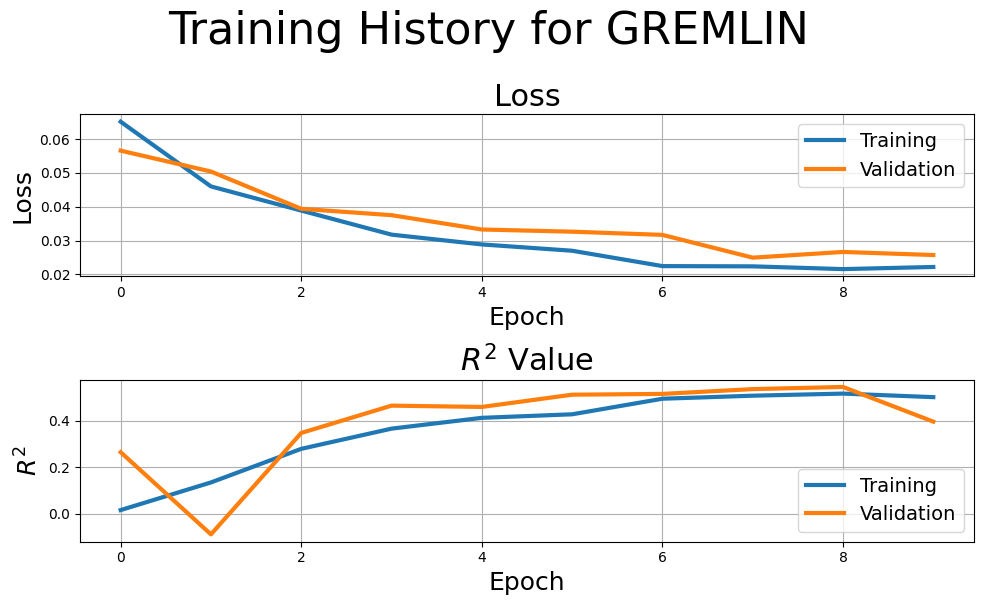

In [23]:
fig1, (ax1a, ax1b) = plt.subplots(2, 1, figsize=(10, 6))

# Plot training and validation loss
ax1a.plot(history.epoch, history.history['loss'], label='Training', linewidth=3)
ax1a.plot(history.epoch,
          history.history['val_loss'],
          label='Validation',
          linewidth=3)
ax1a.grid()
ax1a.set_xlabel('Epoch', fontsize=18)
ax1a.set_ylabel('Loss', fontsize=18)
ax1a.legend(fontsize=14)
ax1a.set_title('Loss', fontsize=22)

# Plot training and validation R^2
ax1b.plot(history.epoch,
          history.history['r_square_metric'],
          label='Training',
          linewidth=3)
ax1b.plot(history.epoch,
          history.history['val_r_square_metric'],
          label='Validation',
          linewidth=3)
ax1b.grid()
ax1b.set_xlabel('Epoch', fontsize=18)
ax1b.set_ylabel('$R^2$', fontsize=18)
ax1b.legend(fontsize=14)
ax1b.set_title('$R^2$ Value', fontsize=22)

fig1.suptitle('Training History for GREMLIN', fontsize=32, y=1.0)
fig1.tight_layout()

As expected, our blue lines (`training`) generally show decreases in `loss`, and increases in $R^2$, for successive epochs (though loss is not monotonically decreasing, and $R^2$ is not monotonically increasing). We note that neither loss nor $R^2$ have completely flattened out by the last couple of epochs, suggesting that we could increase the number of epochs without overfitting. Oftentimes, we can use a method called `early stopping` to prescribe when we've reached a plateau in our loss; at which time, the model then stops training.

We also see that the orange lines (`validation`) jump around quite a bit more than the blue lines. This is because our validation sample is only 1/4 the size of our training sample. However, the validation lines follow a similar trend to the training lines. This trend indicates that the model is sufficiently generalized such that it performs similarly well on unseen data as it does on the training data. If the validation lines diverge from the training lines, the model is likely overfitted&mdash;performing well on training data but poorly on the unseen validation data.

### Sample Prediction

Now, let's look at our output data. In analyzing our output data, we're looking for a few things:

- **Consistency**: Does our CNN output look broadly similar to our target? Does our output target have similar composite reflectivity values or similar spatial features?
- **Sharpness**: CNN outputs oftentimes can be blurry. When we look at our output, do we see sharp gradients, and reasonable extreme values?
- **Spatial location**: For meteorological features, we can sometimes have a model that does a pretty good job of predicting a feature overall, but the model puts the feature in the wrong place. For example, you might have a model that does well at predicting a cold front's strength and temperature gradient, but the model puts the cold front 20 km east of the observed cold front. Most of the time, weather forecasters would be fairly happy with this prediction (depending on their application). But a NN model would actually penalize you twice for putting a feature in the wrong location. This is an ongoing area of research in meteorology&mdash;researchers have explored evaluation methods and loss functions that incorporate spatial information into them. While we don't go into it here, interested readers can check out [Lagerquist and Ebert-Uphoff (2022)](https://www.google.com/url?q=https%3A%2F%2Fjournals.ametsoc.org%2Fview%2Fjournals%2Faies%2F1%2F4%2FAIES-D-22-0021.1.xml).

For our example output data, let's look at an earlier image from the case used in [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml)'s [Figure 6](https://journals.ametsoc.org/view/journals/apme/60/1/full-jamc-d-20-0084.1-f6.jpg). This case is one of the [costliest weather events in Colorado to date](https://www.denverpost.com/2017/05/23/hailstorm-costliest-ever-metro-denver/), and is quite difficult to forecast for several reasons:
- Large cloud anvils make it difficult to see the convective cores in infrared imagery like the GOES ABI images ([Williams et. al. 2005](https://doi.org/10.1016/j.atmosres.2004.11.009));
- Though lightning flash rates in these storms are often high, the lightning flash height can be fairly low, which makes it harder for GLM to see the lightning ([Rutledge et. al. 2020](https://doi.org/10.1029/2020JD032827)) and resulting in a relative minimum in lightning detection efficiency ([Marchand et. al. 2019](https://doi.org/10.1029/2019JD031039), [Fuchs et. al. 2018](https://doi.org/10.1029/2017JD027540))

Thus, this case is a good test of GREMLIN&mdash;if GREMLIN performs well for this event, we can surmise that it shows promise at being able to improve short-term convective forecasts.

/var/folders/fj/lbn7tp7d0415w0q3j2bb4zr40000gn/T/ipykernel_11163/4210637203.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig2.tight_layout()


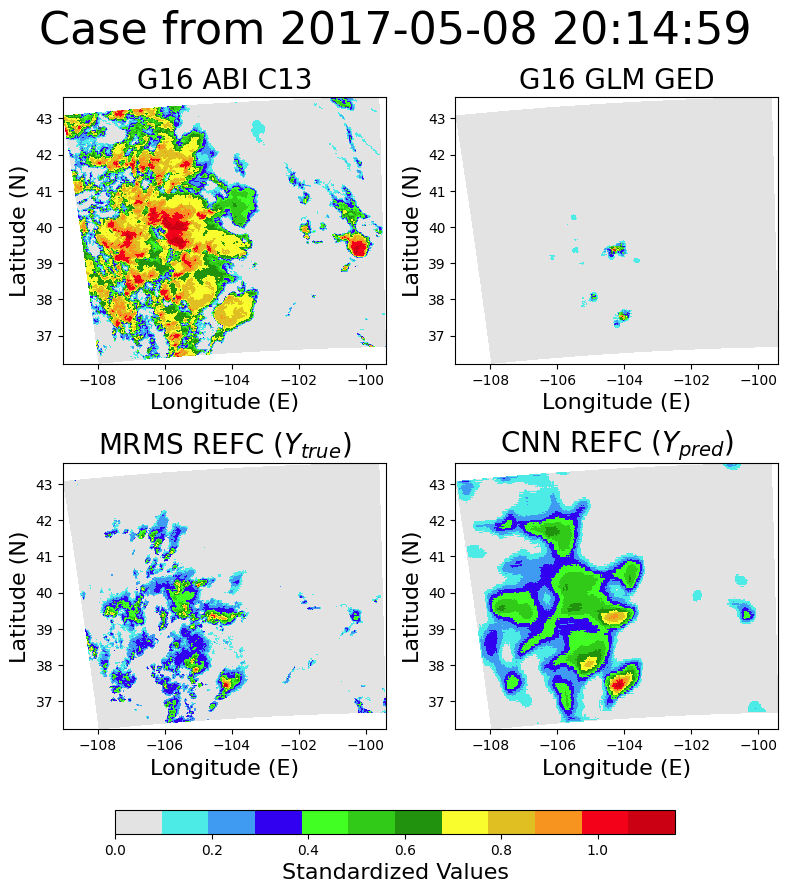

In [24]:
# Plot an example prediction
isamp = 25

# Use the radar colorbar
colors = ['#e3e3e3','#4cebe6','#3f9bf2','#3100f1','#42ff23','#32ca19',
          '#21920e','#f9fc2d','#e0bf23','#f79420','#f30019','#cb0013']
cmap=ListedColormap(colors, 'radar')

fig2, ((ax2a, ax2b), (ax2c, ax2d)) = plt.subplots(2, 2, figsize=(8, 8))

# GOES 16 ABI Ch13
amap = X_test[isamp, ::-1, :, 0]
pcm = ax2a.pcolormesh(ds["lon_test"][isamp, ::-1, :],
                      ds["lat_test"][isamp, ::-1, :],
                      amap,
                      cmap=cmap)
ax2a.set_ylabel('Latitude (N)', fontsize=16)
ax2a.set_xlabel('Longitude (E)', fontsize=16)
ax2a.set_title('G16 ABI C13', fontsize=20)

# GOES 16 GLM Global
amap = X_test[isamp, ::-1, :, 3]
pcm = ax2b.pcolormesh(ds["lon_test"][isamp, ::-1, :],
                      ds["lat_test"][isamp, ::-1, :],
                      amap,
                      cmap=cmap)
ax2b.set_ylabel('Latitude (N)', fontsize=16)
ax2b.set_xlabel('Longitude (E)', fontsize=16)
ax2b.set_title('G16 GLM GED', fontsize=20)

# MRMS REFC (this is our Y_true)
amap = Y_test[isamp, ::-1, :]
pcm = ax2c.pcolormesh(ds["lon_test"][isamp, ::-1, :],
                      ds["lat_test"][isamp, ::-1, :],
                      amap,
                      cmap=cmap)
ax2c.set_ylabel('Latitude (N)', fontsize=16)
ax2c.set_xlabel('Longitude (E)', fontsize=16)
ax2c.set_title('MRMS REFC ($Y_{true}$)', fontsize=20)

# Finally, plot CNN REFC (this is our Y_pred)
amap = pred[isamp, ::-1, :]
pcm = ax2d.pcolormesh(ds["lon_test"][isamp, ::-1, :],
                      ds["lat_test"][isamp, ::-1, :],
                      amap,
                      cmap=cmap)
ax2d.set_ylabel('Latitude (N)', fontsize=16)
ax2d.set_xlabel('Longitude (E)', fontsize=16)
ax2d.set_title('CNN REFC ($Y_{pred}$)', fontsize=20)

# Add a colorbar
cbar_ax = fig2.add_axes([0.15, -0.05, 0.7, 0.03])
cbar = fig2.colorbar(pcm, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_xlabel('Standardized Values', fontsize=16)

# Unmask time array
# Convert time value to seconds
# Add time value to time stamp of 201-01-01
time_samp = datetime.timedelta(seconds = np.ma.getdata(ds["time_test"])[isamp]) + datetime.datetime(2017,1,1)
fig2.suptitle('Case from ' + time_samp.strftime('%Y-%m-%d %H:%M:%S'),
              fontsize=32)

fig2.tight_layout()

#### Consistency
Looking at our predictions for our example case, we see that our CNN output for composite reflectivity (REFC($Y_{pred}$); bottom right), does in fact look broadly similar to our target output composite reflectivity (REFC($Y_{true}$); bottom left). Our CNN picks up the three strong convective cells seen in MRMS (at about 37.5N, 104W; 38N, 105W; and 39.5N, 104W), and the maximum values are close to those seen in MRMS. Note that these convective cells are also collocated with higher values of GLM group extent density (GED), indicating that model also learns about the relationship between lightning and regions of higher composite reflectivity.

#### Sharpness

Our CNN prediction of composite reflectivity is much less **sharp** than our target MRMS composite reflectivity. The higher values of radar reflectivity in MRMS are mostly confined to the areas around the convective cells, with much of the area in between the cells showing very weak or no reflectivity (blue and gray colors). In contrast, for the CNN, we have a much larger area of moderate (green) reflectivity values.

This blurriness is a common issue with CNNs. It's often described as the perception-distortion trade-off ([Blau and Michaeli 2018](https://openaccess.thecvf.com/content_cvpr_2018/html/Blau_The_Perception-Distortion_Tradeoff_CVPR_2018_paper.html)). That is&mdash;images that look *sharper* are often less *accurate* (better perception), while images that look *blurrier* are actually more *accurate* (less distortion). Since CNNs are really designed for maximizing accuracy, this is a hard paradigm to overcome&mdash;other AI methods, like generative adversarial networks (GANs) and diffusion models generate images that look sharper. Recent efforts (e.g., [Ebert-Uphoff et al. 2025](https://ams.confex.com/ams/105ANNUAL/meetingapp.cgi/Paper/455218)) have explored the utility of sharpness metrics from other fields in meteorological applications to see if there's some room for improvement for CNNs.

If we simply take the mean, median, and max of $Y_{pred}$, and compare it to $Y_{true}$, we see that $Y_{pred}$ has much higher mean and median values than $Y_{true}$, which has far more pixels that have a value of 0 than $Y_{pred}$. We also see that the maximum value of $Y_{pred}$ is slightly higher than that of $Y_{true}$.

In [25]:
# Print mean of Y_pred and Y_true
print('Y_pred mean: ', np.mean(pred[isamp,::-1,:]))
print('Y_true mean: ', np.mean(Y_test[isamp,::-1,:]))

# Print median of Y_pred and Y_true
print('Y_pred median: ', np.median(pred[isamp,::-1,:]))
print('Y_true median: ', np.median(Y_test[isamp,::-1,:]))

# Print maximum of Y_pred and Y_true
print('Y_pred max: ', np.max(pred[isamp,::-1,:]))
print('Y_true max: ', np.max(Y_test[isamp,::-1,:]))

Y_pred mean:  0.12634206
Y_true mean:  0.04781256
Y_pred median:  0.024671996
Y_true median:  0.0
Y_pred max:  1.1597993
Y_true max:  0.98645836


/Users/naufal/miniconda3/envs/gremlin/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


#### Spatial Location
Finally, we look at spatial location. By the old eye test, the spatial location of $Y_{pred}$ seems more or less equivalent to that of $Y_{true}$. However, we can be a little more rigorous by plotting the difference between $Y_{pred}$ and $Y_{true}$.

Text(0.5, 1.0, '$Y_{pred} - Y_{true}$')

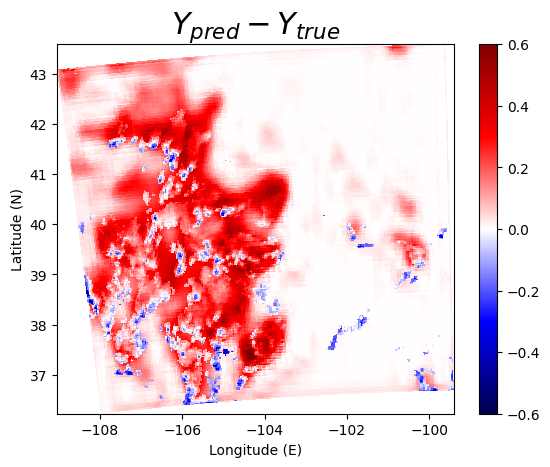

In [26]:
amap = pred[isamp,::-1,:] - Y_test[isamp,::-1,:]
plt.pcolormesh(ds["lon_test"][isamp,::-1,:],
               ds["lat_test"][isamp,::-1,:], amap, cmap='seismic', vmin=-0.6, vmax=0.6)
plt.colorbar()
plt.xlabel('Longitude (E)')
plt.ylabel('Latitude (N)')
plt.title('$Y_{pred} - Y_{true}$', fontsize=22)

Here, red colors indicate that $Y_{pred}$ is larger, and blue colors indicate that $Y_{true}$ is larger. We see an overall big blob of red, where composite reflectivity values of $Y_{pred}$ is larger. This large areas of larger composite reflectivity for $Y_{pred}$ is consistent with the discussion on sharpness, where the features in $Y_{pred}$ are overall too large and spread out, but they're not consistently off from $Y_{true}$.

### Bulk Validation

We've seen that, for our *sample case*, GREMLIN does well at capturing the general structure of the composite reflectivity field. However, how well does GREMLIN perform *in general*? Does it capture the distribution of the composite reflectivity for all of the test cases? In weather forecasting, one of the most popular ways of evaluating the bulk statistics of a forecasting model is the categorical performance diagram ([Roebber 2009](https://journals.ametsoc.org/view/journals/wefo/24/2/2008waf2222159_1.xml)). You can see the performance diagram for the full GREMLIN model in [Figure 5](https://journals.ametsoc.org/view/journals/apme/60/1/full-jamc-d-20-0084.1-f5.jpg) of [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml).

However, for brevity, we'll just compare the **cumulative density functions** for our target variables ($Y_{true}$) and our predictions ($Y_{pred}$). The two CDFs being similar to each other indicate that GREMLIN is sufficiently capturing the bulk statistics of the composite reflectivity.

Text(0.5, 1.0, 'Bulk Validation of GREMLIN Model')

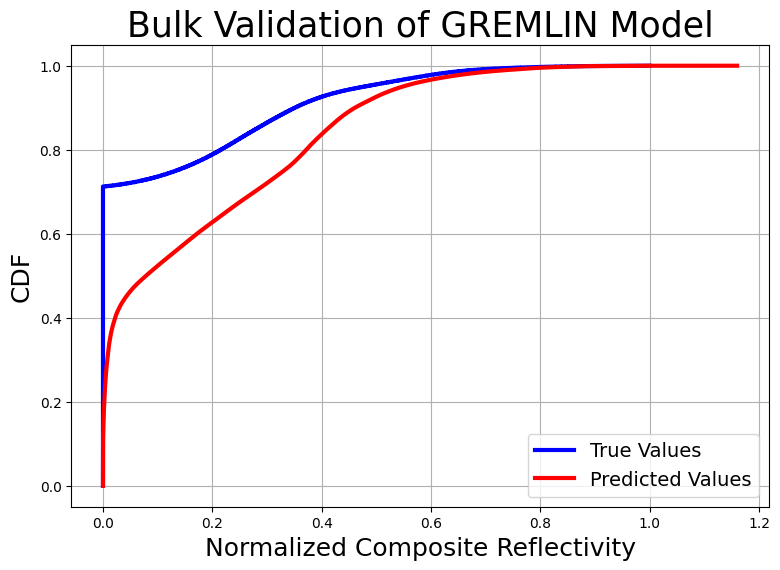

In [27]:
# Create CDF for Y_true
Y_sorted = np.sort(Y_test.flatten())
Y_cdf = np.arange(len(Y_sorted)) / (len(Y_sorted) - 1)

# Create CDF for Y_pred
pred_sorted = np.sort(pred.flatten())
pred_cdf = np.arange(len(pred_sorted)) / (len(pred_sorted) - 1)

# Plot CDF
fig1,ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.plot(Y_sorted, Y_cdf, color="blue", linewidth=3, label="True Values")
ax1.plot(pred_sorted, pred_cdf, color="red", linewidth=3, label="Predicted Values")
ax1.legend(fontsize=14)
ax1.grid()
ax1.set_xlabel('Normalized Composite Reflectivity', fontsize=18)
ax1.set_ylabel('CDF', fontsize=18)
ax1.set_title('Bulk Validation of GREMLIN Model', fontsize=25)

Comparing the CDFs of $Y_{true}$ and $Y_{pred}$, we see that $Y_{true}$ has a significant amount of normalized composite reflectivity values of zero, which account for about 70% of the data. Conversely, $Y_{pred}$ has a lower amount of normalized composite reflectivity values of zero that account for only about 40% of the data. This result matches what we've seen in our earlier analysis, where the smoothed reflectivity field produced by the CNN resulted in more of the data having non-zero normalized composite reflectivity values. Therefore, the trends we saw in our sample case is likely representative of the trends in the rest of the model predictions. That is, the model may capture the general structure of the composite reflectivity field. However, the simulated composite reflectivity field is smoother compared to the composite reflectivity field from MRMS.

### Interpretability and XAI

In [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml), the authors use eXplainable AI (XAI, e.g., [Ebert-Uphoff and Hilburn, 2020](https://journals.ametsoc.org/view/journals/bams/103/6/BAMS-D-20-0097.A.pdf), [McGovern et al. 2019](https://journals.ametsoc.org/view/journals/bams/100/11/bams-d-18-0195.1.xml), [Flora et al. 2024](https://journals.ametsoc.org/view/journals/aies/3/1/AIES-D-23-0018.1.xml)) to try to understand **how** GREMLIN makes predictions. That is, what physical patterns is it really learning from? [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml) first looked at how GREMLIN learns when it has access to GLM. They found:
- When the CNN looks at GLM data, the CNN focuses only on regions where lightning is present. Since lightning is a great predictor of strong convection, this result indicates that the model is learning a **physically relevant** pattern!
- This pattern carries over to the GOES ABI channels. When GREMLIN identifies lightning activity in GLM, it focuses on those areas in both GLM and the GOES ABI channels. This helps GREMLIN focus on the important parts of the image, and ignore the "noise" from the other parts.
-  Recall, we saw a similar relationship above, where the high composite reflectivity values are collocated with regions of higher GED.

Thus, GREMLIN appears to have learned that the presence of lightning is a good indicator of the behavior of our target variable (MRMS) in **all 4** input channels. This is physically consistent. Next, [Hilburn et al. (2021)](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml) looked at how GREMLIN makes decisions when GLM data is not available, and it can only use the GOES ABI data:

- In the absence of GLM, GREMLIN looks for areas where GOES ABI channels have either **a large gradient**, or **high brightness**. Large gradients are indicative of cloud boundaries, while high brightness is indicative of cold cloud top temperatures. Both of these features are associated with convective activity.

These strategies&mdash;identifying lightning activity, cloud boundaries, and cold cloud tops&mdash;are physically intuitive when it comes to identifying convection. That the CNN has identified physically consistent strategies to help it make predictions increases **trustworthiness** in GREMLIN as a useful forecasting tool.

<div class="alert alert-block alert-success">
    <h2>Practice</h2>
    <ol>
        <li>Change <code>nfilters</code> from 16 to 32, like in the original paper. How does this change the number of parameters? The run time? The quality of the prediction?</li>
        <li>Add a second convolutional layer to each block. This is a common structure for U-Nets, and will give you some practice in building your own models in <code>Tensorflow</code> and <code>Keras</code>. Does a second convolutional layer improve the model predictions?</li>
        <li>Add more training epochs to see if your model improves (or if you add too many, see if you veer into overfitting). You can also explore the idea of early stopping&mdash;a tool you can use to dynamically assess your model convergence after each epoch, and decide when the model has undergone enough training. See <a href="https://medium.com/@vrunda.bhattbhatt/a-step-by-step-guide-to-early-stopping-in-tensorflow-and-pytorch-59c1e3d0e376">this blog post</a> for a guide on early stopping.</li>
    </ol>
</div>

## Final Thoughts

In this notebook, we discussed the architecture of the GREMLIN model ([Hilburn et al. 2021](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml)) using `TensorFlow`. We used a toy dataset that has been preprocessed and normalized. In addition, we developed a model with fewer convolutional filters to increase the training speed. Nonetheless, we succeeded in recreating and analyzing key features of the GREMLIN model.

The model was able to capture the general structure of the composite reflectivity in our example case. More importantly, the model used lightning data to better capture the high composite reflectivity field associated with three convective cores. However, consistent with CNN performance, the composite reflectivity field is smoother than the true reflectivity field.

The GREMLIN model emulated in this notebook is at the beginning stages of development. [Lee and Hilburn (2024)](https://doi.org/10.1175/JAMC-D-23-0103.1) showed that this version of GREMLIN struggle in a few instances, such as:

- mistaking cold ground in the winter as precipitating clouds
- over-representing deep convection in regions with generally more lightning, like over Florida

Nonetheless, GREMLIN has promise to help improve convective nowcasting, particularly in radar-sparse regions. The tutorial provided in this notebook demonstrates the ways in which users can develop and improve upon their own version of GREMLIN that suits their specific needs.

## Data Statement

The training data used for this learning journey is publicly available via [Dryad](https://datadryad.org/dataset/doi:10.5061/dryad.m905qfv60). If you use this dataset in your own work, please cite:

Hilburn, Kyle (2023). GREMLIN CONUS1 Manually Selected Storms Dataset. Dryad. https://doi.org/10.5061/dryad.m905qfv60

## References

1. Blau, Y., and T. Michaeli, 2018: The perception-distortion tradeoff. *Conf. on
Computer Vision and Pattern Recognition*, Salt Lake City, UT, CVPR, 6228-6237, [https://openaccess.thecvf.com/content_cvpr_2018/html/Blau_The_Perception-Distortion_Tradeoff_CVPR_2018_paper.html](https://openaccess.thecvf.com/content_cvpr_2018/html/Blau_The_Perception-Distortion_Tradeoff_CVPR_2018_paper.html).

2. Chase, R.J., K. Haynes, L. Ver Hoef, and I. Ebert-Uphoff, 2025: Score-based diffusion nowcasting of GOES imagery. [arXiv:2505.10432](https://www.arxiv.org/abs/2505.10432).

3. Chen, B.-F., Y.-T. Kuo, and T.-S. Huang, 2023: A deep learning ensemble approach for predicting tropical cyclone rapid intensification. *Atmos. Sci. Lett.*, **24**, e1151. [https://doi.org/10.1002/asl.1151](https://doi.org/10.1002/asl.1151).

4. Ebert-Uphoff, I., R. Lagerquist, K. Hilburn, Y. Lee, K. Haynes, J. Stock, C. Kumler, and J.Q. Stewart, 2021: CIRA Guide to Custom Loss Functions for Neural Networks in Environmental Sciences &ndash; Version 1. [arXiv:2106.09757](https://arxiv.org/abs/2106.09757).

5. Ebert-Uphoff, I. and K. Hilburn, 2020: Evaluation, Tuning, and Interpretation of Neural Networks for Working with Images in Meteorological Applications. *Bull. Amer. Meteorol. Soc.*, **101**, E2149-E2170. [https://doi.org/10.1175/BAMS-D-20-0097.1](https://doi.org/10.1175/BAMS-D-20-0097.1).

6. Ebert-Uphoff, I., L. Ver Hoef, J. Schreck, J. Stock, M.J. Molina, A. McGovern, M. Yu, W. Petzke, K.A. Hilburn, D.M. Hall, D.J. Gagne, W.F. Campbell, J.T. Radford, J.Q. Stewart, and S. Scheuerman: Measuring Sharpness of AI-Generated Meteorological Imagery. American Meteorological Society 105th Annual Meeting, January 2025, [https://ams.confex.com/ams/105ANNUAL/meetingapp.cgi/Paper/455218](https://ams.confex.com/ams/105ANNUAL/meetingapp.cgi/Paper/455218)

7. Eure, K.C., P.D. Mykolajtchuk, Y. Zhang, D.J. Stensrud, F. Zhang, S.J. Greybush, and M.R. Kumjian, 2023: Simultaneous Assimilation of Planetary Boundary Layer Observations from Radar and All-Sky Satellite Observations to Improve Forecasts of Convection Initiation. *Mon. Weather Rev.*, **151**, 795-813. [https://doi.org/10.1175/MWR-D-22-0188.1](https://doi.org/10.1175/MWR-D-22-0188.1).

8. Farchi, A., P. Laloyaux, M. Bonavita, and M. Bocquet, 2021: Using machine learning to correct model error in data assimilation and forecast applications. *Quart. J. Roy. Meteorol. Soc.*, **147**, 3067-3084. [https://doi.org/10.1002/qj.4116](https://doi.org/10.1002/qj.4116).

9. Flora, M.L., C.K. Potvin, A. McGovern, and S. Handler, 2024: A machine learning explainability tutorial for atmospheric sciences. *Artificial Intelligence for Earth Systems*, **3**. [https://doi.org/10.1175/AIES-D-23-0018.1](https://doi.org/10.1175/AIES-D-23-0018.1).

10. Fuchs, B. R., S. A. Rutledge, B. Dolan, L. D. Carey, and C. Schultz, 2018: Microphysical and kinematic processes associated with anomalous charge structures in isolated convection. *J. Geophys. Res. Atmos.*, **123**, 6505-6528, [https://doi.org/10.1029/2017JD027540](https://doi.org/10.1029/2017JD027540).

11. Geer, A.J., K. Lonitz, P. Weston, M. Kazumori, K. Okamoto, Y. Zhu, E.H. Liu, A. Collard, W. Bell, S. Miglorini, P. Chambon, N. Fourrié, M.-J. Kim, C. Köpken-Watts, and C. Schraff, 2017: All-sky satellite data assimilation at operational weather forecasting centres. *Quart. J. Roy. Meteorol. Soc.*, **144**, 1191-1217. [https://doi.org/10.1002/qj.3202](https://doi.org/10.1002/qj.3202).

12. Goodman, S., D. Mach, W. Koshak, and R. Blakeslee, 2012: GLM lightning
cluster-filter algorithm, version 3.0. [NOAA NESDIS STAR Doc](https://www.star.nesdis.noaa.gov/goesr/documents/ATBDs/Baseline/ATBD_GOES-R_GLM_v3.0_Jul2012.pdf), 72 pp.

13. Goodman, S.J., and coauthors, 2013: The GOES-R Geostationary Lightning Mapper (GLM). *Atmos. Res.*, **125-126**, 34-49. doi:[10.1016/j.atmosres.2013.01.006](https://www.sciencedirect.com/science/article/pii/S0169809513000434).

14. Hartman, C.M., X. Chen, E.E. Clothiaux, and M.-Y. Chan, 2021: Improving the Analysis and Forecast of Hurricane Dorian (2019) with Simultaneous Assimilation of GOES-16 All-Sky Infrared Brightness Temperatures and Tail Doppler Radar Radial Velocities. *Mon. Weather Rev.*, **149**, 2193-2212. [https://doi.org/10.1175/MWR-D-20-0338.1](https://doi.org/10.1175/MWR-D-20-0338.1).

15. Hilburn, K.A.,  I. Ebert-Uphoff, and S.D. Miller, 2021: Development and interpretation of a neural-network-based synthetic radar reflectivity estimator using GOES-R satellite observations. *J. Applied Meteorol. Clim.*, **60**, doi:[10.1175/JAMC-D-20-0084.1](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml?trk=public_post_comment-text).

16. Howard, L.J., A. Subramanian, and I. Hoteit, 2024: A Machine Learning Augmented Data Assimilation Method for High-Resolution Observations. *J. Advances in Modeling Earth Sys.*, **16**, e2023MS003774. [https://doi.org/10.1029/2023MS003774](https://doi.org/10.1029/2023MS003774).

17. Lagerquist, R., A. McGovern, and T. Smith, 2017: Machine Learning for Real-Time Prediction of Damaging Straight-Line Convective Wind. *Weather and Forecasting*, **32**, 2175-2193. [https://doi.org/10.1175/WAF-D-17-0038.1](https://doi.org/10.1175/WAF-D-17-0038.1).

18. Lagerquist, R., A. McGovern, and D.J. Gagne II, 2019: Deep Learning for Spatially Explicit Prediction of Synoptic-Scale Fronts. *Weather and Forecasting*, **34**, 1137-1160. [https://doi.org/10.1175/WAF-D-18-0183](https://doi.org/10.1175/WAF-D-18-0183).

19. Lagerquist, R., A. McGovern, C.R. Homeyer, D.J. Gagne II, and T. Smith, 2020: Deep Learning on Three-Dimensional Multiscale Data for Next-Hour Tornado Prediction. *Mon. Weather Rev.*, **148**, 2837-2861. [https://doi.org/10.1175/MWR-D-19-0372.1](https://doi.org/10.1175/MWR-D-19-0372.1).

20. Lagerquist, R., J.Q. Stewart, I. Ebert-Uphoff, and C. Kumler, 2021: Using Deep Learning to Nowcast the Spatial Coverage of Convection from Himawari-8 Satellite Data. *Mon. Weather Rev.*, **149**, 3897-3921. [https://doi.org/10.1175/MWR-D-21-0096.1](https://doi.org/10.1175/MWR-D-21-0096.1).

21. Lagerquist, R., and I. Ebert-Uphoff, 2022: Can we integrate spatial verification methods into neural network loss functions for atmospheric science? *Artificial Intelligence for Earth Sys.*, **1**. doi:[10.1175/AIES-D-22-0021.1](https://journals.ametsoc.org/view/journals/aies/1/4/AIES-D-22-0021.1.xml).

22. Lagerquist, R., J.A. Knaff, C.J. Slocum, K. Musgrave, and I. Ebert-Uphoff, 2025: Identifying data sources and physical strategies used by neural networks to predict TC rapid intensification. *Weather and Forecasting*, **40**, doi:[https://doi.org/10.1175/WAF-D-24-0166.1](https://doi.org/10.1175/WAF-D-24-0166.1)

23. Lee, Y. and K. Hilburn, 2024: Validating GOES Radar Estimation via Machine Learning to Inform NWP (GREMLIN) Product over CONUS. *J. Appl. Meteor. Climatol.*, **63**, 471-486, [https://doi.org/10.1175/JAMC-D-23-0103.1](https://doi.org/10.1175/JAMC-D-23-0103.1)

24. Lin, H., S.S. Weygandt, S.G. Benjamin, and M. Hu, 2017: Satellite Radiance Data Assimilation within the Hourly Updated Rapid Refresh. *Weather and Forecasting*, **32**, 1273-1287. [https://doi.org/10.1175/WAF-D-16-0215.1](https://doi.org/10.1175/WAF-D-16-0215.1).

25. Lu, F., 2025: U-Net Kalman Filter (UNetKF): An Example of Machine Learning-Assisted Data Assimilation. *J. Advances in Modeling Earth Sys.*, **17**, e2023MS003979. [https://doi.org/10.1029/2023MS003979](https://doi.org/10.1029/2023MS003979).

26. Marchand, M., K. Hilburn, and S. D. Miller, 2019: Geostationary Lightning Mapper and Earth Networks lightning detection over the contiguous United States and dependence on flash characteristics. *J. Geophys. Res. Atmos.*, **124**, 11,552-11,567, [https://doi.org/10.1029/2019JD031039](https://doi.org/10.1029/2019JD031039).

27. McGovern, A., Lagerquist, R., John Gagne, D., Jergensen, G. E., Elmore, K. L., Homeyer, C. R., & Smith, T., 2019: Making the black box more transparent: Understanding the physical implications of machine learning. *Bulletin of the American Meteorological Society*, **100**, 2175-2199. [https://doi.org/10.1175/BAMS-D-18-0195.1](https://doi.org/10.1175/BAMS-D-18-0195.1).

28. Roebber, P., 2009: Visualizing Multiple Measures of Forecast Quality. *Weather and Forecasting*, **24**, 601-608. [https://doi.org/10.1175/2008WAF2222159.1](https://doi.org/10.1175/2008WAF2222159.1).

29. Ronneberger, O., P. Fischer, and T. Brox, 2015: U-Net: Convolutional Networks for Biomedical Image Segmentation. [arXiv:1505.04597](https://arxiv.org/abs/1505.04597).

30. Rutledge, S. A., K. Hilburn, A. Clayton, B. Fuchs, and S. D. Miller, 2020: Evaluating Geostationary Lightning Mapper flash rates within intense convective storms. *J. Geophys. Res. Atmos.*, **125**, e2020JD032827, [https://doi.org/10.1029/2020JD032827](https://doi.org/10.1029/2020JD032827).

31. Schmit, T., P. Griffith, M.M. Gunshor, J.M. Daniels, S.J. Goodman, and W.J. Lebair, 2017: A closer look at the ABI on the GOES-R series. *Bull. Amer. Meteorol. Soc.*, **98**, 681-698. doi:[10.1175/BAMS-D-15-00230.1](https://journals.ametsoc.org/view/journals/bams/98/4/bams-d-15-00230.1.xml).  

32. Smith, T.M., and coauthors, 2016: Multi-Radar Multi-Sensor (MRMS) severe weather and aviation products: Initial operating capabilities. *Bull. Amer. Meteorol. Soc.*, **97**, 1617-1630. doi:[10.1175/BAMS-D-14-00173.1](https://journals.ametsoc.org/view/journals/bams/97/9/bams-d-14-00173.1.xml).

33. Svaldi, A., 2017: Hailstorm that hammered west metro Denver May 8 is costliest ever for Colorado. Denver Post, [https://www.denverpost.com/2017/05/23/hailstorm-costliest-ever-metro-denver/](https://www.denverpost.com/2017/05/23/hailstorm-costliest-ever-metro-denver/).

34. Williams, E., V. Mushtak, D. Rosenfeld, S. Goodman, and D. Boccippio, 2005: Thermodynamic conditions favorable to superlative thunderstorm updraft, mixed phase microphysics and lightning flash rate. *Atmos. Res.*, **76**, 288-306, [https://doi.org/10.1016/j.atmosres.2004.11.009](https://doi.org/10.1016/j.atmosres.2004.11.009).

35. Zhang, Y., S.B. Sieron, Y. Lu, X. Chen, R. G. Nystrom, M. Minamide, M.-Y. Chan, C.M. Hartman, Z. Yao, J.H. Ruppert, A. Okazaki, S.J. Greybush, E.E. Clothiaux, and F. Zhang, 2021: Ensemble-Based Assimilation of Satellite All-Sky Microwave Radiances Improves Intensity and Rainfall Predictions for Hurricane Harvey (2017). *Geophys. Res. Lett.*, **48**, e2021GL096410. [https://doi.org/10.1029/2021GL096410](https://doi.org/10.1029/2021GL096410)

## Metadata
Language / package(s)
* Python
* netCDF
* tensorflow
* keras

Domain
* NOAA
* NASA
* GOES

Application Keywords
* Satellite data
* Synthetic radar
* Machine learning
* Nowcasting

Geophysical Keywords
* Convection
* Precipitation
* Lightning

AI Keywords
* Neural network
* CNN
* Custom loss function

## Disclaimer
This Jupyter notebook is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, or the United States Department of Commerce. All NOAA Jupyter notebooks are provided on an 'as is' basis and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.